# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [3]:
import praw

# Replace these with your credentials
client_id = "E7bFRugnERNC20c6n9aHow"
client_secret = "8l-Y9nftAoS7qUmMWQTUg9CJ7K8_dA"
user_agent = "AmitKumarRedditScript/0.1 by ChipAppropriate562"  # Example: 'my_reddit_scraper'

# Set up Reddit instance
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Check if connection is successful
print(f"Read-only: {reddit.read_only}")


Read-only: True


In [4]:
subreddit = reddit.subreddit('RBC')
for post in subreddit.top(limit=10):
    print(f"Title: {post.title}")
    print(f"Upvotes: {post.score}")
    print(f"URL: {post.url}")
    print(f"Comments: {post.num_comments}\n")

Title: RBC does not care about its employees
Upvotes: 98
URL: https://www.reddit.com/r/rbc/comments/1ep5h1v/rbc_does_not_care_about_its_employees/
Comments: 47

Title: RBC is ridiculous
Upvotes: 87
URL: https://www.reddit.com/r/rbc/comments/198fssc/rbc_is_ridiculous/
Comments: 214

Title: Defrauded of $10k
Upvotes: 64
URL: https://www.reddit.com/r/rbc/comments/1dpxexx/defrauded_of_10k/
Comments: 117

Title: rbc is the worst bank ever
Upvotes: 62
URL: https://www.reddit.com/r/rbc/comments/1di8yot/rbc_is_the_worst_bank_ever/
Comments: 49

Title: Free Apple Watch for new customers
Upvotes: 32
URL: https://www.reddit.com/r/rbc/comments/1aiqspo/free_apple_watch_for_new_customers/
Comments: 34

Title: RBC has got to be the worst bank in Canada
Upvotes: 30
URL: https://www.reddit.com/r/rbc/comments/1ficcoy/rbc_has_got_to_be_the_worst_bank_in_canada/
Comments: 60

Title: RBC is encouraging kidnapping with their new $50,000 International Money Transfers limit.
Upvotes: 22
URL: https://www.reddi

In [5]:
import pandas as pd
from datetime import datetime, timezone
import time
import logging


#logging setup
handlers = [
    logging.FileHandler("scraping_log.log"),
    logging.StreamHandler()  # This will log to the console
]

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=handlers
)


banks = ['CIBC', 'Scotiabank', 'TD', 'RBC', 'BMO']


def save_to_csv(data,filename):
    df=pd.DataFrame(data)
    df.to_csv(filename,index=False)
    logging.info(f"Saved data to {filename} with {len(data)} rows" )
    
def validate_post(post):
    return bool(post.title and post.selftext)


max_retries=2
def scrape_reddit_posts(subreddit_name, banks, limit=200):
    post_data = []
    after_tokens = {}
    try:
        subreddit = reddit.subreddit(subreddit_name)
        # Search for posts mentioning banks
        for bank in banks: 
            total_post_per_bank=0
            query = f"{bank}"
            logging.info(f"Scraping posts for {bank} in {subreddit_name}")
            after = after_tokens.get(bank,None)
            print(f"Scraping posts for {bank} in {subreddit_name}")
            retries = 0  # Initialize retry counter for this bank

            while True: #total_post_per_bank != -1:#True:
                try:
                    # Fetch posts based on the 'after' parameter
                    if after:
                        print('after attribute is set:', after)
                        posts = subreddit.search(query=query, limit=limit, params={'after': after})
                    else:
                        print('after attribute is not set:', after)
                        posts = subreddit.search(query=query, limit=limit)
                    
                    # Convert the ListingGenerator to a list for easy processing
                    posts_list = list(posts)
                    print(f"Fetched {len(posts_list)} posts for {bank}")
                    if len(posts_list)==0:
                        break
                    if not posts_list:  # If no more posts, break the loop for this bank
                        print(f"No more posts found for {bank}. Exiting loop.")
                        break
                    total_post_per_bank+= len(posts_list)
                    posts_found = False
                    
                    # Iterate through the fetched posts
                    for post in posts_list:
                        if validate_post(post):
                            print(post.title)
                            posts_found = True
                            post_data.append({
                                'Bank': bank,
                                'Subreddit_name': subreddit_name,
                                'Title': post.title,
                                'Bpvotes': post.score,
                                'Selftext': post.selftext,
                                'Comments Count': post.num_comments,
                                'Created': datetime.fromtimestamp(post.created_utc,tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S'),
                                'Post URL': post.url
                            })
                        else:
                            logging.warning(f"Skipping post for {bank} in {subreddit_name}")
                    
                    # Update 'after' to the ID of the last post, if found
                    
                    if posts_found:
                        if posts_list:  # Check if posts_list is not empty
                            if after == f"t3_{posts_list[-1].id}":  # Check if the after token is not advancing
                                print(f"Pagination is stuck for {bank}, after token is not advancing.")
                                after_tokens[bank] = None  # Reset the token to prevent infinite looping
                                break
                            after = f"t3_{posts_list[-1].id}"  # Get the ID of the last post, for pagination
                            after_tokens[bank]=after
                            print(f"Updated 'after' to {after}")
                            logging.info(f"Updated 'after' to {after}")
                        else:
                            print(f"No more posts found for {bank}. Exiting loop.")
                            after_tokens[bank]=None
                            break
                    else:
                        after_tokens[bank]=None
                        break  # No more posts found, exit loop
                    #if total_post_per_bank>100: break
                except Exception as e:
                    logging.error(f"Error scraping {bank} in {subreddit_name}: {e}")
                    break
        print("Return post data size: ", len(post_data))
        return post_data, after_tokens  # Return both post data and after (indicating the post ID of the last post)
    except Exception as e:
        logging.error(f"Failed to scrape {subreddit_name}: {e}")
        return [], None


batch_size = 500
#subreddits to scrape        
#subreddits =['PersonalFinanceCanada','Canada','Investing','Banking']
subreddits =['Scotiabank','CIBC','TalesFromTheCustomer','MobileProviders','ChurningCanada','CreditCards','Banking','CanadianInvestor','Investing','Stocks','RealEstateCanada','Mortgages','Canada','apple','Android ','MobileApp','PersonalFinanceCanada','ChurningCanada','TalesFromTheCustomer']

all_posts=[]


for subreddit in subreddits:
    count=0
    after_tokens={}
    total_post = 0
    while total_post < (500*len(banks)):
        print("executing batch, total_post",total_post," count: ",count, " subreddit: ",subreddit)
        batch_posts, after_tokens = scrape_reddit_posts(subreddit,banks,limit=200)
        if len(batch_posts)==0:
            break
        total_post += len(batch_posts)
        all_posts.extend(batch_posts)
        print(f'batch complete. Total posts so far:{total_post}')
        count+=1
        if all(after is None for after in after_tokens.values()) or total_post >= (500*len(banks)) or count>5:
            break
    #extend is list which will add element by element in into the list, whereas append will attach the whole list in once
    print("total posts:",total_post)
if len(all_posts)==0:
    logging.warning("No posts scraped, check API or query limits")
else:
    timestamp = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filename=f"canadian_banks_reddit_posts_{timestamp}.csv"
    save_to_csv(all_posts,filename)

df=pd.DataFrame(all_posts)
df.head()



2024-10-27 22:28:27,500 - INFO - Scraping posts for CIBC in Scotiabank


executing batch, total_post 0  count:  0  subreddit:  Scotiabank
Scraping posts for CIBC in Scotiabank
after attribute is not set: None


2024-10-27 22:28:27,862 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:27,979 - INFO - Scraping posts for Scotiabank in Scotiabank


Fetched 9 posts for CIBC
Worst Customer Service I've Experienced From A Bank
Fraudulent Charges
Scotiabank is not it
ATMs not accepting cash
recovery process after account frozen and closed
Accepted Settlement In Progress Meaning? 
No Fee credit card 0% promo
Clarification on SelectPay?
SCOTIABANK NO E-STATEMENT REMINDERS, BULLSHIT!
Updated 'after' to t3_jgcu7x
after attribute is set: t3_jgcu7x
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Scotiabank
after attribute is not set: None


2024-10-27 22:28:30,007 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,008 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,010 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,011 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,012 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,014 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,014 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,016 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,017 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,018 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,021 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,022 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,023 - WARNING - Skipping post fo

Fetched 200 posts for Scotiabank
Scotiabank outage  
Scotia online new look
Scotiabank says I CAN'T fold my cash?
Scotiabank fraud
Bye bye Scotiabank
Scotiabank account frauded twice in two months 
Done with Scotiabank
Email from Scotiabank 
Scotiabank CC 10% cashback
$5,000 Pizza!?! 🤯 Scotiabank Denies Fraud Claim
Scotiabank Gold Amex CC
Scotiabank- Application
Scotiabank investment 90 day history for mortgage application 
Scotiabank Ultimate - fee change & AI bot
Having trouble signing into the Scotiabank mobile app or website? This might be why!
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
How to know if paid credit card on Scotiabank app?
Scotiabank one-way video recording 
Anyone else’s Scotiabank Visa Credit card not working? 
Car loan with scotiabank, an owing balance after I’ve paid?
Scotiabank is not it
Scotiabank Scene Gold Amex. Cannot activate online account.
Did Scotiabank Online remove Quicken Export

2024-10-27 22:28:30,346 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,348 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:30,348 - INFO - Updated 'after' to t3_1g6x2xj
2024-10-27 22:28:30,494 - INFO - Scraping posts for TD in Scotiabank


Fetched 39 posts for Scotiabank
As a long time customer...
Cheque Holds
Can’t cancel Scotia select pay??
credit card debt doesn't clear even though i've paid
Keep getting overdrawn charges
What is - Apply my Scene+ points to travel?
Scene Quietly Removed from Account/Card?
Visa infinite
Not sure if this is the right sub but why is the Scene+ site soooo bad???
Application not working
Anyones scotia mobile down
Song in recent richer than you think ad
Thinking about getting a Scotia credit card
Line of credit interest spike
Scotia Bank Canada app not letting me log in, says "Err: too many redirects"
How to stop Autopay?
Closing Chequing Account - Part of Mortgage Conditions
Personal LOC interest rates
New App Update
Monday
debit card fraud
E-transfer not working on new account 
Has anybody actually talked to someone at a branch
Car loan 
Bunch of losers run this bank 
Got Debited instead of Return Credit
Why hasn't my credit score changed in the past 3 months?
RRSP question
Why so many qu

2024-10-27 22:28:31,057 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:31,189 - INFO - Scraping posts for RBC in Scotiabank


Fetched 22 posts for TD
Worst Customer Service I've Experienced From A Bank
bank account closed
Scotia didn’t properly change over my bank account for my loan and is costing me $400 in overdraft on my other account.
Why so many questions? 
Credit increase 
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
Creating a student bank account for personal use
Should I get the Scotiabank Amex Gold card?
Fraud
This bank is weird
How can a never-used debit card be compromised (3x)?
Rant about long customer service wait times in case of lost card, recs for another bank?
How to transfer from LOC to chequing?
Scotiabank e-transfer link
Scotiabank Passport Infinite
No Fee credit card 0% promo
Worst bank hours
Google Pay - no longer able to add Scotiabank Visa
US Credit card bill payment
Issues With Getting Added As POA
Scotiabank making it as difficult as possible for me to access my money
SCOTIABANK NO E-STATEMENT REMINDERS, BULLS

2024-10-27 22:28:31,514 - WARNING - Skipping post for RBC in Scotiabank
2024-10-27 22:28:31,514 - INFO - Updated 'after' to t3_n2a5av
2024-10-27 22:28:31,623 - INFO - Scraping posts for BMO in Scotiabank


Fetched 19 posts for RBC
Worst Customer Service I've Experienced From A Bank
Passport Visa Infinite Credit Card with higher FX conversion rate than expected
Hard Inquiry
Cheque Holds
How to stop Autopay?
Credit increase 
Transaction history download formats removed?
Turnaround time on fraud investigation?
Request for NSF Fees Waived: In-person or phone call?
Scotiabank is not it
This bank is weird
Job Referrals 
Student line of credit 
How to transfer from LOC to chequing?
No Fee credit card 0% promo
Why does Scotiabank hold bank drafts?
Has anyone experienced on line/telephone customer service worse than what Scotiabank provides?
Login
Updated 'after' to t3_n2a5av
after attribute is set: t3_n2a5av
Fetched 0 posts for RBC
Scraping posts for BMO in Scotiabank
after attribute is not set: None


2024-10-27 22:28:31,816 - INFO - Updated 'after' to t3_1bgyqmi
2024-10-27 22:28:31,924 - INFO - Scraping posts for CIBC in Scotiabank


Fetched 5 posts for BMO
Worst Customer Service I've Experienced From A Bank
Visa infinite
Scotiabank saving account can’t receive wire transfer
Scotiabank vent
Yet another "autopay" gone post
Updated 'after' to t3_1bgyqmi
after attribute is set: t3_1bgyqmi
Fetched 0 posts for BMO
Return post data size:  264
batch complete. Total posts so far:264
executing batch, total_post 264  count:  1  subreddit:  Scotiabank
Scraping posts for CIBC in Scotiabank
after attribute is not set: None


2024-10-27 22:28:32,091 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:32,223 - INFO - Scraping posts for Scotiabank in Scotiabank


Fetched 9 posts for CIBC
Worst Customer Service I've Experienced From A Bank
Fraudulent Charges
Scotiabank is not it
ATMs not accepting cash
recovery process after account frozen and closed
Accepted Settlement In Progress Meaning? 
No Fee credit card 0% promo
Clarification on SelectPay?
SCOTIABANK NO E-STATEMENT REMINDERS, BULLSHIT!
Updated 'after' to t3_jgcu7x
after attribute is set: t3_jgcu7x
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Scotiabank
after attribute is not set: None


2024-10-27 22:28:33,759 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,759 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,766 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,766 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,768 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,769 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,769 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,770 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,771 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,771 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,771 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,771 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:33,771 - WARNING - Skipping post fo

Fetched 200 posts for Scotiabank
Scotiabank outage  
Scotia online new look
Scotiabank says I CAN'T fold my cash?
Scotiabank fraud
Bye bye Scotiabank
Scotiabank account frauded twice in two months 
Done with Scotiabank
Email from Scotiabank 
Scotiabank CC 10% cashback
$5,000 Pizza!?! 🤯 Scotiabank Denies Fraud Claim
Scotiabank Gold Amex CC
Scotiabank- Application
Scotiabank investment 90 day history for mortgage application 
Scotiabank Ultimate - fee change & AI bot
Having trouble signing into the Scotiabank mobile app or website? This might be why!
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
How to know if paid credit card on Scotiabank app?
Scotiabank one-way video recording 
Anyone else’s Scotiabank Visa Credit card not working? 
Car loan with scotiabank, an owing balance after I’ve paid?
Scotiabank is not it
Scotiabank Scene Gold Amex. Cannot activate online account.
Did Scotiabank Online remove Quicken Export

2024-10-27 22:28:34,159 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:34,159 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:34,159 - INFO - Updated 'after' to t3_1g6x2xj
2024-10-27 22:28:34,300 - INFO - Scraping posts for TD in Scotiabank


Fetched 39 posts for Scotiabank
As a long time customer...
Cheque Holds
Can’t cancel Scotia select pay??
credit card debt doesn't clear even though i've paid
Keep getting overdrawn charges
What is - Apply my Scene+ points to travel?
Scene Quietly Removed from Account/Card?
Visa infinite
Not sure if this is the right sub but why is the Scene+ site soooo bad???
Application not working
Anyones scotia mobile down
Song in recent richer than you think ad
Thinking about getting a Scotia credit card
Line of credit interest spike
Scotia Bank Canada app not letting me log in, says "Err: too many redirects"
How to stop Autopay?
Closing Chequing Account - Part of Mortgage Conditions
Personal LOC interest rates
New App Update
Monday
debit card fraud
E-transfer not working on new account 
Has anybody actually talked to someone at a branch
Car loan 
Bunch of losers run this bank 
Got Debited instead of Return Credit
Why hasn't my credit score changed in the past 3 months?
RRSP question
Why so many qu

2024-10-27 22:28:34,533 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:34,680 - INFO - Scraping posts for RBC in Scotiabank


Fetched 22 posts for TD
Worst Customer Service I've Experienced From A Bank
bank account closed
Scotia didn’t properly change over my bank account for my loan and is costing me $400 in overdraft on my other account.
Why so many questions? 
Credit increase 
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
Creating a student bank account for personal use
Should I get the Scotiabank Amex Gold card?
Fraud
This bank is weird
How can a never-used debit card be compromised (3x)?
Rant about long customer service wait times in case of lost card, recs for another bank?
How to transfer from LOC to chequing?
Scotiabank e-transfer link
Scotiabank Passport Infinite
No Fee credit card 0% promo
Worst bank hours
Google Pay - no longer able to add Scotiabank Visa
US Credit card bill payment
Issues With Getting Added As POA
Scotiabank making it as difficult as possible for me to access my money
SCOTIABANK NO E-STATEMENT REMINDERS, BULLS

2024-10-27 22:28:34,936 - WARNING - Skipping post for RBC in Scotiabank
2024-10-27 22:28:34,937 - INFO - Updated 'after' to t3_n2a5av
2024-10-27 22:28:35,074 - INFO - Scraping posts for BMO in Scotiabank


Fetched 19 posts for RBC
Worst Customer Service I've Experienced From A Bank
Passport Visa Infinite Credit Card with higher FX conversion rate than expected
Hard Inquiry
Cheque Holds
How to stop Autopay?
Credit increase 
Transaction history download formats removed?
Turnaround time on fraud investigation?
Request for NSF Fees Waived: In-person or phone call?
Scotiabank is not it
This bank is weird
Job Referrals 
Student line of credit 
How to transfer from LOC to chequing?
No Fee credit card 0% promo
Why does Scotiabank hold bank drafts?
Has anyone experienced on line/telephone customer service worse than what Scotiabank provides?
Login
Updated 'after' to t3_n2a5av
after attribute is set: t3_n2a5av
Fetched 0 posts for RBC
Scraping posts for BMO in Scotiabank
after attribute is not set: None


2024-10-27 22:28:35,219 - INFO - Updated 'after' to t3_1bgyqmi
2024-10-27 22:28:35,356 - INFO - Scraping posts for CIBC in Scotiabank


Fetched 5 posts for BMO
Worst Customer Service I've Experienced From A Bank
Visa infinite
Scotiabank saving account can’t receive wire transfer
Scotiabank vent
Yet another "autopay" gone post
Updated 'after' to t3_1bgyqmi
after attribute is set: t3_1bgyqmi
Fetched 0 posts for BMO
Return post data size:  264
batch complete. Total posts so far:528
executing batch, total_post 528  count:  2  subreddit:  Scotiabank
Scraping posts for CIBC in Scotiabank
after attribute is not set: None


2024-10-27 22:28:35,564 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:35,676 - INFO - Scraping posts for Scotiabank in Scotiabank


Fetched 9 posts for CIBC
Worst Customer Service I've Experienced From A Bank
Fraudulent Charges
Scotiabank is not it
ATMs not accepting cash
recovery process after account frozen and closed
Accepted Settlement In Progress Meaning? 
No Fee credit card 0% promo
Clarification on SelectPay?
SCOTIABANK NO E-STATEMENT REMINDERS, BULLSHIT!
Updated 'after' to t3_jgcu7x
after attribute is set: t3_jgcu7x
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Scotiabank
after attribute is not set: None


2024-10-27 22:28:37,442 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,444 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,445 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,446 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,447 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,448 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,448 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,449 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,450 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,451 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,452 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,453 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,454 - WARNING - Skipping post fo

Fetched 200 posts for Scotiabank
Scotiabank outage  
Scotia online new look
Scotiabank says I CAN'T fold my cash?
Scotiabank fraud
Bye bye Scotiabank
Scotiabank account frauded twice in two months 
Done with Scotiabank
Email from Scotiabank 
Scotiabank CC 10% cashback
$5,000 Pizza!?! 🤯 Scotiabank Denies Fraud Claim
Scotiabank Gold Amex CC
Scotiabank- Application
Scotiabank investment 90 day history for mortgage application 
Scotiabank Ultimate - fee change & AI bot
Having trouble signing into the Scotiabank mobile app or website? This might be why!
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
How to know if paid credit card on Scotiabank app?
Scotiabank one-way video recording 
Anyone else’s Scotiabank Visa Credit card not working? 
Car loan with scotiabank, an owing balance after I’ve paid?
Scotiabank is not it
Scotiabank Scene Gold Amex. Cannot activate online account.
Did Scotiabank Online remove Quicken Export

2024-10-27 22:28:37,799 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,801 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:37,803 - INFO - Updated 'after' to t3_1g6x2xj
2024-10-27 22:28:37,915 - INFO - Scraping posts for TD in Scotiabank


Fetched 39 posts for Scotiabank
As a long time customer...
Cheque Holds
Can’t cancel Scotia select pay??
credit card debt doesn't clear even though i've paid
Keep getting overdrawn charges
What is - Apply my Scene+ points to travel?
Scene Quietly Removed from Account/Card?
Visa infinite
Not sure if this is the right sub but why is the Scene+ site soooo bad???
Application not working
Anyones scotia mobile down
Song in recent richer than you think ad
Thinking about getting a Scotia credit card
Line of credit interest spike
Scotia Bank Canada app not letting me log in, says "Err: too many redirects"
How to stop Autopay?
Closing Chequing Account - Part of Mortgage Conditions
Personal LOC interest rates
New App Update
Monday
debit card fraud
E-transfer not working on new account 
Has anybody actually talked to someone at a branch
Car loan 
Bunch of losers run this bank 
Got Debited instead of Return Credit
Why hasn't my credit score changed in the past 3 months?
RRSP question
Why so many qu

2024-10-27 22:28:38,189 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:38,314 - INFO - Scraping posts for RBC in Scotiabank


Fetched 22 posts for TD
Worst Customer Service I've Experienced From A Bank
bank account closed
Scotia didn’t properly change over my bank account for my loan and is costing me $400 in overdraft on my other account.
Why so many questions? 
Credit increase 
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
Creating a student bank account for personal use
Should I get the Scotiabank Amex Gold card?
Fraud
This bank is weird
How can a never-used debit card be compromised (3x)?
Rant about long customer service wait times in case of lost card, recs for another bank?
How to transfer from LOC to chequing?
Scotiabank e-transfer link
Scotiabank Passport Infinite
No Fee credit card 0% promo
Worst bank hours
Google Pay - no longer able to add Scotiabank Visa
US Credit card bill payment
Issues With Getting Added As POA
Scotiabank making it as difficult as possible for me to access my money
SCOTIABANK NO E-STATEMENT REMINDERS, BULLS

2024-10-27 22:28:38,539 - WARNING - Skipping post for RBC in Scotiabank
2024-10-27 22:28:38,540 - INFO - Updated 'after' to t3_n2a5av
2024-10-27 22:28:38,663 - INFO - Scraping posts for BMO in Scotiabank


Fetched 19 posts for RBC
Worst Customer Service I've Experienced From A Bank
Passport Visa Infinite Credit Card with higher FX conversion rate than expected
Hard Inquiry
Cheque Holds
How to stop Autopay?
Credit increase 
Transaction history download formats removed?
Turnaround time on fraud investigation?
Request for NSF Fees Waived: In-person or phone call?
Scotiabank is not it
This bank is weird
Job Referrals 
Student line of credit 
How to transfer from LOC to chequing?
No Fee credit card 0% promo
Why does Scotiabank hold bank drafts?
Has anyone experienced on line/telephone customer service worse than what Scotiabank provides?
Login
Updated 'after' to t3_n2a5av
after attribute is set: t3_n2a5av
Fetched 0 posts for RBC
Scraping posts for BMO in Scotiabank
after attribute is not set: None


2024-10-27 22:28:38,806 - INFO - Updated 'after' to t3_1bgyqmi
2024-10-27 22:28:38,922 - INFO - Scraping posts for CIBC in Scotiabank


Fetched 5 posts for BMO
Worst Customer Service I've Experienced From A Bank
Visa infinite
Scotiabank saving account can’t receive wire transfer
Scotiabank vent
Yet another "autopay" gone post
Updated 'after' to t3_1bgyqmi
after attribute is set: t3_1bgyqmi
Fetched 0 posts for BMO
Return post data size:  264
batch complete. Total posts so far:792
executing batch, total_post 792  count:  3  subreddit:  Scotiabank
Scraping posts for CIBC in Scotiabank
after attribute is not set: None


2024-10-27 22:28:39,091 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:39,214 - INFO - Scraping posts for Scotiabank in Scotiabank


Fetched 9 posts for CIBC
Worst Customer Service I've Experienced From A Bank
Fraudulent Charges
Scotiabank is not it
ATMs not accepting cash
recovery process after account frozen and closed
Accepted Settlement In Progress Meaning? 
No Fee credit card 0% promo
Clarification on SelectPay?
SCOTIABANK NO E-STATEMENT REMINDERS, BULLSHIT!
Updated 'after' to t3_jgcu7x
after attribute is set: t3_jgcu7x
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Scotiabank
after attribute is not set: None


2024-10-27 22:28:41,119 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,120 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,121 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,122 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,123 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,123 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,124 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,125 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,126 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,127 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,128 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,128 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,129 - WARNING - Skipping post fo

Fetched 200 posts for Scotiabank
Scotiabank outage  
Scotia online new look
Scotiabank says I CAN'T fold my cash?
Scotiabank fraud
Bye bye Scotiabank
Scotiabank account frauded twice in two months 
Done with Scotiabank
Email from Scotiabank 
Scotiabank CC 10% cashback
$5,000 Pizza!?! 🤯 Scotiabank Denies Fraud Claim
Scotiabank Gold Amex CC
Scotiabank- Application
Scotiabank investment 90 day history for mortgage application 
Scotiabank Ultimate - fee change & AI bot
Having trouble signing into the Scotiabank mobile app or website? This might be why!
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
How to know if paid credit card on Scotiabank app?
Scotiabank one-way video recording 
Anyone else’s Scotiabank Visa Credit card not working? 
Car loan with scotiabank, an owing balance after I’ve paid?
Scotiabank is not it
Scotiabank Scene Gold Amex. Cannot activate online account.
Did Scotiabank Online remove Quicken Export

2024-10-27 22:28:41,494 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,495 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:41,495 - INFO - Updated 'after' to t3_1g6x2xj
2024-10-27 22:28:41,614 - INFO - Scraping posts for TD in Scotiabank


Fetched 39 posts for Scotiabank
As a long time customer...
Cheque Holds
Can’t cancel Scotia select pay??
credit card debt doesn't clear even though i've paid
Keep getting overdrawn charges
What is - Apply my Scene+ points to travel?
Scene Quietly Removed from Account/Card?
Visa infinite
Not sure if this is the right sub but why is the Scene+ site soooo bad???
Application not working
Anyones scotia mobile down
Song in recent richer than you think ad
Thinking about getting a Scotia credit card
Line of credit interest spike
Scotia Bank Canada app not letting me log in, says "Err: too many redirects"
How to stop Autopay?
Closing Chequing Account - Part of Mortgage Conditions
Personal LOC interest rates
New App Update
Monday
debit card fraud
E-transfer not working on new account 
Has anybody actually talked to someone at a branch
Car loan 
Bunch of losers run this bank 
Got Debited instead of Return Credit
Why hasn't my credit score changed in the past 3 months?
RRSP question
Why so many qu

2024-10-27 22:28:41,901 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:42,046 - INFO - Scraping posts for RBC in Scotiabank


Fetched 22 posts for TD
Worst Customer Service I've Experienced From A Bank
bank account closed
Scotia didn’t properly change over my bank account for my loan and is costing me $400 in overdraft on my other account.
Why so many questions? 
Credit increase 
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
Creating a student bank account for personal use
Should I get the Scotiabank Amex Gold card?
Fraud
This bank is weird
How can a never-used debit card be compromised (3x)?
Rant about long customer service wait times in case of lost card, recs for another bank?
How to transfer from LOC to chequing?
Scotiabank e-transfer link
Scotiabank Passport Infinite
No Fee credit card 0% promo
Worst bank hours
Google Pay - no longer able to add Scotiabank Visa
US Credit card bill payment
Issues With Getting Added As POA
Scotiabank making it as difficult as possible for me to access my money
SCOTIABANK NO E-STATEMENT REMINDERS, BULLS

2024-10-27 22:28:42,303 - WARNING - Skipping post for RBC in Scotiabank
2024-10-27 22:28:42,305 - INFO - Updated 'after' to t3_n2a5av
2024-10-27 22:28:42,408 - INFO - Scraping posts for BMO in Scotiabank


Fetched 19 posts for RBC
Worst Customer Service I've Experienced From A Bank
Passport Visa Infinite Credit Card with higher FX conversion rate than expected
Hard Inquiry
Cheque Holds
How to stop Autopay?
Credit increase 
Transaction history download formats removed?
Turnaround time on fraud investigation?
Request for NSF Fees Waived: In-person or phone call?
Scotiabank is not it
This bank is weird
Job Referrals 
Student line of credit 
How to transfer from LOC to chequing?
No Fee credit card 0% promo
Why does Scotiabank hold bank drafts?
Has anyone experienced on line/telephone customer service worse than what Scotiabank provides?
Login
Updated 'after' to t3_n2a5av
after attribute is set: t3_n2a5av
Fetched 0 posts for RBC
Scraping posts for BMO in Scotiabank
after attribute is not set: None


2024-10-27 22:28:42,550 - INFO - Updated 'after' to t3_1bgyqmi
2024-10-27 22:28:42,649 - INFO - Scraping posts for CIBC in Scotiabank


Fetched 5 posts for BMO
Worst Customer Service I've Experienced From A Bank
Visa infinite
Scotiabank saving account can’t receive wire transfer
Scotiabank vent
Yet another "autopay" gone post
Updated 'after' to t3_1bgyqmi
after attribute is set: t3_1bgyqmi
Fetched 0 posts for BMO
Return post data size:  264
batch complete. Total posts so far:1056
executing batch, total_post 1056  count:  4  subreddit:  Scotiabank
Scraping posts for CIBC in Scotiabank
after attribute is not set: None


2024-10-27 22:28:42,802 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:42,938 - INFO - Scraping posts for Scotiabank in Scotiabank


Fetched 9 posts for CIBC
Worst Customer Service I've Experienced From A Bank
Fraudulent Charges
Scotiabank is not it
ATMs not accepting cash
recovery process after account frozen and closed
Accepted Settlement In Progress Meaning? 
No Fee credit card 0% promo
Clarification on SelectPay?
SCOTIABANK NO E-STATEMENT REMINDERS, BULLSHIT!
Updated 'after' to t3_jgcu7x
after attribute is set: t3_jgcu7x
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Scotiabank
after attribute is not set: None


2024-10-27 22:28:44,656 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,657 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,658 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,659 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,659 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,660 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,661 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,662 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,663 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,664 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,665 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,665 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,666 - WARNING - Skipping post fo

Fetched 200 posts for Scotiabank
Scotiabank outage  
Scotia online new look
Scotiabank says I CAN'T fold my cash?
Scotiabank fraud
Bye bye Scotiabank
Scotiabank account frauded twice in two months 
Done with Scotiabank
Email from Scotiabank 
Scotiabank CC 10% cashback
$5,000 Pizza!?! 🤯 Scotiabank Denies Fraud Claim
Scotiabank Gold Amex CC
Scotiabank- Application
Scotiabank investment 90 day history for mortgage application 
Scotiabank Ultimate - fee change & AI bot
Having trouble signing into the Scotiabank mobile app or website? This might be why!
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
How to know if paid credit card on Scotiabank app?
Scotiabank one-way video recording 
Anyone else’s Scotiabank Visa Credit card not working? 
Car loan with scotiabank, an owing balance after I’ve paid?
Scotiabank is not it
Scotiabank Scene Gold Amex. Cannot activate online account.
Did Scotiabank Online remove Quicken Export

2024-10-27 22:28:44,936 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,936 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:44,936 - INFO - Updated 'after' to t3_1g6x2xj


Fetched 39 posts for Scotiabank
As a long time customer...
Cheque Holds
Can’t cancel Scotia select pay??
credit card debt doesn't clear even though i've paid
Keep getting overdrawn charges
What is - Apply my Scene+ points to travel?
Scene Quietly Removed from Account/Card?
Visa infinite
Not sure if this is the right sub but why is the Scene+ site soooo bad???
Application not working
Anyones scotia mobile down
Song in recent richer than you think ad
Thinking about getting a Scotia credit card
Line of credit interest spike
Scotia Bank Canada app not letting me log in, says "Err: too many redirects"
How to stop Autopay?
Closing Chequing Account - Part of Mortgage Conditions
Personal LOC interest rates
New App Update
Monday
debit card fraud
E-transfer not working on new account 
Has anybody actually talked to someone at a branch
Car loan 
Bunch of losers run this bank 
Got Debited instead of Return Credit
Why hasn't my credit score changed in the past 3 months?
RRSP question
Why so many qu

2024-10-27 22:28:45,273 - INFO - Scraping posts for TD in Scotiabank


Fetched 0 posts for Scotiabank
Scraping posts for TD in Scotiabank
after attribute is not set: None


2024-10-27 22:28:45,573 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:45,700 - INFO - Scraping posts for RBC in Scotiabank


Fetched 22 posts for TD
Worst Customer Service I've Experienced From A Bank
bank account closed
Scotia didn’t properly change over my bank account for my loan and is costing me $400 in overdraft on my other account.
Why so many questions? 
Credit increase 
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
Creating a student bank account for personal use
Should I get the Scotiabank Amex Gold card?
Fraud
This bank is weird
How can a never-used debit card be compromised (3x)?
Rant about long customer service wait times in case of lost card, recs for another bank?
How to transfer from LOC to chequing?
Scotiabank e-transfer link
Scotiabank Passport Infinite
No Fee credit card 0% promo
Worst bank hours
Google Pay - no longer able to add Scotiabank Visa
US Credit card bill payment
Issues With Getting Added As POA
Scotiabank making it as difficult as possible for me to access my money
SCOTIABANK NO E-STATEMENT REMINDERS, BULLS

2024-10-27 22:28:45,950 - WARNING - Skipping post for RBC in Scotiabank
2024-10-27 22:28:45,950 - INFO - Updated 'after' to t3_n2a5av
2024-10-27 22:28:46,074 - INFO - Scraping posts for BMO in Scotiabank


Fetched 19 posts for RBC
Worst Customer Service I've Experienced From A Bank
Passport Visa Infinite Credit Card with higher FX conversion rate than expected
Hard Inquiry
Cheque Holds
How to stop Autopay?
Credit increase 
Transaction history download formats removed?
Turnaround time on fraud investigation?
Request for NSF Fees Waived: In-person or phone call?
Scotiabank is not it
This bank is weird
Job Referrals 
Student line of credit 
How to transfer from LOC to chequing?
No Fee credit card 0% promo
Why does Scotiabank hold bank drafts?
Has anyone experienced on line/telephone customer service worse than what Scotiabank provides?
Login
Updated 'after' to t3_n2a5av
after attribute is set: t3_n2a5av
Fetched 0 posts for RBC
Scraping posts for BMO in Scotiabank
after attribute is not set: None


2024-10-27 22:28:46,236 - INFO - Updated 'after' to t3_1bgyqmi
2024-10-27 22:28:46,345 - INFO - Scraping posts for CIBC in Scotiabank


Fetched 5 posts for BMO
Worst Customer Service I've Experienced From A Bank
Visa infinite
Scotiabank saving account can’t receive wire transfer
Scotiabank vent
Yet another "autopay" gone post
Updated 'after' to t3_1bgyqmi
after attribute is set: t3_1bgyqmi
Fetched 0 posts for BMO
Return post data size:  264
batch complete. Total posts so far:1320
executing batch, total_post 1320  count:  5  subreddit:  Scotiabank
Scraping posts for CIBC in Scotiabank
after attribute is not set: None


2024-10-27 22:28:46,535 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:46,646 - INFO - Scraping posts for Scotiabank in Scotiabank


Fetched 9 posts for CIBC
Worst Customer Service I've Experienced From A Bank
Fraudulent Charges
Scotiabank is not it
ATMs not accepting cash
recovery process after account frozen and closed
Accepted Settlement In Progress Meaning? 
No Fee credit card 0% promo
Clarification on SelectPay?
SCOTIABANK NO E-STATEMENT REMINDERS, BULLSHIT!
Updated 'after' to t3_jgcu7x
after attribute is set: t3_jgcu7x
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Scotiabank
after attribute is not set: None


2024-10-27 22:28:49,017 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,018 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,018 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,019 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,020 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,021 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,021 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,022 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,023 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,024 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,024 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,025 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,026 - WARNING - Skipping post fo

Fetched 200 posts for Scotiabank
Scotiabank outage  
Scotia online new look
Scotiabank says I CAN'T fold my cash?
Scotiabank fraud
Bye bye Scotiabank
Scotiabank account frauded twice in two months 
Done with Scotiabank
Email from Scotiabank 
Scotiabank CC 10% cashback
$5,000 Pizza!?! 🤯 Scotiabank Denies Fraud Claim
Scotiabank Gold Amex CC
Scotiabank- Application
Scotiabank investment 90 day history for mortgage application 
Scotiabank Ultimate - fee change & AI bot
Having trouble signing into the Scotiabank mobile app or website? This might be why!
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
How to know if paid credit card on Scotiabank app?
Scotiabank one-way video recording 
Anyone else’s Scotiabank Visa Credit card not working? 
Car loan with scotiabank, an owing balance after I’ve paid?
Scotiabank is not it
Scotiabank Scene Gold Amex. Cannot activate online account.
Did Scotiabank Online remove Quicken Export

2024-10-27 22:28:49,344 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,345 - WARNING - Skipping post for Scotiabank in Scotiabank
2024-10-27 22:28:49,346 - INFO - Updated 'after' to t3_1g6x2xj
2024-10-27 22:28:49,483 - INFO - Scraping posts for TD in Scotiabank


Fetched 39 posts for Scotiabank
As a long time customer...
Cheque Holds
Can’t cancel Scotia select pay??
credit card debt doesn't clear even though i've paid
Keep getting overdrawn charges
What is - Apply my Scene+ points to travel?
Scene Quietly Removed from Account/Card?
Visa infinite
Not sure if this is the right sub but why is the Scene+ site soooo bad???
Application not working
Anyones scotia mobile down
Song in recent richer than you think ad
Thinking about getting a Scotia credit card
Line of credit interest spike
Scotia Bank Canada app not letting me log in, says "Err: too many redirects"
How to stop Autopay?
Closing Chequing Account - Part of Mortgage Conditions
Personal LOC interest rates
New App Update
Monday
debit card fraud
E-transfer not working on new account 
Has anybody actually talked to someone at a branch
Car loan 
Bunch of losers run this bank 
Got Debited instead of Return Credit
Why hasn't my credit score changed in the past 3 months?
RRSP question
Why so many qu

2024-10-27 22:28:49,810 - INFO - Updated 'after' to t3_jgcu7x
2024-10-27 22:28:49,936 - INFO - Scraping posts for RBC in Scotiabank


Fetched 22 posts for TD
Worst Customer Service I've Experienced From A Bank
bank account closed
Scotia didn’t properly change over my bank account for my loan and is costing me $400 in overdraft on my other account.
Why so many questions? 
Credit increase 
Scotiabank put a hold on my cheque due to a "new policy", I'm worried this will effect my upcoming paycheque as well.
Creating a student bank account for personal use
Should I get the Scotiabank Amex Gold card?
Fraud
This bank is weird
How can a never-used debit card be compromised (3x)?
Rant about long customer service wait times in case of lost card, recs for another bank?
How to transfer from LOC to chequing?
Scotiabank e-transfer link
Scotiabank Passport Infinite
No Fee credit card 0% promo
Worst bank hours
Google Pay - no longer able to add Scotiabank Visa
US Credit card bill payment
Issues With Getting Added As POA
Scotiabank making it as difficult as possible for me to access my money
SCOTIABANK NO E-STATEMENT REMINDERS, BULLS

2024-10-27 22:28:50,171 - WARNING - Skipping post for RBC in Scotiabank
2024-10-27 22:28:50,172 - INFO - Updated 'after' to t3_n2a5av
2024-10-27 22:28:50,278 - INFO - Scraping posts for BMO in Scotiabank


Fetched 19 posts for RBC
Worst Customer Service I've Experienced From A Bank
Passport Visa Infinite Credit Card with higher FX conversion rate than expected
Hard Inquiry
Cheque Holds
How to stop Autopay?
Credit increase 
Transaction history download formats removed?
Turnaround time on fraud investigation?
Request for NSF Fees Waived: In-person or phone call?
Scotiabank is not it
This bank is weird
Job Referrals 
Student line of credit 
How to transfer from LOC to chequing?
No Fee credit card 0% promo
Why does Scotiabank hold bank drafts?
Has anyone experienced on line/telephone customer service worse than what Scotiabank provides?
Login
Updated 'after' to t3_n2a5av
after attribute is set: t3_n2a5av
Fetched 0 posts for RBC
Scraping posts for BMO in Scotiabank
after attribute is not set: None


2024-10-27 22:28:50,436 - INFO - Updated 'after' to t3_1bgyqmi
2024-10-27 22:28:50,549 - INFO - Scraping posts for CIBC in CIBC


Fetched 5 posts for BMO
Worst Customer Service I've Experienced From A Bank
Visa infinite
Scotiabank saving account can’t receive wire transfer
Scotiabank vent
Yet another "autopay" gone post
Updated 'after' to t3_1bgyqmi
after attribute is set: t3_1bgyqmi
Fetched 0 posts for BMO
Return post data size:  264
batch complete. Total posts so far:1584
total posts: 1584
executing batch, total_post 0  count:  0  subreddit:  CIBC
Scraping posts for CIBC in CIBC
after attribute is not set: None


2024-10-27 22:28:52,545 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,547 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,548 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,549 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,550 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,552 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,552 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,553 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,554 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,555 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,555 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,556 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,557 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,558 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,559 - WARNING - Skipping post for CIBC in 

Fetched 200 posts for CIBC
Does CIBC even care anymore?
CIBC has such bad fraud detection system
I GIVE UP!!!
GIC AMOUNT TRANSFER FROM STANDARD CHARTERED BANK MUMBAI TO CIBC 
Does anyone know how to pay off a cibc cashback mastercard?
CIBC Credit Card life insurance?
CIBC Debit Card and Banking App hacked
CIBC app crashing when adding etransfer?
Why does CIBC hold my overdraft when I deposit a cheque? 
Cibc bank fraud
Cibc Visa Dispute
CIBC denied my fraudulent transaction report. Do I have any recourse?
CIBC CASH ADV/BT/CONV CHQ FEE
Is this an instant CIBC visa  approval? 
CIBC Divended cash back
CIBC Credit Card payments always make me double pay...what am I doing wrong? 
Does CIBC BANK HAVE A CUSTOMER SWEVICE EMAIL
My cibc visa debit card keeps declining on online purchases ! Help 
Is CIBC Down? 
Cibc is misleading customers
Uk to cibc wire transfer. How long does it take
Issues Linking My CIBC Card to Payment Apps
Cibc Debit card minimum balance
Cibc Debit Activation 
Cibc investme

2024-10-27 22:28:52,868 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,869 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,870 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,870 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,871 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,872 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,872 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,873 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,873 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,874 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,875 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,875 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,877 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,877 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:52,878 - WARNING - Skipping post for CIBC in 

Fetched 44 posts for CIBC
CIBC application process.
Costco CIBC MasterCard online
Accused of depositing counterfeit bills which were bills given to me by cibc
CIBC blocking VPNs for online banking access
What is Cibc mortgage staff rate for variable?
Cibc dividend visa card
Journie promo code?
CIBC never gave me my account number
E transfer scam
Does anyone from CIBC follow posts in this sub?
Updated 'after' to t3_a9anfg
after attribute is set: t3_a9anfg
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CIBC
after attribute is not set: None


2024-10-27 22:28:53,251 - INFO - Updated 'after' to t3_qq8tpi
2024-10-27 22:28:53,379 - INFO - Scraping posts for TD in CIBC


Fetched 4 posts for Scotiabank
How can I know if I have successfully paid my credit card before the due date?
Advice: autodeposit approved without my consent. how did this happen?
1.5 hours on the phone today and counting for Credit Card line? Nice
Cibc dividend visa card
Updated 'after' to t3_qq8tpi
after attribute is set: t3_qq8tpi
Fetched 0 posts for Scotiabank
Scraping posts for TD in CIBC
after attribute is not set: None


2024-10-27 22:28:53,665 - INFO - Updated 'after' to t3_1551tqq
2024-10-27 22:28:53,796 - INFO - Scraping posts for RBC in CIBC


Fetched 19 posts for TD
Link CIBC Costco Master credit card with TD debit card account
cibc aeroplan visa infinite vs td aeroplan visa invite
I GIVE UP!!!
Fraudulent account opened in my name
$1100 stuck via etransfer
Thinking of Opening a US smart account but have a couple questions...
Debit card issues today?
CIBC has such bad fraud detection system
CIBC Auto Finance 
Can't login after signing up online...nobody knows what's going on...
Analyst Coop/Intern Interview questions 
Currently on 3 hr + waiting to reach a cust rep. Is this normal with CIBC?
Nexus rebate
CIBC doesn’t compensate for the indirect loss of fraud!
When is CIBC going to support authenticator apps???
Pending CC transactions
Do Better CIBC (Mortgage - Variable Fixed Customer)
CIBC Likely spam calls
New mobile app
Updated 'after' to t3_1551tqq
after attribute is set: t3_1551tqq
Fetched 0 posts for TD
Scraping posts for RBC in CIBC
after attribute is not set: None


2024-10-27 22:28:54,020 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:28:54,021 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:28:54,022 - INFO - Updated 'after' to t3_10o5bih
2024-10-27 22:28:54,138 - INFO - Scraping posts for BMO in CIBC


Fetched 11 posts for RBC
Thinking of Opening a US smart account but have a couple questions...
Cibc is misleading customers
MAJOR FAILURE!!
How to get notification of direct deposits
CIBC does not have notifications or alerts for Deposits. Only for Withdrawals.
Its not just that it looks bad, it crashes now regularly.
Closing CIBC account altogether
thinking of switching everything to CIBC--talk me into/out of it?
just preposterous
Updated 'after' to t3_10o5bih
after attribute is set: t3_10o5bih
Fetched 0 posts for RBC
Scraping posts for BMO in CIBC
after attribute is not set: None


2024-10-27 22:28:54,343 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:28:54,344 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:28:54,344 - INFO - Updated 'after' to t3_yy4vg1
2024-10-27 22:28:54,444 - INFO - Scraping posts for CIBC in CIBC


Fetched 7 posts for BMO
CIBC has such bad fraud detection system
Its not just that it looks bad, it crashes now regularly.
CIBC doesn’t compensate for the indirect loss of fraud!
Question about depositing cheques.
1.5 hours on the phone today and counting for Credit Card line? Nice
Updated 'after' to t3_yy4vg1
after attribute is set: t3_yy4vg1
Fetched 0 posts for BMO
Return post data size:  231
batch complete. Total posts so far:231
executing batch, total_post 231  count:  1  subreddit:  CIBC
Scraping posts for CIBC in CIBC
after attribute is not set: None


2024-10-27 22:28:56,206 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,208 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,209 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,210 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,211 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,212 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,212 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,213 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,214 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,215 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,216 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,217 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,218 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,219 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,219 - WARNING - Skipping post for CIBC in 

Fetched 200 posts for CIBC
Does CIBC even care anymore?
CIBC has such bad fraud detection system
I GIVE UP!!!
GIC AMOUNT TRANSFER FROM STANDARD CHARTERED BANK MUMBAI TO CIBC 
Does anyone know how to pay off a cibc cashback mastercard?
CIBC Credit Card life insurance?
CIBC Debit Card and Banking App hacked
CIBC app crashing when adding etransfer?
Why does CIBC hold my overdraft when I deposit a cheque? 
Cibc bank fraud
Cibc Visa Dispute
CIBC denied my fraudulent transaction report. Do I have any recourse?
CIBC CASH ADV/BT/CONV CHQ FEE
Is this an instant CIBC visa  approval? 
CIBC Divended cash back
CIBC Credit Card payments always make me double pay...what am I doing wrong? 
Does CIBC BANK HAVE A CUSTOMER SWEVICE EMAIL
My cibc visa debit card keeps declining on online purchases ! Help 
Is CIBC Down? 
Cibc is misleading customers
Uk to cibc wire transfer. How long does it take
Issues Linking My CIBC Card to Payment Apps
Cibc Debit card minimum balance
Cibc Debit Activation 
Cibc investme

2024-10-27 22:28:56,577 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,578 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,578 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,579 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,580 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,580 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,581 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,581 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,582 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,583 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,583 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,585 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,585 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,586 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:56,587 - WARNING - Skipping post for CIBC in 

Fetched 44 posts for CIBC
CIBC application process.
Costco CIBC MasterCard online
Accused of depositing counterfeit bills which were bills given to me by cibc
CIBC blocking VPNs for online banking access
What is Cibc mortgage staff rate for variable?
Cibc dividend visa card
Journie promo code?
CIBC never gave me my account number
E transfer scam
Does anyone from CIBC follow posts in this sub?
Updated 'after' to t3_a9anfg
after attribute is set: t3_a9anfg
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CIBC
after attribute is not set: None


2024-10-27 22:28:56,856 - INFO - Updated 'after' to t3_qq8tpi
2024-10-27 22:28:56,984 - INFO - Scraping posts for TD in CIBC


Fetched 4 posts for Scotiabank
How can I know if I have successfully paid my credit card before the due date?
Advice: autodeposit approved without my consent. how did this happen?
1.5 hours on the phone today and counting for Credit Card line? Nice
Cibc dividend visa card
Updated 'after' to t3_qq8tpi
after attribute is set: t3_qq8tpi
Fetched 0 posts for Scotiabank
Scraping posts for TD in CIBC
after attribute is not set: None


2024-10-27 22:28:57,240 - INFO - Updated 'after' to t3_1551tqq
2024-10-27 22:28:57,364 - INFO - Scraping posts for RBC in CIBC


Fetched 19 posts for TD
Link CIBC Costco Master credit card with TD debit card account
cibc aeroplan visa infinite vs td aeroplan visa invite
I GIVE UP!!!
Fraudulent account opened in my name
$1100 stuck via etransfer
Thinking of Opening a US smart account but have a couple questions...
Debit card issues today?
CIBC has such bad fraud detection system
CIBC Auto Finance 
Can't login after signing up online...nobody knows what's going on...
Analyst Coop/Intern Interview questions 
Currently on 3 hr + waiting to reach a cust rep. Is this normal with CIBC?
Nexus rebate
CIBC doesn’t compensate for the indirect loss of fraud!
When is CIBC going to support authenticator apps???
Pending CC transactions
Do Better CIBC (Mortgage - Variable Fixed Customer)
CIBC Likely spam calls
New mobile app
Updated 'after' to t3_1551tqq
after attribute is set: t3_1551tqq
Fetched 0 posts for TD
Scraping posts for RBC in CIBC
after attribute is not set: None


2024-10-27 22:28:57,565 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:28:57,566 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:28:57,567 - INFO - Updated 'after' to t3_10o5bih
2024-10-27 22:28:57,686 - INFO - Scraping posts for BMO in CIBC


Fetched 11 posts for RBC
Thinking of Opening a US smart account but have a couple questions...
Cibc is misleading customers
MAJOR FAILURE!!
How to get notification of direct deposits
CIBC does not have notifications or alerts for Deposits. Only for Withdrawals.
Its not just that it looks bad, it crashes now regularly.
Closing CIBC account altogether
thinking of switching everything to CIBC--talk me into/out of it?
just preposterous
Updated 'after' to t3_10o5bih
after attribute is set: t3_10o5bih
Fetched 0 posts for RBC
Scraping posts for BMO in CIBC
after attribute is not set: None


2024-10-27 22:28:57,887 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:28:57,887 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:28:57,888 - INFO - Updated 'after' to t3_yy4vg1
2024-10-27 22:28:58,043 - INFO - Scraping posts for CIBC in CIBC


Fetched 7 posts for BMO
CIBC has such bad fraud detection system
Its not just that it looks bad, it crashes now regularly.
CIBC doesn’t compensate for the indirect loss of fraud!
Question about depositing cheques.
1.5 hours on the phone today and counting for Credit Card line? Nice
Updated 'after' to t3_yy4vg1
after attribute is set: t3_yy4vg1
Fetched 0 posts for BMO
Return post data size:  231
batch complete. Total posts so far:462
executing batch, total_post 462  count:  2  subreddit:  CIBC
Scraping posts for CIBC in CIBC
after attribute is not set: None


2024-10-27 22:28:59,989 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:59,996 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:59,997 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:59,997 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:28:59,998 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,000 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,000 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,001 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,002 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,002 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,002 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,005 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,005 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,007 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,007 - WARNING - Skipping post for CIBC in 

Fetched 200 posts for CIBC
Does CIBC even care anymore?
CIBC has such bad fraud detection system
I GIVE UP!!!
GIC AMOUNT TRANSFER FROM STANDARD CHARTERED BANK MUMBAI TO CIBC 
Does anyone know how to pay off a cibc cashback mastercard?
CIBC Credit Card life insurance?
CIBC Debit Card and Banking App hacked
CIBC app crashing when adding etransfer?
Why does CIBC hold my overdraft when I deposit a cheque? 
Cibc bank fraud
Cibc Visa Dispute
CIBC denied my fraudulent transaction report. Do I have any recourse?
CIBC CASH ADV/BT/CONV CHQ FEE
Is this an instant CIBC visa  approval? 
CIBC Divended cash back
CIBC Credit Card payments always make me double pay...what am I doing wrong? 
Does CIBC BANK HAVE A CUSTOMER SWEVICE EMAIL
My cibc visa debit card keeps declining on online purchases ! Help 
Is CIBC Down? 
Cibc is misleading customers
Uk to cibc wire transfer. How long does it take
Issues Linking My CIBC Card to Payment Apps
Cibc Debit card minimum balance
Cibc Debit Activation 
Cibc investme

2024-10-27 22:29:00,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,380 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,381 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,381 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,381 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,383 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,383 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,383 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,383 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,383 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,388 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,389 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,390 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,390 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:00,390 - WARNING - Skipping post for CIBC in 

Fetched 44 posts for CIBC
CIBC application process.
Costco CIBC MasterCard online
Accused of depositing counterfeit bills which were bills given to me by cibc
CIBC blocking VPNs for online banking access
What is Cibc mortgage staff rate for variable?
Cibc dividend visa card
Journie promo code?
CIBC never gave me my account number
E transfer scam
Does anyone from CIBC follow posts in this sub?
Updated 'after' to t3_a9anfg
after attribute is set: t3_a9anfg
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CIBC
after attribute is not set: None


2024-10-27 22:29:00,663 - INFO - Updated 'after' to t3_qq8tpi


Fetched 4 posts for Scotiabank
How can I know if I have successfully paid my credit card before the due date?
Advice: autodeposit approved without my consent. how did this happen?
1.5 hours on the phone today and counting for Credit Card line? Nice
Cibc dividend visa card
Updated 'after' to t3_qq8tpi
after attribute is set: t3_qq8tpi


2024-10-27 22:29:00,932 - INFO - Scraping posts for TD in CIBC


Fetched 0 posts for Scotiabank
Scraping posts for TD in CIBC
after attribute is not set: None


2024-10-27 22:29:01,561 - INFO - Updated 'after' to t3_1551tqq
2024-10-27 22:29:01,689 - INFO - Scraping posts for RBC in CIBC


Fetched 19 posts for TD
Link CIBC Costco Master credit card with TD debit card account
cibc aeroplan visa infinite vs td aeroplan visa invite
I GIVE UP!!!
Fraudulent account opened in my name
$1100 stuck via etransfer
Thinking of Opening a US smart account but have a couple questions...
Debit card issues today?
CIBC has such bad fraud detection system
CIBC Auto Finance 
Can't login after signing up online...nobody knows what's going on...
Analyst Coop/Intern Interview questions 
Currently on 3 hr + waiting to reach a cust rep. Is this normal with CIBC?
Nexus rebate
CIBC doesn’t compensate for the indirect loss of fraud!
When is CIBC going to support authenticator apps???
Pending CC transactions
Do Better CIBC (Mortgage - Variable Fixed Customer)
CIBC Likely spam calls
New mobile app
Updated 'after' to t3_1551tqq
after attribute is set: t3_1551tqq
Fetched 0 posts for TD
Scraping posts for RBC in CIBC
after attribute is not set: None


2024-10-27 22:29:01,898 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:01,899 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:01,899 - INFO - Updated 'after' to t3_10o5bih
2024-10-27 22:29:02,028 - INFO - Scraping posts for BMO in CIBC


Fetched 11 posts for RBC
Thinking of Opening a US smart account but have a couple questions...
Cibc is misleading customers
MAJOR FAILURE!!
How to get notification of direct deposits
CIBC does not have notifications or alerts for Deposits. Only for Withdrawals.
Its not just that it looks bad, it crashes now regularly.
Closing CIBC account altogether
thinking of switching everything to CIBC--talk me into/out of it?
just preposterous
Updated 'after' to t3_10o5bih
after attribute is set: t3_10o5bih
Fetched 0 posts for RBC
Scraping posts for BMO in CIBC
after attribute is not set: None


2024-10-27 22:29:02,242 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:02,243 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:02,243 - INFO - Updated 'after' to t3_yy4vg1
2024-10-27 22:29:02,348 - INFO - Scraping posts for CIBC in CIBC


Fetched 7 posts for BMO
CIBC has such bad fraud detection system
Its not just that it looks bad, it crashes now regularly.
CIBC doesn’t compensate for the indirect loss of fraud!
Question about depositing cheques.
1.5 hours on the phone today and counting for Credit Card line? Nice
Updated 'after' to t3_yy4vg1
after attribute is set: t3_yy4vg1
Fetched 0 posts for BMO
Return post data size:  231
batch complete. Total posts so far:693
executing batch, total_post 693  count:  3  subreddit:  CIBC
Scraping posts for CIBC in CIBC
after attribute is not set: None


2024-10-27 22:29:04,363 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,379 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,384 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,385 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,385 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,386 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,386 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,388 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,389 - WARNING - Skipping post for CIBC in 

Fetched 200 posts for CIBC
Does CIBC even care anymore?
CIBC has such bad fraud detection system
I GIVE UP!!!
GIC AMOUNT TRANSFER FROM STANDARD CHARTERED BANK MUMBAI TO CIBC 
Does anyone know how to pay off a cibc cashback mastercard?
CIBC Credit Card life insurance?
CIBC Debit Card and Banking App hacked
CIBC app crashing when adding etransfer?
Why does CIBC hold my overdraft when I deposit a cheque? 
Cibc bank fraud
Cibc Visa Dispute
CIBC denied my fraudulent transaction report. Do I have any recourse?
CIBC CASH ADV/BT/CONV CHQ FEE
Is this an instant CIBC visa  approval? 
CIBC Divended cash back
CIBC Credit Card payments always make me double pay...what am I doing wrong? 
Does CIBC BANK HAVE A CUSTOMER SWEVICE EMAIL
My cibc visa debit card keeps declining on online purchases ! Help 
Is CIBC Down? 
Cibc is misleading customers
Uk to cibc wire transfer. How long does it take
Issues Linking My CIBC Card to Payment Apps
Cibc Debit card minimum balance
Cibc Debit Activation 
Cibc investme

2024-10-27 22:29:04,703 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,705 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,706 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,707 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,707 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,708 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,709 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,710 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,710 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,711 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,711 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,711 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,711 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,711 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:04,711 - WARNING - Skipping post for CIBC in 

Fetched 44 posts for CIBC
CIBC application process.
Costco CIBC MasterCard online
Accused of depositing counterfeit bills which were bills given to me by cibc
CIBC blocking VPNs for online banking access
What is Cibc mortgage staff rate for variable?
Cibc dividend visa card
Journie promo code?
CIBC never gave me my account number
E transfer scam
Does anyone from CIBC follow posts in this sub?
Updated 'after' to t3_a9anfg
after attribute is set: t3_a9anfg
Fetched 0 posts for CIBC


2024-10-27 22:29:05,058 - INFO - Updated 'after' to t3_qq8tpi


Scraping posts for Scotiabank in CIBC
after attribute is not set: None
Fetched 4 posts for Scotiabank
How can I know if I have successfully paid my credit card before the due date?
Advice: autodeposit approved without my consent. how did this happen?
1.5 hours on the phone today and counting for Credit Card line? Nice
Cibc dividend visa card
Updated 'after' to t3_qq8tpi
after attribute is set: t3_qq8tpi


2024-10-27 22:29:05,161 - INFO - Scraping posts for TD in CIBC


Fetched 0 posts for Scotiabank
Scraping posts for TD in CIBC
after attribute is not set: None


2024-10-27 22:29:05,399 - INFO - Updated 'after' to t3_1551tqq
2024-10-27 22:29:05,510 - INFO - Scraping posts for RBC in CIBC


Fetched 19 posts for TD
Link CIBC Costco Master credit card with TD debit card account
cibc aeroplan visa infinite vs td aeroplan visa invite
I GIVE UP!!!
Fraudulent account opened in my name
$1100 stuck via etransfer
Thinking of Opening a US smart account but have a couple questions...
Debit card issues today?
CIBC has such bad fraud detection system
CIBC Auto Finance 
Can't login after signing up online...nobody knows what's going on...
Analyst Coop/Intern Interview questions 
Currently on 3 hr + waiting to reach a cust rep. Is this normal with CIBC?
Nexus rebate
CIBC doesn’t compensate for the indirect loss of fraud!
When is CIBC going to support authenticator apps???
Pending CC transactions
Do Better CIBC (Mortgage - Variable Fixed Customer)
CIBC Likely spam calls
New mobile app
Updated 'after' to t3_1551tqq
after attribute is set: t3_1551tqq
Fetched 0 posts for TD
Scraping posts for RBC in CIBC
after attribute is not set: None


2024-10-27 22:29:05,643 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:05,643 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:05,643 - INFO - Updated 'after' to t3_10o5bih
2024-10-27 22:29:05,779 - INFO - Scraping posts for BMO in CIBC


Fetched 11 posts for RBC
Thinking of Opening a US smart account but have a couple questions...
Cibc is misleading customers
MAJOR FAILURE!!
How to get notification of direct deposits
CIBC does not have notifications or alerts for Deposits. Only for Withdrawals.
Its not just that it looks bad, it crashes now regularly.
Closing CIBC account altogether
thinking of switching everything to CIBC--talk me into/out of it?
just preposterous
Updated 'after' to t3_10o5bih
after attribute is set: t3_10o5bih
Fetched 0 posts for RBC
Scraping posts for BMO in CIBC
after attribute is not set: None


2024-10-27 22:29:05,952 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:05,952 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:05,952 - INFO - Updated 'after' to t3_yy4vg1
2024-10-27 22:29:06,064 - INFO - Scraping posts for CIBC in CIBC


Fetched 7 posts for BMO
CIBC has such bad fraud detection system
Its not just that it looks bad, it crashes now regularly.
CIBC doesn’t compensate for the indirect loss of fraud!
Question about depositing cheques.
1.5 hours on the phone today and counting for Credit Card line? Nice
Updated 'after' to t3_yy4vg1
after attribute is set: t3_yy4vg1
Fetched 0 posts for BMO
Return post data size:  231
batch complete. Total posts so far:924
executing batch, total_post 924  count:  4  subreddit:  CIBC
Scraping posts for CIBC in CIBC
after attribute is not set: None


2024-10-27 22:29:07,607 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,608 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,609 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,610 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,611 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,612 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,613 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,613 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,614 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,615 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,616 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,617 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,618 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,619 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,620 - WARNING - Skipping post for CIBC in 

Fetched 200 posts for CIBC
Does CIBC even care anymore?
CIBC has such bad fraud detection system
I GIVE UP!!!
GIC AMOUNT TRANSFER FROM STANDARD CHARTERED BANK MUMBAI TO CIBC 
Does anyone know how to pay off a cibc cashback mastercard?
CIBC Credit Card life insurance?
CIBC Debit Card and Banking App hacked
CIBC app crashing when adding etransfer?
Why does CIBC hold my overdraft when I deposit a cheque? 
Cibc bank fraud
Cibc Visa Dispute
CIBC denied my fraudulent transaction report. Do I have any recourse?
CIBC CASH ADV/BT/CONV CHQ FEE
Is this an instant CIBC visa  approval? 
CIBC Divended cash back
CIBC Credit Card payments always make me double pay...what am I doing wrong? 
Does CIBC BANK HAVE A CUSTOMER SWEVICE EMAIL
My cibc visa debit card keeps declining on online purchases ! Help 
Is CIBC Down? 
Cibc is misleading customers
Uk to cibc wire transfer. How long does it take
Issues Linking My CIBC Card to Payment Apps
Cibc Debit card minimum balance
Cibc Debit Activation 
Cibc investme

2024-10-27 22:29:07,907 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,908 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,909 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,910 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,910 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,911 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,911 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,913 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,914 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,914 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,915 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,916 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,916 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,917 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:07,918 - WARNING - Skipping post for CIBC in 

Fetched 44 posts for CIBC
CIBC application process.
Costco CIBC MasterCard online
Accused of depositing counterfeit bills which were bills given to me by cibc
CIBC blocking VPNs for online banking access
What is Cibc mortgage staff rate for variable?
Cibc dividend visa card
Journie promo code?
CIBC never gave me my account number
E transfer scam
Does anyone from CIBC follow posts in this sub?
Updated 'after' to t3_a9anfg
after attribute is set: t3_a9anfg
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CIBC
after attribute is not set: None


2024-10-27 22:29:08,213 - INFO - Updated 'after' to t3_qq8tpi
2024-10-27 22:29:08,326 - INFO - Scraping posts for TD in CIBC


Fetched 4 posts for Scotiabank
How can I know if I have successfully paid my credit card before the due date?
Advice: autodeposit approved without my consent. how did this happen?
1.5 hours on the phone today and counting for Credit Card line? Nice
Cibc dividend visa card
Updated 'after' to t3_qq8tpi
after attribute is set: t3_qq8tpi
Fetched 0 posts for Scotiabank
Scraping posts for TD in CIBC
after attribute is not set: None


2024-10-27 22:29:08,555 - INFO - Updated 'after' to t3_1551tqq
2024-10-27 22:29:08,664 - INFO - Scraping posts for RBC in CIBC


Fetched 19 posts for TD
Link CIBC Costco Master credit card with TD debit card account
cibc aeroplan visa infinite vs td aeroplan visa invite
I GIVE UP!!!
Fraudulent account opened in my name
$1100 stuck via etransfer
Thinking of Opening a US smart account but have a couple questions...
Debit card issues today?
CIBC has such bad fraud detection system
CIBC Auto Finance 
Can't login after signing up online...nobody knows what's going on...
Analyst Coop/Intern Interview questions 
Currently on 3 hr + waiting to reach a cust rep. Is this normal with CIBC?
Nexus rebate
CIBC doesn’t compensate for the indirect loss of fraud!
When is CIBC going to support authenticator apps???
Pending CC transactions
Do Better CIBC (Mortgage - Variable Fixed Customer)
CIBC Likely spam calls
New mobile app
Updated 'after' to t3_1551tqq
after attribute is set: t3_1551tqq
Fetched 0 posts for TD
Scraping posts for RBC in CIBC
after attribute is not set: None


2024-10-27 22:29:08,879 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:08,880 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:08,881 - INFO - Updated 'after' to t3_10o5bih
2024-10-27 22:29:08,991 - INFO - Scraping posts for BMO in CIBC


Fetched 11 posts for RBC
Thinking of Opening a US smart account but have a couple questions...
Cibc is misleading customers
MAJOR FAILURE!!
How to get notification of direct deposits
CIBC does not have notifications or alerts for Deposits. Only for Withdrawals.
Its not just that it looks bad, it crashes now regularly.
Closing CIBC account altogether
thinking of switching everything to CIBC--talk me into/out of it?
just preposterous
Updated 'after' to t3_10o5bih
after attribute is set: t3_10o5bih
Fetched 0 posts for RBC
Scraping posts for BMO in CIBC
after attribute is not set: None


2024-10-27 22:29:09,163 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:09,164 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:09,165 - INFO - Updated 'after' to t3_yy4vg1
2024-10-27 22:29:09,270 - INFO - Scraping posts for CIBC in CIBC


Fetched 7 posts for BMO
CIBC has such bad fraud detection system
Its not just that it looks bad, it crashes now regularly.
CIBC doesn’t compensate for the indirect loss of fraud!
Question about depositing cheques.
1.5 hours on the phone today and counting for Credit Card line? Nice
Updated 'after' to t3_yy4vg1
after attribute is set: t3_yy4vg1
Fetched 0 posts for BMO
Return post data size:  231
batch complete. Total posts so far:1155
executing batch, total_post 1155  count:  5  subreddit:  CIBC
Scraping posts for CIBC in CIBC
after attribute is not set: None


2024-10-27 22:29:10,759 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,774 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,774 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,774 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,774 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,774 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:10,778 - WARNING - Skipping post for CIBC in 

Fetched 200 posts for CIBC
Does CIBC even care anymore?
CIBC has such bad fraud detection system
I GIVE UP!!!
GIC AMOUNT TRANSFER FROM STANDARD CHARTERED BANK MUMBAI TO CIBC 
Does anyone know how to pay off a cibc cashback mastercard?
CIBC Credit Card life insurance?
CIBC Debit Card and Banking App hacked
CIBC app crashing when adding etransfer?
Why does CIBC hold my overdraft when I deposit a cheque? 
Cibc bank fraud
Cibc Visa Dispute
CIBC denied my fraudulent transaction report. Do I have any recourse?
CIBC CASH ADV/BT/CONV CHQ FEE
Is this an instant CIBC visa  approval? 
CIBC Divended cash back
CIBC Credit Card payments always make me double pay...what am I doing wrong? 
Does CIBC BANK HAVE A CUSTOMER SWEVICE EMAIL
My cibc visa debit card keeps declining on online purchases ! Help 
Is CIBC Down? 
Cibc is misleading customers
Uk to cibc wire transfer. How long does it take
Issues Linking My CIBC Card to Payment Apps
Cibc Debit card minimum balance
Cibc Debit Activation 
Cibc investme

2024-10-27 22:29:11,119 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,119 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,119 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,119 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,122 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,122 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,124 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,124 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,125 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,125 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,126 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,126 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,128 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,129 - WARNING - Skipping post for CIBC in CIBC
2024-10-27 22:29:11,129 - WARNING - Skipping post for CIBC in 

Fetched 44 posts for CIBC
CIBC application process.
Costco CIBC MasterCard online
Accused of depositing counterfeit bills which were bills given to me by cibc
CIBC blocking VPNs for online banking access
What is Cibc mortgage staff rate for variable?
Cibc dividend visa card
Journie promo code?
CIBC never gave me my account number
E transfer scam
Does anyone from CIBC follow posts in this sub?
Updated 'after' to t3_a9anfg
after attribute is set: t3_a9anfg
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CIBC
after attribute is not set: None


2024-10-27 22:29:11,414 - INFO - Updated 'after' to t3_qq8tpi
2024-10-27 22:29:11,531 - INFO - Scraping posts for TD in CIBC


Fetched 4 posts for Scotiabank
How can I know if I have successfully paid my credit card before the due date?
Advice: autodeposit approved without my consent. how did this happen?
1.5 hours on the phone today and counting for Credit Card line? Nice
Cibc dividend visa card
Updated 'after' to t3_qq8tpi
after attribute is set: t3_qq8tpi
Fetched 0 posts for Scotiabank
Scraping posts for TD in CIBC
after attribute is not set: None


2024-10-27 22:29:11,783 - INFO - Updated 'after' to t3_1551tqq
2024-10-27 22:29:11,911 - INFO - Scraping posts for RBC in CIBC


Fetched 19 posts for TD
Link CIBC Costco Master credit card with TD debit card account
cibc aeroplan visa infinite vs td aeroplan visa invite
I GIVE UP!!!
Fraudulent account opened in my name
$1100 stuck via etransfer
Thinking of Opening a US smart account but have a couple questions...
Debit card issues today?
CIBC has such bad fraud detection system
CIBC Auto Finance 
Can't login after signing up online...nobody knows what's going on...
Analyst Coop/Intern Interview questions 
Currently on 3 hr + waiting to reach a cust rep. Is this normal with CIBC?
Nexus rebate
CIBC doesn’t compensate for the indirect loss of fraud!
When is CIBC going to support authenticator apps???
Pending CC transactions
Do Better CIBC (Mortgage - Variable Fixed Customer)
CIBC Likely spam calls
New mobile app
Updated 'after' to t3_1551tqq
after attribute is set: t3_1551tqq
Fetched 0 posts for TD
Scraping posts for RBC in CIBC
after attribute is not set: None


2024-10-27 22:29:12,068 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:12,068 - WARNING - Skipping post for RBC in CIBC
2024-10-27 22:29:12,068 - INFO - Updated 'after' to t3_10o5bih
2024-10-27 22:29:12,187 - INFO - Scraping posts for BMO in CIBC


Fetched 11 posts for RBC
Thinking of Opening a US smart account but have a couple questions...
Cibc is misleading customers
MAJOR FAILURE!!
How to get notification of direct deposits
CIBC does not have notifications or alerts for Deposits. Only for Withdrawals.
Its not just that it looks bad, it crashes now regularly.
Closing CIBC account altogether
thinking of switching everything to CIBC--talk me into/out of it?
just preposterous
Updated 'after' to t3_10o5bih
after attribute is set: t3_10o5bih
Fetched 0 posts for RBC
Scraping posts for BMO in CIBC
after attribute is not set: None


2024-10-27 22:29:12,351 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:12,351 - WARNING - Skipping post for BMO in CIBC
2024-10-27 22:29:12,351 - INFO - Updated 'after' to t3_yy4vg1
2024-10-27 22:29:12,460 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 7 posts for BMO
CIBC has such bad fraud detection system
Its not just that it looks bad, it crashes now regularly.
CIBC doesn’t compensate for the indirect loss of fraud!
Question about depositing cheques.
1.5 hours on the phone today and counting for Credit Card line? Nice
Updated 'after' to t3_yy4vg1
after attribute is set: t3_yy4vg1
Fetched 0 posts for BMO
Return post data size:  231
batch complete. Total posts so far:1386
total posts: 1386
executing batch, total_post 0  count:  0  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:12,613 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer
2024-10-27 22:29:12,727 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:12,895 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:29:13,028 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:13,132 - INFO - Scraping posts for BMO in TalesFromTheCustomer
2024-10-27 22:29:13,300 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:3
executing batch, total_post 3  count:  1  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:13,398 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer
2024-10-27 22:29:13,521 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:13,655 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:29:13,780 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:13,879 - INFO - Scraping posts for BMO in TalesFromTheCustomer
2024-10-27 22:29:13,990 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:6
executing batch, total_post 6  count:  2  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:14,102 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer
2024-10-27 22:29:14,199 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:14,468 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:29:14,586 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:14,683 - INFO - Scraping posts for BMO in TalesFromTheCustomer
2024-10-27 22:29:14,811 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:9
executing batch, total_post 9  count:  3  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:14,906 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer
2024-10-27 22:29:14,996 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:15,164 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:29:15,281 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:15,369 - INFO - Scraping posts for BMO in TalesFromTheCustomer
2024-10-27 22:29:15,454 - INFO - Scraping posts for CIBC in TalesFromTheCustomer
2024-10-27 22:29:15,552 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:12
executing batch, total_post 12  count:  4  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:15,642 - INFO - Scraping posts for TD in TalesFromTheCustomer
2024-10-27 22:29:15,769 - INFO - Updated 'after' to t3_bb239p


Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None
Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p


2024-10-27 22:29:15,895 - INFO - Scraping posts for RBC in TalesFromTheCustomer
2024-10-27 22:29:15,988 - INFO - Scraping posts for BMO in TalesFromTheCustomer
2024-10-27 22:29:16,080 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:15
executing batch, total_post 15  count:  5  subreddit:  TalesFromTheCustomer


2024-10-27 22:29:16,172 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer
2024-10-27 22:29:16,281 - INFO - Scraping posts for TD in TalesFromTheCustomer


Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for Scotiabank


2024-10-27 22:29:16,415 - INFO - Updated 'after' to t3_bb239p


Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None
Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p


2024-10-27 22:29:16,537 - INFO - Scraping posts for RBC in TalesFromTheCustomer
2024-10-27 22:29:16,627 - INFO - Scraping posts for BMO in TalesFromTheCustomer


Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:29:16,743 - INFO - Scraping posts for CIBC in MobileProviders
2024-10-27 22:29:16,795 - ERROR - Error scraping CIBC in MobileProviders: Redirect to /subreddits/search
2024-10-27 22:29:16,795 - INFO - Scraping posts for Scotiabank in MobileProviders
2024-10-27 22:29:16,852 - ERROR - Error scraping Scotiabank in MobileProviders: Redirect to /subreddits/search
2024-10-27 22:29:16,852 - INFO - Scraping posts for TD in MobileProviders
2024-10-27 22:29:16,917 - ERROR - Error scraping TD in MobileProviders: Redirect to /subreddits/search
2024-10-27 22:29:16,917 - INFO - Scraping posts for RBC in MobileProviders


Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:18
total posts: 18
executing batch, total_post 0  count:  0  subreddit:  MobileProviders
Scraping posts for CIBC in MobileProviders
after attribute is not set: None
Scraping posts for Scotiabank in MobileProviders
after attribute is not set: None
Scraping posts for TD in MobileProviders
after attribute is not set: None
Scraping posts for RBC in MobileProviders
after attribute is not set: None


2024-10-27 22:29:16,987 - ERROR - Error scraping RBC in MobileProviders: Redirect to /subreddits/search
2024-10-27 22:29:16,987 - INFO - Scraping posts for BMO in MobileProviders
2024-10-27 22:29:17,052 - ERROR - Error scraping BMO in MobileProviders: Redirect to /subreddits/search
2024-10-27 22:29:17,052 - INFO - Scraping posts for CIBC in ChurningCanada


Scraping posts for BMO in MobileProviders
after attribute is not set: None
Return post data size:  0
total posts: 0
executing batch, total_post 0  count:  0  subreddit:  ChurningCanada
Scraping posts for CIBC in ChurningCanada
after attribute is not set: None


2024-10-27 22:29:19,105 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,105 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,113 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,113 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,113 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,113 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,113 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,113 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,118 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,119 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,120 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,120 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:19,121 - WARNING - Skipping post for CIBC in ChurningCanada

Fetched 200 posts for CIBC
CIBC Aventura Frenzy has returned. Grab as many (within reason) as you can get: 45,000 Aventura Points ($562.50) for $1000 in minimum spend.
Best current credit card offers in Canada - updated
CIBC Aerogold VISA Infinite - 20,000 Aeroplan points after first purchase, no minimum spend, FYF.
All Aeroplan Card Offers (Amex, TD, CIBC)
New CIBC credit card offers
CIBC/Aeroplan (Targeted?) offer : Get set to travel with 10x Aeroplan points and save 15% on select base fares
New CIBC Aeroplan Offers!
Air Canada, TD, CIBC & Visa offer to acquire Aeroplan from AIMIA!
CIBC Aventura offers are over... and they got better !
CIBC Aeroplan VIP
DP on CIBC business aerogold + future bonus updates
New CIBC Aerogold Infinite Visa offer (Aventura Infinite Visa offers looks unchanged)
$50 cibc offer on top of existing offers
Aw yeah: Plaza Premium lounges are back for VIP cards, some CIBC and Scotia cards
New travel credits issued for CIBC Aventura for Biz Cards
Free $300 when op

2024-10-27 22:29:19,501 - INFO - Updated 'after' to t3_epy1lp
2024-10-27 22:29:19,633 - INFO - Scraping posts for Scotiabank in ChurningCanada


Fetched 37 posts for CIBC
Daily Question Thread for /r/churningcanada - July 15, 2021
Daily Question Thread for /r/churningcanada - February 14, 2022
Daily Question Thread for /r/churningcanada - February 19, 2022
Daily Question Thread for /r/churningcanada - January 09, 2022
Daily Question Thread for /r/churningcanada - October 27, 2021
Daily Question Thread for /r/churningcanada - December 13, 2021
Daily Question Thread for /r/churningcanada - August 18, 2021
Daily Question Thread for /r/churningcanada - October 22, 2021
Daily Question Thread for /r/churningcanada - July 30, 2021
Monthly referral thread - Canadian Credit Cards - January 02, 2023
Daily Question Thread for /r/churningcanada - October 19, 2021
Daily Question Thread for /r/churningcanada - December 02, 2021
Daily Question Thread for /r/churningcanada - September 10, 2021
PSA: Buddy Pass FAQ
Daily Question Thread for /r/churningcanada - July 25, 2021
Daily Question Thread for /r/churningcanada - January 30, 2022
Daily Que

2024-10-27 22:29:21,303 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:21,310 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:21,310 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:21,310 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:21,314 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:21,314 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:21,314 - INFO - Updated 'after' to t3_2eh65z
2024-10-27 22:29:21,438 - INFO - Scraping posts for TD in ChurningCanada


Fetched 158 posts for Scotiabank
Office of the president number for Scotiabank - 1-877-700-0043 - the only way to escalate your missing points issue on the Scotia Gold Amex after the Scene Merger. Do not call general customer service. It is above their department. I have been in contact with them as per Scotia Bank’s direction.
Changes to the Scotiabank Amex Card Account Effective: October 1, 2022 (Gold and Red) + Scotiabank Passport Visa Infinite
Scotiabank Rewards program changing to Scene+ Discussion Thread
Scotiabank American Express Gold - 30,000 bonus points
GreatCanadianRebates for Scotiabank American Express Gold Boosted to $100!
Expires October 25, 2019 - $100 Amazon e-Gift Card when signing up for Scotiabank Gold AMEX
Scotiabank Passport Visa Infinite - now live!
Scotiabank Passport Visa First Year Free offer link (FRENCH ONLY)
Scotiabank - Scotia Momentum Visa Infinite $150 e-Gift + First Year Free
Opinions on Scotiabank Gold American Express® Card
New GCR Scotiabank Passpor

2024-10-27 22:29:23,673 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,675 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,675 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,677 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,677 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,677 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,677 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,679 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,679 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,680 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,681 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,681 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,681 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,683 -

Fetched 200 posts for TD
New TD Credit Card Offers - Fall 2024
TD discontinuing the TD Mobile Payment on the TD App
New In Path Offer for TD Aeroplan Visa Infinite
New TD Credit Card Offers
Best current credit card offers in Canada - updated
TD new offers
TD cards can be added to Google Pay/Wallet
TD Aeroplan upgrade offer
New TD Aeroplan Offers
Crashed a rental card and TD covered all the damage. Now I'm feeling guilty for churning.
[TD Aeroplan Visa Infinite Card] 45,000 Points + Free Annual Fee
New TD FCT Terms
TD FCT 1 Year Free Uber One
20% of AP redemptions for TD Aeroplan CC holders!
TD offers ending June 2nd - other promos also ending in June
All Aeroplan Card Offers (Amex, TD, CIBC)
A guide to product switches with TD
New AC TD APVI In-path offer
TD Direct Investing ($300-350) Easy Trade ($100-150)
New TD Offers
New TD Aeroplan Visa offer: up to 40k and FYF
New TD Offers
New TD Cashback Visa Infinite Offer, ending September 2022
TD Aeroplan VIP: Earn up to 15,000 bonus Aeropla

2024-10-27 22:29:23,993 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,993 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:23,993 - INFO - Updated 'after' to t3_3gvh5v
2024-10-27 22:29:24,105 - INFO - Scraping posts for RBC in ChurningCanada


Fetched 28 posts for TD
TD Aeroplan Visa Infinite VS TD First Class Visa Infinite - or both?
TD Aeroplan Visa for Business
TD visa infinite wanted to charge 120$ even though they offered first year free. I called and got an extra 10000 point for my trouble
First Time - AMEX Gold Rewards + TD Aeroplan Infinite
Can two different TD Aeroplan Infinite Cards share one Aeroplan account?
Churning TD Aeroplan Visa Infinite
Question about reapplying to TD Visa Infinite
TD Card
Transferring TD Travel Points to Aeroplan Points?
Same Aeroplan number for two different TD Aeroplan Visa Cards?
Charged annual fee when opening TD infinite Visa
New to churning : DAY 1 (Visa Infinite TD Aeroplan not approved automatically..?)
Two credit cards (TD Aeroplan Visa Infinite) with same aeroplan number?
TD first class travel visa infinite
TD aeroplan infinite
Alternate TD Aeroplan Infinite Visa offer
TD Chequing Account - Up to 25,000 Aeroplan Points
Daily Question Thread for /r/churningcanada - October 19, 202

2024-10-27 22:29:26,482 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,483 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,484 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,484 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,485 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,486 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,486 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,486 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,488 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,489 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,489 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,491 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:26,491 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 2

Fetched 200 posts for RBC
RBC Avion to Avios 30% transfer bonus until June 21, 2024
RBC Avion to British Airways Avios 30% transfer bonus active until Nov 12, 2024
RBC Westjet new offer
Sharing RBC Avion rewards between P1 & P2 - easy how to guide
New offer for the RBC Avion VI!
HSBC WE —> RBC Avion: exclusive redemption rate?
Best current credit card offers in Canada - updated
RBC Avion 25k FYF is back!
RBC adds new ION and ION+ credit cards with the their new shift from RBC rewards to Avion rewards.
RBC Avion 25K + FYF - expire Nov 30th
RBC Avion VISA, FYF, 25k, 1k min spend offer is back
Another co-branded card bites the dust - RBC Cathay Pacific Visa Platinum
RBC rewards 50% transfer bonus to Avios
RBC AVION VISA Card 35k points bonus (NO MINIMUM SPEND)
RBC Avion FYF/welcome bonus DPs
RBC Westjet World Elite Mastercard FYF plus 450 WJD
RBC Avion Infinite - 35k WB, no MSR, starting Jan. 23 (potentially)
RBC Westjet World Elite MasterCard - $350 WestJet Dollars Bonus + First Year Fre

2024-10-27 22:29:26,863 - INFO - Updated 'after' to t3_r8lodp


Fetched 41 posts for RBC
Daily Question Thread for /r/churningcanada - August 11, 2021
Daily Question Thread for /r/churningcanada - March 28, 2022
Daily Question Thread for /r/churningcanada - June 09, 2022
Data Point Weekly Thread for /r/churningcanada - Week of October 02, 2024
Daily Question Thread for /r/churningcanada - June 04, 2022
Daily Question Thread for /r/churningcanada - May 29, 2022
Daily Question Thread for /r/churningcanada - August 12, 2022
Daily Question Thread for /r/churningcanada - January 31, 2022
Daily Question Thread for /r/churningcanada - October 31, 2022
Daily Question Thread for /r/churningcanada - September 04, 2022
Daily Question Thread for /r/churningcanada - December 18, 2022
Daily Question Thread for /r/churningcanada - July 25, 2022
Daily Question Thread for /r/churningcanada - June 14, 2022
Daily Question Thread for /r/churningcanada - January 13, 2022
Daily Question Thread for /r/churningcanada - April 29, 2023
Daily Question Thread for /r/churningc

2024-10-27 22:29:27,170 - INFO - Scraping posts for BMO in ChurningCanada


Fetched 0 posts for RBC
Scraping posts for BMO in ChurningCanada
after attribute is not set: None


2024-10-27 22:29:30,044 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,045 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,046 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,047 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,047 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,050 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,052 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,053 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,054 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,055 - INFO - Updated 'after' to t3_8c2dkd


Fetched 200 posts for BMO
Elevated Welcome Bonuses for BMO Air Miles Cards for Alcohol and Wholesale Club spending (October 17, 2024 to December 31, 2024)
Best current credit card offers in Canada - updated
Interesting BMO Airmiles survey questions...
New BMO offers - FYF on WE cards (regular and AirMiles)
New BMO® CashBack® World Elite®* Mastercard® offer. 10% CB ($200) and FYF.
BMO Cashback World Elite - 5% Groceries, 4% Transit, 3% Gas, New Cashback Rates
Bonus 500 Air Miles on BMO and Amex Air Miles Cards
NEW OFFER: BMO WE MC 35,000 points + $100 travel credit + FYF!
BMO Rewards: Redeem 150 for $1 for any travel booking (doesn't have to be through BMO Rewards)
BMO $350 Opening Bonus with Chequing account
BMO Rewards devaluation
BMO $300 promo for opening a chequing account
Best current credit cards offers in Canada - 2021
BMO Air Miles Mastercard devaluation
New BMO CB WE starting June 5. Looks like FYF 10% CB on 2k Spend.
BMO Premium Chequing Account: Get $300
BMO Air Miles World 

2024-10-27 22:29:30,549 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,550 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,551 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:30,552 - INFO - Updated 'after' to t3_6epng7
2024-10-27 22:29:30,663 - INFO - Scraping posts for CIBC in ChurningCanada


Fetched 37 posts for BMO
Winning Thursdays Thread for /r/churningcanada
Daily Question Thread for /r/churningcanada - November 17, 2017
Data Point Weekly Thread for /r/churningcanada - Week of July 29, 2020
Weekly US Churning Discussion for /r/churningcanada - Week of June 28, 2019
Daily Question Thread for /r/churningcanada - November 26, 2017
US Churning - Costs / Benefit Analysis
Frustration Friday thread for /r/churningcanada - Week of April 02, 2021
Data Point Weekly Thread for /r/churningcanada - Week of June 02, 2021
Credit Card Insurances for Aeroplan Miles Bookings
AMEX Platinum AIRMILES welcome bonus boosted to 3000.
Data Point Weekly Thread for /r/churningcanada - Week of December 22, 2021
List of current best offers + ressources
Possibly the worst targeted offer of all time?
HURRY! PayTM is changing on March 17, 2018
Best way to earn 17,000 Air Miles?
American Express AIR MILES Platinum Credit Card **3500 AIR MILES Bonus Miles Offer**
Data Point Weekly Thread for /r/churnin

2024-10-27 22:29:32,261 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,261 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,262 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,262 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,263 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,264 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,265 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,265 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,266 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,267 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,268 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,269 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:32,269 - WARNING - Skipping post for CIBC in ChurningCanada

Fetched 200 posts for CIBC
CIBC Aventura Frenzy has returned. Grab as many (within reason) as you can get: 45,000 Aventura Points ($562.50) for $1000 in minimum spend.
Best current credit card offers in Canada - updated
CIBC Aerogold VISA Infinite - 20,000 Aeroplan points after first purchase, no minimum spend, FYF.
All Aeroplan Card Offers (Amex, TD, CIBC)
New CIBC credit card offers
CIBC/Aeroplan (Targeted?) offer : Get set to travel with 10x Aeroplan points and save 15% on select base fares
New CIBC Aeroplan Offers!
Air Canada, TD, CIBC & Visa offer to acquire Aeroplan from AIMIA!
CIBC Aventura offers are over... and they got better !
CIBC Aeroplan VIP
DP on CIBC business aerogold + future bonus updates
New CIBC Aerogold Infinite Visa offer (Aventura Infinite Visa offers looks unchanged)
$50 cibc offer on top of existing offers
Aw yeah: Plaza Premium lounges are back for VIP cards, some CIBC and Scotia cards
New travel credits issued for CIBC Aventura for Biz Cards
Free $300 when op

2024-10-27 22:29:32,605 - INFO - Updated 'after' to t3_epy1lp


Fetched 37 posts for CIBC
Daily Question Thread for /r/churningcanada - July 15, 2021
Daily Question Thread for /r/churningcanada - February 14, 2022
Daily Question Thread for /r/churningcanada - February 19, 2022
Daily Question Thread for /r/churningcanada - January 09, 2022
Daily Question Thread for /r/churningcanada - October 27, 2021
Daily Question Thread for /r/churningcanada - December 13, 2021
Daily Question Thread for /r/churningcanada - August 18, 2021
Daily Question Thread for /r/churningcanada - October 22, 2021
Daily Question Thread for /r/churningcanada - July 30, 2021
Monthly referral thread - Canadian Credit Cards - January 02, 2023
Daily Question Thread for /r/churningcanada - October 19, 2021
Daily Question Thread for /r/churningcanada - December 02, 2021
Daily Question Thread for /r/churningcanada - September 10, 2021
PSA: Buddy Pass FAQ
Daily Question Thread for /r/churningcanada - July 25, 2021
Daily Question Thread for /r/churningcanada - January 30, 2022
Daily Que

2024-10-27 22:29:33,245 - INFO - Scraping posts for Scotiabank in ChurningCanada


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in ChurningCanada
after attribute is not set: None


2024-10-27 22:29:34,745 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:34,747 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:34,748 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:34,749 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:34,751 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:34,752 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:34,754 - INFO - Updated 'after' to t3_2eh65z
2024-10-27 22:29:34,880 - INFO - Scraping posts for TD in ChurningCanada


Fetched 158 posts for Scotiabank
Office of the president number for Scotiabank - 1-877-700-0043 - the only way to escalate your missing points issue on the Scotia Gold Amex after the Scene Merger. Do not call general customer service. It is above their department. I have been in contact with them as per Scotia Bank’s direction.
Changes to the Scotiabank Amex Card Account Effective: October 1, 2022 (Gold and Red) + Scotiabank Passport Visa Infinite
Scotiabank Rewards program changing to Scene+ Discussion Thread
Scotiabank American Express Gold - 30,000 bonus points
GreatCanadianRebates for Scotiabank American Express Gold Boosted to $100!
Expires October 25, 2019 - $100 Amazon e-Gift Card when signing up for Scotiabank Gold AMEX
Scotiabank Passport Visa Infinite - now live!
Scotiabank Passport Visa First Year Free offer link (FRENCH ONLY)
Scotiabank - Scotia Momentum Visa Infinite $150 e-Gift + First Year Free
Opinions on Scotiabank Gold American Express® Card
New GCR Scotiabank Passpor

2024-10-27 22:29:36,488 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,490 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,490 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,493 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,495 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,497 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,499 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,501 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,502 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,504 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,506 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,507 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,509 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,510 -

Fetched 200 posts for TD
New TD Credit Card Offers - Fall 2024
TD discontinuing the TD Mobile Payment on the TD App
New In Path Offer for TD Aeroplan Visa Infinite
New TD Credit Card Offers
Best current credit card offers in Canada - updated
TD new offers
TD cards can be added to Google Pay/Wallet
TD Aeroplan upgrade offer
New TD Aeroplan Offers
Crashed a rental card and TD covered all the damage. Now I'm feeling guilty for churning.
[TD Aeroplan Visa Infinite Card] 45,000 Points + Free Annual Fee
New TD FCT Terms
TD FCT 1 Year Free Uber One
20% of AP redemptions for TD Aeroplan CC holders!
TD offers ending June 2nd - other promos also ending in June
All Aeroplan Card Offers (Amex, TD, CIBC)
A guide to product switches with TD
New AC TD APVI In-path offer
TD Direct Investing ($300-350) Easy Trade ($100-150)
New TD Offers
New TD Aeroplan Visa offer: up to 40k and FYF
New TD Offers
New TD Cashback Visa Infinite Offer, ending September 2022
TD Aeroplan VIP: Earn up to 15,000 bonus Aeropla

2024-10-27 22:29:36,882 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,885 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:36,886 - INFO - Updated 'after' to t3_3gvh5v
2024-10-27 22:29:37,015 - INFO - Scraping posts for RBC in ChurningCanada


Fetched 28 posts for TD
TD Aeroplan Visa Infinite VS TD First Class Visa Infinite - or both?
TD Aeroplan Visa for Business
TD visa infinite wanted to charge 120$ even though they offered first year free. I called and got an extra 10000 point for my trouble
First Time - AMEX Gold Rewards + TD Aeroplan Infinite
Can two different TD Aeroplan Infinite Cards share one Aeroplan account?
Churning TD Aeroplan Visa Infinite
Question about reapplying to TD Visa Infinite
TD Card
Transferring TD Travel Points to Aeroplan Points?
Same Aeroplan number for two different TD Aeroplan Visa Cards?
Charged annual fee when opening TD infinite Visa
New to churning : DAY 1 (Visa Infinite TD Aeroplan not approved automatically..?)
Two credit cards (TD Aeroplan Visa Infinite) with same aeroplan number?
TD first class travel visa infinite
TD aeroplan infinite
Alternate TD Aeroplan Infinite Visa offer
TD Chequing Account - Up to 25,000 Aeroplan Points
Daily Question Thread for /r/churningcanada - October 19, 202

2024-10-27 22:29:39,267 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,267 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,268 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,269 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,270 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,271 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,272 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,273 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,274 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,274 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,275 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,276 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:39,276 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 2

Fetched 200 posts for RBC
RBC Avion to Avios 30% transfer bonus until June 21, 2024
RBC Avion to British Airways Avios 30% transfer bonus active until Nov 12, 2024
RBC Westjet new offer
Sharing RBC Avion rewards between P1 & P2 - easy how to guide
New offer for the RBC Avion VI!
HSBC WE —> RBC Avion: exclusive redemption rate?
Best current credit card offers in Canada - updated
RBC Avion 25k FYF is back!
RBC adds new ION and ION+ credit cards with the their new shift from RBC rewards to Avion rewards.
RBC Avion 25K + FYF - expire Nov 30th
RBC Avion VISA, FYF, 25k, 1k min spend offer is back
Another co-branded card bites the dust - RBC Cathay Pacific Visa Platinum
RBC rewards 50% transfer bonus to Avios
RBC AVION VISA Card 35k points bonus (NO MINIMUM SPEND)
RBC Avion FYF/welcome bonus DPs
RBC Westjet World Elite Mastercard FYF plus 450 WJD
RBC Avion Infinite - 35k WB, no MSR, starting Jan. 23 (potentially)
RBC Westjet World Elite MasterCard - $350 WestJet Dollars Bonus + First Year Fre

2024-10-27 22:29:39,700 - INFO - Updated 'after' to t3_r8lodp
2024-10-27 22:29:39,857 - INFO - Scraping posts for BMO in ChurningCanada


Fetched 41 posts for RBC
Daily Question Thread for /r/churningcanada - August 11, 2021
Daily Question Thread for /r/churningcanada - March 28, 2022
Daily Question Thread for /r/churningcanada - June 09, 2022
Data Point Weekly Thread for /r/churningcanada - Week of October 02, 2024
Daily Question Thread for /r/churningcanada - June 04, 2022
Daily Question Thread for /r/churningcanada - May 29, 2022
Daily Question Thread for /r/churningcanada - August 12, 2022
Daily Question Thread for /r/churningcanada - January 31, 2022
Daily Question Thread for /r/churningcanada - October 31, 2022
Daily Question Thread for /r/churningcanada - September 04, 2022
Daily Question Thread for /r/churningcanada - December 18, 2022
Daily Question Thread for /r/churningcanada - July 25, 2022
Daily Question Thread for /r/churningcanada - June 14, 2022
Daily Question Thread for /r/churningcanada - January 13, 2022
Daily Question Thread for /r/churningcanada - April 29, 2023
Daily Question Thread for /r/churningc

2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:41,786 - INFO - Updated 'after' to t3_8c2dkd


Fetched 200 posts for BMO
Elevated Welcome Bonuses for BMO Air Miles Cards for Alcohol and Wholesale Club spending (October 17, 2024 to December 31, 2024)
Best current credit card offers in Canada - updated
Interesting BMO Airmiles survey questions...
New BMO offers - FYF on WE cards (regular and AirMiles)
New BMO® CashBack® World Elite®* Mastercard® offer. 10% CB ($200) and FYF.
BMO Cashback World Elite - 5% Groceries, 4% Transit, 3% Gas, New Cashback Rates
Bonus 500 Air Miles on BMO and Amex Air Miles Cards
NEW OFFER: BMO WE MC 35,000 points + $100 travel credit + FYF!
BMO Rewards: Redeem 150 for $1 for any travel booking (doesn't have to be through BMO Rewards)
BMO $350 Opening Bonus with Chequing account
BMO Rewards devaluation
BMO $300 promo for opening a chequing account
Best current credit cards offers in Canada - 2021
BMO Air Miles Mastercard devaluation
New BMO CB WE starting June 5. Looks like FYF 10% CB on 2k Spend.
BMO Premium Chequing Account: Get $300
BMO Air Miles World 

2024-10-27 22:29:42,220 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:42,220 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:42,235 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:42,236 - INFO - Updated 'after' to t3_6epng7


Fetched 37 posts for BMO
Winning Thursdays Thread for /r/churningcanada
Daily Question Thread for /r/churningcanada - November 17, 2017
Data Point Weekly Thread for /r/churningcanada - Week of July 29, 2020
Weekly US Churning Discussion for /r/churningcanada - Week of June 28, 2019
Daily Question Thread for /r/churningcanada - November 26, 2017
US Churning - Costs / Benefit Analysis
Frustration Friday thread for /r/churningcanada - Week of April 02, 2021
Data Point Weekly Thread for /r/churningcanada - Week of June 02, 2021
Credit Card Insurances for Aeroplan Miles Bookings
AMEX Platinum AIRMILES welcome bonus boosted to 3000.
Data Point Weekly Thread for /r/churningcanada - Week of December 22, 2021
List of current best offers + ressources
Possibly the worst targeted offer of all time?
HURRY! PayTM is changing on March 17, 2018
Best way to earn 17,000 Air Miles?
American Express AIR MILES Platinum Credit Card **3500 AIR MILES Bonus Miles Offer**
Data Point Weekly Thread for /r/churnin

2024-10-27 22:29:42,473 - INFO - Scraping posts for CIBC in ChurningCanada


Fetched 0 posts for BMO
Return post data size:  996
batch complete. Total posts so far:1992
executing batch, total_post 1992  count:  2  subreddit:  ChurningCanada
Scraping posts for CIBC in ChurningCanada
after attribute is not set: None


2024-10-27 22:29:44,910 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,911 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,912 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,912 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,913 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,914 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,915 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,915 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,916 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,917 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,917 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,919 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:29:44,919 - WARNING - Skipping post for CIBC in ChurningCanada

Fetched 200 posts for CIBC
CIBC Aventura Frenzy has returned. Grab as many (within reason) as you can get: 45,000 Aventura Points ($562.50) for $1000 in minimum spend.
Best current credit card offers in Canada - updated
CIBC Aerogold VISA Infinite - 20,000 Aeroplan points after first purchase, no minimum spend, FYF.
All Aeroplan Card Offers (Amex, TD, CIBC)
New CIBC credit card offers
CIBC/Aeroplan (Targeted?) offer : Get set to travel with 10x Aeroplan points and save 15% on select base fares
New CIBC Aeroplan Offers!
Air Canada, TD, CIBC & Visa offer to acquire Aeroplan from AIMIA!
CIBC Aventura offers are over... and they got better !
CIBC Aeroplan VIP
DP on CIBC business aerogold + future bonus updates
New CIBC Aerogold Infinite Visa offer (Aventura Infinite Visa offers looks unchanged)
$50 cibc offer on top of existing offers
Aw yeah: Plaza Premium lounges are back for VIP cards, some CIBC and Scotia cards
New travel credits issued for CIBC Aventura for Biz Cards
Free $300 when op

2024-10-27 22:29:45,181 - INFO - Updated 'after' to t3_epy1lp
2024-10-27 22:29:45,289 - INFO - Scraping posts for Scotiabank in ChurningCanada


Fetched 37 posts for CIBC
Daily Question Thread for /r/churningcanada - July 15, 2021
Daily Question Thread for /r/churningcanada - February 14, 2022
Daily Question Thread for /r/churningcanada - February 19, 2022
Daily Question Thread for /r/churningcanada - January 09, 2022
Daily Question Thread for /r/churningcanada - October 27, 2021
Daily Question Thread for /r/churningcanada - December 13, 2021
Daily Question Thread for /r/churningcanada - August 18, 2021
Daily Question Thread for /r/churningcanada - October 22, 2021
Daily Question Thread for /r/churningcanada - July 30, 2021
Monthly referral thread - Canadian Credit Cards - January 02, 2023
Daily Question Thread for /r/churningcanada - October 19, 2021
Daily Question Thread for /r/churningcanada - December 02, 2021
Daily Question Thread for /r/churningcanada - September 10, 2021
PSA: Buddy Pass FAQ
Daily Question Thread for /r/churningcanada - July 25, 2021
Daily Question Thread for /r/churningcanada - January 30, 2022
Daily Que

2024-10-27 22:29:47,123 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:47,128 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:47,129 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:47,129 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:47,129 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:47,131 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:29:47,132 - INFO - Updated 'after' to t3_2eh65z
2024-10-27 22:29:47,254 - INFO - Scraping posts for TD in ChurningCanada


Fetched 158 posts for Scotiabank
Office of the president number for Scotiabank - 1-877-700-0043 - the only way to escalate your missing points issue on the Scotia Gold Amex after the Scene Merger. Do not call general customer service. It is above their department. I have been in contact with them as per Scotia Bank’s direction.
Changes to the Scotiabank Amex Card Account Effective: October 1, 2022 (Gold and Red) + Scotiabank Passport Visa Infinite
Scotiabank Rewards program changing to Scene+ Discussion Thread
Scotiabank American Express Gold - 30,000 bonus points
GreatCanadianRebates for Scotiabank American Express Gold Boosted to $100!
Expires October 25, 2019 - $100 Amazon e-Gift Card when signing up for Scotiabank Gold AMEX
Scotiabank Passport Visa Infinite - now live!
Scotiabank Passport Visa First Year Free offer link (FRENCH ONLY)
Scotiabank - Scotia Momentum Visa Infinite $150 e-Gift + First Year Free
Opinions on Scotiabank Gold American Express® Card
New GCR Scotiabank Passpor

2024-10-27 22:29:49,270 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,270 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,284 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,285 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,285 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,286 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,287 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,287 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,289 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,290 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,290 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,292 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,292 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,293 -

Fetched 200 posts for TD
New TD Credit Card Offers - Fall 2024
TD discontinuing the TD Mobile Payment on the TD App
New In Path Offer for TD Aeroplan Visa Infinite
New TD Credit Card Offers
Best current credit card offers in Canada - updated
TD new offers
TD cards can be added to Google Pay/Wallet
TD Aeroplan upgrade offer
New TD Aeroplan Offers
Crashed a rental card and TD covered all the damage. Now I'm feeling guilty for churning.
[TD Aeroplan Visa Infinite Card] 45,000 Points + Free Annual Fee
New TD FCT Terms
TD FCT 1 Year Free Uber One
20% of AP redemptions for TD Aeroplan CC holders!
TD offers ending June 2nd - other promos also ending in June
All Aeroplan Card Offers (Amex, TD, CIBC)
A guide to product switches with TD
New AC TD APVI In-path offer
TD Direct Investing ($300-350) Easy Trade ($100-150)
New TD Offers
New TD Aeroplan Visa offer: up to 40k and FYF
New TD Offers
New TD Cashback Visa Infinite Offer, ending September 2022
TD Aeroplan VIP: Earn up to 15,000 bonus Aeropla

2024-10-27 22:29:49,588 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,588 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:29:49,588 - INFO - Updated 'after' to t3_3gvh5v
2024-10-27 22:29:49,700 - INFO - Scraping posts for RBC in ChurningCanada


Fetched 28 posts for TD
TD Aeroplan Visa Infinite VS TD First Class Visa Infinite - or both?
TD Aeroplan Visa for Business
TD visa infinite wanted to charge 120$ even though they offered first year free. I called and got an extra 10000 point for my trouble
First Time - AMEX Gold Rewards + TD Aeroplan Infinite
Can two different TD Aeroplan Infinite Cards share one Aeroplan account?
Churning TD Aeroplan Visa Infinite
Question about reapplying to TD Visa Infinite
TD Card
Transferring TD Travel Points to Aeroplan Points?
Same Aeroplan number for two different TD Aeroplan Visa Cards?
Charged annual fee when opening TD infinite Visa
New to churning : DAY 1 (Visa Infinite TD Aeroplan not approved automatically..?)
Two credit cards (TD Aeroplan Visa Infinite) with same aeroplan number?
TD first class travel visa infinite
TD aeroplan infinite
Alternate TD Aeroplan Infinite Visa offer
TD Chequing Account - Up to 25,000 Aeroplan Points
Daily Question Thread for /r/churningcanada - October 19, 202

2024-10-27 22:29:51,630 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,644 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,644 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,645 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,645 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,645 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:29:51,647 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 2

Fetched 200 posts for RBC
RBC Avion to Avios 30% transfer bonus until June 21, 2024
RBC Avion to British Airways Avios 30% transfer bonus active until Nov 12, 2024
RBC Westjet new offer
Sharing RBC Avion rewards between P1 & P2 - easy how to guide
New offer for the RBC Avion VI!
HSBC WE —> RBC Avion: exclusive redemption rate?
Best current credit card offers in Canada - updated
RBC Avion 25k FYF is back!
RBC adds new ION and ION+ credit cards with the their new shift from RBC rewards to Avion rewards.
RBC Avion 25K + FYF - expire Nov 30th
RBC Avion VISA, FYF, 25k, 1k min spend offer is back
Another co-branded card bites the dust - RBC Cathay Pacific Visa Platinum
RBC rewards 50% transfer bonus to Avios
RBC AVION VISA Card 35k points bonus (NO MINIMUM SPEND)
RBC Avion FYF/welcome bonus DPs
RBC Westjet World Elite Mastercard FYF plus 450 WJD
RBC Avion Infinite - 35k WB, no MSR, starting Jan. 23 (potentially)
RBC Westjet World Elite MasterCard - $350 WestJet Dollars Bonus + First Year Fre

2024-10-27 22:29:51,940 - INFO - Updated 'after' to t3_r8lodp
2024-10-27 22:29:52,055 - INFO - Scraping posts for BMO in ChurningCanada


Fetched 41 posts for RBC
Daily Question Thread for /r/churningcanada - August 11, 2021
Daily Question Thread for /r/churningcanada - March 28, 2022
Daily Question Thread for /r/churningcanada - June 09, 2022
Data Point Weekly Thread for /r/churningcanada - Week of October 02, 2024
Daily Question Thread for /r/churningcanada - June 04, 2022
Daily Question Thread for /r/churningcanada - May 29, 2022
Daily Question Thread for /r/churningcanada - August 12, 2022
Daily Question Thread for /r/churningcanada - January 31, 2022
Daily Question Thread for /r/churningcanada - October 31, 2022
Daily Question Thread for /r/churningcanada - September 04, 2022
Daily Question Thread for /r/churningcanada - December 18, 2022
Daily Question Thread for /r/churningcanada - July 25, 2022
Daily Question Thread for /r/churningcanada - June 14, 2022
Daily Question Thread for /r/churningcanada - January 13, 2022
Daily Question Thread for /r/churningcanada - April 29, 2023
Daily Question Thread for /r/churningc

2024-10-27 22:29:53,953 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,953 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,955 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,956 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,956 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,958 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,960 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,960 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,961 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:53,962 - INFO - Updated 'after' to t3_8c2dkd


Fetched 200 posts for BMO
Elevated Welcome Bonuses for BMO Air Miles Cards for Alcohol and Wholesale Club spending (October 17, 2024 to December 31, 2024)
Best current credit card offers in Canada - updated
Interesting BMO Airmiles survey questions...
New BMO offers - FYF on WE cards (regular and AirMiles)
New BMO® CashBack® World Elite®* Mastercard® offer. 10% CB ($200) and FYF.
BMO Cashback World Elite - 5% Groceries, 4% Transit, 3% Gas, New Cashback Rates
Bonus 500 Air Miles on BMO and Amex Air Miles Cards
NEW OFFER: BMO WE MC 35,000 points + $100 travel credit + FYF!
BMO Rewards: Redeem 150 for $1 for any travel booking (doesn't have to be through BMO Rewards)
BMO $350 Opening Bonus with Chequing account
BMO Rewards devaluation
BMO $300 promo for opening a chequing account
Best current credit cards offers in Canada - 2021
BMO Air Miles Mastercard devaluation
New BMO CB WE starting June 5. Looks like FYF 10% CB on 2k Spend.
BMO Premium Chequing Account: Get $300
BMO Air Miles World 

2024-10-27 22:29:54,268 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:54,268 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:54,270 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:29:54,271 - INFO - Updated 'after' to t3_6epng7
2024-10-27 22:29:54,388 - INFO - Scraping posts for CIBC in CreditCards


Fetched 37 posts for BMO
Winning Thursdays Thread for /r/churningcanada
Daily Question Thread for /r/churningcanada - November 17, 2017
Data Point Weekly Thread for /r/churningcanada - Week of July 29, 2020
Weekly US Churning Discussion for /r/churningcanada - Week of June 28, 2019
Daily Question Thread for /r/churningcanada - November 26, 2017
US Churning - Costs / Benefit Analysis
Frustration Friday thread for /r/churningcanada - Week of April 02, 2021
Data Point Weekly Thread for /r/churningcanada - Week of June 02, 2021
Credit Card Insurances for Aeroplan Miles Bookings
AMEX Platinum AIRMILES welcome bonus boosted to 3000.
Data Point Weekly Thread for /r/churningcanada - Week of December 22, 2021
List of current best offers + ressources
Possibly the worst targeted offer of all time?
HURRY! PayTM is changing on March 17, 2018
Best way to earn 17,000 Air Miles?
American Express AIR MILES Platinum Credit Card **3500 AIR MILES Bonus Miles Offer**
Data Point Weekly Thread for /r/churnin

2024-10-27 22:29:55,056 - INFO - Updated 'after' to t3_c5htqf


Fetched 86 posts for CIBC
CIBC Credit Card Fraud, Not Sure What to Do
RBC credit card refused my application while CIBC and Amex do the opposite
CIBC student Aventura credit card thoughts
19 yr old Canadian Student planning between CIBC AEROPLAN and CIBC Aventura
Can my friend use my cibc costco master card with my permission?
Rented a car, damaged. Can claim with cibc gold Visa?
Accidentally got Walmart Credit Card. Don't plan to use it
Canadians, what’s your favourite Credit Card that’s still active in 2024? 
Looking for a second card for back up if my card needs to be replaced 
Looking for the best gas credit card as a student 
Why am I getting interest charges on my card when I pay by due date?
Canada - what should my backup travel credit card be?
Dramatic Fall in Credit Score for No Reason
What credit card should I use for my daily purchases?
Do credit cards bill you monthly even if you don't fully use them?
World of Hyatt vs AMEX Gold
Canadian folks I need suggestions
Credit card

2024-10-27 22:29:55,581 - INFO - Scraping posts for Scotiabank in CreditCards


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CreditCards
after attribute is not set: None


2024-10-27 22:29:56,105 - INFO - Updated 'after' to t3_4megrg
2024-10-27 22:29:56,236 - INFO - Scraping posts for TD in CreditCards


Fetched 60 posts for Scotiabank
Scotiabank Amex student, Amex Simplycash, or Amex Green Card (Canada)
Scotiabank credit card canada 
Can I use Scotiabank Credit Card Internationally 
Scotiabank Gold Amex vs. Scotiabank Passport Visa Infinite
Scotiabank passport & Amex cobalt
Which airport lounges does the Scotiabank visa passport infinite give access to?
Help me decide for travel; Scotiabank Passport Visa Infinite or HSBC World Elite Mastercard
Churning question for Scotiabank visa
Canadian TD First Class Travel VISA vs Scotiabank AMEX travel insurance
Scotiabank passport visa infinite
Credit card lost and refund issue/ scotiabank
Scotiabank Infinite Momentum Visa
Westjet Point to Scotiabank Passport
Bad news canadians Scotiabank infinite momentim changes
Got debited instead of return credit 
Reopening Credit Card - Tenure
Canadian folks I need suggestions
What does household income mean?
First credit card. 18 years of age with 0 experience in finance and credit scores. 
Seeking Credit

2024-10-27 22:29:58,231 - INFO - Updated 'after' to t3_zs6r67


Fetched 200 posts for TD
TD Bank Credit Card Revamp
TD Bank Close Samsung Financing Account
Thought on CLI for TD Cash Card??
A bizarre problem with TD Bank Visa card
TD auto bank finance payment 
TD Secured Card finally graduated!!!
TD Cash Back Credit Revoked
Are TD bank credit cards any good? 
TD bank 1800 number is a scam!!
TD Renovate Furniture Card
TD Bank Secured Credit Card Refresh 
Is the TD cash credit card good?
TD BANK BUSINESS SELECT RATE VISA
Td Bank closed my Credit Card of 8yrs without warning.
Is there any way to get a TD credit card outside of their footprint?
TD Cash Visa Card - Is Purchase Redemption Credit a way to get around $25 cashback redemption minimum?
Is TD generous with extending Credit with their Business Select Visa Card?
TD Bank secured card experience
TD Bank Credit Card Servicing Updates - Soft Pull CLIs Main Point
Festival tickets for TD Cash Credit Card ??
Offered by TD even though I no longer have a checking account with them, why?
TD Visa - Verifie

2024-10-27 22:29:58,671 - INFO - Updated 'after' to t3_1bjj9kk
2024-10-27 22:29:58,795 - INFO - Scraping posts for RBC in CreditCards


Fetched 45 posts for TD
Ally Everyday Cash Back Card experiences?
Need a new credit card with low interest rate and help my credit 
Target credit card late fees
DP - US Bank Approval Cash + / Plus - Bank of America Approval Unlimited Cash Rewards (BofA UCR)
What CC is best for me? - background included
Will I get a credit score decrease if I cancel it cause I just got approved and never used it?
US Bank itchy trigger finger
US credit cards for non-resident 
What banks allow to cash out rewards to a bank account, such as Chase?
Building credit score advice 
101k limit, need more - is that possible?
Credit card for rebuilding
Great travel credit cards to own in Canada
I didn’t get a response the first time please help 😭
AOD Reportedly No Longer Offering CLIs (on its 3% Visa Sig)
Used QR Code at Whole Foods, paid with my card on file at Amazon Account - no charge shown in two days?
Which Credit Card Should I Go With?
I'm pretty new to credit cards and don't know where to start, not even o

2024-10-27 22:29:59,926 - INFO - Updated 'after' to t3_a112nv
2024-10-27 22:30:00,055 - INFO - Scraping posts for BMO in CreditCards


Fetched 126 posts for RBC
RBC Westjet World Elite Mastercard + checked bags
Canada - Amex Platinum plus RBC Visa Infinite (Privilege)? 
RBC credit card refused my application while CIBC and Amex do the opposite
RBC Visa Infinite Privilege - Best use of concierge?
RBC Avion points rip off? Any help appreciated
No repsonse from RBC West Jet master card after applying.
Quick question about the RBC West jet world elite card
Best way to use my Avion RBC cc
rbc avion visa infinite vs west jet rbc elite mastercard
rbc authorized transactions
Been 6 months and I still haven't received my 55000 rbc visa avion points
Does RBC Avion Rewards seem like a rip off?
RBC ION+ & RBC Avion order to get them
Got my avion RBC visa few weeks ago, when do my bonus points show up?
RBC avion infinite cancellation policy?
RBC avion infinite travel help
RBC infinite avion: how to use future travel credit for maximum flexibility
Canadian WestJet/RBC credit card" benefits "
RBC Avion rewards service is Terrible
qu

2024-10-27 22:30:02,804 - WARNING - Skipping post for BMO in CreditCards
2024-10-27 22:30:02,804 - INFO - Updated 'after' to t3_7tc21y


Fetched 145 posts for BMO
Trying to cancel BMO Diners Club
anyone having experience with bmo cash back credit card
Could BMO successfully bring back Diners Club cards?
bmo credit card application denied
Credit card problem with BMO please help 
BMO cash back credit card problem someone help
BMO visa infinite privilege
bank of the west converted to BMO and had a CLI question
BMO Harris "misprint" on welcome bonus
BMO hariss took over bank of the west which does not seem to be good news.
BMO Harris Bank--not a good choice if you're looking for a functional bank credit card
DPs on BMO Harris Cash Back MC approval
I just applied for a BMO Credit Card…
Which BMO card should I choose ?
And Still More BMO Harris Crap
BMO Harris issue and placing freezes
BMO Harris Bank Question , Received Pre-approval Letter
BMO CashBack® Mastercard® - Does the 5% welcome offer start as soon as you activate the card/do you need to setup anything further to get cashback?
Canada - Where does BMO Cashback Master

2024-10-27 22:30:03,324 - INFO - Scraping posts for CIBC in CreditCards


Fetched 0 posts for BMO
Return post data size:  661
batch complete. Total posts so far:661
executing batch, total_post 661  count:  1  subreddit:  CreditCards
Scraping posts for CIBC in CreditCards
after attribute is not set: None


2024-10-27 22:30:04,039 - INFO - Updated 'after' to t3_c5htqf
2024-10-27 22:30:04,192 - INFO - Scraping posts for Scotiabank in CreditCards


Fetched 86 posts for CIBC
CIBC Credit Card Fraud, Not Sure What to Do
RBC credit card refused my application while CIBC and Amex do the opposite
CIBC student Aventura credit card thoughts
19 yr old Canadian Student planning between CIBC AEROPLAN and CIBC Aventura
Can my friend use my cibc costco master card with my permission?
Rented a car, damaged. Can claim with cibc gold Visa?
Accidentally got Walmart Credit Card. Don't plan to use it
Canadians, what’s your favourite Credit Card that’s still active in 2024? 
Looking for a second card for back up if my card needs to be replaced 
Looking for the best gas credit card as a student 
Why am I getting interest charges on my card when I pay by due date?
Canada - what should my backup travel credit card be?
Dramatic Fall in Credit Score for No Reason
What credit card should I use for my daily purchases?
Do credit cards bill you monthly even if you don't fully use them?
World of Hyatt vs AMEX Gold
Canadian folks I need suggestions
Credit card

2024-10-27 22:30:04,755 - INFO - Updated 'after' to t3_4megrg
2024-10-27 22:30:04,894 - INFO - Scraping posts for TD in CreditCards


Fetched 60 posts for Scotiabank
Scotiabank Amex student, Amex Simplycash, or Amex Green Card (Canada)
Scotiabank credit card canada 
Can I use Scotiabank Credit Card Internationally 
Scotiabank Gold Amex vs. Scotiabank Passport Visa Infinite
Scotiabank passport & Amex cobalt
Which airport lounges does the Scotiabank visa passport infinite give access to?
Help me decide for travel; Scotiabank Passport Visa Infinite or HSBC World Elite Mastercard
Churning question for Scotiabank visa
Canadian TD First Class Travel VISA vs Scotiabank AMEX travel insurance
Scotiabank passport visa infinite
Credit card lost and refund issue/ scotiabank
Scotiabank Infinite Momentum Visa
Westjet Point to Scotiabank Passport
Bad news canadians Scotiabank infinite momentim changes
Got debited instead of return credit 
Reopening Credit Card - Tenure
Canadian folks I need suggestions
What does household income mean?
First credit card. 18 years of age with 0 experience in finance and credit scores. 
Seeking Credit

2024-10-27 22:30:07,057 - INFO - Updated 'after' to t3_zs6r67


Fetched 200 posts for TD
TD Bank Credit Card Revamp
TD Bank Close Samsung Financing Account
Thought on CLI for TD Cash Card??
A bizarre problem with TD Bank Visa card
TD auto bank finance payment 
TD Secured Card finally graduated!!!
TD Cash Back Credit Revoked
Are TD bank credit cards any good? 
TD bank 1800 number is a scam!!
TD Renovate Furniture Card
TD Bank Secured Credit Card Refresh 
Is the TD cash credit card good?
TD BANK BUSINESS SELECT RATE VISA
Td Bank closed my Credit Card of 8yrs without warning.
Is there any way to get a TD credit card outside of their footprint?
TD Cash Visa Card - Is Purchase Redemption Credit a way to get around $25 cashback redemption minimum?
Is TD generous with extending Credit with their Business Select Visa Card?
TD Bank secured card experience
TD Bank Credit Card Servicing Updates - Soft Pull CLIs Main Point
Festival tickets for TD Cash Credit Card ??
Offered by TD even though I no longer have a checking account with them, why?
TD Visa - Verifie

2024-10-27 22:30:07,436 - INFO - Updated 'after' to t3_1bjj9kk
2024-10-27 22:30:07,572 - INFO - Scraping posts for RBC in CreditCards


Fetched 45 posts for TD
Ally Everyday Cash Back Card experiences?
Need a new credit card with low interest rate and help my credit 
Target credit card late fees
DP - US Bank Approval Cash + / Plus - Bank of America Approval Unlimited Cash Rewards (BofA UCR)
What CC is best for me? - background included
Will I get a credit score decrease if I cancel it cause I just got approved and never used it?
US Bank itchy trigger finger
US credit cards for non-resident 
What banks allow to cash out rewards to a bank account, such as Chase?
Building credit score advice 
101k limit, need more - is that possible?
Credit card for rebuilding
Great travel credit cards to own in Canada
I didn’t get a response the first time please help 😭
AOD Reportedly No Longer Offering CLIs (on its 3% Visa Sig)
Used QR Code at Whole Foods, paid with my card on file at Amazon Account - no charge shown in two days?
Which Credit Card Should I Go With?
I'm pretty new to credit cards and don't know where to start, not even o

2024-10-27 22:30:08,650 - INFO - Updated 'after' to t3_a112nv
2024-10-27 22:30:08,775 - INFO - Scraping posts for BMO in CreditCards


Fetched 126 posts for RBC
RBC Westjet World Elite Mastercard + checked bags
Canada - Amex Platinum plus RBC Visa Infinite (Privilege)? 
RBC credit card refused my application while CIBC and Amex do the opposite
RBC Visa Infinite Privilege - Best use of concierge?
RBC Avion points rip off? Any help appreciated
No repsonse from RBC West Jet master card after applying.
Quick question about the RBC West jet world elite card
Best way to use my Avion RBC cc
rbc avion visa infinite vs west jet rbc elite mastercard
rbc authorized transactions
Been 6 months and I still haven't received my 55000 rbc visa avion points
Does RBC Avion Rewards seem like a rip off?
RBC ION+ & RBC Avion order to get them
Got my avion RBC visa few weeks ago, when do my bonus points show up?
RBC avion infinite cancellation policy?
RBC avion infinite travel help
RBC infinite avion: how to use future travel credit for maximum flexibility
Canadian WestJet/RBC credit card" benefits "
RBC Avion rewards service is Terrible
qu

2024-10-27 22:30:10,403 - WARNING - Skipping post for BMO in CreditCards
2024-10-27 22:30:10,418 - INFO - Updated 'after' to t3_7tc21y
2024-10-27 22:30:10,581 - INFO - Scraping posts for CIBC in CreditCards


Fetched 145 posts for BMO
Trying to cancel BMO Diners Club
anyone having experience with bmo cash back credit card
Could BMO successfully bring back Diners Club cards?
bmo credit card application denied
Credit card problem with BMO please help 
BMO cash back credit card problem someone help
BMO visa infinite privilege
bank of the west converted to BMO and had a CLI question
BMO Harris "misprint" on welcome bonus
BMO hariss took over bank of the west which does not seem to be good news.
BMO Harris Bank--not a good choice if you're looking for a functional bank credit card
DPs on BMO Harris Cash Back MC approval
I just applied for a BMO Credit Card…
Which BMO card should I choose ?
And Still More BMO Harris Crap
BMO Harris issue and placing freezes
BMO Harris Bank Question , Received Pre-approval Letter
BMO CashBack® Mastercard® - Does the 5% welcome offer start as soon as you activate the card/do you need to setup anything further to get cashback?
Canada - Where does BMO Cashback Master

2024-10-27 22:30:11,526 - INFO - Updated 'after' to t3_c5htqf
2024-10-27 22:30:11,659 - INFO - Scraping posts for Scotiabank in CreditCards


Fetched 86 posts for CIBC
CIBC Credit Card Fraud, Not Sure What to Do
RBC credit card refused my application while CIBC and Amex do the opposite
CIBC student Aventura credit card thoughts
19 yr old Canadian Student planning between CIBC AEROPLAN and CIBC Aventura
Can my friend use my cibc costco master card with my permission?
Rented a car, damaged. Can claim with cibc gold Visa?
Accidentally got Walmart Credit Card. Don't plan to use it
Canadians, what’s your favourite Credit Card that’s still active in 2024? 
Looking for a second card for back up if my card needs to be replaced 
Looking for the best gas credit card as a student 
Why am I getting interest charges on my card when I pay by due date?
Canada - what should my backup travel credit card be?
Dramatic Fall in Credit Score for No Reason
What credit card should I use for my daily purchases?
Do credit cards bill you monthly even if you don't fully use them?
World of Hyatt vs AMEX Gold
Canadian folks I need suggestions
Credit card

2024-10-27 22:30:12,142 - INFO - Updated 'after' to t3_4megrg


Fetched 60 posts for Scotiabank
Scotiabank Amex student, Amex Simplycash, or Amex Green Card (Canada)
Scotiabank credit card canada 
Can I use Scotiabank Credit Card Internationally 
Scotiabank Gold Amex vs. Scotiabank Passport Visa Infinite
Scotiabank passport & Amex cobalt
Which airport lounges does the Scotiabank visa passport infinite give access to?
Help me decide for travel; Scotiabank Passport Visa Infinite or HSBC World Elite Mastercard
Churning question for Scotiabank visa
Canadian TD First Class Travel VISA vs Scotiabank AMEX travel insurance
Scotiabank passport visa infinite
Credit card lost and refund issue/ scotiabank
Scotiabank Infinite Momentum Visa
Westjet Point to Scotiabank Passport
Bad news canadians Scotiabank infinite momentim changes
Got debited instead of return credit 
Reopening Credit Card - Tenure
Canadian folks I need suggestions
What does household income mean?
First credit card. 18 years of age with 0 experience in finance and credit scores. 
Seeking Credit

2024-10-27 22:30:12,449 - INFO - Scraping posts for TD in CreditCards


Fetched 0 posts for Scotiabank
Scraping posts for TD in CreditCards
after attribute is not set: None


2024-10-27 22:30:15,961 - INFO - Updated 'after' to t3_zs6r67


Fetched 200 posts for TD
TD Bank Credit Card Revamp
TD Bank Close Samsung Financing Account
Thought on CLI for TD Cash Card??
A bizarre problem with TD Bank Visa card
TD auto bank finance payment 
TD Secured Card finally graduated!!!
TD Cash Back Credit Revoked
Are TD bank credit cards any good? 
TD bank 1800 number is a scam!!
TD Renovate Furniture Card
TD Bank Secured Credit Card Refresh 
Is the TD cash credit card good?
TD BANK BUSINESS SELECT RATE VISA
Td Bank closed my Credit Card of 8yrs without warning.
Is there any way to get a TD credit card outside of their footprint?
TD Cash Visa Card - Is Purchase Redemption Credit a way to get around $25 cashback redemption minimum?
Is TD generous with extending Credit with their Business Select Visa Card?
TD Bank secured card experience
TD Bank Credit Card Servicing Updates - Soft Pull CLIs Main Point
Festival tickets for TD Cash Credit Card ??
Offered by TD even though I no longer have a checking account with them, why?
TD Visa - Verifie

2024-10-27 22:30:16,448 - INFO - Updated 'after' to t3_1bjj9kk
2024-10-27 22:30:16,605 - INFO - Scraping posts for RBC in CreditCards


Fetched 45 posts for TD
Ally Everyday Cash Back Card experiences?
Need a new credit card with low interest rate and help my credit 
Target credit card late fees
DP - US Bank Approval Cash + / Plus - Bank of America Approval Unlimited Cash Rewards (BofA UCR)
What CC is best for me? - background included
Will I get a credit score decrease if I cancel it cause I just got approved and never used it?
US Bank itchy trigger finger
US credit cards for non-resident 
What banks allow to cash out rewards to a bank account, such as Chase?
Building credit score advice 
101k limit, need more - is that possible?
Credit card for rebuilding
Great travel credit cards to own in Canada
I didn’t get a response the first time please help 😭
AOD Reportedly No Longer Offering CLIs (on its 3% Visa Sig)
Used QR Code at Whole Foods, paid with my card on file at Amazon Account - no charge shown in two days?
Which Credit Card Should I Go With?
I'm pretty new to credit cards and don't know where to start, not even o

2024-10-27 22:30:17,716 - INFO - Updated 'after' to t3_a112nv
2024-10-27 22:30:17,828 - INFO - Scraping posts for BMO in CreditCards


Fetched 126 posts for RBC
RBC Westjet World Elite Mastercard + checked bags
Canada - Amex Platinum plus RBC Visa Infinite (Privilege)? 
RBC credit card refused my application while CIBC and Amex do the opposite
RBC Visa Infinite Privilege - Best use of concierge?
RBC Avion points rip off? Any help appreciated
No repsonse from RBC West Jet master card after applying.
Quick question about the RBC West jet world elite card
Best way to use my Avion RBC cc
rbc avion visa infinite vs west jet rbc elite mastercard
rbc authorized transactions
Been 6 months and I still haven't received my 55000 rbc visa avion points
Does RBC Avion Rewards seem like a rip off?
RBC ION+ & RBC Avion order to get them
Got my avion RBC visa few weeks ago, when do my bonus points show up?
RBC avion infinite cancellation policy?
RBC avion infinite travel help
RBC infinite avion: how to use future travel credit for maximum flexibility
Canadian WestJet/RBC credit card" benefits "
RBC Avion rewards service is Terrible
qu

2024-10-27 22:30:19,220 - WARNING - Skipping post for BMO in CreditCards
2024-10-27 22:30:19,221 - INFO - Updated 'after' to t3_7tc21y
2024-10-27 22:30:19,347 - INFO - Scraping posts for CIBC in CreditCards


Fetched 145 posts for BMO
Trying to cancel BMO Diners Club
anyone having experience with bmo cash back credit card
Could BMO successfully bring back Diners Club cards?
bmo credit card application denied
Credit card problem with BMO please help 
BMO cash back credit card problem someone help
BMO visa infinite privilege
bank of the west converted to BMO and had a CLI question
BMO Harris "misprint" on welcome bonus
BMO hariss took over bank of the west which does not seem to be good news.
BMO Harris Bank--not a good choice if you're looking for a functional bank credit card
DPs on BMO Harris Cash Back MC approval
I just applied for a BMO Credit Card…
Which BMO card should I choose ?
And Still More BMO Harris Crap
BMO Harris issue and placing freezes
BMO Harris Bank Question , Received Pre-approval Letter
BMO CashBack® Mastercard® - Does the 5% welcome offer start as soon as you activate the card/do you need to setup anything further to get cashback?
Canada - Where does BMO Cashback Master

2024-10-27 22:30:19,852 - INFO - Updated 'after' to t3_c5htqf


Fetched 86 posts for CIBC
CIBC Credit Card Fraud, Not Sure What to Do
RBC credit card refused my application while CIBC and Amex do the opposite
CIBC student Aventura credit card thoughts
19 yr old Canadian Student planning between CIBC AEROPLAN and CIBC Aventura
Can my friend use my cibc costco master card with my permission?
Rented a car, damaged. Can claim with cibc gold Visa?
Accidentally got Walmart Credit Card. Don't plan to use it
Canadians, what’s your favourite Credit Card that’s still active in 2024? 
Looking for a second card for back up if my card needs to be replaced 
Looking for the best gas credit card as a student 
Why am I getting interest charges on my card when I pay by due date?
Canada - what should my backup travel credit card be?
Dramatic Fall in Credit Score for No Reason
What credit card should I use for my daily purchases?
Do credit cards bill you monthly even if you don't fully use them?
World of Hyatt vs AMEX Gold
Canadian folks I need suggestions
Credit card

2024-10-27 22:30:20,375 - INFO - Scraping posts for Scotiabank in CreditCards


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in CreditCards
after attribute is not set: None


2024-10-27 22:30:20,877 - INFO - Updated 'after' to t3_4megrg


Fetched 60 posts for Scotiabank
Scotiabank Amex student, Amex Simplycash, or Amex Green Card (Canada)
Scotiabank credit card canada 
Can I use Scotiabank Credit Card Internationally 
Scotiabank Gold Amex vs. Scotiabank Passport Visa Infinite
Scotiabank passport & Amex cobalt
Which airport lounges does the Scotiabank visa passport infinite give access to?
Help me decide for travel; Scotiabank Passport Visa Infinite or HSBC World Elite Mastercard
Churning question for Scotiabank visa
Canadian TD First Class Travel VISA vs Scotiabank AMEX travel insurance
Scotiabank passport visa infinite
Credit card lost and refund issue/ scotiabank
Scotiabank Infinite Momentum Visa
Westjet Point to Scotiabank Passport
Bad news canadians Scotiabank infinite momentim changes
Got debited instead of return credit 
Reopening Credit Card - Tenure
Canadian folks I need suggestions
What does household income mean?
First credit card. 18 years of age with 0 experience in finance and credit scores. 
Seeking Credit

2024-10-27 22:30:21,588 - INFO - Scraping posts for TD in CreditCards


Fetched 0 posts for Scotiabank
Scraping posts for TD in CreditCards
after attribute is not set: None


2024-10-27 22:30:23,657 - INFO - Updated 'after' to t3_zs6r67


Fetched 200 posts for TD
TD Bank Credit Card Revamp
TD Bank Close Samsung Financing Account
Thought on CLI for TD Cash Card??
A bizarre problem with TD Bank Visa card
TD auto bank finance payment 
TD Secured Card finally graduated!!!
TD Cash Back Credit Revoked
Are TD bank credit cards any good? 
TD bank 1800 number is a scam!!
TD Renovate Furniture Card
TD Bank Secured Credit Card Refresh 
Is the TD cash credit card good?
TD BANK BUSINESS SELECT RATE VISA
Td Bank closed my Credit Card of 8yrs without warning.
Is there any way to get a TD credit card outside of their footprint?
TD Cash Visa Card - Is Purchase Redemption Credit a way to get around $25 cashback redemption minimum?
Is TD generous with extending Credit with their Business Select Visa Card?
TD Bank secured card experience
TD Bank Credit Card Servicing Updates - Soft Pull CLIs Main Point
Festival tickets for TD Cash Credit Card ??
Offered by TD even though I no longer have a checking account with them, why?
TD Visa - Verifie

2024-10-27 22:30:24,013 - INFO - Updated 'after' to t3_1bjj9kk
2024-10-27 22:30:24,170 - INFO - Scraping posts for RBC in CreditCards


Fetched 45 posts for TD
Ally Everyday Cash Back Card experiences?
Need a new credit card with low interest rate and help my credit 
Target credit card late fees
DP - US Bank Approval Cash + / Plus - Bank of America Approval Unlimited Cash Rewards (BofA UCR)
What CC is best for me? - background included
Will I get a credit score decrease if I cancel it cause I just got approved and never used it?
US Bank itchy trigger finger
US credit cards for non-resident 
What banks allow to cash out rewards to a bank account, such as Chase?
Building credit score advice 
101k limit, need more - is that possible?
Credit card for rebuilding
Great travel credit cards to own in Canada
I didn’t get a response the first time please help 😭
AOD Reportedly No Longer Offering CLIs (on its 3% Visa Sig)
Used QR Code at Whole Foods, paid with my card on file at Amazon Account - no charge shown in two days?
Which Credit Card Should I Go With?
I'm pretty new to credit cards and don't know where to start, not even o

2024-10-27 22:30:25,820 - INFO - Updated 'after' to t3_a112nv
2024-10-27 22:30:25,947 - INFO - Scraping posts for BMO in CreditCards


Fetched 126 posts for RBC
RBC Westjet World Elite Mastercard + checked bags
Canada - Amex Platinum plus RBC Visa Infinite (Privilege)? 
RBC credit card refused my application while CIBC and Amex do the opposite
RBC Visa Infinite Privilege - Best use of concierge?
RBC Avion points rip off? Any help appreciated
No repsonse from RBC West Jet master card after applying.
Quick question about the RBC West jet world elite card
Best way to use my Avion RBC cc
rbc avion visa infinite vs west jet rbc elite mastercard
rbc authorized transactions
Been 6 months and I still haven't received my 55000 rbc visa avion points
Does RBC Avion Rewards seem like a rip off?
RBC ION+ & RBC Avion order to get them
Got my avion RBC visa few weeks ago, when do my bonus points show up?
RBC avion infinite cancellation policy?
RBC avion infinite travel help
RBC infinite avion: how to use future travel credit for maximum flexibility
Canadian WestJet/RBC credit card" benefits "
RBC Avion rewards service is Terrible
qu

2024-10-27 22:30:28,001 - WARNING - Skipping post for BMO in CreditCards
2024-10-27 22:30:28,004 - INFO - Updated 'after' to t3_7tc21y
2024-10-27 22:30:28,134 - INFO - Scraping posts for CIBC in Banking


Fetched 145 posts for BMO
Trying to cancel BMO Diners Club
anyone having experience with bmo cash back credit card
Could BMO successfully bring back Diners Club cards?
bmo credit card application denied
Credit card problem with BMO please help 
BMO cash back credit card problem someone help
BMO visa infinite privilege
bank of the west converted to BMO and had a CLI question
BMO Harris "misprint" on welcome bonus
BMO hariss took over bank of the west which does not seem to be good news.
BMO Harris Bank--not a good choice if you're looking for a functional bank credit card
DPs on BMO Harris Cash Back MC approval
I just applied for a BMO Credit Card…
Which BMO card should I choose ?
And Still More BMO Harris Crap
BMO Harris issue and placing freezes
BMO Harris Bank Question , Received Pre-approval Letter
BMO CashBack® Mastercard® - Does the 5% welcome offer start as soon as you activate the card/do you need to setup anything further to get cashback?
Canada - Where does BMO Cashback Master

2024-10-27 22:30:28,658 - WARNING - Skipping post for CIBC in Banking
2024-10-27 22:30:28,666 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:30:28,815 - INFO - Scraping posts for Scotiabank in Banking


Fetched 43 posts for CIBC
CIBC only allows $10,000 deposit...?
CIBC computer crash today
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
I'm a US citizen. I have accounts with CIBC US. Is there any way I can open a CIBC Canada account?
Really CIBC?
CIBC question?
Weird Scam
Account hacked on a website and lost thousands. Who should pay it back?
Deposit CAD Cash in US 
Personal Loan/Line of Credit
ACH cut off times in Ontario,CAN
Will US Banks accept USD checks from Canadian banks?
Need help with how to determine if a bank payment is cleared. 
Credit One high yield savings
Domestic wire transfers in Canada?
Let's say I was scammed into buying some fake stuff. Let's say I bought a fake car somehow.
Cancellation of closing account
Credit card debt
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Question for UNFCU clients
Do paying bills count for daily debit purchase limit?
Can I deposit an emailed cheque?
Canadian bank while in US
HELP: Opening a U.S. 

2024-10-27 22:30:29,164 - INFO - Updated 'after' to t3_2d3z16
2024-10-27 22:30:29,280 - INFO - Scraping posts for TD in Banking


Fetched 31 posts for Scotiabank
Anyone working in BMO, TD, or Scotiabank
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
Scotiabank vs. BMO? (Canada)
Scotiabank threatening business #1 because I refuse to sign a personal guarantee for business #2
Is this somewhat rcist of Scotiabank? Thoughts? Look at Requirements.
A Canadian looking for Scotiabank account advice
scotiabank cheques expiry
Bond of Indemnity sent by Scotiabank for something dated back to March 2017 and I’m incredibly confused at what it’s saying.. do I owe money? Or am I to be given back money? (Canada)
SCOTIABANK DEBIT MEMO OTHER ADJUSTMENT. (Really worried)
An update on the Scotiabank breach I've been tracking
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
Stolen Email
debit card complications
Send payment to wrong institution 
debit card complications
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Best Canad

2024-10-27 22:30:32,379 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:32,379 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:32,379 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:32,391 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:32,394 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:32,395 - INFO - Updated 'after' to t3_w6hs3g


Fetched 200 posts for TD
TD Bank denied my unauthorized transaction claim for the 2md time. What happens if I file it for a 3rd time?
TD BANK PLEAD GUILTY
Withdrew $3000 from account but bank envelope had $1,900
-$99,999,999 pending on my TD Bank account that had $95 in it.  Bank theft?
Random $400 Charge From TD Bank, Is This a Scam?
TD Bank Cashier's Check without an account
Help with deceased account closure: TD Bank
Chase or TD Bank ?
TD bank asked for my social security number…
Opening a TD Bank or Wells Fargo business checking account online. 
TD Bank loses money and caught money laundering
TD bank Closing my account
TD service
Update For Getting Payment In TD Bank CAD $22M Investor Settlement
TD Bank ATM SECURITY BREACH
TD Bank has no branches in the West...
TD Bank Retail Banker? 
Update for the TD Bank CAD $22M Investor Settlement
Td bank lost my money
Anyone working in BMO, TD, or Scotiabank
TD Chargeoff question
TD bank debit card stolen and $1200 was withdrawn from my accou

2024-10-27 22:30:33,005 - INFO - Updated 'after' to t3_oicyuk
2024-10-27 22:30:33,144 - INFO - Scraping posts for RBC in Banking


Fetched 35 posts for TD
Do people know credit unions give free money?
Help with ACH payment made to wrong account - resolution
How to get a Canadian bank account from US?
I was charged a strange charge was looking for info.
Someone stole my check and cashed thousands of dollars (three times in a row)
SunTrust Closed My Account and I Can't Bank Anywhere! Need Some Advise!
Wire Transfer Question
when transferring between two different banks should I initiate the transfer on the receiving banks app or the sending bank?
Social security number already used?
Depositing Canadian check in US bank account
Should I apply for a bank account via phone call with the bank or online application?
I have some uncashed paychecks (question)
Best banks to work at
How long should I wait for credit card approval response?
how do i cash a check without any fees?
How long can a bank hold/freeze my account?
Career Advice Help
Why we probably can't answer questions regarding your bank's specific policy.
Don’t k

2024-10-27 22:30:33,697 - WARNING - Skipping post for RBC in Banking
2024-10-27 22:30:33,705 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:30:33,836 - INFO - Scraping posts for BMO in Banking


Fetched 64 posts for RBC
I used my RBC Visa credit card before I activated it
Unable To Make Changes On The RBC Mobile App Anymore
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
RBC Virtual Visa number changed, no idea when, but the number I noted down right after I got it still works. Did not take from my account when checking on the mobile banking app, any reason why?
RBC locked account
RBC mobile app issues?
Rbc is so frustrating
RBC payment Plan
RBC will reverse your NSF charge fee.
What does a minor need to bring to open an account with RBC?
Overdraft interest with RBC
Correspondent bank/account number for a Russia (Sberbank) to Canada (RBC) wire transfer.
[CA][ADVICE] RBC took $400 cash deposit at ATM...lost forever?
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
I’m looking to make a $6000 purchase but have low purchase limit
getting USD money order from Canada 
Career advice needed
Cashing a

2024-10-27 22:30:35,443 - WARNING - Skipping post for BMO in Banking
2024-10-27 22:30:35,444 - INFO - Updated 'after' to t3_2evqf8
2024-10-27 22:30:35,579 - INFO - Scraping posts for CIBC in Banking


Fetched 141 posts for BMO
Don't Use BMO
BMO is awful - does it get any better or start looking elsewhere?
Bank of the West transition to BMO is a disaster!
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO Online Banking Down?
Bmo is garbage
Any other BMO users not been paid yet?
BMO digital interview
BMO BANK
i randomly got $60.34 transferred to my paypal from BMO Harris bank?
BMO Alto HYSA
Question on BMO-ALTO HYSA 
BMO Account Suspended No Reason Given
Bmo banking 
BMO Bank holding a check 
Zelle not working with BMO anyone else have this issue?
Zelle from BMO is not instant?
Anyone working at BMO?
Anyone working in BMO, TD, or Scotiabank
Bmo Bank 
BMO bank. My debit card was use for Uber eats and Uber one. Canceled card. Was charged for Uber one again. Is this my bank's fault or Uber?
BMO holding $32k after faulty fraud alert - anything I can do?
2800CAD stolen by etransfer from BMO, but BMO refused to refund(this is the money for my mom’s surgery!!!)

2024-10-27 22:30:36,070 - WARNING - Skipping post for CIBC in Banking
2024-10-27 22:30:36,072 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:30:36,230 - INFO - Scraping posts for Scotiabank in Banking


Fetched 43 posts for CIBC
CIBC only allows $10,000 deposit...?
CIBC computer crash today
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
I'm a US citizen. I have accounts with CIBC US. Is there any way I can open a CIBC Canada account?
Really CIBC?
CIBC question?
Weird Scam
Account hacked on a website and lost thousands. Who should pay it back?
Deposit CAD Cash in US 
Personal Loan/Line of Credit
ACH cut off times in Ontario,CAN
Will US Banks accept USD checks from Canadian banks?
Need help with how to determine if a bank payment is cleared. 
Credit One high yield savings
Domestic wire transfers in Canada?
Let's say I was scammed into buying some fake stuff. Let's say I bought a fake car somehow.
Cancellation of closing account
Credit card debt
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Question for UNFCU clients
Do paying bills count for daily debit purchase limit?
Can I deposit an emailed cheque?
Canadian bank while in US
HELP: Opening a U.S. 

2024-10-27 22:30:36,807 - INFO - Updated 'after' to t3_2d3z16
2024-10-27 22:30:36,929 - INFO - Scraping posts for TD in Banking


Fetched 31 posts for Scotiabank
Anyone working in BMO, TD, or Scotiabank
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
Scotiabank vs. BMO? (Canada)
Scotiabank threatening business #1 because I refuse to sign a personal guarantee for business #2
Is this somewhat rcist of Scotiabank? Thoughts? Look at Requirements.
A Canadian looking for Scotiabank account advice
scotiabank cheques expiry
Bond of Indemnity sent by Scotiabank for something dated back to March 2017 and I’m incredibly confused at what it’s saying.. do I owe money? Or am I to be given back money? (Canada)
SCOTIABANK DEBIT MEMO OTHER ADJUSTMENT. (Really worried)
An update on the Scotiabank breach I've been tracking
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
Stolen Email
debit card complications
Send payment to wrong institution 
debit card complications
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Best Canad

2024-10-27 22:30:40,600 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:40,600 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:40,605 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:40,605 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:40,607 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:40,607 - INFO - Updated 'after' to t3_w6hs3g


Fetched 200 posts for TD
TD Bank denied my unauthorized transaction claim for the 2md time. What happens if I file it for a 3rd time?
TD BANK PLEAD GUILTY
Withdrew $3000 from account but bank envelope had $1,900
-$99,999,999 pending on my TD Bank account that had $95 in it.  Bank theft?
Random $400 Charge From TD Bank, Is This a Scam?
TD Bank Cashier's Check without an account
Help with deceased account closure: TD Bank
Chase or TD Bank ?
TD bank asked for my social security number…
Opening a TD Bank or Wells Fargo business checking account online. 
TD Bank loses money and caught money laundering
TD bank Closing my account
TD service
Update For Getting Payment In TD Bank CAD $22M Investor Settlement
TD Bank ATM SECURITY BREACH
TD Bank has no branches in the West...
TD Bank Retail Banker? 
Update for the TD Bank CAD $22M Investor Settlement
Td bank lost my money
Anyone working in BMO, TD, or Scotiabank
TD Chargeoff question
TD bank debit card stolen and $1200 was withdrawn from my accou

2024-10-27 22:30:41,048 - INFO - Updated 'after' to t3_oicyuk
2024-10-27 22:30:41,171 - INFO - Scraping posts for RBC in Banking


Fetched 35 posts for TD
Do people know credit unions give free money?
Help with ACH payment made to wrong account - resolution
How to get a Canadian bank account from US?
I was charged a strange charge was looking for info.
Someone stole my check and cashed thousands of dollars (three times in a row)
SunTrust Closed My Account and I Can't Bank Anywhere! Need Some Advise!
Wire Transfer Question
when transferring between two different banks should I initiate the transfer on the receiving banks app or the sending bank?
Social security number already used?
Depositing Canadian check in US bank account
Should I apply for a bank account via phone call with the bank or online application?
I have some uncashed paychecks (question)
Best banks to work at
How long should I wait for credit card approval response?
how do i cash a check without any fees?
How long can a bank hold/freeze my account?
Career Advice Help
Why we probably can't answer questions regarding your bank's specific policy.
Don’t k

2024-10-27 22:30:41,717 - WARNING - Skipping post for RBC in Banking
2024-10-27 22:30:41,719 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:30:41,855 - INFO - Scraping posts for BMO in Banking


Fetched 64 posts for RBC
I used my RBC Visa credit card before I activated it
Unable To Make Changes On The RBC Mobile App Anymore
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
RBC Virtual Visa number changed, no idea when, but the number I noted down right after I got it still works. Did not take from my account when checking on the mobile banking app, any reason why?
RBC locked account
RBC mobile app issues?
Rbc is so frustrating
RBC payment Plan
RBC will reverse your NSF charge fee.
What does a minor need to bring to open an account with RBC?
Overdraft interest with RBC
Correspondent bank/account number for a Russia (Sberbank) to Canada (RBC) wire transfer.
[CA][ADVICE] RBC took $400 cash deposit at ATM...lost forever?
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
I’m looking to make a $6000 purchase but have low purchase limit
getting USD money order from Canada 
Career advice needed
Cashing a

2024-10-27 22:30:43,170 - WARNING - Skipping post for BMO in Banking
2024-10-27 22:30:43,170 - INFO - Updated 'after' to t3_2evqf8
2024-10-27 22:30:43,295 - INFO - Scraping posts for CIBC in Banking


Fetched 141 posts for BMO
Don't Use BMO
BMO is awful - does it get any better or start looking elsewhere?
Bank of the West transition to BMO is a disaster!
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO Online Banking Down?
Bmo is garbage
Any other BMO users not been paid yet?
BMO digital interview
BMO BANK
i randomly got $60.34 transferred to my paypal from BMO Harris bank?
BMO Alto HYSA
Question on BMO-ALTO HYSA 
BMO Account Suspended No Reason Given
Bmo banking 
BMO Bank holding a check 
Zelle not working with BMO anyone else have this issue?
Zelle from BMO is not instant?
Anyone working at BMO?
Anyone working in BMO, TD, or Scotiabank
Bmo Bank 
BMO bank. My debit card was use for Uber eats and Uber one. Canceled card. Was charged for Uber one again. Is this my bank's fault or Uber?
BMO holding $32k after faulty fraud alert - anything I can do?
2800CAD stolen by etransfer from BMO, but BMO refused to refund(this is the money for my mom’s surgery!!!)

2024-10-27 22:30:43,725 - WARNING - Skipping post for CIBC in Banking
2024-10-27 22:30:43,729 - INFO - Updated 'after' to t3_351e65


Fetched 43 posts for CIBC
CIBC only allows $10,000 deposit...?
CIBC computer crash today
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
I'm a US citizen. I have accounts with CIBC US. Is there any way I can open a CIBC Canada account?
Really CIBC?
CIBC question?
Weird Scam
Account hacked on a website and lost thousands. Who should pay it back?
Deposit CAD Cash in US 
Personal Loan/Line of Credit
ACH cut off times in Ontario,CAN
Will US Banks accept USD checks from Canadian banks?
Need help with how to determine if a bank payment is cleared. 
Credit One high yield savings
Domestic wire transfers in Canada?
Let's say I was scammed into buying some fake stuff. Let's say I bought a fake car somehow.
Cancellation of closing account
Credit card debt
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Question for UNFCU clients
Do paying bills count for daily debit purchase limit?
Can I deposit an emailed cheque?
Canadian bank while in US
HELP: Opening a U.S. 

2024-10-27 22:30:44,228 - INFO - Scraping posts for Scotiabank in Banking


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Banking
after attribute is not set: None


2024-10-27 22:30:44,552 - INFO - Updated 'after' to t3_2d3z16


Fetched 31 posts for Scotiabank
Anyone working in BMO, TD, or Scotiabank
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
Scotiabank vs. BMO? (Canada)
Scotiabank threatening business #1 because I refuse to sign a personal guarantee for business #2
Is this somewhat rcist of Scotiabank? Thoughts? Look at Requirements.
A Canadian looking for Scotiabank account advice
scotiabank cheques expiry
Bond of Indemnity sent by Scotiabank for something dated back to March 2017 and I’m incredibly confused at what it’s saying.. do I owe money? Or am I to be given back money? (Canada)
SCOTIABANK DEBIT MEMO OTHER ADJUSTMENT. (Really worried)
An update on the Scotiabank breach I've been tracking
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
Stolen Email
debit card complications
Send payment to wrong institution 
debit card complications
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Best Canad

2024-10-27 22:30:45,282 - INFO - Scraping posts for TD in Banking


Fetched 0 posts for Scotiabank
Scraping posts for TD in Banking
after attribute is not set: None


2024-10-27 22:30:47,359 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:47,360 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:47,362 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:47,363 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:47,365 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:47,366 - INFO - Updated 'after' to t3_w6hs3g


Fetched 200 posts for TD
TD Bank denied my unauthorized transaction claim for the 2md time. What happens if I file it for a 3rd time?
TD BANK PLEAD GUILTY
Withdrew $3000 from account but bank envelope had $1,900
-$99,999,999 pending on my TD Bank account that had $95 in it.  Bank theft?
Random $400 Charge From TD Bank, Is This a Scam?
TD Bank Cashier's Check without an account
Help with deceased account closure: TD Bank
Chase or TD Bank ?
TD bank asked for my social security number…
Opening a TD Bank or Wells Fargo business checking account online. 
TD Bank loses money and caught money laundering
TD bank Closing my account
TD service
Update For Getting Payment In TD Bank CAD $22M Investor Settlement
TD Bank ATM SECURITY BREACH
TD Bank has no branches in the West...
TD Bank Retail Banker? 
Update for the TD Bank CAD $22M Investor Settlement
Td bank lost my money
Anyone working in BMO, TD, or Scotiabank
TD Chargeoff question
TD bank debit card stolen and $1200 was withdrawn from my accou

2024-10-27 22:30:48,193 - INFO - Updated 'after' to t3_oicyuk
2024-10-27 22:30:48,320 - INFO - Scraping posts for RBC in Banking


Fetched 35 posts for TD
Do people know credit unions give free money?
Help with ACH payment made to wrong account - resolution
How to get a Canadian bank account from US?
I was charged a strange charge was looking for info.
Someone stole my check and cashed thousands of dollars (three times in a row)
SunTrust Closed My Account and I Can't Bank Anywhere! Need Some Advise!
Wire Transfer Question
when transferring between two different banks should I initiate the transfer on the receiving banks app or the sending bank?
Social security number already used?
Depositing Canadian check in US bank account
Should I apply for a bank account via phone call with the bank or online application?
I have some uncashed paychecks (question)
Best banks to work at
How long should I wait for credit card approval response?
how do i cash a check without any fees?
How long can a bank hold/freeze my account?
Career Advice Help
Why we probably can't answer questions regarding your bank's specific policy.
Don’t k

2024-10-27 22:30:48,872 - WARNING - Skipping post for RBC in Banking
2024-10-27 22:30:48,872 - INFO - Updated 'after' to t3_351e65


Fetched 64 posts for RBC
I used my RBC Visa credit card before I activated it
Unable To Make Changes On The RBC Mobile App Anymore
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
RBC Virtual Visa number changed, no idea when, but the number I noted down right after I got it still works. Did not take from my account when checking on the mobile banking app, any reason why?
RBC locked account
RBC mobile app issues?
Rbc is so frustrating
RBC payment Plan
RBC will reverse your NSF charge fee.
What does a minor need to bring to open an account with RBC?
Overdraft interest with RBC
Correspondent bank/account number for a Russia (Sberbank) to Canada (RBC) wire transfer.
[CA][ADVICE] RBC took $400 cash deposit at ATM...lost forever?
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
I’m looking to make a $6000 purchase but have low purchase limit
getting USD money order from Canada 
Career advice needed
Cashing a

2024-10-27 22:30:49,193 - INFO - Scraping posts for BMO in Banking


Fetched 0 posts for RBC
Scraping posts for BMO in Banking
after attribute is not set: None


2024-10-27 22:30:50,893 - WARNING - Skipping post for BMO in Banking
2024-10-27 22:30:50,894 - INFO - Updated 'after' to t3_2evqf8
2024-10-27 22:30:51,041 - INFO - Scraping posts for CIBC in Banking


Fetched 141 posts for BMO
Don't Use BMO
BMO is awful - does it get any better or start looking elsewhere?
Bank of the West transition to BMO is a disaster!
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO Online Banking Down?
Bmo is garbage
Any other BMO users not been paid yet?
BMO digital interview
BMO BANK
i randomly got $60.34 transferred to my paypal from BMO Harris bank?
BMO Alto HYSA
Question on BMO-ALTO HYSA 
BMO Account Suspended No Reason Given
Bmo banking 
BMO Bank holding a check 
Zelle not working with BMO anyone else have this issue?
Zelle from BMO is not instant?
Anyone working at BMO?
Anyone working in BMO, TD, or Scotiabank
Bmo Bank 
BMO bank. My debit card was use for Uber eats and Uber one. Canceled card. Was charged for Uber one again. Is this my bank's fault or Uber?
BMO holding $32k after faulty fraud alert - anything I can do?
2800CAD stolen by etransfer from BMO, but BMO refused to refund(this is the money for my mom’s surgery!!!)

2024-10-27 22:30:51,368 - WARNING - Skipping post for CIBC in Banking
2024-10-27 22:30:51,369 - INFO - Updated 'after' to t3_351e65


Fetched 43 posts for CIBC
CIBC only allows $10,000 deposit...?
CIBC computer crash today
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
I'm a US citizen. I have accounts with CIBC US. Is there any way I can open a CIBC Canada account?
Really CIBC?
CIBC question?
Weird Scam
Account hacked on a website and lost thousands. Who should pay it back?
Deposit CAD Cash in US 
Personal Loan/Line of Credit
ACH cut off times in Ontario,CAN
Will US Banks accept USD checks from Canadian banks?
Need help with how to determine if a bank payment is cleared. 
Credit One high yield savings
Domestic wire transfers in Canada?
Let's say I was scammed into buying some fake stuff. Let's say I bought a fake car somehow.
Cancellation of closing account
Credit card debt
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Question for UNFCU clients
Do paying bills count for daily debit purchase limit?
Can I deposit an emailed cheque?
Canadian bank while in US
HELP: Opening a U.S. 

2024-10-27 22:30:51,754 - INFO - Scraping posts for Scotiabank in Banking


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Banking
after attribute is not set: None


2024-10-27 22:30:52,050 - INFO - Updated 'after' to t3_2d3z16


Fetched 31 posts for Scotiabank
Anyone working in BMO, TD, or Scotiabank
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
Scotiabank vs. BMO? (Canada)
Scotiabank threatening business #1 because I refuse to sign a personal guarantee for business #2
Is this somewhat rcist of Scotiabank? Thoughts? Look at Requirements.
A Canadian looking for Scotiabank account advice
scotiabank cheques expiry
Bond of Indemnity sent by Scotiabank for something dated back to March 2017 and I’m incredibly confused at what it’s saying.. do I owe money? Or am I to be given back money? (Canada)
SCOTIABANK DEBIT MEMO OTHER ADJUSTMENT. (Really worried)
An update on the Scotiabank breach I've been tracking
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
Stolen Email
debit card complications
Send payment to wrong institution 
debit card complications
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Best Canad

2024-10-27 22:30:52,560 - INFO - Scraping posts for TD in Banking


Fetched 0 posts for Scotiabank
Scraping posts for TD in Banking
after attribute is not set: None


2024-10-27 22:30:54,932 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:54,940 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:54,941 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:54,941 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:54,941 - WARNING - Skipping post for TD in Banking
2024-10-27 22:30:54,941 - INFO - Updated 'after' to t3_w6hs3g


Fetched 200 posts for TD
TD Bank denied my unauthorized transaction claim for the 2md time. What happens if I file it for a 3rd time?
TD BANK PLEAD GUILTY
Withdrew $3000 from account but bank envelope had $1,900
-$99,999,999 pending on my TD Bank account that had $95 in it.  Bank theft?
Random $400 Charge From TD Bank, Is This a Scam?
TD Bank Cashier's Check without an account
Help with deceased account closure: TD Bank
Chase or TD Bank ?
TD bank asked for my social security number…
Opening a TD Bank or Wells Fargo business checking account online. 
TD Bank loses money and caught money laundering
TD bank Closing my account
TD service
Update For Getting Payment In TD Bank CAD $22M Investor Settlement
TD Bank ATM SECURITY BREACH
TD Bank has no branches in the West...
TD Bank Retail Banker? 
Update for the TD Bank CAD $22M Investor Settlement
Td bank lost my money
Anyone working in BMO, TD, or Scotiabank
TD Chargeoff question
TD bank debit card stolen and $1200 was withdrawn from my accou

2024-10-27 22:30:55,452 - INFO - Updated 'after' to t3_oicyuk
2024-10-27 22:30:55,580 - INFO - Scraping posts for RBC in Banking


Fetched 35 posts for TD
Do people know credit unions give free money?
Help with ACH payment made to wrong account - resolution
How to get a Canadian bank account from US?
I was charged a strange charge was looking for info.
Someone stole my check and cashed thousands of dollars (three times in a row)
SunTrust Closed My Account and I Can't Bank Anywhere! Need Some Advise!
Wire Transfer Question
when transferring between two different banks should I initiate the transfer on the receiving banks app or the sending bank?
Social security number already used?
Depositing Canadian check in US bank account
Should I apply for a bank account via phone call with the bank or online application?
I have some uncashed paychecks (question)
Best banks to work at
How long should I wait for credit card approval response?
how do i cash a check without any fees?
How long can a bank hold/freeze my account?
Career Advice Help
Why we probably can't answer questions regarding your bank's specific policy.
Don’t k

2024-10-27 22:30:56,168 - WARNING - Skipping post for RBC in Banking
2024-10-27 22:30:56,170 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:30:56,319 - INFO - Scraping posts for BMO in Banking


Fetched 64 posts for RBC
I used my RBC Visa credit card before I activated it
Unable To Make Changes On The RBC Mobile App Anymore
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
RBC Virtual Visa number changed, no idea when, but the number I noted down right after I got it still works. Did not take from my account when checking on the mobile banking app, any reason why?
RBC locked account
RBC mobile app issues?
Rbc is so frustrating
RBC payment Plan
RBC will reverse your NSF charge fee.
What does a minor need to bring to open an account with RBC?
Overdraft interest with RBC
Correspondent bank/account number for a Russia (Sberbank) to Canada (RBC) wire transfer.
[CA][ADVICE] RBC took $400 cash deposit at ATM...lost forever?
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
I’m looking to make a $6000 purchase but have low purchase limit
getting USD money order from Canada 
Career advice needed
Cashing a

2024-10-27 22:30:58,478 - WARNING - Skipping post for BMO in Banking
2024-10-27 22:30:58,478 - INFO - Updated 'after' to t3_2evqf8
2024-10-27 22:30:58,593 - INFO - Scraping posts for CIBC in Banking


Fetched 141 posts for BMO
Don't Use BMO
BMO is awful - does it get any better or start looking elsewhere?
Bank of the West transition to BMO is a disaster!
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO Online Banking Down?
Bmo is garbage
Any other BMO users not been paid yet?
BMO digital interview
BMO BANK
i randomly got $60.34 transferred to my paypal from BMO Harris bank?
BMO Alto HYSA
Question on BMO-ALTO HYSA 
BMO Account Suspended No Reason Given
Bmo banking 
BMO Bank holding a check 
Zelle not working with BMO anyone else have this issue?
Zelle from BMO is not instant?
Anyone working at BMO?
Anyone working in BMO, TD, or Scotiabank
Bmo Bank 
BMO bank. My debit card was use for Uber eats and Uber one. Canceled card. Was charged for Uber one again. Is this my bank's fault or Uber?
BMO holding $32k after faulty fraud alert - anything I can do?
2800CAD stolen by etransfer from BMO, but BMO refused to refund(this is the money for my mom’s surgery!!!)

2024-10-27 22:30:58,998 - WARNING - Skipping post for CIBC in Banking
2024-10-27 22:30:58,998 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:30:59,117 - INFO - Scraping posts for Scotiabank in Banking


Fetched 43 posts for CIBC
CIBC only allows $10,000 deposit...?
CIBC computer crash today
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
I'm a US citizen. I have accounts with CIBC US. Is there any way I can open a CIBC Canada account?
Really CIBC?
CIBC question?
Weird Scam
Account hacked on a website and lost thousands. Who should pay it back?
Deposit CAD Cash in US 
Personal Loan/Line of Credit
ACH cut off times in Ontario,CAN
Will US Banks accept USD checks from Canadian banks?
Need help with how to determine if a bank payment is cleared. 
Credit One high yield savings
Domestic wire transfers in Canada?
Let's say I was scammed into buying some fake stuff. Let's say I bought a fake car somehow.
Cancellation of closing account
Credit card debt
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Question for UNFCU clients
Do paying bills count for daily debit purchase limit?
Can I deposit an emailed cheque?
Canadian bank while in US
HELP: Opening a U.S. 

2024-10-27 22:31:00,008 - INFO - Updated 'after' to t3_2d3z16


Fetched 31 posts for Scotiabank
Anyone working in BMO, TD, or Scotiabank
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
Scotiabank vs. BMO? (Canada)
Scotiabank threatening business #1 because I refuse to sign a personal guarantee for business #2
Is this somewhat rcist of Scotiabank? Thoughts? Look at Requirements.
A Canadian looking for Scotiabank account advice
scotiabank cheques expiry
Bond of Indemnity sent by Scotiabank for something dated back to March 2017 and I’m incredibly confused at what it’s saying.. do I owe money? Or am I to be given back money? (Canada)
SCOTIABANK DEBIT MEMO OTHER ADJUSTMENT. (Really worried)
An update on the Scotiabank breach I've been tracking
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
Stolen Email
debit card complications
Send payment to wrong institution 
debit card complications
[CANADA] Opening Business Bank Account after filing personal bankruptcy
Best Canad

2024-10-27 22:31:00,320 - INFO - Scraping posts for TD in Banking


Fetched 0 posts for Scotiabank
Scraping posts for TD in Banking
after attribute is not set: None


2024-10-27 22:31:04,160 - WARNING - Skipping post for TD in Banking
2024-10-27 22:31:04,161 - WARNING - Skipping post for TD in Banking
2024-10-27 22:31:04,162 - WARNING - Skipping post for TD in Banking
2024-10-27 22:31:04,163 - WARNING - Skipping post for TD in Banking
2024-10-27 22:31:04,165 - WARNING - Skipping post for TD in Banking
2024-10-27 22:31:04,166 - INFO - Updated 'after' to t3_w6hs3g


Fetched 200 posts for TD
TD Bank denied my unauthorized transaction claim for the 2md time. What happens if I file it for a 3rd time?
TD BANK PLEAD GUILTY
Withdrew $3000 from account but bank envelope had $1,900
-$99,999,999 pending on my TD Bank account that had $95 in it.  Bank theft?
Random $400 Charge From TD Bank, Is This a Scam?
TD Bank Cashier's Check without an account
Help with deceased account closure: TD Bank
Chase or TD Bank ?
TD bank asked for my social security number…
Opening a TD Bank or Wells Fargo business checking account online. 
TD Bank loses money and caught money laundering
TD bank Closing my account
TD service
Update For Getting Payment In TD Bank CAD $22M Investor Settlement
TD Bank ATM SECURITY BREACH
TD Bank has no branches in the West...
TD Bank Retail Banker? 
Update for the TD Bank CAD $22M Investor Settlement
Td bank lost my money
Anyone working in BMO, TD, or Scotiabank
TD Chargeoff question
TD bank debit card stolen and $1200 was withdrawn from my accou

2024-10-27 22:31:04,593 - INFO - Updated 'after' to t3_oicyuk
2024-10-27 22:31:04,726 - INFO - Scraping posts for RBC in Banking


Fetched 35 posts for TD
Do people know credit unions give free money?
Help with ACH payment made to wrong account - resolution
How to get a Canadian bank account from US?
I was charged a strange charge was looking for info.
Someone stole my check and cashed thousands of dollars (three times in a row)
SunTrust Closed My Account and I Can't Bank Anywhere! Need Some Advise!
Wire Transfer Question
when transferring between two different banks should I initiate the transfer on the receiving banks app or the sending bank?
Social security number already used?
Depositing Canadian check in US bank account
Should I apply for a bank account via phone call with the bank or online application?
I have some uncashed paychecks (question)
Best banks to work at
How long should I wait for credit card approval response?
how do i cash a check without any fees?
How long can a bank hold/freeze my account?
Career Advice Help
Why we probably can't answer questions regarding your bank's specific policy.
Don’t k

2024-10-27 22:31:05,200 - WARNING - Skipping post for RBC in Banking
2024-10-27 22:31:05,202 - INFO - Updated 'after' to t3_351e65
2024-10-27 22:31:05,319 - INFO - Scraping posts for BMO in Banking


Fetched 64 posts for RBC
I used my RBC Visa credit card before I activated it
Unable To Make Changes On The RBC Mobile App Anymore
Bank jobs in Canada (TD Canada, BMO, RBC, Scotiabank, CIBC)
RBC Virtual Visa number changed, no idea when, but the number I noted down right after I got it still works. Did not take from my account when checking on the mobile banking app, any reason why?
RBC locked account
RBC mobile app issues?
Rbc is so frustrating
RBC payment Plan
RBC will reverse your NSF charge fee.
What does a minor need to bring to open an account with RBC?
Overdraft interest with RBC
Correspondent bank/account number for a Russia (Sberbank) to Canada (RBC) wire transfer.
[CA][ADVICE] RBC took $400 cash deposit at ATM...lost forever?
RBC, TD and Scotiabank are the most popular banks in Canada, the US and Mexico on Facebook. Engagement Labs discusses why
I’m looking to make a $6000 purchase but have low purchase limit
getting USD money order from Canada 
Career advice needed
Cashing a

2024-10-27 22:31:06,570 - WARNING - Skipping post for BMO in Banking
2024-10-27 22:31:06,571 - INFO - Updated 'after' to t3_2evqf8
2024-10-27 22:31:06,686 - INFO - Scraping posts for CIBC in CanadianInvestor


Fetched 141 posts for BMO
Don't Use BMO
BMO is awful - does it get any better or start looking elsewhere?
Bank of the West transition to BMO is a disaster!
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO Online Banking Down?
Bmo is garbage
Any other BMO users not been paid yet?
BMO digital interview
BMO BANK
i randomly got $60.34 transferred to my paypal from BMO Harris bank?
BMO Alto HYSA
Question on BMO-ALTO HYSA 
BMO Account Suspended No Reason Given
Bmo banking 
BMO Bank holding a check 
Zelle not working with BMO anyone else have this issue?
Zelle from BMO is not instant?
Anyone working at BMO?
Anyone working in BMO, TD, or Scotiabank
Bmo Bank 
BMO bank. My debit card was use for Uber eats and Uber one. Canceled card. Was charged for Uber one again. Is this my bank's fault or Uber?
BMO holding $32k after faulty fraud alert - anything I can do?
2800CAD stolen by etransfer from BMO, but BMO refused to refund(this is the money for my mom’s surgery!!!)

2024-10-27 22:31:08,569 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,570 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,571 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,572 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,572 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,573 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,574 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,574 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,574 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,575 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,576 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,577 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,578 - WARNING - Skipping post fo

Fetched 200 posts for CIBC
Bank of Canada will end its rate hike cycle at September meeting: CIBC strategist
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
RBC/TD/CIBC all beat
For those with CIBC Investors Edge
CIBC Investor's Edge is a great trading platform for losing money
Invested in CIBC CIB500
Cibc investors edge to wealthsimple
CIBC Investor Edge is down
IBKR letter to Canadian investors re CIBC
Wealth simple V CIBC Investor edge
Stupid dividend question on CIBC self direct
CIBC Investor's Edge Order Execution Question
US Total Market or S&P 500 through CIBC
CIBC Investors Edge - tax documents 
Pandemic's economic hangover will hit home prices by 2021, CIBC economists predict
Did anyone else get a email from CIBC investors edge to sponsor some guy for Run for the Cure?
CIBC Investor's Edge Down?
Should I transfer my CIBC Mutual Fund TFSA to Wealthsimple?
Advice on Opening First Time Home Buyers Account 

2024-10-27 22:31:08,979 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,980 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,981 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:08,982 - INFO - Updated 'after' to t3_1f6nksb
2024-10-27 22:31:09,097 - INFO - Scraping posts for Scotiabank in CanadianInvestor


Fetched 31 posts for CIBC
Daily Discussion Thread for June 18, 2021
What GICs are you acquiring with interest rates where they are at?
Daily Discussion Thread for January 07, 2022
Canada’s big banks expect billions in added income following interest rates hike
Stupid question time
Which Cad bank would you buy?
15.58% YIELD - DFN - Dividend 15 Split Corp - What's wrong with it?
Mortgage rates
Moving two different sets of shares from a non-registered account to a TFSA, trying to figure out the tax implications
Daily Discussion Thread for December 22, 2023
Daily Discussion Thread for March 01, 2021
Current investments are absolutely dogwater, need some advice
BMO charges me $150 to transfer a small sum out form TFSA. Are other banks transfer out fees this expensive too?
Daily Discussion Thread for June 16, 2021
How to go about ETF contributuins
Is Scotiabank a buy stock?
Rate My Portfolio Megathread for July 2023
Daily Discussion Thread for December 02, 2021
Canadian Account buying US Sto

2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,254 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,265 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,265 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:11,267 - WARNING - Skipping post for Scotiabank 

Fetched 179 posts for Scotiabank
Is Scotiabank a buy stock?
why is Scotiabank stock down so much more than other banks?
Scotiabank Earnings 1.69 eps vs 1.61 expected, provisions for credit losses up
Why did Scotiabank perform much worse than other big banks in the past 5 years?
Need advice on Mutual Fund (Scotiabank)
If I'm really only going to buy and hold XEQT/XGRO over the next few decades, can I just stick to Scotiabank's iTrade?
Scotiabank TFSA Maximum Growth account
Are the Scotiabank Market linked GICs a good idea for a short term investment?
Scotiabank Investor Day
Scotiabank FHSA account
Horrible customer experience with ScotiaBank iTrade
You're NOT richer than you think
Scotiabank iTrade mobile app - how to make it better?
Why don't people here just invest in S&P 500?
Scotiabank
Scotiabank’s share price is lagging its peers. But here’s why it’s worth a look
Scotiabank vs Questrade RRSP - Where is easier to make RRSP Withdrawals?
Saying goodbye to Scotiabank - advice/ suggesti

2024-10-27 22:31:13,586 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,586 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,586 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,586 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:13,598 - WARNING - Skipping post for TD in CanadianInvestor

Fetched 200 posts for TD
Is TD a buy right now?
Buying TD at 74.80$ ?
What price would TD have to be for you to take a gamble on it consider AML news?
TD 2% CashBack offer
TD mutual funds
Why has TD Underformed other Canadian Banks since beginning of year?
TD l Says Goodbye to Customers
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Globe Article re: TD Money Laundering
FHSA Confusions: What to hold? Open with TD vs Wealthsimple?
Thinking of switching off of TD (Direct Investing, and EasyTrade)
Anyone following TD story?
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
What do you make of analysts' target price for bank stocks (RY TD BNS CM) being below or at current price?
Seeking Advice: moving funds from TD to WS
RBC/TD/CIBC all beat
TD Financial Advisor insists on Private Series Mutual Funds
TD Direct Investing implementing partial shares?
TD Wat

2024-10-27 22:31:14,033 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:14,033 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:14,033 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:14,033 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:14,033 - INFO - Updated 'after' to t3_ljfe0i
2024-10-27 22:31:14,145 - INFO - Scraping posts for RBC in CanadianInvestor


Fetched 33 posts for TD
Security transfer from CAD TFSA to USD TFSA on TD direct invest
$TD vs $BMO for long term (40 + years)
ACB: where do I include the "US Tax" listed in my TD Transaction Confirmation?
Opinions on the new TD assets allocations ETF?
Rebalancing with TD Invest RRSP Account?
TD Mutual Funds to WS
TDWaterhouse / TD DirecInvesting -- What a lousy experience
has anyone switched from TD direct investing to Scotia iTrade?
td direct investing new account
TD won't close my SDRSP LIRA w/o me paying a fee. Any suggestions?
Worst Brokerage hold music = TD Direct investing!
TD S&P 500 Index Fund is cheaper than VFV?
Is it worth it to switch from TD Direct Investing to Questrade?
Since when did a all equity etf/blue chip portfolio become a "boomer" portfolio?
Thinking of moving all of my TD E-series investments into ETF(s) - what to choose?
Boring old TD / RY stock
Thoughts on TD if they lose Allan Stanford appeal and have to pay $1.1 to $4.3 Billion USD to plaintiffs?
So when ar

2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,294 - WARNING - Skipping post for RBC in Can

Fetched 200 posts for RBC
Why is RBC outperforming the other big banks?
RBC layoffs…
RBC app breaks down every time the market opens.
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
Why did RBC purchase HSBC despite all of its money laundering and terrorist financing activities?
RBC/TD/CIBC all beat
Is RBC a bad bank?
Could RBC or TD fail due to the high rates?
Rough cost difference between regular RBC investment vs RBC direct investing on mutual funds?
No LRSP option at RBC
RBC DI and their processes got me fired up!
Buying 70K on the RBC trading platform... do I sway the markets?
RBC: Canada’s provinces are basking in revenue, but how long will it last?
RBC direct investing down this morning... alternatives?
Maximizing Employer Match with RBC RRSP While Minimizing Fees for Regular Transfers to Wealthsimple
Newbie - RBC DI Practice Account, where did my $3000 go in a blink?
RBC Direct Investing options trading


2024-10-27 22:31:16,643 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,643 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,643 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,643 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:16,643 - INFO - Updated 'after' to t3_m3sp8k
2024-10-27 22:31:16,764 - INFO - Scraping posts for BMO in CanadianInvestor


Fetched 30 posts for RBC
How to buy on LSE with RBC direct investing?
In the process of switching from rbc to wealthsimple
BNS, RBC, TD, CM or BMO
RBC DI is down....again
RBC Direct Investing Partially Filled Order Question
Is there a way to Download a portfolio you have on RBC investment account ??
XEI - No RBC or TD Bank?
US Stocks under Canadian holdings in services like RBC Direct Investing
Transfer in form from RBC to IBKR
RBC Select Growth (and convenience of my current bank) vs Tangerine Investment Funds
Need help with selecting a mutual fund for my group RRSP. It must be through RBC.
How do you trade options on the RBC Direct Investing app?
RBC Trading Activity - function down?
Exercising call option - RBC DI
Thoughts on RBC Investease?
RBC to Wealthsimple (TSFA)
First Time Buying Shares in USD Using RBC
ENB Dividends missed by RBC DI?
RBC DI Activity History
Looking to move TFSA from HISA to RBC InvestEase, should I dollar cost average?
SPAC Ticker Change with RBC DI
RBC launc

2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,417 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,430 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,430 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,430 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,430 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,434 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,434 - WARNING - Skipping post for BMO in Can

Fetched 200 posts for BMO
BMO says 80% of employees may switch to blended home-office work
BMO charges me $150 to transfer a small sum out form TFSA. Are other banks transfer out fees this expensive too?
Norberts Gambit with ETFs on BMO
BMO Norbert's Gambit | Inter-listed Stocks Possible?
Canadian Banks kicked off their earnings reports this morning. BNS and BMO report lower Q2 profit and increase their dividends
Dividend payout, DRIP, BMO Investorline
BMO investorline latest Interface, Horrible.
Shorting stocks on BMO Investorline?
USD from USD BMO account Directly to BMO TFSA?
BMO to shutter retail auto finance business as bad debt mounts
Anyone know why BMO has a PE under 6?
Earl Davis, head of fixed income at BMO Global Asset Management, is forecasting the BOC overnight rate to reach 6% by 2023 Q2. Do you agree with this prediction?
Recurring buy in BMO Investorline 
is there any benefit in keep using expensive brokerages like TD Web/BMO/RBC DI?
Don't use BMO investorline
What is a

2024-10-27 22:31:19,883 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,883 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,883 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:19,883 - INFO - Updated 'after' to t3_rp3q52
2024-10-27 22:31:20,003 - INFO - Scraping posts for CIBC in CanadianInvestor


Fetched 26 posts for BMO
Message from TD regarding South Bow shares
Wanting some advice
Rebalancing tool
Daily Discussion Thread for August 31, 2022
MER explanation for DIY rookie investor
Banks slow to offer FSHAs
S&p 500 or big canadian banks
This is kind of for fun, and for my own curiosity...
Gemini investment Strategy in Retirement Test
What does everyone here think of international exposure? (outside of Canada and the US)
Seeking advice on building my portfolio for long term growth as an inexperienced investor
Daily Discussion Thread for August 24, 2021
Are there any new customer trading accounts offering cash back for sign up? (not TD)
National Banks Barbaric Brokerage Contribution System
Why did Scotiabank perform much worse than other big banks in the past 5 years?
Should I convert my VEQT to XEQT?
Foolish or nah?
ZAG late DRIP on TDDI?
Help me better understand the risks of investing in something like BANK.TO
If you could only hold 3 Canadian stocks which ones would they be?


2024-10-27 22:31:22,186 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,186 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,186 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,186 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,186 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,186 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,196 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,196 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,196 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,198 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,198 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,198 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,198 - WARNING - Skipping post fo

Fetched 200 posts for CIBC
Bank of Canada will end its rate hike cycle at September meeting: CIBC strategist
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
RBC/TD/CIBC all beat
For those with CIBC Investors Edge
CIBC Investor's Edge is a great trading platform for losing money
Invested in CIBC CIB500
Cibc investors edge to wealthsimple
CIBC Investor Edge is down
IBKR letter to Canadian investors re CIBC
Wealth simple V CIBC Investor edge
Stupid dividend question on CIBC self direct
CIBC Investor's Edge Order Execution Question
US Total Market or S&P 500 through CIBC
CIBC Investors Edge - tax documents 
Pandemic's economic hangover will hit home prices by 2021, CIBC economists predict
Did anyone else get a email from CIBC investors edge to sponsor some guy for Run for the Cure?
CIBC Investor's Edge Down?
Should I transfer my CIBC Mutual Fund TFSA to Wealthsimple?
Advice on Opening First Time Home Buyers Account 

2024-10-27 22:31:22,528 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,528 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,528 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:22,528 - INFO - Updated 'after' to t3_1f6nksb
2024-10-27 22:31:22,653 - INFO - Scraping posts for Scotiabank in CanadianInvestor


Fetched 31 posts for CIBC
Daily Discussion Thread for June 18, 2021
What GICs are you acquiring with interest rates where they are at?
Daily Discussion Thread for January 07, 2022
Canada’s big banks expect billions in added income following interest rates hike
Stupid question time
Which Cad bank would you buy?
15.58% YIELD - DFN - Dividend 15 Split Corp - What's wrong with it?
Mortgage rates
Moving two different sets of shares from a non-registered account to a TFSA, trying to figure out the tax implications
Daily Discussion Thread for December 22, 2023
Daily Discussion Thread for March 01, 2021
Current investments are absolutely dogwater, need some advice
BMO charges me $150 to transfer a small sum out form TFSA. Are other banks transfer out fees this expensive too?
Daily Discussion Thread for June 16, 2021
How to go about ETF contributuins
Is Scotiabank a buy stock?
Rate My Portfolio Megathread for July 2023
Daily Discussion Thread for December 02, 2021
Canadian Account buying US Sto

2024-10-27 22:31:24,511 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,520 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,521 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,525 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,525 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:24,525 - WARNING - Skipping post for Scotiabank 

Fetched 179 posts for Scotiabank
Is Scotiabank a buy stock?
why is Scotiabank stock down so much more than other banks?
Scotiabank Earnings 1.69 eps vs 1.61 expected, provisions for credit losses up
Why did Scotiabank perform much worse than other big banks in the past 5 years?
Need advice on Mutual Fund (Scotiabank)
If I'm really only going to buy and hold XEQT/XGRO over the next few decades, can I just stick to Scotiabank's iTrade?
Scotiabank TFSA Maximum Growth account
Are the Scotiabank Market linked GICs a good idea for a short term investment?
Scotiabank Investor Day
Scotiabank FHSA account
Horrible customer experience with ScotiaBank iTrade
You're NOT richer than you think
Scotiabank iTrade mobile app - how to make it better?
Why don't people here just invest in S&P 500?
Scotiabank
Scotiabank’s share price is lagging its peers. But here’s why it’s worth a look
Scotiabank vs Questrade RRSP - Where is easier to make RRSP Withdrawals?
Saying goodbye to Scotiabank - advice/ suggesti

2024-10-27 22:31:26,486 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,487 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,487 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,488 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,489 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,489 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,490 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,491 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,491 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,492 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,493 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,494 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,495 - WARNING - Skipping post for TD in CanadianInvestor

Fetched 200 posts for TD
Is TD a buy right now?
Buying TD at 74.80$ ?
What price would TD have to be for you to take a gamble on it consider AML news?
TD 2% CashBack offer
TD mutual funds
Why has TD Underformed other Canadian Banks since beginning of year?
TD l Says Goodbye to Customers
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Globe Article re: TD Money Laundering
FHSA Confusions: What to hold? Open with TD vs Wealthsimple?
Thinking of switching off of TD (Direct Investing, and EasyTrade)
Anyone following TD story?
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
What do you make of analysts' target price for bank stocks (RY TD BNS CM) being below or at current price?
Seeking Advice: moving funds from TD to WS
RBC/TD/CIBC all beat
TD Financial Advisor insists on Private Series Mutual Funds
TD Direct Investing implementing partial shares?
TD Wat

2024-10-27 22:31:26,933 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,934 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,934 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,935 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:26,937 - INFO - Updated 'after' to t3_ljfe0i
2024-10-27 22:31:27,071 - INFO - Scraping posts for RBC in CanadianInvestor


Fetched 33 posts for TD
Security transfer from CAD TFSA to USD TFSA on TD direct invest
$TD vs $BMO for long term (40 + years)
ACB: where do I include the "US Tax" listed in my TD Transaction Confirmation?
Opinions on the new TD assets allocations ETF?
Rebalancing with TD Invest RRSP Account?
TD Mutual Funds to WS
TDWaterhouse / TD DirecInvesting -- What a lousy experience
has anyone switched from TD direct investing to Scotia iTrade?
td direct investing new account
TD won't close my SDRSP LIRA w/o me paying a fee. Any suggestions?
Worst Brokerage hold music = TD Direct investing!
TD S&P 500 Index Fund is cheaper than VFV?
Is it worth it to switch from TD Direct Investing to Questrade?
Since when did a all equity etf/blue chip portfolio become a "boomer" portfolio?
Thinking of moving all of my TD E-series investments into ETF(s) - what to choose?
Boring old TD / RY stock
Thoughts on TD if they lose Allan Stanford appeal and have to pay $1.1 to $4.3 Billion USD to plaintiffs?
So when ar

2024-10-27 22:31:29,911 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,911 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,912 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,912 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,913 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,914 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,914 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,915 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,916 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,916 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,917 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,918 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:29,918 - WARNING - Skipping post for RBC in Can

Fetched 200 posts for RBC
Why is RBC outperforming the other big banks?
RBC layoffs…
RBC app breaks down every time the market opens.
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
Why did RBC purchase HSBC despite all of its money laundering and terrorist financing activities?
RBC/TD/CIBC all beat
Is RBC a bad bank?
Could RBC or TD fail due to the high rates?
Rough cost difference between regular RBC investment vs RBC direct investing on mutual funds?
No LRSP option at RBC
RBC DI and their processes got me fired up!
Buying 70K on the RBC trading platform... do I sway the markets?
RBC: Canada’s provinces are basking in revenue, but how long will it last?
RBC direct investing down this morning... alternatives?
Maximizing Employer Match with RBC RRSP While Minimizing Fees for Regular Transfers to Wealthsimple
Newbie - RBC DI Practice Account, where did my $3000 go in a blink?
RBC Direct Investing options trading


2024-10-27 22:31:30,392 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:30,393 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:30,393 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:30,394 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:30,395 - INFO - Updated 'after' to t3_m3sp8k
2024-10-27 22:31:30,506 - INFO - Scraping posts for BMO in CanadianInvestor


Fetched 30 posts for RBC
How to buy on LSE with RBC direct investing?
In the process of switching from rbc to wealthsimple
BNS, RBC, TD, CM or BMO
RBC DI is down....again
RBC Direct Investing Partially Filled Order Question
Is there a way to Download a portfolio you have on RBC investment account ??
XEI - No RBC or TD Bank?
US Stocks under Canadian holdings in services like RBC Direct Investing
Transfer in form from RBC to IBKR
RBC Select Growth (and convenience of my current bank) vs Tangerine Investment Funds
Need help with selecting a mutual fund for my group RRSP. It must be through RBC.
How do you trade options on the RBC Direct Investing app?
RBC Trading Activity - function down?
Exercising call option - RBC DI
Thoughts on RBC Investease?
RBC to Wealthsimple (TSFA)
First Time Buying Shares in USD Using RBC
ENB Dividends missed by RBC DI?
RBC DI Activity History
Looking to move TFSA from HISA to RBC InvestEase, should I dollar cost average?
SPAC Ticker Change with RBC DI
RBC launc

2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,680 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,687 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,688 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,689 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,689 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,689 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:32,689 - WARNING - Skipping post for BMO in Can

Fetched 200 posts for BMO
BMO says 80% of employees may switch to blended home-office work
BMO charges me $150 to transfer a small sum out form TFSA. Are other banks transfer out fees this expensive too?
Norberts Gambit with ETFs on BMO
BMO Norbert's Gambit | Inter-listed Stocks Possible?
Canadian Banks kicked off their earnings reports this morning. BNS and BMO report lower Q2 profit and increase their dividends
Dividend payout, DRIP, BMO Investorline
BMO investorline latest Interface, Horrible.
Shorting stocks on BMO Investorline?
USD from USD BMO account Directly to BMO TFSA?
BMO to shutter retail auto finance business as bad debt mounts
Anyone know why BMO has a PE under 6?
Earl Davis, head of fixed income at BMO Global Asset Management, is forecasting the BOC overnight rate to reach 6% by 2023 Q2. Do you agree with this prediction?
Recurring buy in BMO Investorline 
is there any benefit in keep using expensive brokerages like TD Web/BMO/RBC DI?
Don't use BMO investorline
What is a

2024-10-27 22:31:33,094 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:33,095 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:33,095 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:33,095 - INFO - Updated 'after' to t3_rp3q52
2024-10-27 22:31:33,202 - INFO - Scraping posts for CIBC in CanadianInvestor


Fetched 26 posts for BMO
Message from TD regarding South Bow shares
Wanting some advice
Rebalancing tool
Daily Discussion Thread for August 31, 2022
MER explanation for DIY rookie investor
Banks slow to offer FSHAs
S&p 500 or big canadian banks
This is kind of for fun, and for my own curiosity...
Gemini investment Strategy in Retirement Test
What does everyone here think of international exposure? (outside of Canada and the US)
Seeking advice on building my portfolio for long term growth as an inexperienced investor
Daily Discussion Thread for August 24, 2021
Are there any new customer trading accounts offering cash back for sign up? (not TD)
National Banks Barbaric Brokerage Contribution System
Why did Scotiabank perform much worse than other big banks in the past 5 years?
Should I convert my VEQT to XEQT?
Foolish or nah?
ZAG late DRIP on TDDI?
Help me better understand the risks of investing in something like BANK.TO
If you could only hold 3 Canadian stocks which ones would they be?


2024-10-27 22:31:35,086 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,087 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,088 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,088 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,089 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,090 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,091 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,091 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,092 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,092 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,093 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,094 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,095 - WARNING - Skipping post fo

Fetched 200 posts for CIBC
Bank of Canada will end its rate hike cycle at September meeting: CIBC strategist
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
RBC/TD/CIBC all beat
For those with CIBC Investors Edge
CIBC Investor's Edge is a great trading platform for losing money
Invested in CIBC CIB500
Cibc investors edge to wealthsimple
CIBC Investor Edge is down
IBKR letter to Canadian investors re CIBC
Wealth simple V CIBC Investor edge
Stupid dividend question on CIBC self direct
CIBC Investor's Edge Order Execution Question
US Total Market or S&P 500 through CIBC
CIBC Investors Edge - tax documents 
Pandemic's economic hangover will hit home prices by 2021, CIBC economists predict
Did anyone else get a email from CIBC investors edge to sponsor some guy for Run for the Cure?
CIBC Investor's Edge Down?
Should I transfer my CIBC Mutual Fund TFSA to Wealthsimple?
Advice on Opening First Time Home Buyers Account 

2024-10-27 22:31:35,474 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,475 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,476 - WARNING - Skipping post for CIBC in CanadianInvestor
2024-10-27 22:31:35,477 - INFO - Updated 'after' to t3_1f6nksb
2024-10-27 22:31:35,582 - INFO - Scraping posts for Scotiabank in CanadianInvestor


Fetched 31 posts for CIBC
Daily Discussion Thread for June 18, 2021
What GICs are you acquiring with interest rates where they are at?
Daily Discussion Thread for January 07, 2022
Canada’s big banks expect billions in added income following interest rates hike
Stupid question time
Which Cad bank would you buy?
15.58% YIELD - DFN - Dividend 15 Split Corp - What's wrong with it?
Mortgage rates
Moving two different sets of shares from a non-registered account to a TFSA, trying to figure out the tax implications
Daily Discussion Thread for December 22, 2023
Daily Discussion Thread for March 01, 2021
Current investments are absolutely dogwater, need some advice
BMO charges me $150 to transfer a small sum out form TFSA. Are other banks transfer out fees this expensive too?
Daily Discussion Thread for June 16, 2021
How to go about ETF contributuins
Is Scotiabank a buy stock?
Rate My Portfolio Megathread for July 2023
Daily Discussion Thread for December 02, 2021
Canadian Account buying US Sto

2024-10-27 22:31:37,297 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,297 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,297 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,297 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,297 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,302 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,303 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,303 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,304 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,304 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,306 - WARNING - Skipping post for Scotiabank in CanadianInvestor
2024-10-27 22:31:37,306 - WARNING - Skipping post for Scotiabank 

Fetched 179 posts for Scotiabank
Is Scotiabank a buy stock?
why is Scotiabank stock down so much more than other banks?
Scotiabank Earnings 1.69 eps vs 1.61 expected, provisions for credit losses up
Why did Scotiabank perform much worse than other big banks in the past 5 years?
Need advice on Mutual Fund (Scotiabank)
If I'm really only going to buy and hold XEQT/XGRO over the next few decades, can I just stick to Scotiabank's iTrade?
Scotiabank TFSA Maximum Growth account
Are the Scotiabank Market linked GICs a good idea for a short term investment?
Scotiabank Investor Day
Scotiabank FHSA account
Horrible customer experience with ScotiaBank iTrade
You're NOT richer than you think
Scotiabank iTrade mobile app - how to make it better?
Why don't people here just invest in S&P 500?
Scotiabank
Scotiabank’s share price is lagging its peers. But here’s why it’s worth a look
Scotiabank vs Questrade RRSP - Where is easier to make RRSP Withdrawals?
Saying goodbye to Scotiabank - advice/ suggesti

2024-10-27 22:31:39,298 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,299 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,300 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,301 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,302 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,302 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,302 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,304 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,305 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,306 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,307 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,307 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,308 - WARNING - Skipping post for TD in CanadianInvestor

Fetched 200 posts for TD
Is TD a buy right now?
Buying TD at 74.80$ ?
What price would TD have to be for you to take a gamble on it consider AML news?
TD 2% CashBack offer
TD mutual funds
Why has TD Underformed other Canadian Banks since beginning of year?
TD l Says Goodbye to Customers
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Globe Article re: TD Money Laundering
FHSA Confusions: What to hold? Open with TD vs Wealthsimple?
Thinking of switching off of TD (Direct Investing, and EasyTrade)
Anyone following TD story?
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
What do you make of analysts' target price for bank stocks (RY TD BNS CM) being below or at current price?
Seeking Advice: moving funds from TD to WS
RBC/TD/CIBC all beat
TD Financial Advisor insists on Private Series Mutual Funds
TD Direct Investing implementing partial shares?
TD Wat

2024-10-27 22:31:39,767 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,767 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,768 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,770 - WARNING - Skipping post for TD in CanadianInvestor
2024-10-27 22:31:39,770 - INFO - Updated 'after' to t3_ljfe0i
2024-10-27 22:31:39,894 - INFO - Scraping posts for RBC in CanadianInvestor


Fetched 33 posts for TD
Security transfer from CAD TFSA to USD TFSA on TD direct invest
$TD vs $BMO for long term (40 + years)
ACB: where do I include the "US Tax" listed in my TD Transaction Confirmation?
Opinions on the new TD assets allocations ETF?
Rebalancing with TD Invest RRSP Account?
TD Mutual Funds to WS
TDWaterhouse / TD DirecInvesting -- What a lousy experience
has anyone switched from TD direct investing to Scotia iTrade?
td direct investing new account
TD won't close my SDRSP LIRA w/o me paying a fee. Any suggestions?
Worst Brokerage hold music = TD Direct investing!
TD S&P 500 Index Fund is cheaper than VFV?
Is it worth it to switch from TD Direct Investing to Questrade?
Since when did a all equity etf/blue chip portfolio become a "boomer" portfolio?
Thinking of moving all of my TD E-series investments into ETF(s) - what to choose?
Boring old TD / RY stock
Thoughts on TD if they lose Allan Stanford appeal and have to pay $1.1 to $4.3 Billion USD to plaintiffs?
So when ar

2024-10-27 22:31:42,300 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,301 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,302 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,303 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,304 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,305 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,306 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,307 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,307 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,308 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,309 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,310 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,311 - WARNING - Skipping post for RBC in Can

Fetched 200 posts for RBC
Why is RBC outperforming the other big banks?
RBC layoffs…
RBC app breaks down every time the market opens.
RBC raises dividend 6.7%, CIBC raise dividend 3.1% and TD holds off on dividend hike. links to articles in comment section
Why did RBC purchase HSBC despite all of its money laundering and terrorist financing activities?
RBC/TD/CIBC all beat
Is RBC a bad bank?
Could RBC or TD fail due to the high rates?
Rough cost difference between regular RBC investment vs RBC direct investing on mutual funds?
No LRSP option at RBC
RBC DI and their processes got me fired up!
Buying 70K on the RBC trading platform... do I sway the markets?
RBC: Canada’s provinces are basking in revenue, but how long will it last?
RBC direct investing down this morning... alternatives?
Maximizing Employer Match with RBC RRSP While Minimizing Fees for Regular Transfers to Wealthsimple
Newbie - RBC DI Practice Account, where did my $3000 go in a blink?
RBC Direct Investing options trading


2024-10-27 22:31:42,710 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,711 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,711 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,712 - WARNING - Skipping post for RBC in CanadianInvestor
2024-10-27 22:31:42,713 - INFO - Updated 'after' to t3_m3sp8k


Fetched 30 posts for RBC
How to buy on LSE with RBC direct investing?
In the process of switching from rbc to wealthsimple
BNS, RBC, TD, CM or BMO
RBC DI is down....again
RBC Direct Investing Partially Filled Order Question
Is there a way to Download a portfolio you have on RBC investment account ??
XEI - No RBC or TD Bank?
US Stocks under Canadian holdings in services like RBC Direct Investing
Transfer in form from RBC to IBKR
RBC Select Growth (and convenience of my current bank) vs Tangerine Investment Funds
Need help with selecting a mutual fund for my group RRSP. It must be through RBC.
How do you trade options on the RBC Direct Investing app?
RBC Trading Activity - function down?
Exercising call option - RBC DI
Thoughts on RBC Investease?
RBC to Wealthsimple (TSFA)
First Time Buying Shares in USD Using RBC
ENB Dividends missed by RBC DI?
RBC DI Activity History
Looking to move TFSA from HISA to RBC InvestEase, should I dollar cost average?
SPAC Ticker Change with RBC DI
RBC launc

2024-10-27 22:31:42,942 - INFO - Scraping posts for BMO in CanadianInvestor


Fetched 0 posts for RBC
Scraping posts for BMO in CanadianInvestor
after attribute is not set: None


2024-10-27 22:31:44,634 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,635 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,636 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,637 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,637 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,638 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,639 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,639 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,640 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,641 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,641 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,643 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:44,643 - WARNING - Skipping post for BMO in Can

Fetched 200 posts for BMO
BMO says 80% of employees may switch to blended home-office work
BMO charges me $150 to transfer a small sum out form TFSA. Are other banks transfer out fees this expensive too?
Norberts Gambit with ETFs on BMO
BMO Norbert's Gambit | Inter-listed Stocks Possible?
Canadian Banks kicked off their earnings reports this morning. BNS and BMO report lower Q2 profit and increase their dividends
Dividend payout, DRIP, BMO Investorline
BMO investorline latest Interface, Horrible.
Shorting stocks on BMO Investorline?
USD from USD BMO account Directly to BMO TFSA?
BMO to shutter retail auto finance business as bad debt mounts
Anyone know why BMO has a PE under 6?
Earl Davis, head of fixed income at BMO Global Asset Management, is forecasting the BOC overnight rate to reach 6% by 2023 Q2. Do you agree with this prediction?
Recurring buy in BMO Investorline 
is there any benefit in keep using expensive brokerages like TD Web/BMO/RBC DI?
Don't use BMO investorline
What is a

2024-10-27 22:31:45,030 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:45,030 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:45,030 - WARNING - Skipping post for BMO in CanadianInvestor
2024-10-27 22:31:45,030 - INFO - Updated 'after' to t3_rp3q52
2024-10-27 22:31:45,154 - INFO - Scraping posts for CIBC in Investing


Fetched 26 posts for BMO
Message from TD regarding South Bow shares
Wanting some advice
Rebalancing tool
Daily Discussion Thread for August 31, 2022
MER explanation for DIY rookie investor
Banks slow to offer FSHAs
S&p 500 or big canadian banks
This is kind of for fun, and for my own curiosity...
Gemini investment Strategy in Retirement Test
What does everyone here think of international exposure? (outside of Canada and the US)
Seeking advice on building my portfolio for long term growth as an inexperienced investor
Daily Discussion Thread for August 24, 2021
Are there any new customer trading accounts offering cash back for sign up? (not TD)
National Banks Barbaric Brokerage Contribution System
Why did Scotiabank perform much worse than other big banks in the past 5 years?
Should I convert my VEQT to XEQT?
Foolish or nah?
ZAG late DRIP on TDDI?
Help me better understand the risks of investing in something like BANK.TO
If you could only hold 3 Canadian stocks which ones would they be?


2024-10-27 22:31:45,638 - WARNING - Skipping post for CIBC in Investing
2024-10-27 22:31:45,640 - INFO - Updated 'after' to t3_1u119r
2024-10-27 22:31:45,752 - INFO - Scraping posts for Scotiabank in Investing


Fetched 43 posts for CIBC
CIBC Sales Desk: Canopy Rivers (RIV) - one of the best risk/reward opportunities in the Cannabis space
I trade with CIBC (Canadian Bank). It costs me $6.95 per transaction, good or bad?
CIBC offering negative yield bonds. Why would one buy bonds that bond to lose money?
Teck Resources - CIBC Investor's Conference - Notes Part 1
What options do I want when opening an Investors Edge Account with CIBC?
Starting cancer treatment soon and thinking to put my savings into a CD or similar. What would you do?
19 Year old looking for advice
Hi Reddit! I have $10,000 USD and a stock trading account ($6.95 for up to 1000 trades). All profits will go to a charity which we choose, all losses I will absorb. Let's have some fun!
Canadian funds move forward with Bitcoin ETFs after regulatory jockeying- update
First North American Publicly traded Bitcoin ETF Approved by Canadian Securities Regulator
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
I’m look

2024-10-27 22:31:46,045 - INFO - Updated 'after' to t3_1copw5
2024-10-27 22:31:46,186 - INFO - Scraping posts for TD in Investing


Fetched 17 posts for Scotiabank
Scotiabank iTrade vs. Scottrade.com
Is The Fed Driving An Asset Bubble?
Is there such a thing as a virtual stock market, where I can practice trading?
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
April 14th Market Review - Canadian Names Edition
Thinking of Investing very low interest student loan that is not needed. Need advice!
Silver to Fall to $26?
ACB TSX Aurora Cannabis Inc Double Top $8.50 - Closing Intermediate-Term Bearish $2.00 - $3.25
I bought a bunch of index funds without knowing what I was doing. Any ideas on how to intelligently allocate my money?
Quick investment question (newbie)
A bank offers principal-guaranteed GICs that follow the stock market. Why not buy?
Is there a brokerage that allows placing orders without committing funds up front?
Warnings of Gold’s Death Cross Growing Louder
[noob] Wondering why my stock's values don't add up.
Do you automate your investing strategies?
Lumber Stocks on a Tear
Commod

2024-10-27 22:31:48,342 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,344 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,344 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,346 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,347 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,348 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,349 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,350 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,351 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,351 - INFO - Updated 'after' to t3_6qyi8i


Fetched 200 posts for TD
TD Ameritrade Announces $0 Stock, ETF, Options Trades
What's a good brokerage not named TD Ameritrade?
People who were transitioned from TD Ameritrade to Schwab, do any of you actually like Schwab?
Charles Schwab in talks to buy TD Ameritrade, a deal could be announced as early as today, source says
TD Ameritrade is beginning to charge users USD$50/month maintenance fees
By popular demand: official “I hate Robinhood and want a new broker thread”
What brokerage is everyone moving to now that TD is no more?
Gamestop Big Picture: The Short Singularity Pt 3 - WTF edition
I had my account moved from TD ameritrade last year to Charles Schwab. Why is most of my securities on margin if I only used my own deposits to buy. 
Struggling to understand the current valuation of Robinhood. The numbers don't seem to make sense when you compare market caps of Robinhood and TD Ameritrade - I am sure I am missing seeing something.
Gamestop Big Picture: Technical Recap - 1/25 - 1/2

2024-10-27 22:31:48,654 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:48,656 - INFO - Updated 'after' to t3_47t6rd
2024-10-27 22:31:48,833 - INFO - Scraping posts for RBC in Investing


Fetched 25 posts for TD
TD Ameritrade Security Check
Significant differencee in Pe ratio. TD Ameritrade v. Robinhood
Need opinions on TD Bank
ThinkOrSwim-TD - Use to be free? What's out there to replace it?
Two quick questions about TD Ameritrade:
Meeting with a financial adviser at TD to learn about investment opportunities. Could use some advice!
What are the best stock option commissions being offered at Scottrade and TD?
TD Ameritrade total return
Missing Dividend - TD Ameritrade
Opening a US Brokerage account TD Ameritrade
What is the functional difference between TD Ameritrade Mobile, TD Ameritrade Mobile Trader, and thinkorswimmobile?
TD ameritrade Question
Buying American stocks with TD.
Update on TD Ameritrade's new commission-free ETF program
Those with TD Ameritrade, can I still use "Pending Deposits" funds to purchase stock listed on NASDAQ?
TD Ameritrade comparison
Anyone ever get a reasonable fill on TD Ameritrades Trade Architect?
TD High Interest GICs
Never Invested Bef

2024-10-27 22:31:50,479 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:50,480 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:50,481 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:50,482 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:50,484 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:50,485 - INFO - Updated 'after' to t3_2pa1gr


Fetched 133 posts for RBC
Ford burns $1.2 billion of cash per week, according to RBC
I lost 25% of my savings this week. Here is what I learned.
$NFLX - RBC provides an inside look at Netflix's corporate culture
Many people have argued that Fannie and Freddie caused the financial crisis, but a court just ruled against RBC and Nomura for selling them fraudulent loans
Tesla downgrade by RBC means more analysts on Wall Street have 'sell' ratings than 'buy' on stock
RBC Prime-Linked GIC Question
Software that links to RBC and BMO for trading
$AMZN, $GOOGL, $FB - RBC data suggests Amazon biggest gainer of ad share
RBC Capital says $GM's Cruise Holdings could be worth $43 Billion if the GM subsidiary can develop a fleet of approx. 800,000 self driving vehicles that drive approx. 58 billion miles by 2030.
RBC buying stocks on OTC when requested to be from TSX
Does anyone else use RBC Direct Investing(CAN)? If not, what do you have to say for the other brokerages we have access to here in Cana

2024-10-27 22:31:50,674 - INFO - Scraping posts for BMO in Investing


Scraping posts for BMO in Investing
after attribute is not set: None


2024-10-27 22:31:51,863 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:31:51,863 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:31:51,863 - INFO - Updated 'after' to t3_1b3bm3
2024-10-27 22:31:51,992 - INFO - Scraping posts for CIBC in Investing


Fetched 106 posts for BMO
Software that links to RBC and BMO for trading
BMO analysts think Costco has a “big opportunity” online, and the company is setting itself up to capitalize on it.
Need advice about BMO Nesbitt & Burns
Why Canadians should avoid BMO Investorline
Opening a trading account at BMO, minimum balance to open?
Goldman Sachs Boosts S&P 500 Target on Upbeat Profit Outlook
Dividend Investment Advice
Did we miss the bottom?
Assessment of the Uranium Market and Future Outlook (long post)
What asset in your portfolio have you held the longest? What the shortest? Who in r/investing has the biggest gap between those two.
It's moronic Monday, the Wednesday edition, your chance to ask any of those questions that you're embarrassed to ask in real life.
Evercore ISI Sees S&P 500 Gain Raging On, Upping Target to 6,000
5 year Treasury Note vs CD
AbCellera's (ABCL) $200mn IPO: Everything You Need to Know about the Peter Thiel-backed, AI-powered, COVID-treatment approved, Biotech Com

2024-10-27 22:31:52,492 - WARNING - Skipping post for CIBC in Investing
2024-10-27 22:31:52,492 - INFO - Updated 'after' to t3_1u119r
2024-10-27 22:31:52,604 - INFO - Scraping posts for Scotiabank in Investing


Fetched 43 posts for CIBC
CIBC Sales Desk: Canopy Rivers (RIV) - one of the best risk/reward opportunities in the Cannabis space
I trade with CIBC (Canadian Bank). It costs me $6.95 per transaction, good or bad?
CIBC offering negative yield bonds. Why would one buy bonds that bond to lose money?
Teck Resources - CIBC Investor's Conference - Notes Part 1
What options do I want when opening an Investors Edge Account with CIBC?
Starting cancer treatment soon and thinking to put my savings into a CD or similar. What would you do?
19 Year old looking for advice
Hi Reddit! I have $10,000 USD and a stock trading account ($6.95 for up to 1000 trades). All profits will go to a charity which we choose, all losses I will absorb. Let's have some fun!
Canadian funds move forward with Bitcoin ETFs after regulatory jockeying- update
First North American Publicly traded Bitcoin ETF Approved by Canadian Securities Regulator
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
I’m look

2024-10-27 22:31:52,871 - INFO - Updated 'after' to t3_1copw5
2024-10-27 22:31:52,995 - INFO - Scraping posts for TD in Investing


Fetched 17 posts for Scotiabank
Scotiabank iTrade vs. Scottrade.com
Is The Fed Driving An Asset Bubble?
Is there such a thing as a virtual stock market, where I can practice trading?
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
April 14th Market Review - Canadian Names Edition
Thinking of Investing very low interest student loan that is not needed. Need advice!
Silver to Fall to $26?
ACB TSX Aurora Cannabis Inc Double Top $8.50 - Closing Intermediate-Term Bearish $2.00 - $3.25
I bought a bunch of index funds without knowing what I was doing. Any ideas on how to intelligently allocate my money?
Quick investment question (newbie)
A bank offers principal-guaranteed GICs that follow the stock market. Why not buy?
Is there a brokerage that allows placing orders without committing funds up front?
Warnings of Gold’s Death Cross Growing Louder
[noob] Wondering why my stock's values don't add up.
Do you automate your investing strategies?
Lumber Stocks on a Tear
Commod

2024-10-27 22:31:55,258 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,260 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,261 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,261 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,262 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,263 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,264 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,264 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,265 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,266 - INFO - Updated 'after' to t3_6qyi8i


Fetched 200 posts for TD
TD Ameritrade Announces $0 Stock, ETF, Options Trades
What's a good brokerage not named TD Ameritrade?
People who were transitioned from TD Ameritrade to Schwab, do any of you actually like Schwab?
Charles Schwab in talks to buy TD Ameritrade, a deal could be announced as early as today, source says
TD Ameritrade is beginning to charge users USD$50/month maintenance fees
By popular demand: official “I hate Robinhood and want a new broker thread”
What brokerage is everyone moving to now that TD is no more?
Gamestop Big Picture: The Short Singularity Pt 3 - WTF edition
I had my account moved from TD ameritrade last year to Charles Schwab. Why is most of my securities on margin if I only used my own deposits to buy. 
Struggling to understand the current valuation of Robinhood. The numbers don't seem to make sense when you compare market caps of Robinhood and TD Ameritrade - I am sure I am missing seeing something.
Gamestop Big Picture: Technical Recap - 1/25 - 1/2

2024-10-27 22:31:55,563 - WARNING - Skipping post for TD in Investing
2024-10-27 22:31:55,563 - INFO - Updated 'after' to t3_47t6rd
2024-10-27 22:31:55,706 - INFO - Scraping posts for RBC in Investing


Fetched 25 posts for TD
TD Ameritrade Security Check
Significant differencee in Pe ratio. TD Ameritrade v. Robinhood
Need opinions on TD Bank
ThinkOrSwim-TD - Use to be free? What's out there to replace it?
Two quick questions about TD Ameritrade:
Meeting with a financial adviser at TD to learn about investment opportunities. Could use some advice!
What are the best stock option commissions being offered at Scottrade and TD?
TD Ameritrade total return
Missing Dividend - TD Ameritrade
Opening a US Brokerage account TD Ameritrade
What is the functional difference between TD Ameritrade Mobile, TD Ameritrade Mobile Trader, and thinkorswimmobile?
TD ameritrade Question
Buying American stocks with TD.
Update on TD Ameritrade's new commission-free ETF program
Those with TD Ameritrade, can I still use "Pending Deposits" funds to purchase stock listed on NASDAQ?
TD Ameritrade comparison
Anyone ever get a reasonable fill on TD Ameritrades Trade Architect?
TD High Interest GICs
Never Invested Bef

2024-10-27 22:31:57,017 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:57,017 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:57,018 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:57,019 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:57,020 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:31:57,021 - INFO - Updated 'after' to t3_2pa1gr
2024-10-27 22:31:57,136 - INFO - Scraping posts for BMO in Investing


Fetched 133 posts for RBC
Ford burns $1.2 billion of cash per week, according to RBC
I lost 25% of my savings this week. Here is what I learned.
$NFLX - RBC provides an inside look at Netflix's corporate culture
Many people have argued that Fannie and Freddie caused the financial crisis, but a court just ruled against RBC and Nomura for selling them fraudulent loans
Tesla downgrade by RBC means more analysts on Wall Street have 'sell' ratings than 'buy' on stock
RBC Prime-Linked GIC Question
Software that links to RBC and BMO for trading
$AMZN, $GOOGL, $FB - RBC data suggests Amazon biggest gainer of ad share
RBC Capital says $GM's Cruise Holdings could be worth $43 Billion if the GM subsidiary can develop a fleet of approx. 800,000 self driving vehicles that drive approx. 58 billion miles by 2030.
RBC buying stocks on OTC when requested to be from TSX
Does anyone else use RBC Direct Investing(CAN)? If not, what do you have to say for the other brokerages we have access to here in Cana

2024-10-27 22:31:57,986 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:31:57,987 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:31:57,988 - INFO - Updated 'after' to t3_1b3bm3
2024-10-27 22:31:58,123 - INFO - Scraping posts for CIBC in Investing


Fetched 106 posts for BMO
Software that links to RBC and BMO for trading
BMO analysts think Costco has a “big opportunity” online, and the company is setting itself up to capitalize on it.
Need advice about BMO Nesbitt & Burns
Why Canadians should avoid BMO Investorline
Opening a trading account at BMO, minimum balance to open?
Goldman Sachs Boosts S&P 500 Target on Upbeat Profit Outlook
Dividend Investment Advice
Did we miss the bottom?
Assessment of the Uranium Market and Future Outlook (long post)
What asset in your portfolio have you held the longest? What the shortest? Who in r/investing has the biggest gap between those two.
It's moronic Monday, the Wednesday edition, your chance to ask any of those questions that you're embarrassed to ask in real life.
Evercore ISI Sees S&P 500 Gain Raging On, Upping Target to 6,000
5 year Treasury Note vs CD
AbCellera's (ABCL) $200mn IPO: Everything You Need to Know about the Peter Thiel-backed, AI-powered, COVID-treatment approved, Biotech Com

2024-10-27 22:31:58,482 - WARNING - Skipping post for CIBC in Investing
2024-10-27 22:31:58,484 - INFO - Updated 'after' to t3_1u119r
2024-10-27 22:31:58,605 - INFO - Scraping posts for Scotiabank in Investing


Fetched 43 posts for CIBC
CIBC Sales Desk: Canopy Rivers (RIV) - one of the best risk/reward opportunities in the Cannabis space
I trade with CIBC (Canadian Bank). It costs me $6.95 per transaction, good or bad?
CIBC offering negative yield bonds. Why would one buy bonds that bond to lose money?
Teck Resources - CIBC Investor's Conference - Notes Part 1
What options do I want when opening an Investors Edge Account with CIBC?
Starting cancer treatment soon and thinking to put my savings into a CD or similar. What would you do?
19 Year old looking for advice
Hi Reddit! I have $10,000 USD and a stock trading account ($6.95 for up to 1000 trades). All profits will go to a charity which we choose, all losses I will absorb. Let's have some fun!
Canadian funds move forward with Bitcoin ETFs after regulatory jockeying- update
First North American Publicly traded Bitcoin ETF Approved by Canadian Securities Regulator
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
I’m look

2024-10-27 22:31:58,809 - INFO - Updated 'after' to t3_1copw5
2024-10-27 22:31:58,933 - INFO - Scraping posts for TD in Investing


Fetched 17 posts for Scotiabank
Scotiabank iTrade vs. Scottrade.com
Is The Fed Driving An Asset Bubble?
Is there such a thing as a virtual stock market, where I can practice trading?
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
April 14th Market Review - Canadian Names Edition
Thinking of Investing very low interest student loan that is not needed. Need advice!
Silver to Fall to $26?
ACB TSX Aurora Cannabis Inc Double Top $8.50 - Closing Intermediate-Term Bearish $2.00 - $3.25
I bought a bunch of index funds without knowing what I was doing. Any ideas on how to intelligently allocate my money?
Quick investment question (newbie)
A bank offers principal-guaranteed GICs that follow the stock market. Why not buy?
Is there a brokerage that allows placing orders without committing funds up front?
Warnings of Gold’s Death Cross Growing Louder
[noob] Wondering why my stock's values don't add up.
Do you automate your investing strategies?
Lumber Stocks on a Tear
Commod

2024-10-27 22:32:01,873 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,873 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,876 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,876 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,876 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,879 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,879 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,879 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,879 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:01,882 - INFO - Updated 'after' to t3_6qyi8i


Fetched 200 posts for TD
TD Ameritrade Announces $0 Stock, ETF, Options Trades
What's a good brokerage not named TD Ameritrade?
People who were transitioned from TD Ameritrade to Schwab, do any of you actually like Schwab?
Charles Schwab in talks to buy TD Ameritrade, a deal could be announced as early as today, source says
TD Ameritrade is beginning to charge users USD$50/month maintenance fees
By popular demand: official “I hate Robinhood and want a new broker thread”
What brokerage is everyone moving to now that TD is no more?
Gamestop Big Picture: The Short Singularity Pt 3 - WTF edition
I had my account moved from TD ameritrade last year to Charles Schwab. Why is most of my securities on margin if I only used my own deposits to buy. 
Struggling to understand the current valuation of Robinhood. The numbers don't seem to make sense when you compare market caps of Robinhood and TD Ameritrade - I am sure I am missing seeing something.
Gamestop Big Picture: Technical Recap - 1/25 - 1/2

2024-10-27 22:32:02,144 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:02,144 - INFO - Updated 'after' to t3_47t6rd
2024-10-27 22:32:02,275 - INFO - Scraping posts for RBC in Investing


Fetched 25 posts for TD
TD Ameritrade Security Check
Significant differencee in Pe ratio. TD Ameritrade v. Robinhood
Need opinions on TD Bank
ThinkOrSwim-TD - Use to be free? What's out there to replace it?
Two quick questions about TD Ameritrade:
Meeting with a financial adviser at TD to learn about investment opportunities. Could use some advice!
What are the best stock option commissions being offered at Scottrade and TD?
TD Ameritrade total return
Missing Dividend - TD Ameritrade
Opening a US Brokerage account TD Ameritrade
What is the functional difference between TD Ameritrade Mobile, TD Ameritrade Mobile Trader, and thinkorswimmobile?
TD ameritrade Question
Buying American stocks with TD.
Update on TD Ameritrade's new commission-free ETF program
Those with TD Ameritrade, can I still use "Pending Deposits" funds to purchase stock listed on NASDAQ?
TD Ameritrade comparison
Anyone ever get a reasonable fill on TD Ameritrades Trade Architect?
TD High Interest GICs
Never Invested Bef

2024-10-27 22:32:04,401 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:04,401 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:04,401 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:04,406 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:04,407 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:04,409 - INFO - Updated 'after' to t3_2pa1gr
2024-10-27 22:32:04,508 - INFO - Scraping posts for BMO in Investing


Fetched 133 posts for RBC
Ford burns $1.2 billion of cash per week, according to RBC
I lost 25% of my savings this week. Here is what I learned.
$NFLX - RBC provides an inside look at Netflix's corporate culture
Many people have argued that Fannie and Freddie caused the financial crisis, but a court just ruled against RBC and Nomura for selling them fraudulent loans
Tesla downgrade by RBC means more analysts on Wall Street have 'sell' ratings than 'buy' on stock
RBC Prime-Linked GIC Question
Software that links to RBC and BMO for trading
$AMZN, $GOOGL, $FB - RBC data suggests Amazon biggest gainer of ad share
RBC Capital says $GM's Cruise Holdings could be worth $43 Billion if the GM subsidiary can develop a fleet of approx. 800,000 self driving vehicles that drive approx. 58 billion miles by 2030.
RBC buying stocks on OTC when requested to be from TSX
Does anyone else use RBC Direct Investing(CAN)? If not, what do you have to say for the other brokerages we have access to here in Cana

2024-10-27 22:32:05,542 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:32:05,544 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:32:05,546 - INFO - Updated 'after' to t3_1b3bm3
2024-10-27 22:32:05,645 - INFO - Scraping posts for CIBC in Investing


Fetched 106 posts for BMO
Software that links to RBC and BMO for trading
BMO analysts think Costco has a “big opportunity” online, and the company is setting itself up to capitalize on it.
Need advice about BMO Nesbitt & Burns
Why Canadians should avoid BMO Investorline
Opening a trading account at BMO, minimum balance to open?
Goldman Sachs Boosts S&P 500 Target on Upbeat Profit Outlook
Dividend Investment Advice
Did we miss the bottom?
Assessment of the Uranium Market and Future Outlook (long post)
What asset in your portfolio have you held the longest? What the shortest? Who in r/investing has the biggest gap between those two.
It's moronic Monday, the Wednesday edition, your chance to ask any of those questions that you're embarrassed to ask in real life.
Evercore ISI Sees S&P 500 Gain Raging On, Upping Target to 6,000
5 year Treasury Note vs CD
AbCellera's (ABCL) $200mn IPO: Everything You Need to Know about the Peter Thiel-backed, AI-powered, COVID-treatment approved, Biotech Com

2024-10-27 22:32:06,066 - WARNING - Skipping post for CIBC in Investing
2024-10-27 22:32:06,068 - INFO - Updated 'after' to t3_1u119r


Fetched 43 posts for CIBC
CIBC Sales Desk: Canopy Rivers (RIV) - one of the best risk/reward opportunities in the Cannabis space
I trade with CIBC (Canadian Bank). It costs me $6.95 per transaction, good or bad?
CIBC offering negative yield bonds. Why would one buy bonds that bond to lose money?
Teck Resources - CIBC Investor's Conference - Notes Part 1
What options do I want when opening an Investors Edge Account with CIBC?
Starting cancer treatment soon and thinking to put my savings into a CD or similar. What would you do?
19 Year old looking for advice
Hi Reddit! I have $10,000 USD and a stock trading account ($6.95 for up to 1000 trades). All profits will go to a charity which we choose, all losses I will absorb. Let's have some fun!
Canadian funds move forward with Bitcoin ETFs after regulatory jockeying- update
First North American Publicly traded Bitcoin ETF Approved by Canadian Securities Regulator
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
I’m look

2024-10-27 22:32:06,370 - INFO - Scraping posts for Scotiabank in Investing


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Investing
after attribute is not set: None


2024-10-27 22:32:07,462 - INFO - Updated 'after' to t3_1copw5


Fetched 17 posts for Scotiabank
Scotiabank iTrade vs. Scottrade.com
Is The Fed Driving An Asset Bubble?
Is there such a thing as a virtual stock market, where I can practice trading?
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
April 14th Market Review - Canadian Names Edition
Thinking of Investing very low interest student loan that is not needed. Need advice!
Silver to Fall to $26?
ACB TSX Aurora Cannabis Inc Double Top $8.50 - Closing Intermediate-Term Bearish $2.00 - $3.25
I bought a bunch of index funds without knowing what I was doing. Any ideas on how to intelligently allocate my money?
Quick investment question (newbie)
A bank offers principal-guaranteed GICs that follow the stock market. Why not buy?
Is there a brokerage that allows placing orders without committing funds up front?
Warnings of Gold’s Death Cross Growing Louder
[noob] Wondering why my stock's values don't add up.
Do you automate your investing strategies?
Lumber Stocks on a Tear
Commod

2024-10-27 22:32:07,978 - INFO - Scraping posts for TD in Investing


Fetched 0 posts for Scotiabank
Scraping posts for TD in Investing
after attribute is not set: None


2024-10-27 22:32:10,543 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,543 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,543 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,543 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,543 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,543 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,557 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,557 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,557 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,557 - INFO - Updated 'after' to t3_6qyi8i


Fetched 200 posts for TD
TD Ameritrade Announces $0 Stock, ETF, Options Trades
What's a good brokerage not named TD Ameritrade?
People who were transitioned from TD Ameritrade to Schwab, do any of you actually like Schwab?
Charles Schwab in talks to buy TD Ameritrade, a deal could be announced as early as today, source says
TD Ameritrade is beginning to charge users USD$50/month maintenance fees
By popular demand: official “I hate Robinhood and want a new broker thread”
What brokerage is everyone moving to now that TD is no more?
Gamestop Big Picture: The Short Singularity Pt 3 - WTF edition
I had my account moved from TD ameritrade last year to Charles Schwab. Why is most of my securities on margin if I only used my own deposits to buy. 
Struggling to understand the current valuation of Robinhood. The numbers don't seem to make sense when you compare market caps of Robinhood and TD Ameritrade - I am sure I am missing seeing something.
Gamestop Big Picture: Technical Recap - 1/25 - 1/2

2024-10-27 22:32:10,776 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:10,778 - INFO - Updated 'after' to t3_47t6rd
2024-10-27 22:32:10,907 - INFO - Scraping posts for RBC in Investing


Fetched 25 posts for TD
TD Ameritrade Security Check
Significant differencee in Pe ratio. TD Ameritrade v. Robinhood
Need opinions on TD Bank
ThinkOrSwim-TD - Use to be free? What's out there to replace it?
Two quick questions about TD Ameritrade:
Meeting with a financial adviser at TD to learn about investment opportunities. Could use some advice!
What are the best stock option commissions being offered at Scottrade and TD?
TD Ameritrade total return
Missing Dividend - TD Ameritrade
Opening a US Brokerage account TD Ameritrade
What is the functional difference between TD Ameritrade Mobile, TD Ameritrade Mobile Trader, and thinkorswimmobile?
TD ameritrade Question
Buying American stocks with TD.
Update on TD Ameritrade's new commission-free ETF program
Those with TD Ameritrade, can I still use "Pending Deposits" funds to purchase stock listed on NASDAQ?
TD Ameritrade comparison
Anyone ever get a reasonable fill on TD Ameritrades Trade Architect?
TD High Interest GICs
Never Invested Bef

2024-10-27 22:32:12,134 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:12,134 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:12,134 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:12,134 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:12,134 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:12,134 - INFO - Updated 'after' to t3_2pa1gr
2024-10-27 22:32:12,270 - INFO - Scraping posts for BMO in Investing


Fetched 133 posts for RBC
Ford burns $1.2 billion of cash per week, according to RBC
I lost 25% of my savings this week. Here is what I learned.
$NFLX - RBC provides an inside look at Netflix's corporate culture
Many people have argued that Fannie and Freddie caused the financial crisis, but a court just ruled against RBC and Nomura for selling them fraudulent loans
Tesla downgrade by RBC means more analysts on Wall Street have 'sell' ratings than 'buy' on stock
RBC Prime-Linked GIC Question
Software that links to RBC and BMO for trading
$AMZN, $GOOGL, $FB - RBC data suggests Amazon biggest gainer of ad share
RBC Capital says $GM's Cruise Holdings could be worth $43 Billion if the GM subsidiary can develop a fleet of approx. 800,000 self driving vehicles that drive approx. 58 billion miles by 2030.
RBC buying stocks on OTC when requested to be from TSX
Does anyone else use RBC Direct Investing(CAN)? If not, what do you have to say for the other brokerages we have access to here in Cana

2024-10-27 22:32:13,555 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:32:13,557 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:32:13,558 - INFO - Updated 'after' to t3_1b3bm3


Fetched 106 posts for BMO
Software that links to RBC and BMO for trading
BMO analysts think Costco has a “big opportunity” online, and the company is setting itself up to capitalize on it.
Need advice about BMO Nesbitt & Burns
Why Canadians should avoid BMO Investorline
Opening a trading account at BMO, minimum balance to open?
Goldman Sachs Boosts S&P 500 Target on Upbeat Profit Outlook
Dividend Investment Advice
Did we miss the bottom?
Assessment of the Uranium Market and Future Outlook (long post)
What asset in your portfolio have you held the longest? What the shortest? Who in r/investing has the biggest gap between those two.
It's moronic Monday, the Wednesday edition, your chance to ask any of those questions that you're embarrassed to ask in real life.
Evercore ISI Sees S&P 500 Gain Raging On, Upping Target to 6,000
5 year Treasury Note vs CD
AbCellera's (ABCL) $200mn IPO: Everything You Need to Know about the Peter Thiel-backed, AI-powered, COVID-treatment approved, Biotech Com

2024-10-27 22:32:14,074 - INFO - Scraping posts for CIBC in Investing


Fetched 0 posts for BMO
Return post data size:  506
batch complete. Total posts so far:2024
executing batch, total_post 2024  count:  4  subreddit:  Investing
Scraping posts for CIBC in Investing
after attribute is not set: None


2024-10-27 22:32:14,429 - WARNING - Skipping post for CIBC in Investing
2024-10-27 22:32:14,431 - INFO - Updated 'after' to t3_1u119r


Fetched 43 posts for CIBC
CIBC Sales Desk: Canopy Rivers (RIV) - one of the best risk/reward opportunities in the Cannabis space
I trade with CIBC (Canadian Bank). It costs me $6.95 per transaction, good or bad?
CIBC offering negative yield bonds. Why would one buy bonds that bond to lose money?
Teck Resources - CIBC Investor's Conference - Notes Part 1
What options do I want when opening an Investors Edge Account with CIBC?
Starting cancer treatment soon and thinking to put my savings into a CD or similar. What would you do?
19 Year old looking for advice
Hi Reddit! I have $10,000 USD and a stock trading account ($6.95 for up to 1000 trades). All profits will go to a charity which we choose, all losses I will absorb. Let's have some fun!
Canadian funds move forward with Bitcoin ETFs after regulatory jockeying- update
First North American Publicly traded Bitcoin ETF Approved by Canadian Securities Regulator
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
I’m look

2024-10-27 22:32:15,132 - INFO - Scraping posts for Scotiabank in Investing


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Investing
after attribute is not set: None


2024-10-27 22:32:15,561 - INFO - Updated 'after' to t3_1copw5


Fetched 17 posts for Scotiabank
Scotiabank iTrade vs. Scottrade.com
Is The Fed Driving An Asset Bubble?
Is there such a thing as a virtual stock market, where I can practice trading?
Canada’s Largest Space Company, MDA, Completes Initial Public Offering
April 14th Market Review - Canadian Names Edition
Thinking of Investing very low interest student loan that is not needed. Need advice!
Silver to Fall to $26?
ACB TSX Aurora Cannabis Inc Double Top $8.50 - Closing Intermediate-Term Bearish $2.00 - $3.25
I bought a bunch of index funds without knowing what I was doing. Any ideas on how to intelligently allocate my money?
Quick investment question (newbie)
A bank offers principal-guaranteed GICs that follow the stock market. Why not buy?
Is there a brokerage that allows placing orders without committing funds up front?
Warnings of Gold’s Death Cross Growing Louder
[noob] Wondering why my stock's values don't add up.
Do you automate your investing strategies?
Lumber Stocks on a Tear
Commod

2024-10-27 22:32:16,471 - INFO - Scraping posts for TD in Investing


Fetched 0 posts for Scotiabank
Scraping posts for TD in Investing
after attribute is not set: None


2024-10-27 22:32:18,837 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,839 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,839 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,840 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,841 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,842 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,843 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,845 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,845 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:18,846 - INFO - Updated 'after' to t3_6qyi8i


Fetched 200 posts for TD
TD Ameritrade Announces $0 Stock, ETF, Options Trades
What's a good brokerage not named TD Ameritrade?
People who were transitioned from TD Ameritrade to Schwab, do any of you actually like Schwab?
Charles Schwab in talks to buy TD Ameritrade, a deal could be announced as early as today, source says
TD Ameritrade is beginning to charge users USD$50/month maintenance fees
By popular demand: official “I hate Robinhood and want a new broker thread”
What brokerage is everyone moving to now that TD is no more?
Gamestop Big Picture: The Short Singularity Pt 3 - WTF edition
I had my account moved from TD ameritrade last year to Charles Schwab. Why is most of my securities on margin if I only used my own deposits to buy. 
Struggling to understand the current valuation of Robinhood. The numbers don't seem to make sense when you compare market caps of Robinhood and TD Ameritrade - I am sure I am missing seeing something.
Gamestop Big Picture: Technical Recap - 1/25 - 1/2

2024-10-27 22:32:19,077 - WARNING - Skipping post for TD in Investing
2024-10-27 22:32:19,079 - INFO - Updated 'after' to t3_47t6rd
2024-10-27 22:32:19,232 - INFO - Scraping posts for RBC in Investing


Fetched 25 posts for TD
TD Ameritrade Security Check
Significant differencee in Pe ratio. TD Ameritrade v. Robinhood
Need opinions on TD Bank
ThinkOrSwim-TD - Use to be free? What's out there to replace it?
Two quick questions about TD Ameritrade:
Meeting with a financial adviser at TD to learn about investment opportunities. Could use some advice!
What are the best stock option commissions being offered at Scottrade and TD?
TD Ameritrade total return
Missing Dividend - TD Ameritrade
Opening a US Brokerage account TD Ameritrade
What is the functional difference between TD Ameritrade Mobile, TD Ameritrade Mobile Trader, and thinkorswimmobile?
TD ameritrade Question
Buying American stocks with TD.
Update on TD Ameritrade's new commission-free ETF program
Those with TD Ameritrade, can I still use "Pending Deposits" funds to purchase stock listed on NASDAQ?
TD Ameritrade comparison
Anyone ever get a reasonable fill on TD Ameritrades Trade Architect?
TD High Interest GICs
Never Invested Bef

2024-10-27 22:32:21,021 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:21,022 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:21,022 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:21,023 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:21,024 - WARNING - Skipping post for RBC in Investing
2024-10-27 22:32:21,026 - INFO - Updated 'after' to t3_2pa1gr
2024-10-27 22:32:21,142 - INFO - Scraping posts for BMO in Investing


Fetched 133 posts for RBC
Ford burns $1.2 billion of cash per week, according to RBC
I lost 25% of my savings this week. Here is what I learned.
$NFLX - RBC provides an inside look at Netflix's corporate culture
Many people have argued that Fannie and Freddie caused the financial crisis, but a court just ruled against RBC and Nomura for selling them fraudulent loans
Tesla downgrade by RBC means more analysts on Wall Street have 'sell' ratings than 'buy' on stock
RBC Prime-Linked GIC Question
Software that links to RBC and BMO for trading
$AMZN, $GOOGL, $FB - RBC data suggests Amazon biggest gainer of ad share
RBC Capital says $GM's Cruise Holdings could be worth $43 Billion if the GM subsidiary can develop a fleet of approx. 800,000 self driving vehicles that drive approx. 58 billion miles by 2030.
RBC buying stocks on OTC when requested to be from TSX
Does anyone else use RBC Direct Investing(CAN)? If not, what do you have to say for the other brokerages we have access to here in Cana

2024-10-27 22:32:22,477 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:32:22,479 - WARNING - Skipping post for BMO in Investing
2024-10-27 22:32:22,481 - INFO - Updated 'after' to t3_1b3bm3
2024-10-27 22:32:22,612 - INFO - Scraping posts for CIBC in Stocks


Fetched 106 posts for BMO
Software that links to RBC and BMO for trading
BMO analysts think Costco has a “big opportunity” online, and the company is setting itself up to capitalize on it.
Need advice about BMO Nesbitt & Burns
Why Canadians should avoid BMO Investorline
Opening a trading account at BMO, minimum balance to open?
Goldman Sachs Boosts S&P 500 Target on Upbeat Profit Outlook
Dividend Investment Advice
Did we miss the bottom?
Assessment of the Uranium Market and Future Outlook (long post)
What asset in your portfolio have you held the longest? What the shortest? Who in r/investing has the biggest gap between those two.
It's moronic Monday, the Wednesday edition, your chance to ask any of those questions that you're embarrassed to ask in real life.
Evercore ISI Sees S&P 500 Gain Raging On, Upping Target to 6,000
5 year Treasury Note vs CD
AbCellera's (ABCL) $200mn IPO: Everything You Need to Know about the Peter Thiel-backed, AI-powered, COVID-treatment approved, Biotech Com

2024-10-27 22:32:23,134 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:23,135 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:23,136 - INFO - Updated 'after' to t3_2mrb8g
2024-10-27 22:32:23,247 - INFO - Scraping posts for Scotiabank in Stocks


Fetched 44 posts for CIBC
CIBC Investors Edge question
CIBC Investors Edge - Stock Valuation Wrong
CIBC INVESTORS EDGE QUESTION
How much is TD,RBC,CIBC currency exchange fee percentage now?
CIBC yes CIBC at 14.4 days to cover. Why ?
Where are Canadians buying their stocks from?
CRON is Undervalued
Wall Street Week Ahead for the trading week beginning November 8th, 2021
My aphria shares have not transferred to tilray yet.
BMO?
Dividend Stocks
Are Canadian Depositary Receipts (CDRs) as safe as fractional trading?
Wall Street Week Ahead for the trading week beginning September 12th, 2022
Can someone please help me learn more about dividend payouts and the rules around them?
Comparison of the Big 5 Canadian Banks
Canadian Market? (Canadian Banks/Air Canada)
Cenovus and husky energy merger has major potential and still undervalued. CVE
Canadian Banks A Buy?
Wall Street Week Ahead for the trading week beginning September 13th, 2021
Shopify’s Third-Quarter Results Eclipsed by Fourth-Quarter F

2024-10-27 22:32:24,092 - INFO - Updated 'after' to t3_jczjn


Fetched 10 posts for Scotiabank
Norbert's Gambit question - ScotiaBank customers
Further stock market selloff wouldn’t be surprising – IMF markets chief
Preparation for trading day - June 17, 2021
Comparison of the Big 5 Canadian Banks
SNC-Lavalin announces private offering of $300 million of unsecured debentures
Medipharm Labs (TSX: LABS) just reported $31 million in profits in their second quarter
Why are all the Canadian bank stocks down?
A lot of you are probably Americans... but there is no harm in asking. I am a Canadian; I just heard Canadian buying American stocks derogated due to the currency conversion fees, tax issues (even without speculation tax implemented), etc. What are good websites to see Canadian stock charts?
Is this old stock worth anything? East Malartic Mines Ltd.
Student looking to invest, index-based GIC a good idea?
Updated 'after' to t3_jczjn
after attribute is set: t3_jczjn


2024-10-27 22:32:24,411 - INFO - Scraping posts for TD in Stocks


Fetched 0 posts for Scotiabank
Scraping posts for TD in Stocks
after attribute is not set: None


2024-10-27 22:32:27,647 - INFO - Updated 'after' to t3_710dkg


Fetched 200 posts for TD
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
TD transition to Schwab is underway. What are your thoughts?
TD Ameritrade also going commission free
TD Bank faces $3 billion in penalties as part of US settlement, WSJ reports
Schwab canned TD app, other options?
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Why you shouldn’t use Robinhood
Loathe Schwab mobile after TD switch
Just a reminder to all young, long term investors. You do NOT need a financial advisor. They just want your $
TD Bank swings to quarterly loss after $2.6 billion hit tied to US probe
Charles Schwab in talks to buy TD Ameritrade, deal could be announced as early as today!
New warning from TD Ameritrade on volatile stocks after logging in
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Alternate apps for TD Ameritrade?
Fed - Banks have enough capital to continue lending e

2024-10-27 22:32:27,936 - INFO - Updated 'after' to t3_6lv29k
2024-10-27 22:32:28,057 - INFO - Scraping posts for RBC in Stocks


Fetched 26 posts for TD
TD Ameritrade Papercopy sent via email? Phishing?
Td Ameritrade to E*Trade transfer Negotiation
TD Ameritrade app
DGAZ Reverse Split. TD Ameritrade hasn’t updated my Positions
r/Stocks Daily Discussion Monday - Mar 27, 2023
Fed funds futures traders now see a 21% chance of a 75-basis-point hike in June
Opinion on td stock?
Td ameritrade question
Is it a good time to buy bank stocks?
What to do with TD
Just opened a TD account and have 500 free trades over the next 60 days, i wanted to have some fun with penny stocks, any advice?
TD Amerittade commision negotiation
TD Ameritrade Commission-Free ETFs
Unique advantages to using TD Ameritrade versus E*Trade?
TD Bank
Can I use TD Ameritrade Thinkorswim as an analytical tool if I trading with a different brocker from the EU?
Margin call on TD ameritrade account.
Understanding the buying power error on TD ameritrade
Td stocks
The $TLRY Gamma Squeeze is HERE! Numbers plus $APHA discussion
Robinhood's new IRA with a 1% m

2024-10-27 22:32:30,425 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:30,427 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:30,427 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:30,427 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:30,427 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:30,432 - INFO - Updated 'after' to t3_4gve75
2024-10-27 22:32:30,567 - INFO - Scraping posts for BMO in Stocks


Fetched 186 posts for RBC
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Tesla Day Trader Loses Entire $306M Fortune, Sues Canadian Bank For 'Misleading' Financial Advice
Im sick of seeing posts about which "pro" says which way the market is headed in 23. So here's a bunch of links that show no one has a clue.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Tesla's valuation could soar by another $150 billion thanks to the rise of the robo-taxi, RBC says
Apple Launches New iPhones Tuesday. Wall Street Is Pumped
Which bank stocks do you believe will be the safest if the banking situation becomes worse?
Burberry shares drop 15% after the luxury giant issues profit warning and replaces CEO 
Nobody knows anything. SP500 predictions vs Reality for 2022
RBC raises Amazon price target to $2600
Shell beats f

2024-10-27 22:32:33,405 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:33,406 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:33,407 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:33,409 - INFO - Updated 'after' to t3_9t99ca


Fetched 200 posts for BMO
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
I made an automatic stock tracker. I hope you like it.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Netflix users 'don't really care' whether content is created by Netflix, co-CEO says
5 stocks to buy and hold for 10 years?
Unfounded recession worries with soft landing firmly in place.
BMO Sees S&P 500 Hitting 5,300 Next Year, a 12% Gain
BMO?
Bed Bath and Beyond Earnings 1/6/2022 BMO - It's all on you Mark!
BMO - Bank if Montreal. Anyone holding it?
Nobody knows anything. SP500 predictions vs Reality for 2022
Your opinion on BMO
Anyone hold $LK shares and happen to use BMO Investorline (broker) as I do? want to buy some put option to recoup losses?
Here is a Market Recap for today Monday, June 21, 2021
Evercore ISI Sees S&P 5

2024-10-27 22:32:33,737 - INFO - Updated 'after' to t3_3jiptd
2024-10-27 22:32:33,848 - INFO - Scraping posts for CIBC in Stocks


Fetched 22 posts for BMO
Today's Pre-Market News [Friday, March 15th, 2019]
just got into stock market. maybe looking for some help on choices
Stock Comparrisons? Noob question, insight much appreciated
(9/18) - Tuesday's Stock Movers & News
10/18 Wednesday Stock Market Movers & News
(12/3) - Monday's Pre-Market Stock Movers & News
Which Canadian Bank?
Canadians, what platform do you use to trade?
Best way to find buy/sell recommendation?
Price Targets for Thursday September 10, 2015 (x-post from /r/PriceTargets)
Bear Creek Mining up more than 100% after 1 month. Going to hold through April. Thoughts?
Tuesday December 6th Pre-Market Stock Movers & News
7.24.17 Monday Market Movers & News
Midcaps to Buy and Hold for the next 5 years
Data Tools
5.24.16 Tuesday's Pre-Market News Movers
Price Targets for August 28, 2015 (x-post from /r/PriceTargets)
Price Targets for Friday December 4, 2015 (x-post from /r/PriceTargets)
Price Targets for Wednesday August 26, 2015 (x-post from /r/PriceTarge

2024-10-27 22:32:34,313 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:34,314 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:34,315 - INFO - Updated 'after' to t3_2mrb8g
2024-10-27 22:32:34,430 - INFO - Scraping posts for Scotiabank in Stocks


Fetched 44 posts for CIBC
CIBC Investors Edge question
CIBC Investors Edge - Stock Valuation Wrong
CIBC INVESTORS EDGE QUESTION
How much is TD,RBC,CIBC currency exchange fee percentage now?
CIBC yes CIBC at 14.4 days to cover. Why ?
Where are Canadians buying their stocks from?
CRON is Undervalued
Wall Street Week Ahead for the trading week beginning November 8th, 2021
My aphria shares have not transferred to tilray yet.
BMO?
Dividend Stocks
Are Canadian Depositary Receipts (CDRs) as safe as fractional trading?
Wall Street Week Ahead for the trading week beginning September 12th, 2022
Can someone please help me learn more about dividend payouts and the rules around them?
Comparison of the Big 5 Canadian Banks
Canadian Market? (Canadian Banks/Air Canada)
Cenovus and husky energy merger has major potential and still undervalued. CVE
Canadian Banks A Buy?
Wall Street Week Ahead for the trading week beginning September 13th, 2021
Shopify’s Third-Quarter Results Eclipsed by Fourth-Quarter F

2024-10-27 22:32:34,598 - INFO - Updated 'after' to t3_jczjn
2024-10-27 22:32:34,726 - INFO - Scraping posts for TD in Stocks


Fetched 10 posts for Scotiabank
Norbert's Gambit question - ScotiaBank customers
Further stock market selloff wouldn’t be surprising – IMF markets chief
Preparation for trading day - June 17, 2021
Comparison of the Big 5 Canadian Banks
SNC-Lavalin announces private offering of $300 million of unsecured debentures
Medipharm Labs (TSX: LABS) just reported $31 million in profits in their second quarter
Why are all the Canadian bank stocks down?
A lot of you are probably Americans... but there is no harm in asking. I am a Canadian; I just heard Canadian buying American stocks derogated due to the currency conversion fees, tax issues (even without speculation tax implemented), etc. What are good websites to see Canadian stock charts?
Is this old stock worth anything? East Malartic Mines Ltd.
Student looking to invest, index-based GIC a good idea?
Updated 'after' to t3_jczjn
after attribute is set: t3_jczjn
Fetched 0 posts for Scotiabank
Scraping posts for TD in Stocks
after attribute is not

2024-10-27 22:32:36,764 - INFO - Updated 'after' to t3_710dkg


Fetched 200 posts for TD
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
TD transition to Schwab is underway. What are your thoughts?
TD Ameritrade also going commission free
TD Bank faces $3 billion in penalties as part of US settlement, WSJ reports
Schwab canned TD app, other options?
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Why you shouldn’t use Robinhood
Loathe Schwab mobile after TD switch
Just a reminder to all young, long term investors. You do NOT need a financial advisor. They just want your $
TD Bank swings to quarterly loss after $2.6 billion hit tied to US probe
Charles Schwab in talks to buy TD Ameritrade, deal could be announced as early as today!
New warning from TD Ameritrade on volatile stocks after logging in
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Alternate apps for TD Ameritrade?
Fed - Banks have enough capital to continue lending e

2024-10-27 22:32:37,033 - INFO - Updated 'after' to t3_6lv29k
2024-10-27 22:32:37,160 - INFO - Scraping posts for RBC in Stocks


Fetched 26 posts for TD
TD Ameritrade Papercopy sent via email? Phishing?
Td Ameritrade to E*Trade transfer Negotiation
TD Ameritrade app
DGAZ Reverse Split. TD Ameritrade hasn’t updated my Positions
r/Stocks Daily Discussion Monday - Mar 27, 2023
Fed funds futures traders now see a 21% chance of a 75-basis-point hike in June
Opinion on td stock?
Td ameritrade question
Is it a good time to buy bank stocks?
What to do with TD
Just opened a TD account and have 500 free trades over the next 60 days, i wanted to have some fun with penny stocks, any advice?
TD Amerittade commision negotiation
TD Ameritrade Commission-Free ETFs
Unique advantages to using TD Ameritrade versus E*Trade?
TD Bank
Can I use TD Ameritrade Thinkorswim as an analytical tool if I trading with a different brocker from the EU?
Margin call on TD ameritrade account.
Understanding the buying power error on TD ameritrade
Td stocks
The $TLRY Gamma Squeeze is HERE! Numbers plus $APHA discussion
Robinhood's new IRA with a 1% m

2024-10-27 22:32:39,377 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:39,377 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:39,377 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:39,377 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:39,377 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:39,377 - INFO - Updated 'after' to t3_4gve75
2024-10-27 22:32:39,540 - INFO - Scraping posts for BMO in Stocks


Fetched 186 posts for RBC
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Tesla Day Trader Loses Entire $306M Fortune, Sues Canadian Bank For 'Misleading' Financial Advice
Im sick of seeing posts about which "pro" says which way the market is headed in 23. So here's a bunch of links that show no one has a clue.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Tesla's valuation could soar by another $150 billion thanks to the rise of the robo-taxi, RBC says
Apple Launches New iPhones Tuesday. Wall Street Is Pumped
Which bank stocks do you believe will be the safest if the banking situation becomes worse?
Burberry shares drop 15% after the luxury giant issues profit warning and replaces CEO 
Nobody knows anything. SP500 predictions vs Reality for 2022
RBC raises Amazon price target to $2600
Shell beats f

2024-10-27 22:32:42,233 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:42,234 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:42,235 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:42,238 - INFO - Updated 'after' to t3_9t99ca


Fetched 200 posts for BMO
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
I made an automatic stock tracker. I hope you like it.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Netflix users 'don't really care' whether content is created by Netflix, co-CEO says
5 stocks to buy and hold for 10 years?
Unfounded recession worries with soft landing firmly in place.
BMO Sees S&P 500 Hitting 5,300 Next Year, a 12% Gain
BMO?
Bed Bath and Beyond Earnings 1/6/2022 BMO - It's all on you Mark!
BMO - Bank if Montreal. Anyone holding it?
Nobody knows anything. SP500 predictions vs Reality for 2022
Your opinion on BMO
Anyone hold $LK shares and happen to use BMO Investorline (broker) as I do? want to buy some put option to recoup losses?
Here is a Market Recap for today Monday, June 21, 2021
Evercore ISI Sees S&P 5

2024-10-27 22:32:42,558 - INFO - Updated 'after' to t3_3jiptd
2024-10-27 22:32:42,669 - INFO - Scraping posts for CIBC in Stocks


Fetched 22 posts for BMO
Today's Pre-Market News [Friday, March 15th, 2019]
just got into stock market. maybe looking for some help on choices
Stock Comparrisons? Noob question, insight much appreciated
(9/18) - Tuesday's Stock Movers & News
10/18 Wednesday Stock Market Movers & News
(12/3) - Monday's Pre-Market Stock Movers & News
Which Canadian Bank?
Canadians, what platform do you use to trade?
Best way to find buy/sell recommendation?
Price Targets for Thursday September 10, 2015 (x-post from /r/PriceTargets)
Bear Creek Mining up more than 100% after 1 month. Going to hold through April. Thoughts?
Tuesday December 6th Pre-Market Stock Movers & News
7.24.17 Monday Market Movers & News
Midcaps to Buy and Hold for the next 5 years
Data Tools
5.24.16 Tuesday's Pre-Market News Movers
Price Targets for August 28, 2015 (x-post from /r/PriceTargets)
Price Targets for Friday December 4, 2015 (x-post from /r/PriceTargets)
Price Targets for Wednesday August 26, 2015 (x-post from /r/PriceTarge

2024-10-27 22:32:43,244 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:43,245 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:43,246 - INFO - Updated 'after' to t3_2mrb8g
2024-10-27 22:32:43,354 - INFO - Scraping posts for Scotiabank in Stocks


Fetched 44 posts for CIBC
CIBC Investors Edge question
CIBC Investors Edge - Stock Valuation Wrong
CIBC INVESTORS EDGE QUESTION
How much is TD,RBC,CIBC currency exchange fee percentage now?
CIBC yes CIBC at 14.4 days to cover. Why ?
Where are Canadians buying their stocks from?
CRON is Undervalued
Wall Street Week Ahead for the trading week beginning November 8th, 2021
My aphria shares have not transferred to tilray yet.
BMO?
Dividend Stocks
Are Canadian Depositary Receipts (CDRs) as safe as fractional trading?
Wall Street Week Ahead for the trading week beginning September 12th, 2022
Can someone please help me learn more about dividend payouts and the rules around them?
Comparison of the Big 5 Canadian Banks
Canadian Market? (Canadian Banks/Air Canada)
Cenovus and husky energy merger has major potential and still undervalued. CVE
Canadian Banks A Buy?
Wall Street Week Ahead for the trading week beginning September 13th, 2021
Shopify’s Third-Quarter Results Eclipsed by Fourth-Quarter F

2024-10-27 22:32:43,624 - INFO - Updated 'after' to t3_jczjn
2024-10-27 22:32:43,758 - INFO - Scraping posts for TD in Stocks


Fetched 10 posts for Scotiabank
Norbert's Gambit question - ScotiaBank customers
Further stock market selloff wouldn’t be surprising – IMF markets chief
Preparation for trading day - June 17, 2021
Comparison of the Big 5 Canadian Banks
SNC-Lavalin announces private offering of $300 million of unsecured debentures
Medipharm Labs (TSX: LABS) just reported $31 million in profits in their second quarter
Why are all the Canadian bank stocks down?
A lot of you are probably Americans... but there is no harm in asking. I am a Canadian; I just heard Canadian buying American stocks derogated due to the currency conversion fees, tax issues (even without speculation tax implemented), etc. What are good websites to see Canadian stock charts?
Is this old stock worth anything? East Malartic Mines Ltd.
Student looking to invest, index-based GIC a good idea?
Updated 'after' to t3_jczjn
after attribute is set: t3_jczjn
Fetched 0 posts for Scotiabank
Scraping posts for TD in Stocks
after attribute is not

2024-10-27 22:32:45,971 - INFO - Updated 'after' to t3_710dkg


Fetched 200 posts for TD
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
TD transition to Schwab is underway. What are your thoughts?
TD Ameritrade also going commission free
TD Bank faces $3 billion in penalties as part of US settlement, WSJ reports
Schwab canned TD app, other options?
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Why you shouldn’t use Robinhood
Loathe Schwab mobile after TD switch
Just a reminder to all young, long term investors. You do NOT need a financial advisor. They just want your $
TD Bank swings to quarterly loss after $2.6 billion hit tied to US probe
Charles Schwab in talks to buy TD Ameritrade, deal could be announced as early as today!
New warning from TD Ameritrade on volatile stocks after logging in
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Alternate apps for TD Ameritrade?
Fed - Banks have enough capital to continue lending e

2024-10-27 22:32:46,260 - INFO - Updated 'after' to t3_6lv29k
2024-10-27 22:32:46,389 - INFO - Scraping posts for RBC in Stocks


Fetched 26 posts for TD
TD Ameritrade Papercopy sent via email? Phishing?
Td Ameritrade to E*Trade transfer Negotiation
TD Ameritrade app
DGAZ Reverse Split. TD Ameritrade hasn’t updated my Positions
r/Stocks Daily Discussion Monday - Mar 27, 2023
Fed funds futures traders now see a 21% chance of a 75-basis-point hike in June
Opinion on td stock?
Td ameritrade question
Is it a good time to buy bank stocks?
What to do with TD
Just opened a TD account and have 500 free trades over the next 60 days, i wanted to have some fun with penny stocks, any advice?
TD Amerittade commision negotiation
TD Ameritrade Commission-Free ETFs
Unique advantages to using TD Ameritrade versus E*Trade?
TD Bank
Can I use TD Ameritrade Thinkorswim as an analytical tool if I trading with a different brocker from the EU?
Margin call on TD ameritrade account.
Understanding the buying power error on TD ameritrade
Td stocks
The $TLRY Gamma Squeeze is HERE! Numbers plus $APHA discussion
Robinhood's new IRA with a 1% m

2024-10-27 22:32:48,428 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:48,429 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:48,429 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:48,430 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:48,430 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:48,433 - INFO - Updated 'after' to t3_4gve75
2024-10-27 22:32:48,563 - INFO - Scraping posts for BMO in Stocks


Fetched 186 posts for RBC
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Tesla Day Trader Loses Entire $306M Fortune, Sues Canadian Bank For 'Misleading' Financial Advice
Im sick of seeing posts about which "pro" says which way the market is headed in 23. So here's a bunch of links that show no one has a clue.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Tesla's valuation could soar by another $150 billion thanks to the rise of the robo-taxi, RBC says
Apple Launches New iPhones Tuesday. Wall Street Is Pumped
Which bank stocks do you believe will be the safest if the banking situation becomes worse?
Burberry shares drop 15% after the luxury giant issues profit warning and replaces CEO 
Nobody knows anything. SP500 predictions vs Reality for 2022
RBC raises Amazon price target to $2600
Shell beats f

2024-10-27 22:32:51,384 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:51,385 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:51,386 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:32:51,389 - INFO - Updated 'after' to t3_9t99ca


Fetched 200 posts for BMO
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
I made an automatic stock tracker. I hope you like it.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Netflix users 'don't really care' whether content is created by Netflix, co-CEO says
5 stocks to buy and hold for 10 years?
Unfounded recession worries with soft landing firmly in place.
BMO Sees S&P 500 Hitting 5,300 Next Year, a 12% Gain
BMO?
Bed Bath and Beyond Earnings 1/6/2022 BMO - It's all on you Mark!
BMO - Bank if Montreal. Anyone holding it?
Nobody knows anything. SP500 predictions vs Reality for 2022
Your opinion on BMO
Anyone hold $LK shares and happen to use BMO Investorline (broker) as I do? want to buy some put option to recoup losses?
Here is a Market Recap for today Monday, June 21, 2021
Evercore ISI Sees S&P 5

2024-10-27 22:32:51,637 - INFO - Updated 'after' to t3_3jiptd
2024-10-27 22:32:51,793 - INFO - Scraping posts for CIBC in Stocks


Fetched 22 posts for BMO
Today's Pre-Market News [Friday, March 15th, 2019]
just got into stock market. maybe looking for some help on choices
Stock Comparrisons? Noob question, insight much appreciated
(9/18) - Tuesday's Stock Movers & News
10/18 Wednesday Stock Market Movers & News
(12/3) - Monday's Pre-Market Stock Movers & News
Which Canadian Bank?
Canadians, what platform do you use to trade?
Best way to find buy/sell recommendation?
Price Targets for Thursday September 10, 2015 (x-post from /r/PriceTargets)
Bear Creek Mining up more than 100% after 1 month. Going to hold through April. Thoughts?
Tuesday December 6th Pre-Market Stock Movers & News
7.24.17 Monday Market Movers & News
Midcaps to Buy and Hold for the next 5 years
Data Tools
5.24.16 Tuesday's Pre-Market News Movers
Price Targets for August 28, 2015 (x-post from /r/PriceTargets)
Price Targets for Friday December 4, 2015 (x-post from /r/PriceTargets)
Price Targets for Wednesday August 26, 2015 (x-post from /r/PriceTarge

2024-10-27 22:32:52,223 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:52,223 - WARNING - Skipping post for CIBC in Stocks
2024-10-27 22:32:52,225 - INFO - Updated 'after' to t3_2mrb8g
2024-10-27 22:32:52,334 - INFO - Scraping posts for Scotiabank in Stocks


Fetched 44 posts for CIBC
CIBC Investors Edge question
CIBC Investors Edge - Stock Valuation Wrong
CIBC INVESTORS EDGE QUESTION
How much is TD,RBC,CIBC currency exchange fee percentage now?
CIBC yes CIBC at 14.4 days to cover. Why ?
Where are Canadians buying their stocks from?
CRON is Undervalued
Wall Street Week Ahead for the trading week beginning November 8th, 2021
My aphria shares have not transferred to tilray yet.
BMO?
Dividend Stocks
Are Canadian Depositary Receipts (CDRs) as safe as fractional trading?
Wall Street Week Ahead for the trading week beginning September 12th, 2022
Can someone please help me learn more about dividend payouts and the rules around them?
Comparison of the Big 5 Canadian Banks
Canadian Market? (Canadian Banks/Air Canada)
Cenovus and husky energy merger has major potential and still undervalued. CVE
Canadian Banks A Buy?
Wall Street Week Ahead for the trading week beginning September 13th, 2021
Shopify’s Third-Quarter Results Eclipsed by Fourth-Quarter F

2024-10-27 22:32:52,573 - INFO - Updated 'after' to t3_jczjn


Fetched 10 posts for Scotiabank
Norbert's Gambit question - ScotiaBank customers
Further stock market selloff wouldn’t be surprising – IMF markets chief
Preparation for trading day - June 17, 2021
Comparison of the Big 5 Canadian Banks
SNC-Lavalin announces private offering of $300 million of unsecured debentures
Medipharm Labs (TSX: LABS) just reported $31 million in profits in their second quarter
Why are all the Canadian bank stocks down?
A lot of you are probably Americans... but there is no harm in asking. I am a Canadian; I just heard Canadian buying American stocks derogated due to the currency conversion fees, tax issues (even without speculation tax implemented), etc. What are good websites to see Canadian stock charts?
Is this old stock worth anything? East Malartic Mines Ltd.
Student looking to invest, index-based GIC a good idea?
Updated 'after' to t3_jczjn
after attribute is set: t3_jczjn


2024-10-27 22:32:53,240 - INFO - Scraping posts for TD in Stocks


Fetched 0 posts for Scotiabank
Scraping posts for TD in Stocks
after attribute is not set: None


2024-10-27 22:32:55,360 - INFO - Updated 'after' to t3_710dkg


Fetched 200 posts for TD
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
TD transition to Schwab is underway. What are your thoughts?
TD Ameritrade also going commission free
TD Bank faces $3 billion in penalties as part of US settlement, WSJ reports
Schwab canned TD app, other options?
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Why you shouldn’t use Robinhood
Loathe Schwab mobile after TD switch
Just a reminder to all young, long term investors. You do NOT need a financial advisor. They just want your $
TD Bank swings to quarterly loss after $2.6 billion hit tied to US probe
Charles Schwab in talks to buy TD Ameritrade, deal could be announced as early as today!
New warning from TD Ameritrade on volatile stocks after logging in
TD Bank Group President and CEO Bharat Masrani to Retire April 10, 2025; Board Names Raymond Chun as Successor
Alternate apps for TD Ameritrade?
Fed - Banks have enough capital to continue lending e

2024-10-27 22:32:55,628 - INFO - Updated 'after' to t3_6lv29k
2024-10-27 22:32:55,738 - INFO - Scraping posts for RBC in Stocks


Fetched 26 posts for TD
TD Ameritrade Papercopy sent via email? Phishing?
Td Ameritrade to E*Trade transfer Negotiation
TD Ameritrade app
DGAZ Reverse Split. TD Ameritrade hasn’t updated my Positions
r/Stocks Daily Discussion Monday - Mar 27, 2023
Fed funds futures traders now see a 21% chance of a 75-basis-point hike in June
Opinion on td stock?
Td ameritrade question
Is it a good time to buy bank stocks?
What to do with TD
Just opened a TD account and have 500 free trades over the next 60 days, i wanted to have some fun with penny stocks, any advice?
TD Amerittade commision negotiation
TD Ameritrade Commission-Free ETFs
Unique advantages to using TD Ameritrade versus E*Trade?
TD Bank
Can I use TD Ameritrade Thinkorswim as an analytical tool if I trading with a different brocker from the EU?
Margin call on TD ameritrade account.
Understanding the buying power error on TD ameritrade
Td stocks
The $TLRY Gamma Squeeze is HERE! Numbers plus $APHA discussion
Robinhood's new IRA with a 1% m

2024-10-27 22:32:57,721 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:57,722 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:57,722 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:57,723 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:57,725 - WARNING - Skipping post for RBC in Stocks
2024-10-27 22:32:57,728 - INFO - Updated 'after' to t3_4gve75
2024-10-27 22:32:57,845 - INFO - Scraping posts for BMO in Stocks


Fetched 186 posts for RBC
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
Tesla Day Trader Loses Entire $306M Fortune, Sues Canadian Bank For 'Misleading' Financial Advice
Im sick of seeing posts about which "pro" says which way the market is headed in 23. So here's a bunch of links that show no one has a clue.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Tesla's valuation could soar by another $150 billion thanks to the rise of the robo-taxi, RBC says
Apple Launches New iPhones Tuesday. Wall Street Is Pumped
Which bank stocks do you believe will be the safest if the banking situation becomes worse?
Burberry shares drop 15% after the luxury giant issues profit warning and replaces CEO 
Nobody knows anything. SP500 predictions vs Reality for 2022
RBC raises Amazon price target to $2600
Shell beats f

2024-10-27 22:33:01,329 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:33:01,330 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:33:01,331 - WARNING - Skipping post for BMO in Stocks
2024-10-27 22:33:01,333 - INFO - Updated 'after' to t3_9t99ca


Fetched 200 posts for BMO
Weekend GME Thread + Homework for all: Let's stop using brokerages that halted trading
Reminder - Whether you own GME or not - CHANGE YOUR GODDAMN BROKER
I made an automatic stock tracker. I hope you like it.
Fed - Banks have enough capital to continue lending even if unemployment were to hit 10% and the stock market were to plunge 45%.
Netflix users 'don't really care' whether content is created by Netflix, co-CEO says
5 stocks to buy and hold for 10 years?
Unfounded recession worries with soft landing firmly in place.
BMO Sees S&P 500 Hitting 5,300 Next Year, a 12% Gain
BMO?
Bed Bath and Beyond Earnings 1/6/2022 BMO - It's all on you Mark!
BMO - Bank if Montreal. Anyone holding it?
Nobody knows anything. SP500 predictions vs Reality for 2022
Your opinion on BMO
Anyone hold $LK shares and happen to use BMO Investorline (broker) as I do? want to buy some put option to recoup losses?
Here is a Market Recap for today Monday, June 21, 2021
Evercore ISI Sees S&P 5

2024-10-27 22:33:01,596 - INFO - Updated 'after' to t3_3jiptd
2024-10-27 22:33:01,703 - INFO - Scraping posts for CIBC in RealEstateCanada


Fetched 22 posts for BMO
Today's Pre-Market News [Friday, March 15th, 2019]
just got into stock market. maybe looking for some help on choices
Stock Comparrisons? Noob question, insight much appreciated
(9/18) - Tuesday's Stock Movers & News
10/18 Wednesday Stock Market Movers & News
(12/3) - Monday's Pre-Market Stock Movers & News
Which Canadian Bank?
Canadians, what platform do you use to trade?
Best way to find buy/sell recommendation?
Price Targets for Thursday September 10, 2015 (x-post from /r/PriceTargets)
Bear Creek Mining up more than 100% after 1 month. Going to hold through April. Thoughts?
Tuesday December 6th Pre-Market Stock Movers & News
7.24.17 Monday Market Movers & News
Midcaps to Buy and Hold for the next 5 years
Data Tools
5.24.16 Tuesday's Pre-Market News Movers
Price Targets for August 28, 2015 (x-post from /r/PriceTargets)
Price Targets for Friday December 4, 2015 (x-post from /r/PriceTargets)
Price Targets for Wednesday August 26, 2015 (x-post from /r/PriceTarge

2024-10-27 22:33:02,007 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:02,008 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:02,009 - INFO - Updated 'after' to t3_bxld1m
2024-10-27 22:33:02,142 - INFO - Scraping posts for Scotiabank in RealEstateCanada


Fetched 22 posts for CIBC
Mortgage with CIBC/RBC
Get in the market now before you miss out
What are my mortgage options? (FTHB)
Post dated checks
Can I port a mortgage to another property I already own?
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
How to minimize capital gain in my situation?
Is Prime - 0.4% variable good rate for mortgage? Closing date is in January’23 end.
Need 35k but can’t remortgage my home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Any mortgage specialists/brokers with knowledge on self employed?
Mortgage brokers not telling about the option of an equity line of credit?
national bank is taking over 3 months to approve a heloc?
Rental Offset
Home Purchase Deposit Options
Broker said that mortgage has been approved and to remove financial conditions without it actually being approved
Anyone have experience assuming a mortgage?
Tho

2024-10-27 22:33:02,390 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:02,391 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:02,392 - INFO - Updated 'after' to t3_naztao
2024-10-27 22:33:02,530 - INFO - Scraping posts for TD in RealEstateCanada


Fetched 10 posts for Scotiabank
An Affordable Home by Shaheryar Mian
Is this a red flag from my mortgage broker?
Mortgage with CIBC/RBC
Is the mortgage pre-payment penalty negotiable?
Backing out of a sale after subjects removed
Rental Offset
Should we withdraw our money (including TFSA and RRSP) before the home inspection?
Life and disability insurance on mortgage
Updated 'after' to t3_naztao
after attribute is set: t3_naztao
Fetched 0 posts for Scotiabank
Scraping posts for TD in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:03,023 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:03,023 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:03,024 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:03,025 - INFO - Updated 'after' to t3_bdwypp
2024-10-27 22:33:03,148 - INFO - Scraping posts for RBC in RealEstateCanada


Fetched 45 posts for TD
Mortgage Broker or work with TD for best rate?
No winning for millennials with these interest rates
TD - rental offset?
Importance of life insurance because of mortgage 
Bank approved financing, then took it back. 
Finances for buying a home?
Using the line of credit for mortgage downpayment
Mortgage broker is shopping rates right now for a close in Feb, but I'm only being shown rates from one of the big banks.
Non resident insurance 
Refinancing help needed 
Cottage Insurance
Home Insurance 
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Which home insurance to go with?
Mortgage with CIBC/RBC
[ON] Conditions - Finance vs Appraisal
13% of my mortgage payments is principal, should I increase the payment amount?
Possibly losing a deal because our lender is too busy to approve our mortgage request. Anyone else?
Just got my pre-approval rate. % feedback pls
Credit History - What do banks usually look for to approve a mortgage?
Early mortgage t

2024-10-27 22:33:03,637 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:03,638 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:03,638 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:03,639 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:03,641 - INFO - Updated 'after' to t3_414zls


Fetched 49 posts for RBC
Mortgage with CIBC/RBC
RBC Mortgage Specialist
New Report from RBC: Homebuyer blues: dreadful affordability gets worse in Canada
Low mortgage approval amount
Importance of life insurance because of mortgage 
First time Houseowner, what happens at renewal with 73 year amortization? 
Canadian Mortgage Lenders Face Unprecedented Rate Wars
Does it make sense to turn my basement into a rental suite before selling?
Purchasing land as a foreigner in Canada
I thought my bank wanted to keep me as a customer, I was wrong.
What are the consequences of selling a condo under a 5 years mortgage?
Edmonton Multi-family pre-construction purchase
What are my mortgage options? (FTHB)
Cottage Insurance
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Pre con purchase suggestions 
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
can buyer assume existing mortgage in canada?
Mobile home

2024-10-27 22:33:04,128 - INFO - Scraping posts for BMO in RealEstateCanada


Fetched 0 posts for RBC
Scraping posts for BMO in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:04,496 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:04,498 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:04,498 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:04,499 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:04,500 - INFO - Updated 'after' to t3_ebnovp


Fetched 22 posts for BMO
RE crash
Population growth did NOT cause high house price
Non resident mortgage options?
Notify Bank When Renting Out Home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Should I hire my own evaluator when obtaining a HELOC/Refinance
Mortgage for investment property
Canadians investing in RE in USA - Landlord Friendly States
Mortgage brokers not telling about the option of an equity line of credit?
Ontario - Father in-law buying out wife from 50/50 shared condo, who pays what?
Renovation Financing w/ Major Bank
Buying my first property in Ontario. I wanna how much mortgage I would be eligible for.
favorite way to raise funds?
Are mortgage brokers actually that useful?
Purchasing my first home (Alberta)
Buying condo in city where I go to university
Best rates by big banks for Mortgage
Refinancing rental property question?
Updated 'after' to t3_ebnovp
after attribute is set: t3_ebnovp


2024-10-27 22:33:04,821 - INFO - Scraping posts for CIBC in RealEstateCanada


Fetched 0 posts for BMO
Return post data size:  133
batch complete. Total posts so far:133
executing batch, total_post 133  count:  1  subreddit:  RealEstateCanada
Scraping posts for CIBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:05,091 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:05,091 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:05,095 - INFO - Updated 'after' to t3_bxld1m
2024-10-27 22:33:05,200 - INFO - Scraping posts for Scotiabank in RealEstateCanada


Fetched 22 posts for CIBC
Mortgage with CIBC/RBC
Get in the market now before you miss out
What are my mortgage options? (FTHB)
Post dated checks
Can I port a mortgage to another property I already own?
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
How to minimize capital gain in my situation?
Is Prime - 0.4% variable good rate for mortgage? Closing date is in January’23 end.
Need 35k but can’t remortgage my home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Any mortgage specialists/brokers with knowledge on self employed?
Mortgage brokers not telling about the option of an equity line of credit?
national bank is taking over 3 months to approve a heloc?
Rental Offset
Home Purchase Deposit Options
Broker said that mortgage has been approved and to remove financial conditions without it actually being approved
Anyone have experience assuming a mortgage?
Tho

2024-10-27 22:33:06,098 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:06,098 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:06,104 - INFO - Updated 'after' to t3_naztao


Fetched 10 posts for Scotiabank
An Affordable Home by Shaheryar Mian
Is this a red flag from my mortgage broker?
Mortgage with CIBC/RBC
Is the mortgage pre-payment penalty negotiable?
Backing out of a sale after subjects removed
Rental Offset
Should we withdraw our money (including TFSA and RRSP) before the home inspection?
Life and disability insurance on mortgage
Updated 'after' to t3_naztao
after attribute is set: t3_naztao


2024-10-27 22:33:06,427 - INFO - Scraping posts for TD in RealEstateCanada


Fetched 0 posts for Scotiabank
Scraping posts for TD in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:07,675 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:07,676 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:07,677 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:07,678 - INFO - Updated 'after' to t3_bdwypp


Fetched 45 posts for TD
Mortgage Broker or work with TD for best rate?
No winning for millennials with these interest rates
TD - rental offset?
Importance of life insurance because of mortgage 
Bank approved financing, then took it back. 
Finances for buying a home?
Using the line of credit for mortgage downpayment
Mortgage broker is shopping rates right now for a close in Feb, but I'm only being shown rates from one of the big banks.
Non resident insurance 
Refinancing help needed 
Cottage Insurance
Home Insurance 
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Which home insurance to go with?
Mortgage with CIBC/RBC
[ON] Conditions - Finance vs Appraisal
13% of my mortgage payments is principal, should I increase the payment amount?
Possibly losing a deal because our lender is too busy to approve our mortgage request. Anyone else?
Just got my pre-approval rate. % feedback pls
Credit History - What do banks usually look for to approve a mortgage?
Early mortgage t

2024-10-27 22:33:08,189 - INFO - Scraping posts for RBC in RealEstateCanada


Fetched 0 posts for TD
Scraping posts for RBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:08,760 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:08,760 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:08,760 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:08,760 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:08,760 - INFO - Updated 'after' to t3_414zls


Fetched 49 posts for RBC
Mortgage with CIBC/RBC
RBC Mortgage Specialist
New Report from RBC: Homebuyer blues: dreadful affordability gets worse in Canada
Low mortgage approval amount
Importance of life insurance because of mortgage 
First time Houseowner, what happens at renewal with 73 year amortization? 
Canadian Mortgage Lenders Face Unprecedented Rate Wars
Does it make sense to turn my basement into a rental suite before selling?
Purchasing land as a foreigner in Canada
I thought my bank wanted to keep me as a customer, I was wrong.
What are the consequences of selling a condo under a 5 years mortgage?
Edmonton Multi-family pre-construction purchase
What are my mortgage options? (FTHB)
Cottage Insurance
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Pre con purchase suggestions 
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
can buyer assume existing mortgage in canada?
Mobile home

2024-10-27 22:33:09,636 - INFO - Scraping posts for BMO in RealEstateCanada


Fetched 0 posts for RBC
Scraping posts for BMO in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:10,128 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:10,128 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:10,128 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:10,128 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:10,128 - INFO - Updated 'after' to t3_ebnovp
2024-10-27 22:33:10,252 - INFO - Scraping posts for CIBC in RealEstateCanada


Fetched 22 posts for BMO
RE crash
Population growth did NOT cause high house price
Non resident mortgage options?
Notify Bank When Renting Out Home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Should I hire my own evaluator when obtaining a HELOC/Refinance
Mortgage for investment property
Canadians investing in RE in USA - Landlord Friendly States
Mortgage brokers not telling about the option of an equity line of credit?
Ontario - Father in-law buying out wife from 50/50 shared condo, who pays what?
Renovation Financing w/ Major Bank
Buying my first property in Ontario. I wanna how much mortgage I would be eligible for.
favorite way to raise funds?
Are mortgage brokers actually that useful?
Purchasing my first home (Alberta)
Buying condo in city where I go to university
Best rates by big banks for Mortgage
Refinancing rental property question?
Updated 'after' to t3_ebnovp
after attribute is set: t3_ebnovp
Fetched 0 posts for BMO
Ret

2024-10-27 22:33:11,060 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:11,060 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:11,060 - INFO - Updated 'after' to t3_bxld1m
2024-10-27 22:33:11,187 - INFO - Scraping posts for Scotiabank in RealEstateCanada


Fetched 22 posts for CIBC
Mortgage with CIBC/RBC
Get in the market now before you miss out
What are my mortgage options? (FTHB)
Post dated checks
Can I port a mortgage to another property I already own?
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
How to minimize capital gain in my situation?
Is Prime - 0.4% variable good rate for mortgage? Closing date is in January’23 end.
Need 35k but can’t remortgage my home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Any mortgage specialists/brokers with knowledge on self employed?
Mortgage brokers not telling about the option of an equity line of credit?
national bank is taking over 3 months to approve a heloc?
Rental Offset
Home Purchase Deposit Options
Broker said that mortgage has been approved and to remove financial conditions without it actually being approved
Anyone have experience assuming a mortgage?
Tho

2024-10-27 22:33:12,073 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:12,073 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:12,073 - INFO - Updated 'after' to t3_naztao


Fetched 10 posts for Scotiabank
An Affordable Home by Shaheryar Mian
Is this a red flag from my mortgage broker?
Mortgage with CIBC/RBC
Is the mortgage pre-payment penalty negotiable?
Backing out of a sale after subjects removed
Rental Offset
Should we withdraw our money (including TFSA and RRSP) before the home inspection?
Life and disability insurance on mortgage
Updated 'after' to t3_naztao
after attribute is set: t3_naztao


2024-10-27 22:33:12,688 - INFO - Scraping posts for TD in RealEstateCanada


Fetched 0 posts for Scotiabank
Scraping posts for TD in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:13,958 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:13,958 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:13,973 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:13,973 - INFO - Updated 'after' to t3_bdwypp
2024-10-27 22:33:14,084 - INFO - Scraping posts for RBC in RealEstateCanada


Fetched 45 posts for TD
Mortgage Broker or work with TD for best rate?
No winning for millennials with these interest rates
TD - rental offset?
Importance of life insurance because of mortgage 
Bank approved financing, then took it back. 
Finances for buying a home?
Using the line of credit for mortgage downpayment
Mortgage broker is shopping rates right now for a close in Feb, but I'm only being shown rates from one of the big banks.
Non resident insurance 
Refinancing help needed 
Cottage Insurance
Home Insurance 
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Which home insurance to go with?
Mortgage with CIBC/RBC
[ON] Conditions - Finance vs Appraisal
13% of my mortgage payments is principal, should I increase the payment amount?
Possibly losing a deal because our lender is too busy to approve our mortgage request. Anyone else?
Just got my pre-approval rate. % feedback pls
Credit History - What do banks usually look for to approve a mortgage?
Early mortgage t

2024-10-27 22:33:14,617 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:14,617 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:14,617 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:14,617 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:14,617 - INFO - Updated 'after' to t3_414zls


Fetched 49 posts for RBC
Mortgage with CIBC/RBC
RBC Mortgage Specialist
New Report from RBC: Homebuyer blues: dreadful affordability gets worse in Canada
Low mortgage approval amount
Importance of life insurance because of mortgage 
First time Houseowner, what happens at renewal with 73 year amortization? 
Canadian Mortgage Lenders Face Unprecedented Rate Wars
Does it make sense to turn my basement into a rental suite before selling?
Purchasing land as a foreigner in Canada
I thought my bank wanted to keep me as a customer, I was wrong.
What are the consequences of selling a condo under a 5 years mortgage?
Edmonton Multi-family pre-construction purchase
What are my mortgage options? (FTHB)
Cottage Insurance
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Pre con purchase suggestions 
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
can buyer assume existing mortgage in canada?
Mobile home

2024-10-27 22:33:15,326 - INFO - Scraping posts for BMO in RealEstateCanada


Fetched 0 posts for RBC
Scraping posts for BMO in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:15,807 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:15,808 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:15,809 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:15,809 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:15,810 - INFO - Updated 'after' to t3_ebnovp
2024-10-27 22:33:15,919 - INFO - Scraping posts for CIBC in RealEstateCanada


Fetched 22 posts for BMO
RE crash
Population growth did NOT cause high house price
Non resident mortgage options?
Notify Bank When Renting Out Home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Should I hire my own evaluator when obtaining a HELOC/Refinance
Mortgage for investment property
Canadians investing in RE in USA - Landlord Friendly States
Mortgage brokers not telling about the option of an equity line of credit?
Ontario - Father in-law buying out wife from 50/50 shared condo, who pays what?
Renovation Financing w/ Major Bank
Buying my first property in Ontario. I wanna how much mortgage I would be eligible for.
favorite way to raise funds?
Are mortgage brokers actually that useful?
Purchasing my first home (Alberta)
Buying condo in city where I go to university
Best rates by big banks for Mortgage
Refinancing rental property question?
Updated 'after' to t3_ebnovp
after attribute is set: t3_ebnovp
Fetched 0 posts for BMO
Ret

2024-10-27 22:33:16,605 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:16,606 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:16,606 - INFO - Updated 'after' to t3_bxld1m


Fetched 22 posts for CIBC
Mortgage with CIBC/RBC
Get in the market now before you miss out
What are my mortgage options? (FTHB)
Post dated checks
Can I port a mortgage to another property I already own?
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
How to minimize capital gain in my situation?
Is Prime - 0.4% variable good rate for mortgage? Closing date is in January’23 end.
Need 35k but can’t remortgage my home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Any mortgage specialists/brokers with knowledge on self employed?
Mortgage brokers not telling about the option of an equity line of credit?
national bank is taking over 3 months to approve a heloc?
Rental Offset
Home Purchase Deposit Options
Broker said that mortgage has been approved and to remove financial conditions without it actually being approved
Anyone have experience assuming a mortgage?
Tho

2024-10-27 22:33:17,726 - INFO - Scraping posts for Scotiabank in RealEstateCanada


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:17,971 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:17,972 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:17,973 - INFO - Updated 'after' to t3_naztao


Fetched 10 posts for Scotiabank
An Affordable Home by Shaheryar Mian
Is this a red flag from my mortgage broker?
Mortgage with CIBC/RBC
Is the mortgage pre-payment penalty negotiable?
Backing out of a sale after subjects removed
Rental Offset
Should we withdraw our money (including TFSA and RRSP) before the home inspection?
Life and disability insurance on mortgage
Updated 'after' to t3_naztao
after attribute is set: t3_naztao


2024-10-27 22:33:18,293 - INFO - Scraping posts for TD in RealEstateCanada


Fetched 0 posts for Scotiabank
Scraping posts for TD in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:19,465 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:19,466 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:19,468 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:19,469 - INFO - Updated 'after' to t3_bdwypp


Fetched 45 posts for TD
Mortgage Broker or work with TD for best rate?
No winning for millennials with these interest rates
TD - rental offset?
Importance of life insurance because of mortgage 
Bank approved financing, then took it back. 
Finances for buying a home?
Using the line of credit for mortgage downpayment
Mortgage broker is shopping rates right now for a close in Feb, but I'm only being shown rates from one of the big banks.
Non resident insurance 
Refinancing help needed 
Cottage Insurance
Home Insurance 
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Which home insurance to go with?
Mortgage with CIBC/RBC
[ON] Conditions - Finance vs Appraisal
13% of my mortgage payments is principal, should I increase the payment amount?
Possibly losing a deal because our lender is too busy to approve our mortgage request. Anyone else?
Just got my pre-approval rate. % feedback pls
Credit History - What do banks usually look for to approve a mortgage?
Early mortgage t

2024-10-27 22:33:19,977 - INFO - Scraping posts for RBC in RealEstateCanada


Fetched 0 posts for TD
Scraping posts for RBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:20,393 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:20,395 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:20,395 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:20,396 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:20,398 - INFO - Updated 'after' to t3_414zls


Fetched 49 posts for RBC
Mortgage with CIBC/RBC
RBC Mortgage Specialist
New Report from RBC: Homebuyer blues: dreadful affordability gets worse in Canada
Low mortgage approval amount
Importance of life insurance because of mortgage 
First time Houseowner, what happens at renewal with 73 year amortization? 
Canadian Mortgage Lenders Face Unprecedented Rate Wars
Does it make sense to turn my basement into a rental suite before selling?
Purchasing land as a foreigner in Canada
I thought my bank wanted to keep me as a customer, I was wrong.
What are the consequences of selling a condo under a 5 years mortgage?
Edmonton Multi-family pre-construction purchase
What are my mortgage options? (FTHB)
Cottage Insurance
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Pre con purchase suggestions 
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
can buyer assume existing mortgage in canada?
Mobile home

2024-10-27 22:33:21,091 - INFO - Scraping posts for BMO in RealEstateCanada


Fetched 0 posts for RBC
Scraping posts for BMO in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:21,598 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:21,598 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:21,598 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:21,598 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:21,598 - INFO - Updated 'after' to t3_ebnovp


Fetched 22 posts for BMO
RE crash
Population growth did NOT cause high house price
Non resident mortgage options?
Notify Bank When Renting Out Home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Should I hire my own evaluator when obtaining a HELOC/Refinance
Mortgage for investment property
Canadians investing in RE in USA - Landlord Friendly States
Mortgage brokers not telling about the option of an equity line of credit?
Ontario - Father in-law buying out wife from 50/50 shared condo, who pays what?
Renovation Financing w/ Major Bank
Buying my first property in Ontario. I wanna how much mortgage I would be eligible for.
favorite way to raise funds?
Are mortgage brokers actually that useful?
Purchasing my first home (Alberta)
Buying condo in city where I go to university
Best rates by big banks for Mortgage
Refinancing rental property question?
Updated 'after' to t3_ebnovp
after attribute is set: t3_ebnovp


2024-10-27 22:33:22,525 - INFO - Scraping posts for CIBC in RealEstateCanada


Fetched 0 posts for BMO
Return post data size:  133
batch complete. Total posts so far:532
executing batch, total_post 532  count:  4  subreddit:  RealEstateCanada
Scraping posts for CIBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:22,792 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:22,792 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:22,792 - INFO - Updated 'after' to t3_bxld1m
2024-10-27 22:33:22,904 - INFO - Scraping posts for Scotiabank in RealEstateCanada


Fetched 22 posts for CIBC
Mortgage with CIBC/RBC
Get in the market now before you miss out
What are my mortgage options? (FTHB)
Post dated checks
Can I port a mortgage to another property I already own?
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
How to minimize capital gain in my situation?
Is Prime - 0.4% variable good rate for mortgage? Closing date is in January’23 end.
Need 35k but can’t remortgage my home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Any mortgage specialists/brokers with knowledge on self employed?
Mortgage brokers not telling about the option of an equity line of credit?
national bank is taking over 3 months to approve a heloc?
Rental Offset
Home Purchase Deposit Options
Broker said that mortgage has been approved and to remove financial conditions without it actually being approved
Anyone have experience assuming a mortgage?
Tho

2024-10-27 22:33:23,726 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:23,726 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:23,726 - INFO - Updated 'after' to t3_naztao


Fetched 10 posts for Scotiabank
An Affordable Home by Shaheryar Mian
Is this a red flag from my mortgage broker?
Mortgage with CIBC/RBC
Is the mortgage pre-payment penalty negotiable?
Backing out of a sale after subjects removed
Rental Offset
Should we withdraw our money (including TFSA and RRSP) before the home inspection?
Life and disability insurance on mortgage
Updated 'after' to t3_naztao
after attribute is set: t3_naztao


2024-10-27 22:33:24,073 - INFO - Scraping posts for TD in RealEstateCanada


Fetched 0 posts for Scotiabank
Scraping posts for TD in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:25,248 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:25,248 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:25,248 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:25,248 - INFO - Updated 'after' to t3_bdwypp


Fetched 45 posts for TD
Mortgage Broker or work with TD for best rate?
No winning for millennials with these interest rates
TD - rental offset?
Importance of life insurance because of mortgage 
Bank approved financing, then took it back. 
Finances for buying a home?
Using the line of credit for mortgage downpayment
Mortgage broker is shopping rates right now for a close in Feb, but I'm only being shown rates from one of the big banks.
Non resident insurance 
Refinancing help needed 
Cottage Insurance
Home Insurance 
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Which home insurance to go with?
Mortgage with CIBC/RBC
[ON] Conditions - Finance vs Appraisal
13% of my mortgage payments is principal, should I increase the payment amount?
Possibly losing a deal because our lender is too busy to approve our mortgage request. Anyone else?
Just got my pre-approval rate. % feedback pls
Credit History - What do banks usually look for to approve a mortgage?
Early mortgage t

2024-10-27 22:33:25,763 - INFO - Scraping posts for RBC in RealEstateCanada


Fetched 0 posts for TD
Scraping posts for RBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:26,172 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:26,172 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:26,172 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:26,172 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:26,172 - INFO - Updated 'after' to t3_414zls


Fetched 49 posts for RBC
Mortgage with CIBC/RBC
RBC Mortgage Specialist
New Report from RBC: Homebuyer blues: dreadful affordability gets worse in Canada
Low mortgage approval amount
Importance of life insurance because of mortgage 
First time Houseowner, what happens at renewal with 73 year amortization? 
Canadian Mortgage Lenders Face Unprecedented Rate Wars
Does it make sense to turn my basement into a rental suite before selling?
Purchasing land as a foreigner in Canada
I thought my bank wanted to keep me as a customer, I was wrong.
What are the consequences of selling a condo under a 5 years mortgage?
Edmonton Multi-family pre-construction purchase
What are my mortgage options? (FTHB)
Cottage Insurance
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Pre con purchase suggestions 
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
can buyer assume existing mortgage in canada?
Mobile home

2024-10-27 22:33:26,885 - INFO - Scraping posts for BMO in RealEstateCanada


Fetched 0 posts for RBC
Scraping posts for BMO in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:27,345 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:27,346 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:27,347 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:27,348 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:27,349 - INFO - Updated 'after' to t3_ebnovp


Fetched 22 posts for BMO
RE crash
Population growth did NOT cause high house price
Non resident mortgage options?
Notify Bank When Renting Out Home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Should I hire my own evaluator when obtaining a HELOC/Refinance
Mortgage for investment property
Canadians investing in RE in USA - Landlord Friendly States
Mortgage brokers not telling about the option of an equity line of credit?
Ontario - Father in-law buying out wife from 50/50 shared condo, who pays what?
Renovation Financing w/ Major Bank
Buying my first property in Ontario. I wanna how much mortgage I would be eligible for.
favorite way to raise funds?
Are mortgage brokers actually that useful?
Purchasing my first home (Alberta)
Buying condo in city where I go to university
Best rates by big banks for Mortgage
Refinancing rental property question?
Updated 'after' to t3_ebnovp
after attribute is set: t3_ebnovp


2024-10-27 22:33:28,255 - INFO - Scraping posts for CIBC in RealEstateCanada


Fetched 0 posts for BMO
Return post data size:  133
batch complete. Total posts so far:665
executing batch, total_post 665  count:  5  subreddit:  RealEstateCanada
Scraping posts for CIBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:28,981 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:28,981 - WARNING - Skipping post for CIBC in RealEstateCanada
2024-10-27 22:33:28,981 - INFO - Updated 'after' to t3_bxld1m
2024-10-27 22:33:29,143 - INFO - Scraping posts for Scotiabank in RealEstateCanada


Fetched 22 posts for CIBC
Mortgage with CIBC/RBC
Get in the market now before you miss out
What are my mortgage options? (FTHB)
Post dated checks
Can I port a mortgage to another property I already own?
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
How to minimize capital gain in my situation?
Is Prime - 0.4% variable good rate for mortgage? Closing date is in January’23 end.
Need 35k but can’t remortgage my home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Any mortgage specialists/brokers with knowledge on self employed?
Mortgage brokers not telling about the option of an equity line of credit?
national bank is taking over 3 months to approve a heloc?
Rental Offset
Home Purchase Deposit Options
Broker said that mortgage has been approved and to remove financial conditions without it actually being approved
Anyone have experience assuming a mortgage?
Tho

2024-10-27 22:33:29,904 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:29,904 - WARNING - Skipping post for Scotiabank in RealEstateCanada
2024-10-27 22:33:29,904 - INFO - Updated 'after' to t3_naztao


Fetched 10 posts for Scotiabank
An Affordable Home by Shaheryar Mian
Is this a red flag from my mortgage broker?
Mortgage with CIBC/RBC
Is the mortgage pre-payment penalty negotiable?
Backing out of a sale after subjects removed
Rental Offset
Should we withdraw our money (including TFSA and RRSP) before the home inspection?
Life and disability insurance on mortgage
Updated 'after' to t3_naztao
after attribute is set: t3_naztao


2024-10-27 22:33:30,220 - INFO - Scraping posts for TD in RealEstateCanada


Fetched 0 posts for Scotiabank
Scraping posts for TD in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:31,559 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:31,559 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:31,565 - WARNING - Skipping post for TD in RealEstateCanada
2024-10-27 22:33:31,566 - INFO - Updated 'after' to t3_bdwypp


Fetched 45 posts for TD
Mortgage Broker or work with TD for best rate?
No winning for millennials with these interest rates
TD - rental offset?
Importance of life insurance because of mortgage 
Bank approved financing, then took it back. 
Finances for buying a home?
Using the line of credit for mortgage downpayment
Mortgage broker is shopping rates right now for a close in Feb, but I'm only being shown rates from one of the big banks.
Non resident insurance 
Refinancing help needed 
Cottage Insurance
Home Insurance 
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Which home insurance to go with?
Mortgage with CIBC/RBC
[ON] Conditions - Finance vs Appraisal
13% of my mortgage payments is principal, should I increase the payment amount?
Possibly losing a deal because our lender is too busy to approve our mortgage request. Anyone else?
Just got my pre-approval rate. % feedback pls
Credit History - What do banks usually look for to approve a mortgage?
Early mortgage t

2024-10-27 22:33:32,079 - INFO - Scraping posts for RBC in RealEstateCanada


Fetched 0 posts for TD
Scraping posts for RBC in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:32,590 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:32,593 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:32,593 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:32,595 - WARNING - Skipping post for RBC in RealEstateCanada
2024-10-27 22:33:32,597 - INFO - Updated 'after' to t3_414zls


Fetched 49 posts for RBC
Mortgage with CIBC/RBC
RBC Mortgage Specialist
New Report from RBC: Homebuyer blues: dreadful affordability gets worse in Canada
Low mortgage approval amount
Importance of life insurance because of mortgage 
First time Houseowner, what happens at renewal with 73 year amortization? 
Canadian Mortgage Lenders Face Unprecedented Rate Wars
Does it make sense to turn my basement into a rental suite before selling?
Purchasing land as a foreigner in Canada
I thought my bank wanted to keep me as a customer, I was wrong.
What are the consequences of selling a condo under a 5 years mortgage?
Edmonton Multi-family pre-construction purchase
What are my mortgage options? (FTHB)
Cottage Insurance
Canadian/Ontario lenders that don’t take issue with asbestos siding? 
Pre con purchase suggestions 
Looking to change mortgage providers when we move. What is the general consensus for the best bank providing the best rates ?
can buyer assume existing mortgage in canada?
Mobile home

2024-10-27 22:33:33,284 - INFO - Scraping posts for BMO in RealEstateCanada


Fetched 0 posts for RBC
Scraping posts for BMO in RealEstateCanada
after attribute is not set: None


2024-10-27 22:33:33,804 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:33,804 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:33,804 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:33,804 - WARNING - Skipping post for BMO in RealEstateCanada
2024-10-27 22:33:33,804 - INFO - Updated 'after' to t3_ebnovp
2024-10-27 22:33:33,947 - INFO - Scraping posts for CIBC in Mortgages


Fetched 22 posts for BMO
RE crash
Population growth did NOT cause high house price
Non resident mortgage options?
Notify Bank When Renting Out Home
I have multiple mortgage application with 3 different banks, how will this impact my credit score?
Should I hire my own evaluator when obtaining a HELOC/Refinance
Mortgage for investment property
Canadians investing in RE in USA - Landlord Friendly States
Mortgage brokers not telling about the option of an equity line of credit?
Ontario - Father in-law buying out wife from 50/50 shared condo, who pays what?
Renovation Financing w/ Major Bank
Buying my first property in Ontario. I wanna how much mortgage I would be eligible for.
favorite way to raise funds?
Are mortgage brokers actually that useful?
Purchasing my first home (Alberta)
Buying condo in city where I go to university
Best rates by big banks for Mortgage
Refinancing rental property question?
Updated 'after' to t3_ebnovp
after attribute is set: t3_ebnovp
Fetched 0 posts for BMO
Ret

2024-10-27 22:33:34,504 - INFO - Updated 'after' to t3_3ic7gn


Fetched 1 posts for CIBC
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:35,626 - INFO - Scraping posts for Scotiabank in Mortgages
2024-10-27 22:33:35,776 - INFO - Scraping posts for TD in Mortgages


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Mortgages
after attribute is not set: None
Fetched 0 posts for Scotiabank
Scraping posts for TD in Mortgages
after attribute is not set: None


2024-10-27 22:33:36,188 - INFO - Updated 'after' to t3_33b324


Fetched 11 posts for TD
TD is no longer deducting property tax with mtg payments
1st TD HELOC
Specialized Loan Servicing by Shellpoint - how to report a Mortgage/Lender? 
Advice on Remortgage
Canada mortgage commitment letter 
Is the bank's classification of a mortgage between second-home and investment-property important for anything other than the interest rate?
Where should I try for a pre-approval- the Bank I have my checking account/credit card with or the bank I have my car loan with?
Is this broker trying to screw me on my rate?
Going to buy a house with spouse in about a year with my name under parent's house
HELOC vs traditional mortgage
Buying a House with my Girlfriend
Updated 'after' to t3_33b324
after attribute is set: t3_33b324


2024-10-27 22:33:37,090 - INFO - Scraping posts for RBC in Mortgages


Fetched 0 posts for TD
Scraping posts for RBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:37,708 - WARNING - Skipping post for RBC in Mortgages
2024-10-27 22:33:37,708 - INFO - Updated 'after' to t3_3ic7gn
2024-10-27 22:33:37,853 - INFO - Scraping posts for BMO in Mortgages


Fetched 5 posts for RBC
Mortgage Renewel
paying off mortgage vs. going for 2nd house
Lenders in the US that are willing to write a loan with foreign credit
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn
Fetched 0 posts for RBC
Scraping posts for BMO in Mortgages
after attribute is not set: None


2024-10-27 22:33:38,641 - INFO - Updated 'after' to t3_3t11ma


Fetched 9 posts for BMO
Any Experience with BMO Rate Modification Program?
Locked 6.625% 7/6 5-1-5 arm over 6.5% for more credit?
Should I keep shopping? 
Construction to 30 year perm strategy/plan
Canada mortgage commitment letter 
First Time Home Buyer - Picking a Lender
first time home buyer.
lender or big bank, different name same mortgage
Question regarding mortgage renewals
Updated 'after' to t3_3t11ma
after attribute is set: t3_3t11ma


2024-10-27 22:33:38,983 - INFO - Scraping posts for CIBC in Mortgages


Fetched 0 posts for BMO
Return post data size:  25
batch complete. Total posts so far:25
executing batch, total_post 25  count:  1  subreddit:  Mortgages
Scraping posts for CIBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:39,918 - INFO - Updated 'after' to t3_3ic7gn


Fetched 1 posts for CIBC
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:40,440 - INFO - Scraping posts for Scotiabank in Mortgages


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Mortgages
after attribute is not set: None


2024-10-27 22:33:41,692 - INFO - Scraping posts for TD in Mortgages


Fetched 0 posts for Scotiabank
Scraping posts for TD in Mortgages
after attribute is not set: None


2024-10-27 22:33:41,919 - INFO - Updated 'after' to t3_33b324


Fetched 11 posts for TD
TD is no longer deducting property tax with mtg payments
1st TD HELOC
Specialized Loan Servicing by Shellpoint - how to report a Mortgage/Lender? 
Advice on Remortgage
Canada mortgage commitment letter 
Is the bank's classification of a mortgage between second-home and investment-property important for anything other than the interest rate?
Where should I try for a pre-approval- the Bank I have my checking account/credit card with or the bank I have my car loan with?
Is this broker trying to screw me on my rate?
Going to buy a house with spouse in about a year with my name under parent's house
HELOC vs traditional mortgage
Buying a House with my Girlfriend
Updated 'after' to t3_33b324
after attribute is set: t3_33b324


2024-10-27 22:33:42,226 - INFO - Scraping posts for RBC in Mortgages


Fetched 0 posts for TD
Scraping posts for RBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:43,173 - WARNING - Skipping post for RBC in Mortgages
2024-10-27 22:33:43,173 - INFO - Updated 'after' to t3_3ic7gn


Fetched 5 posts for RBC
Mortgage Renewel
paying off mortgage vs. going for 2nd house
Lenders in the US that are willing to write a loan with foreign credit
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:43,695 - INFO - Scraping posts for BMO in Mortgages


Fetched 0 posts for RBC
Scraping posts for BMO in Mortgages
after attribute is not set: None
Fetched 9 posts for BMO
Any Experience with BMO Rate Modification Program?
Locked 6.625% 7/6 5-1-5 arm over 6.5% for more credit?
Should I keep shopping? 
Construction to 30 year perm strategy/plan
Canada mortgage commitment letter 
First Time Home Buyer - Picking a Lender
first time home buyer.
lender or big bank, different name same mortgage
Question regarding mortgage renewals
Updated 'after' to t3_3t11ma


2024-10-27 22:33:43,885 - INFO - Updated 'after' to t3_3t11ma


after attribute is set: t3_3t11ma


2024-10-27 22:33:44,616 - INFO - Scraping posts for CIBC in Mortgages


Fetched 0 posts for BMO
Return post data size:  25
batch complete. Total posts so far:50
executing batch, total_post 50  count:  2  subreddit:  Mortgages
Scraping posts for CIBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:44,921 - INFO - Updated 'after' to t3_3ic7gn


Fetched 1 posts for CIBC
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:45,849 - INFO - Scraping posts for Scotiabank in Mortgages


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Mortgages
after attribute is not set: None


2024-10-27 22:33:46,347 - INFO - Scraping posts for TD in Mortgages


Fetched 0 posts for Scotiabank
Scraping posts for TD in Mortgages
after attribute is not set: None


2024-10-27 22:33:47,528 - INFO - Updated 'after' to t3_33b324


Fetched 11 posts for TD
TD is no longer deducting property tax with mtg payments
1st TD HELOC
Specialized Loan Servicing by Shellpoint - how to report a Mortgage/Lender? 
Advice on Remortgage
Canada mortgage commitment letter 
Is the bank's classification of a mortgage between second-home and investment-property important for anything other than the interest rate?
Where should I try for a pre-approval- the Bank I have my checking account/credit card with or the bank I have my car loan with?
Is this broker trying to screw me on my rate?
Going to buy a house with spouse in about a year with my name under parent's house
HELOC vs traditional mortgage
Buying a House with my Girlfriend
Updated 'after' to t3_33b324
after attribute is set: t3_33b324


2024-10-27 22:33:48,251 - INFO - Scraping posts for RBC in Mortgages


Fetched 0 posts for TD
Scraping posts for RBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:48,587 - WARNING - Skipping post for RBC in Mortgages
2024-10-27 22:33:48,588 - INFO - Updated 'after' to t3_3ic7gn
2024-10-27 22:33:48,696 - INFO - Scraping posts for BMO in Mortgages


Fetched 5 posts for RBC
Mortgage Renewel
paying off mortgage vs. going for 2nd house
Lenders in the US that are willing to write a loan with foreign credit
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn
Fetched 0 posts for RBC
Scraping posts for BMO in Mortgages
after attribute is not set: None


2024-10-27 22:33:49,260 - INFO - Updated 'after' to t3_3t11ma


Fetched 9 posts for BMO
Any Experience with BMO Rate Modification Program?
Locked 6.625% 7/6 5-1-5 arm over 6.5% for more credit?
Should I keep shopping? 
Construction to 30 year perm strategy/plan
Canada mortgage commitment letter 
First Time Home Buyer - Picking a Lender
first time home buyer.
lender or big bank, different name same mortgage
Question regarding mortgage renewals
Updated 'after' to t3_3t11ma
after attribute is set: t3_3t11ma


2024-10-27 22:33:50,379 - INFO - Scraping posts for CIBC in Mortgages


Fetched 0 posts for BMO
Return post data size:  25
batch complete. Total posts so far:75
executing batch, total_post 75  count:  3  subreddit:  Mortgages
Scraping posts for CIBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:51,087 - INFO - Updated 'after' to t3_3ic7gn


Fetched 1 posts for CIBC
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:51,421 - INFO - Scraping posts for Scotiabank in Mortgages


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Mortgages
after attribute is not set: None


2024-10-27 22:33:52,332 - INFO - Scraping posts for TD in Mortgages


Fetched 0 posts for Scotiabank
Scraping posts for TD in Mortgages
after attribute is not set: None


2024-10-27 22:33:52,951 - INFO - Updated 'after' to t3_33b324
2024-10-27 22:33:53,079 - INFO - Scraping posts for RBC in Mortgages


Fetched 11 posts for TD
TD is no longer deducting property tax with mtg payments
1st TD HELOC
Specialized Loan Servicing by Shellpoint - how to report a Mortgage/Lender? 
Advice on Remortgage
Canada mortgage commitment letter 
Is the bank's classification of a mortgage between second-home and investment-property important for anything other than the interest rate?
Where should I try for a pre-approval- the Bank I have my checking account/credit card with or the bank I have my car loan with?
Is this broker trying to screw me on my rate?
Going to buy a house with spouse in about a year with my name under parent's house
HELOC vs traditional mortgage
Buying a House with my Girlfriend
Updated 'after' to t3_33b324
after attribute is set: t3_33b324
Fetched 0 posts for TD
Scraping posts for RBC in Mortgages
after attribute is not set: None


2024-10-27 22:33:53,807 - WARNING - Skipping post for RBC in Mortgages
2024-10-27 22:33:53,808 - INFO - Updated 'after' to t3_3ic7gn


Fetched 5 posts for RBC
Mortgage Renewel
paying off mortgage vs. going for 2nd house
Lenders in the US that are willing to write a loan with foreign credit
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:54,249 - INFO - Scraping posts for BMO in Mortgages


Fetched 0 posts for RBC
Scraping posts for BMO in Mortgages
after attribute is not set: None


2024-10-27 22:33:55,211 - INFO - Updated 'after' to t3_3t11ma


Fetched 9 posts for BMO
Any Experience with BMO Rate Modification Program?
Locked 6.625% 7/6 5-1-5 arm over 6.5% for more credit?
Should I keep shopping? 
Construction to 30 year perm strategy/plan
Canada mortgage commitment letter 
First Time Home Buyer - Picking a Lender
first time home buyer.
lender or big bank, different name same mortgage
Question regarding mortgage renewals
Updated 'after' to t3_3t11ma
after attribute is set: t3_3t11ma


2024-10-27 22:33:55,906 - INFO - Scraping posts for CIBC in Mortgages
2024-10-27 22:33:56,029 - INFO - Updated 'after' to t3_3ic7gn


Fetched 0 posts for BMO
Return post data size:  25
batch complete. Total posts so far:100
executing batch, total_post 100  count:  4  subreddit:  Mortgages
Scraping posts for CIBC in Mortgages
after attribute is not set: None
Fetched 1 posts for CIBC
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:56,749 - INFO - Scraping posts for Scotiabank in Mortgages


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Mortgages
after attribute is not set: None


2024-10-27 22:33:57,060 - INFO - Scraping posts for TD in Mortgages


Fetched 0 posts for Scotiabank
Scraping posts for TD in Mortgages
after attribute is not set: None


2024-10-27 22:33:58,007 - INFO - Updated 'after' to t3_33b324


Fetched 11 posts for TD
TD is no longer deducting property tax with mtg payments
1st TD HELOC
Specialized Loan Servicing by Shellpoint - how to report a Mortgage/Lender? 
Advice on Remortgage
Canada mortgage commitment letter 
Is the bank's classification of a mortgage between second-home and investment-property important for anything other than the interest rate?
Where should I try for a pre-approval- the Bank I have my checking account/credit card with or the bank I have my car loan with?
Is this broker trying to screw me on my rate?
Going to buy a house with spouse in about a year with my name under parent's house
HELOC vs traditional mortgage
Buying a House with my Girlfriend
Updated 'after' to t3_33b324
after attribute is set: t3_33b324


2024-10-27 22:33:58,516 - INFO - Scraping posts for RBC in Mortgages
2024-10-27 22:33:58,670 - WARNING - Skipping post for RBC in Mortgages
2024-10-27 22:33:58,671 - INFO - Updated 'after' to t3_3ic7gn


Fetched 0 posts for TD
Scraping posts for RBC in Mortgages
after attribute is not set: None
Fetched 5 posts for RBC
Mortgage Renewel
paying off mortgage vs. going for 2nd house
Lenders in the US that are willing to write a loan with foreign credit
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn


2024-10-27 22:33:59,393 - INFO - Scraping posts for BMO in Mortgages


Fetched 0 posts for RBC
Scraping posts for BMO in Mortgages
after attribute is not set: None


2024-10-27 22:34:00,980 - INFO - Updated 'after' to t3_3t11ma
2024-10-27 22:34:01,123 - INFO - Scraping posts for CIBC in Mortgages


Fetched 9 posts for BMO
Any Experience with BMO Rate Modification Program?
Locked 6.625% 7/6 5-1-5 arm over 6.5% for more credit?
Should I keep shopping? 
Construction to 30 year perm strategy/plan
Canada mortgage commitment letter 
First Time Home Buyer - Picking a Lender
first time home buyer.
lender or big bank, different name same mortgage
Question regarding mortgage renewals
Updated 'after' to t3_3t11ma
after attribute is set: t3_3t11ma
Fetched 0 posts for BMO
Return post data size:  25
batch complete. Total posts so far:125
executing batch, total_post 125  count:  5  subreddit:  Mortgages
Scraping posts for CIBC in Mortgages
after attribute is not set: None


2024-10-27 22:34:01,637 - INFO - Updated 'after' to t3_3ic7gn
2024-10-27 22:34:01,747 - INFO - Scraping posts for Scotiabank in Mortgages


Fetched 1 posts for CIBC
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Mortgages
after attribute is not set: None


2024-10-27 22:34:02,626 - INFO - Scraping posts for TD in Mortgages


Fetched 0 posts for Scotiabank
Scraping posts for TD in Mortgages
after attribute is not set: None


2024-10-27 22:34:03,997 - INFO - Updated 'after' to t3_33b324
2024-10-27 22:34:04,109 - INFO - Scraping posts for RBC in Mortgages


Fetched 11 posts for TD
TD is no longer deducting property tax with mtg payments
1st TD HELOC
Specialized Loan Servicing by Shellpoint - how to report a Mortgage/Lender? 
Advice on Remortgage
Canada mortgage commitment letter 
Is the bank's classification of a mortgage between second-home and investment-property important for anything other than the interest rate?
Where should I try for a pre-approval- the Bank I have my checking account/credit card with or the bank I have my car loan with?
Is this broker trying to screw me on my rate?
Going to buy a house with spouse in about a year with my name under parent's house
HELOC vs traditional mortgage
Buying a House with my Girlfriend
Updated 'after' to t3_33b324
after attribute is set: t3_33b324
Fetched 0 posts for TD
Scraping posts for RBC in Mortgages
after attribute is not set: None


2024-10-27 22:34:04,651 - WARNING - Skipping post for RBC in Mortgages
2024-10-27 22:34:04,652 - INFO - Updated 'after' to t3_3ic7gn
2024-10-27 22:34:04,766 - INFO - Scraping posts for BMO in Mortgages


Fetched 5 posts for RBC
Mortgage Renewel
paying off mortgage vs. going for 2nd house
Lenders in the US that are willing to write a loan with foreign credit
Help - First time home buyer, not sure what to do now
Updated 'after' to t3_3ic7gn
after attribute is set: t3_3ic7gn
Fetched 0 posts for RBC
Scraping posts for BMO in Mortgages
after attribute is not set: None


2024-10-27 22:34:05,567 - INFO - Updated 'after' to t3_3t11ma


Fetched 9 posts for BMO
Any Experience with BMO Rate Modification Program?
Locked 6.625% 7/6 5-1-5 arm over 6.5% for more credit?
Should I keep shopping? 
Construction to 30 year perm strategy/plan
Canada mortgage commitment letter 
First Time Home Buyer - Picking a Lender
first time home buyer.
lender or big bank, different name same mortgage
Question regarding mortgage renewals
Updated 'after' to t3_3t11ma
after attribute is set: t3_3t11ma


2024-10-27 22:34:06,869 - INFO - Scraping posts for CIBC in Canada


Fetched 0 posts for BMO
Return post data size:  25
batch complete. Total posts so far:150
total posts: 150
executing batch, total_post 0  count:  0  subreddit:  Canada
Scraping posts for CIBC in Canada
after attribute is not set: None


2024-10-27 22:34:10,035 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,036 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,036 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,037 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,037 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,038 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,039 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,040 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,041 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,041 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,042 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,042 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,043 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,044 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,044 - WARNING 

Fetched 200 posts for CIBC
CIBC sees “no areas of concern” as 100,000 mortgage clients renewed at higher rates so far this year
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
What are the implications of PC Financial completely separating from CIBC?
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
BEWARE: Got a CIBC phishing attempt via text today.
Scam Alert - Someone managed to spoof the 1-800 number on the back of a CIBC credit card?
Sent a wire transfer from my CIBC branch.  I think I am being scammed and want to cancel it, is this possible?
Does anyone works at CIBC, could help me find a branch number / transit code?
shower thought...CIBC penguins and laundry
Using CIBC Debit Card in the US
Can someone who understands insurance give me some insi

2024-10-27 22:34:10,460 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:10,460 - INFO - Updated 'after' to t3_bh3xp7
2024-10-27 22:34:10,587 - INFO - Scraping posts for Scotiabank in Canada


Fetched 6 posts for CIBC
Advice needed - Am I a felon in Canada?
Which major bank is the least evil?
Need advice from fellow Canadians about investing. Specifically in stocks or ETFs for a noob like me.
What credit card do you use?
Worst banking experiences in Canada
Updated 'after' to t3_bh3xp7
after attribute is set: t3_bh3xp7
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Canada
after attribute is not set: None


2024-10-27 22:34:13,090 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,090 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,091 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,091 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,092 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,093 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,093 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,094 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,095 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,096 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,096 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,097 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,098 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:13,098 -

Fetched 158 posts for Scotiabank
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
Scotiabank's telephone banking call centres are located in Columbia and Mexico
Scotiabank has been refusing to release a hold on my account after receiving instructions from the party responsible for the hold to remove it.
Scotiabank honoured a cheque that was not signed or endorsed, and they refuse to refund my money to my credit union. What do I do?
Scotiabank just gave my CC info to a 3rd party without my consent
Poor Banking Experience with Scotiabank
Scotiabank loses three cds containing the personal information(including social insurance numbers) of their customers.
Anyone else think Cineplex schedules way too many 3D screenings? And the 2D screenings are scheduled at inconvenient times?
Android Pay is officially out in Canada Today.


2024-10-27 22:34:13,302 - INFO - Scraping posts for TD in Canada


Fetched 0 posts for Scotiabank
Scraping posts for TD in Canada
after attribute is not set: None


2024-10-27 22:34:15,506 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,507 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,507 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,507 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,509 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,510 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,510 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,511 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,512 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,512 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,513 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,514 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,514 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,515 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,516 - WARNING - Skipping post for TD in Ca

Fetched 200 posts for TD
TD Canada Trust just raised their fees
TD Bank Customer Service is absolutely the worst customer service I have ever experienced.
Toronto-Dominion Bank Raises TD Mortgage Prime Rate 15 bps to 2.85%
Hey TD bank your password policy on EasyWeb sucks! Max of 8 letters, no symbols, no spaces
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
TD randomly freezing debit, constant hassle with Visa, so I am looking for a new Bank. Any suggestions?
TD bank and Coincidence Theory
Does TD Bank ever hire full-time bank tellers any more or is that a begone era?
Can td freeze my account for high volumes of etransfers?
I've lived in Canada for a year as of today.  Here's what I love about Canada.  
TD Bank Emerald VISA card is almost a scam
I got a new TD Access Card in the mail today, except that I didn't sign u

2024-10-27 22:34:15,931 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,932 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,933 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,934 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,935 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,935 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:15,936 - INFO - Updated 'after' to t3_wg8l0
2024-10-27 22:34:16,084 - INFO - Scraping posts for RBC in Canada


Fetched 8 posts for TD
TD Aeroplan Card service = GARBAGE
Question about TD Bank credit card...
Updated 'after' to t3_wg8l0
after attribute is set: t3_wg8l0
Fetched 0 posts for TD
Scraping posts for RBC in Canada
after attribute is not set: None


2024-10-27 22:34:18,239 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,240 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,240 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,241 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,241 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,242 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,243 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,243 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,244 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,244 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,245 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,246 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,246 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,247 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,248 - WARNING - Skipping pos

Fetched 200 posts for RBC
Are you leaving/left RBC? Tell us what bank you chose to help others decide.
Canada ranked 1st in global housing vulnerability
Fuck the RBC. Which is the best bank to go to?
The Release Form of the RBC "Canada's Walk of Fame 2018 Emerging Musician Program" states you "irrevocably grant to Producer the right to... unrestrictedly exploit without limitation" the copyright to your song entry and anything you create in the program, "throughout the universe... in perpetuity."
When did RBC stop offering a no fee bank account option?
About RBC firing Canadians to hire foreign workers. Maybe RBC has troubled finances?
Banking with RBC: A Cautionary Tale
Does anyone in r/canada have experience with using  ING Direct as a primary chequeing account? I'm sick of paying 10.95 a month to let RBC make interest off of my money.
RBC is offering me $21,000 interest free for 6 months. How can I best take advantage of this situation?
Updated 'after' to t3_jxoals
after attribute is

2024-10-27 22:34:18,692 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,694 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,694 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,695 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,696 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,697 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,697 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,698 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,698 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,699 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,700 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,701 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,702 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,702 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:18,703 - WARNING - Skipping pos

Fetched 22 posts for RBC
RBC is closing my account
RBC Comments/responds to outsourcing allegations
PSA: Advanced Scammers Pretending to be From RBC
Updated 'after' to t3_89o7s0
after attribute is set: t3_89o7s0
Fetched 0 posts for RBC
Scraping posts for BMO in Canada
after attribute is not set: None


2024-10-27 22:34:21,205 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,205 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,205 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,205 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,205 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,205 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,211 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,211 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,212 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,212 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,212 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,212 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,215 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,215 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,215 - WARNING - Skipping pos

Fetched 200 posts for BMO
“Performance has been stellar” on mortgage renewals so far: BMO
BMO Web Banking is STILL Incredibly Insecure
Canada ranked 1st in global housing vulnerability
BMO is Donating $2 Million plus suspending interest for 6 months, and not requiring payment for up to 4 months on all loans and credit cards for the Fort McMurray fires.
26 Canadians were murdered on 9/11, never forget
BMO: "Staggeringly, oil & gas remains the number one source of business investment in the country, even after the crushing declines from the oil shock"
BMO released my funds locked in a fake account to fraudsters 10 grand, after being requested to return by my bank. Refuses to pay back.
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
Anybody have experience dealing with BMO Concierge Service ?
Credit Card advice: Aerogold, Avion, TD travel, BMO World Mastercard.... or any other premium cc's that collects points for trav

2024-10-27 22:34:21,600 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,600 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,600 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,600 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,600 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,600 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:21,600 - INFO - Updated 'after' to t3_38nku8
2024-10-27 22:34:21,767 - INFO - Scraping posts for CIBC in Canada


Fetched 14 posts for BMO
Are there any apps that work in Canada can ACTUALLY see all your monthly subs and bills?
ING Direct Thrive Chequing account - is there a catch?
Best Debit Cards?
[Question] Bank with best personal security
And the banks just keep rolling in it ...
As an American about to move to Vancouver for two years, which items should I stock up on before going?
Tangerine Rant! Fraud Bank! Worst Customer service
Want to buy shares of a company - how?
Updated 'after' to t3_38nku8
after attribute is set: t3_38nku8
Fetched 0 posts for BMO
Return post data size:  115
batch complete. Total posts so far:115
executing batch, total_post 115  count:  1  subreddit:  Canada
Scraping posts for CIBC in Canada
after attribute is not set: None


2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,141 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,155 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,155 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,156 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,158 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,158 - WARNING 

Fetched 200 posts for CIBC
CIBC sees “no areas of concern” as 100,000 mortgage clients renewed at higher rates so far this year
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
What are the implications of PC Financial completely separating from CIBC?
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
BEWARE: Got a CIBC phishing attempt via text today.
Scam Alert - Someone managed to spoof the 1-800 number on the back of a CIBC credit card?
Sent a wire transfer from my CIBC branch.  I think I am being scammed and want to cancel it, is this possible?
Does anyone works at CIBC, could help me find a branch number / transit code?
shower thought...CIBC penguins and laundry
Using CIBC Debit Card in the US
Can someone who understands insurance give me some insi

2024-10-27 22:34:24,503 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:24,503 - INFO - Updated 'after' to t3_bh3xp7


Fetched 6 posts for CIBC
Advice needed - Am I a felon in Canada?
Which major bank is the least evil?
Need advice from fellow Canadians about investing. Specifically in stocks or ETFs for a noob like me.
What credit card do you use?
Worst banking experiences in Canada
Updated 'after' to t3_bh3xp7
after attribute is set: t3_bh3xp7


2024-10-27 22:34:24,946 - INFO - Scraping posts for Scotiabank in Canada


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Canada
after attribute is not set: None


2024-10-27 22:34:26,663 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,664 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,665 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,666 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,666 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,667 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,667 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,668 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,668 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,668 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,670 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,671 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,671 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:26,672 -

Fetched 158 posts for Scotiabank
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
Scotiabank's telephone banking call centres are located in Columbia and Mexico
Scotiabank has been refusing to release a hold on my account after receiving instructions from the party responsible for the hold to remove it.
Scotiabank honoured a cheque that was not signed or endorsed, and they refuse to refund my money to my credit union. What do I do?
Scotiabank just gave my CC info to a 3rd party without my consent
Poor Banking Experience with Scotiabank
Scotiabank loses three cds containing the personal information(including social insurance numbers) of their customers.
Anyone else think Cineplex schedules way too many 3D screenings? And the 2D screenings are scheduled at inconvenient times?
Android Pay is officially out in Canada Today.


2024-10-27 22:34:26,921 - INFO - Scraping posts for TD in Canada


Fetched 0 posts for Scotiabank
Scraping posts for TD in Canada
after attribute is not set: None


2024-10-27 22:34:29,487 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,488 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,489 - WARNING - Skipping post for TD in Ca

Fetched 200 posts for TD
TD Canada Trust just raised their fees
TD Bank Customer Service is absolutely the worst customer service I have ever experienced.
Toronto-Dominion Bank Raises TD Mortgage Prime Rate 15 bps to 2.85%
Hey TD bank your password policy on EasyWeb sucks! Max of 8 letters, no symbols, no spaces
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
TD randomly freezing debit, constant hassle with Visa, so I am looking for a new Bank. Any suggestions?
TD bank and Coincidence Theory
Does TD Bank ever hire full-time bank tellers any more or is that a begone era?
Can td freeze my account for high volumes of etransfers?
I've lived in Canada for a year as of today.  Here's what I love about Canada.  
TD Bank Emerald VISA card is almost a scam
I got a new TD Access Card in the mail today, except that I didn't sign u

2024-10-27 22:34:29,850 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,850 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,850 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,855 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,855 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,857 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:29,857 - INFO - Updated 'after' to t3_wg8l0
2024-10-27 22:34:29,992 - INFO - Scraping posts for RBC in Canada


Fetched 8 posts for TD
TD Aeroplan Card service = GARBAGE
Question about TD Bank credit card...
Updated 'after' to t3_wg8l0
after attribute is set: t3_wg8l0
Fetched 0 posts for TD
Scraping posts for RBC in Canada
after attribute is not set: None


2024-10-27 22:34:32,337 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,338 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,339 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,339 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,340 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,340 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,341 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,342 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,342 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,343 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,344 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,344 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,345 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,345 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,347 - WARNING - Skipping pos

Fetched 200 posts for RBC
Are you leaving/left RBC? Tell us what bank you chose to help others decide.
Canada ranked 1st in global housing vulnerability
Fuck the RBC. Which is the best bank to go to?
The Release Form of the RBC "Canada's Walk of Fame 2018 Emerging Musician Program" states you "irrevocably grant to Producer the right to... unrestrictedly exploit without limitation" the copyright to your song entry and anything you create in the program, "throughout the universe... in perpetuity."


2024-10-27 22:34:32,527 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,528 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,529 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,530 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,531 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,531 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,532 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,532 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,533 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,534 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,535 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,536 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,536 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,536 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,538 - WARNING - Skipping pos

When did RBC stop offering a no fee bank account option?
About RBC firing Canadians to hire foreign workers. Maybe RBC has troubled finances?
Banking with RBC: A Cautionary Tale
Does anyone in r/canada have experience with using  ING Direct as a primary chequeing account? I'm sick of paying 10.95 a month to let RBC make interest off of my money.
RBC is offering me $21,000 interest free for 6 months. How can I best take advantage of this situation?
Updated 'after' to t3_jxoals
after attribute is set: t3_jxoals


2024-10-27 22:34:32,935 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,936 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,937 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,937 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,938 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,938 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,939 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,940 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,940 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,941 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,941 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,942 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,944 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,945 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:32,945 - WARNING - Skipping pos

Fetched 22 posts for RBC
RBC is closing my account
RBC Comments/responds to outsourcing allegations
PSA: Advanced Scammers Pretending to be From RBC
Updated 'after' to t3_89o7s0
after attribute is set: t3_89o7s0
Fetched 0 posts for RBC
Scraping posts for BMO in Canada
after attribute is not set: None


2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,204 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,215 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,215 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,217 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,217 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,218 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,218 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,219 - WARNING - Skipping pos

Fetched 200 posts for BMO
“Performance has been stellar” on mortgage renewals so far: BMO
BMO Web Banking is STILL Incredibly Insecure
Canada ranked 1st in global housing vulnerability
BMO is Donating $2 Million plus suspending interest for 6 months, and not requiring payment for up to 4 months on all loans and credit cards for the Fort McMurray fires.
26 Canadians were murdered on 9/11, never forget
BMO: "Staggeringly, oil & gas remains the number one source of business investment in the country, even after the crushing declines from the oil shock"
BMO released my funds locked in a fake account to fraudsters 10 grand, after being requested to return by my bank. Refuses to pay back.
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
Anybody have experience dealing with BMO Concierge Service ?
Credit Card advice: Aerogold, Avion, TD travel, BMO World Mastercard.... or any other premium cc's that collects points for trav

2024-10-27 22:34:35,615 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,615 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,615 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,615 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,615 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,615 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:35,615 - INFO - Updated 'after' to t3_38nku8
2024-10-27 22:34:35,763 - INFO - Scraping posts for CIBC in Canada


Fetched 14 posts for BMO
Are there any apps that work in Canada can ACTUALLY see all your monthly subs and bills?
ING Direct Thrive Chequing account - is there a catch?
Best Debit Cards?
[Question] Bank with best personal security
And the banks just keep rolling in it ...
As an American about to move to Vancouver for two years, which items should I stock up on before going?
Tangerine Rant! Fraud Bank! Worst Customer service
Want to buy shares of a company - how?
Updated 'after' to t3_38nku8
after attribute is set: t3_38nku8
Fetched 0 posts for BMO
Return post data size:  115
batch complete. Total posts so far:230
executing batch, total_post 230  count:  2  subreddit:  Canada
Scraping posts for CIBC in Canada
after attribute is not set: None


2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,981 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,993 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,993 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,994 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:37,994 - WARNING 

Fetched 200 posts for CIBC
CIBC sees “no areas of concern” as 100,000 mortgage clients renewed at higher rates so far this year
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
What are the implications of PC Financial completely separating from CIBC?
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
BEWARE: Got a CIBC phishing attempt via text today.
Scam Alert - Someone managed to spoof the 1-800 number on the back of a CIBC credit card?
Sent a wire transfer from my CIBC branch.  I think I am being scammed and want to cancel it, is this possible?
Does anyone works at CIBC, could help me find a branch number / transit code?
shower thought...CIBC penguins and laundry
Using CIBC Debit Card in the US
Can someone who understands insurance give me some insi

2024-10-27 22:34:38,313 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:38,313 - INFO - Updated 'after' to t3_bh3xp7
2024-10-27 22:34:38,437 - INFO - Scraping posts for Scotiabank in Canada


Fetched 6 posts for CIBC
Advice needed - Am I a felon in Canada?
Which major bank is the least evil?
Need advice from fellow Canadians about investing. Specifically in stocks or ETFs for a noob like me.
What credit card do you use?
Worst banking experiences in Canada
Updated 'after' to t3_bh3xp7
after attribute is set: t3_bh3xp7
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Canada
after attribute is not set: None


2024-10-27 22:34:40,129 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,129 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,130 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,131 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,131 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,132 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,132 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,133 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,134 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,135 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,135 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,136 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,136 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:40,137 -

Fetched 158 posts for Scotiabank
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
Scotiabank's telephone banking call centres are located in Columbia and Mexico
Scotiabank has been refusing to release a hold on my account after receiving instructions from the party responsible for the hold to remove it.
Scotiabank honoured a cheque that was not signed or endorsed, and they refuse to refund my money to my credit union. What do I do?
Scotiabank just gave my CC info to a 3rd party without my consent
Poor Banking Experience with Scotiabank
Scotiabank loses three cds containing the personal information(including social insurance numbers) of their customers.
Anyone else think Cineplex schedules way too many 3D screenings? And the 2D screenings are scheduled at inconvenient times?
Android Pay is officially out in Canada Today.


2024-10-27 22:34:40,343 - INFO - Scraping posts for TD in Canada


Fetched 0 posts for Scotiabank
Scraping posts for TD in Canada
after attribute is not set: None


2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,121 - WARNING - Skipping post for TD in Ca

Fetched 200 posts for TD
TD Canada Trust just raised their fees
TD Bank Customer Service is absolutely the worst customer service I have ever experienced.
Toronto-Dominion Bank Raises TD Mortgage Prime Rate 15 bps to 2.85%
Hey TD bank your password policy on EasyWeb sucks! Max of 8 letters, no symbols, no spaces
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
TD randomly freezing debit, constant hassle with Visa, so I am looking for a new Bank. Any suggestions?
TD bank and Coincidence Theory
Does TD Bank ever hire full-time bank tellers any more or is that a begone era?
Can td freeze my account for high volumes of etransfers?
I've lived in Canada for a year as of today.  Here's what I love about Canada.  
TD Bank Emerald VISA card is almost a scam
I got a new TD Access Card in the mail today, except that I didn't sign u

2024-10-27 22:34:42,449 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,449 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,449 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,449 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,449 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,449 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:42,449 - INFO - Updated 'after' to t3_wg8l0
2024-10-27 22:34:42,552 - INFO - Scraping posts for RBC in Canada


Fetched 8 posts for TD
TD Aeroplan Card service = GARBAGE
Question about TD Bank credit card...
Updated 'after' to t3_wg8l0
after attribute is set: t3_wg8l0
Fetched 0 posts for TD
Scraping posts for RBC in Canada
after attribute is not set: None


2024-10-27 22:34:44,757 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,757 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,757 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,757 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,757 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,757 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,763 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,763 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,765 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,765 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,765 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,767 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,768 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,768 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:44,768 - WARNING - Skipping pos

Fetched 200 posts for RBC
Are you leaving/left RBC? Tell us what bank you chose to help others decide.
Canada ranked 1st in global housing vulnerability
Fuck the RBC. Which is the best bank to go to?
The Release Form of the RBC "Canada's Walk of Fame 2018 Emerging Musician Program" states you "irrevocably grant to Producer the right to... unrestrictedly exploit without limitation" the copyright to your song entry and anything you create in the program, "throughout the universe... in perpetuity."
When did RBC stop offering a no fee bank account option?
About RBC firing Canadians to hire foreign workers. Maybe RBC has troubled finances?
Banking with RBC: A Cautionary Tale
Does anyone in r/canada have experience with using  ING Direct as a primary chequeing account? I'm sick of paying 10.95 a month to let RBC make interest off of my money.
RBC is offering me $21,000 interest free for 6 months. How can I best take advantage of this situation?
Updated 'after' to t3_jxoals
after attribute is

2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,207 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,219 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,220 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,220 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,220 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,222 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:45,223 - WARNING - Skipping pos

Fetched 22 posts for RBC
RBC is closing my account
RBC Comments/responds to outsourcing allegations
PSA: Advanced Scammers Pretending to be From RBC
Updated 'after' to t3_89o7s0
after attribute is set: t3_89o7s0


2024-10-27 22:34:45,753 - INFO - Scraping posts for BMO in Canada


Fetched 0 posts for RBC
Scraping posts for BMO in Canada
after attribute is not set: None


2024-10-27 22:34:47,738 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,738 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,738 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,738 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,753 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:47,754 - WARNING - Skipping pos

Fetched 200 posts for BMO
“Performance has been stellar” on mortgage renewals so far: BMO
BMO Web Banking is STILL Incredibly Insecure
Canada ranked 1st in global housing vulnerability
BMO is Donating $2 Million plus suspending interest for 6 months, and not requiring payment for up to 4 months on all loans and credit cards for the Fort McMurray fires.
26 Canadians were murdered on 9/11, never forget
BMO: "Staggeringly, oil & gas remains the number one source of business investment in the country, even after the crushing declines from the oil shock"
BMO released my funds locked in a fake account to fraudsters 10 grand, after being requested to return by my bank. Refuses to pay back.
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
Anybody have experience dealing with BMO Concierge Service ?
Credit Card advice: Aerogold, Avion, TD travel, BMO World Mastercard.... or any other premium cc's that collects points for trav

2024-10-27 22:34:48,174 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:48,174 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:48,174 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:48,174 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:48,174 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:48,174 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:48,174 - INFO - Updated 'after' to t3_38nku8
2024-10-27 22:34:48,301 - INFO - Scraping posts for CIBC in Canada


Fetched 14 posts for BMO
Are there any apps that work in Canada can ACTUALLY see all your monthly subs and bills?
ING Direct Thrive Chequing account - is there a catch?
Best Debit Cards?
[Question] Bank with best personal security
And the banks just keep rolling in it ...
As an American about to move to Vancouver for two years, which items should I stock up on before going?
Tangerine Rant! Fraud Bank! Worst Customer service
Want to buy shares of a company - how?
Updated 'after' to t3_38nku8
after attribute is set: t3_38nku8
Fetched 0 posts for BMO
Return post data size:  115
batch complete. Total posts so far:345
executing batch, total_post 345  count:  3  subreddit:  Canada
Scraping posts for CIBC in Canada
after attribute is not set: None


2024-10-27 22:34:50,389 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,390 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,391 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,391 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,392 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,393 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,394 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,394 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,396 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,396 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,397 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,398 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,398 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,399 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,400 - WARNING 

Fetched 200 posts for CIBC
CIBC sees “no areas of concern” as 100,000 mortgage clients renewed at higher rates so far this year
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
What are the implications of PC Financial completely separating from CIBC?
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
BEWARE: Got a CIBC phishing attempt via text today.
Scam Alert - Someone managed to spoof the 1-800 number on the back of a CIBC credit card?
Sent a wire transfer from my CIBC branch.  I think I am being scammed and want to cancel it, is this possible?
Does anyone works at CIBC, could help me find a branch number / transit code?
shower thought...CIBC penguins and laundry
Using CIBC Debit Card in the US
Can someone who understands insurance give me some insi

2024-10-27 22:34:50,760 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:34:50,760 - INFO - Updated 'after' to t3_bh3xp7
2024-10-27 22:34:50,885 - INFO - Scraping posts for Scotiabank in Canada


Fetched 6 posts for CIBC
Advice needed - Am I a felon in Canada?
Which major bank is the least evil?
Need advice from fellow Canadians about investing. Specifically in stocks or ETFs for a noob like me.
What credit card do you use?
Worst banking experiences in Canada
Updated 'after' to t3_bh3xp7
after attribute is set: t3_bh3xp7
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Canada
after attribute is not set: None


2024-10-27 22:34:52,468 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,468 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,468 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,468 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,468 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,468 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,474 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,474 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,474 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,474 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,477 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,478 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,479 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:34:52,479 -

Fetched 158 posts for Scotiabank
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
Scotiabank's telephone banking call centres are located in Columbia and Mexico
Scotiabank has been refusing to release a hold on my account after receiving instructions from the party responsible for the hold to remove it.
Scotiabank honoured a cheque that was not signed or endorsed, and they refuse to refund my money to my credit union. What do I do?
Scotiabank just gave my CC info to a 3rd party without my consent
Poor Banking Experience with Scotiabank
Scotiabank loses three cds containing the personal information(including social insurance numbers) of their customers.
Anyone else think Cineplex schedules way too many 3D screenings? And the 2D screenings are scheduled at inconvenient times?
Android Pay is officially out in Canada Today.


2024-10-27 22:34:52,673 - INFO - Scraping posts for TD in Canada


Fetched 0 posts for Scotiabank
Scraping posts for TD in Canada
after attribute is not set: None


2024-10-27 22:34:54,540 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,540 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,540 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,540 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,540 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,553 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,554 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,554 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,555 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,557 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,557 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,557 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,557 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,557 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,557 - WARNING - Skipping post for TD in Ca

Fetched 200 posts for TD
TD Canada Trust just raised their fees
TD Bank Customer Service is absolutely the worst customer service I have ever experienced.
Toronto-Dominion Bank Raises TD Mortgage Prime Rate 15 bps to 2.85%
Hey TD bank your password policy on EasyWeb sucks! Max of 8 letters, no symbols, no spaces
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
TD randomly freezing debit, constant hassle with Visa, so I am looking for a new Bank. Any suggestions?
TD bank and Coincidence Theory
Does TD Bank ever hire full-time bank tellers any more or is that a begone era?
Can td freeze my account for high volumes of etransfers?
I've lived in Canada for a year as of today.  Here's what I love about Canada.  
TD Bank Emerald VISA card is almost a scam
I got a new TD Access Card in the mail today, except that I didn't sign u

2024-10-27 22:34:54,880 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,883 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,884 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,884 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,886 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,887 - WARNING - Skipping post for TD in Canada
2024-10-27 22:34:54,888 - INFO - Updated 'after' to t3_wg8l0
2024-10-27 22:34:55,028 - INFO - Scraping posts for RBC in Canada


Fetched 8 posts for TD
TD Aeroplan Card service = GARBAGE
Question about TD Bank credit card...
Updated 'after' to t3_wg8l0
after attribute is set: t3_wg8l0
Fetched 0 posts for TD
Scraping posts for RBC in Canada
after attribute is not set: None


2024-10-27 22:34:57,132 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,133 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,133 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,134 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,135 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,135 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,136 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,137 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,137 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,138 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,139 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,139 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,140 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,141 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,141 - WARNING - Skipping pos

Fetched 200 posts for RBC
Are you leaving/left RBC? Tell us what bank you chose to help others decide.
Canada ranked 1st in global housing vulnerability
Fuck the RBC. Which is the best bank to go to?
The Release Form of the RBC "Canada's Walk of Fame 2018 Emerging Musician Program" states you "irrevocably grant to Producer the right to... unrestrictedly exploit without limitation" the copyright to your song entry and anything you create in the program, "throughout the universe... in perpetuity."
When did RBC stop offering a no fee bank account option?
About RBC firing Canadians to hire foreign workers. Maybe RBC has troubled finances?
Banking with RBC: A Cautionary Tale
Does anyone in r/canada have experience with using  ING Direct as a primary chequeing account? I'm sick of paying 10.95 a month to let RBC make interest off of my money.
RBC is offering me $21,000 interest free for 6 months. How can I best take advantage of this situation?
Updated 'after' to t3_jxoals
after attribute is

2024-10-27 22:34:57,555 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,556 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,557 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,558 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,558 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,560 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,561 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,562 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,563 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,563 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,564 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,564 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,565 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,566 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:34:57,567 - WARNING - Skipping pos

Fetched 22 posts for RBC
RBC is closing my account
RBC Comments/responds to outsourcing allegations
PSA: Advanced Scammers Pretending to be From RBC
Updated 'after' to t3_89o7s0
after attribute is set: t3_89o7s0
Fetched 0 posts for RBC
Scraping posts for BMO in Canada
after attribute is not set: None


2024-10-27 22:34:59,581 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,582 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,583 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,583 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,584 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,584 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,585 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,586 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,587 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,587 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,588 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,589 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,590 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,591 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,591 - WARNING - Skipping pos

Fetched 200 posts for BMO
“Performance has been stellar” on mortgage renewals so far: BMO
BMO Web Banking is STILL Incredibly Insecure
Canada ranked 1st in global housing vulnerability
BMO is Donating $2 Million plus suspending interest for 6 months, and not requiring payment for up to 4 months on all loans and credit cards for the Fort McMurray fires.
26 Canadians were murdered on 9/11, never forget
BMO: "Staggeringly, oil & gas remains the number one source of business investment in the country, even after the crushing declines from the oil shock"
BMO released my funds locked in a fake account to fraudsters 10 grand, after being requested to return by my bank. Refuses to pay back.
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
Anybody have experience dealing with BMO Concierge Service ?
Credit Card advice: Aerogold, Avion, TD travel, BMO World Mastercard.... or any other premium cc's that collects points for trav

2024-10-27 22:34:59,983 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,985 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,985 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,986 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,986 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,987 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:34:59,988 - INFO - Updated 'after' to t3_38nku8
2024-10-27 22:35:00,126 - INFO - Scraping posts for CIBC in Canada


Fetched 14 posts for BMO
Are there any apps that work in Canada can ACTUALLY see all your monthly subs and bills?
ING Direct Thrive Chequing account - is there a catch?
Best Debit Cards?
[Question] Bank with best personal security
And the banks just keep rolling in it ...
As an American about to move to Vancouver for two years, which items should I stock up on before going?
Tangerine Rant! Fraud Bank! Worst Customer service
Want to buy shares of a company - how?
Updated 'after' to t3_38nku8
after attribute is set: t3_38nku8
Fetched 0 posts for BMO
Return post data size:  115
batch complete. Total posts so far:460
executing batch, total_post 460  count:  4  subreddit:  Canada
Scraping posts for CIBC in Canada
after attribute is not set: None


2024-10-27 22:35:02,047 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,048 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,048 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,049 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,049 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,050 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,050 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,051 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,052 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,052 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,053 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,054 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,054 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,055 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,056 - WARNING 

Fetched 200 posts for CIBC
CIBC sees “no areas of concern” as 100,000 mortgage clients renewed at higher rates so far this year
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
What are the implications of PC Financial completely separating from CIBC?
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
BEWARE: Got a CIBC phishing attempt via text today.
Scam Alert - Someone managed to spoof the 1-800 number on the back of a CIBC credit card?
Sent a wire transfer from my CIBC branch.  I think I am being scammed and want to cancel it, is this possible?
Does anyone works at CIBC, could help me find a branch number / transit code?
shower thought...CIBC penguins and laundry
Using CIBC Debit Card in the US
Can someone who understands insurance give me some insi

2024-10-27 22:35:02,381 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:02,382 - INFO - Updated 'after' to t3_bh3xp7
2024-10-27 22:35:02,509 - INFO - Scraping posts for Scotiabank in Canada


Fetched 6 posts for CIBC
Advice needed - Am I a felon in Canada?
Which major bank is the least evil?
Need advice from fellow Canadians about investing. Specifically in stocks or ETFs for a noob like me.
What credit card do you use?
Worst banking experiences in Canada
Updated 'after' to t3_bh3xp7
after attribute is set: t3_bh3xp7
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Canada
after attribute is not set: None


2024-10-27 22:35:04,522 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,523 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,524 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,524 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,524 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,525 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,525 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,526 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,526 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,527 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,527 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,528 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,530 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:04,534 -

Fetched 158 posts for Scotiabank
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
Scotiabank's telephone banking call centres are located in Columbia and Mexico
Scotiabank has been refusing to release a hold on my account after receiving instructions from the party responsible for the hold to remove it.
Scotiabank honoured a cheque that was not signed or endorsed, and they refuse to refund my money to my credit union. What do I do?
Scotiabank just gave my CC info to a 3rd party without my consent
Poor Banking Experience with Scotiabank
Scotiabank loses three cds containing the personal information(including social insurance numbers) of their customers.
Anyone else think Cineplex schedules way too many 3D screenings? And the 2D screenings are scheduled at inconvenient times?
Android Pay is officially out in Canada Today.


2024-10-27 22:35:04,767 - INFO - Scraping posts for TD in Canada


Fetched 0 posts for Scotiabank
Scraping posts for TD in Canada
after attribute is not set: None


2024-10-27 22:35:06,657 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,658 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,659 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,659 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,660 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,660 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,661 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,662 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,662 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,663 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,664 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,664 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,665 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,665 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:06,667 - WARNING - Skipping post for TD in Ca

Fetched 200 posts for TD
TD Canada Trust just raised their fees
TD Bank Customer Service is absolutely the worst customer service I have ever experienced.
Toronto-Dominion Bank Raises TD Mortgage Prime Rate 15 bps to 2.85%
Hey TD bank your password policy on EasyWeb sucks! Max of 8 letters, no symbols, no spaces
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
TD randomly freezing debit, constant hassle with Visa, so I am looking for a new Bank. Any suggestions?
TD bank and Coincidence Theory
Does TD Bank ever hire full-time bank tellers any more or is that a begone era?
Can td freeze my account for high volumes of etransfers?
I've lived in Canada for a year as of today.  Here's what I love about Canada.  
TD Bank Emerald VISA card is almost a scam
I got a new TD Access Card in the mail today, except that I didn't sign u

2024-10-27 22:35:07,014 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:07,016 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:07,018 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:07,018 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:07,018 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:07,018 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:07,020 - INFO - Updated 'after' to t3_wg8l0
2024-10-27 22:35:07,125 - INFO - Scraping posts for RBC in Canada


Fetched 8 posts for TD
TD Aeroplan Card service = GARBAGE
Question about TD Bank credit card...
Updated 'after' to t3_wg8l0
after attribute is set: t3_wg8l0
Fetched 0 posts for TD
Scraping posts for RBC in Canada
after attribute is not set: None


2024-10-27 22:35:09,192 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,194 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,194 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,195 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,195 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,196 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,196 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,197 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,197 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,198 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,198 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,200 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,200 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,201 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,201 - WARNING - Skipping pos

Fetched 200 posts for RBC
Are you leaving/left RBC? Tell us what bank you chose to help others decide.
Canada ranked 1st in global housing vulnerability
Fuck the RBC. Which is the best bank to go to?
The Release Form of the RBC "Canada's Walk of Fame 2018 Emerging Musician Program" states you "irrevocably grant to Producer the right to... unrestrictedly exploit without limitation" the copyright to your song entry and anything you create in the program, "throughout the universe... in perpetuity."
When did RBC stop offering a no fee bank account option?
About RBC firing Canadians to hire foreign workers. Maybe RBC has troubled finances?
Banking with RBC: A Cautionary Tale
Does anyone in r/canada have experience with using  ING Direct as a primary chequeing account? I'm sick of paying 10.95 a month to let RBC make interest off of my money.
RBC is offering me $21,000 interest free for 6 months. How can I best take advantage of this situation?
Updated 'after' to t3_jxoals
after attribute is

2024-10-27 22:35:09,654 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,655 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,656 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,657 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,657 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,659 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,659 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,660 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,661 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,662 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,662 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,663 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,663 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,664 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:09,664 - WARNING - Skipping pos

Fetched 22 posts for RBC
RBC is closing my account
RBC Comments/responds to outsourcing allegations
PSA: Advanced Scammers Pretending to be From RBC
Updated 'after' to t3_89o7s0
after attribute is set: t3_89o7s0
Fetched 0 posts for RBC
Scraping posts for BMO in Canada
after attribute is not set: None


2024-10-27 22:35:12,456 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,457 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,458 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,459 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,459 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,460 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,461 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,461 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,462 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,463 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,463 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,465 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,466 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,466 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,467 - WARNING - Skipping pos

Fetched 200 posts for BMO
“Performance has been stellar” on mortgage renewals so far: BMO
BMO Web Banking is STILL Incredibly Insecure
Canada ranked 1st in global housing vulnerability
BMO is Donating $2 Million plus suspending interest for 6 months, and not requiring payment for up to 4 months on all loans and credit cards for the Fort McMurray fires.
26 Canadians were murdered on 9/11, never forget
BMO: "Staggeringly, oil & gas remains the number one source of business investment in the country, even after the crushing declines from the oil shock"
BMO released my funds locked in a fake account to fraudsters 10 grand, after being requested to return by my bank. Refuses to pay back.
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
Anybody have experience dealing with BMO Concierge Service ?
Credit Card advice: Aerogold, Avion, TD travel, BMO World Mastercard.... or any other premium cc's that collects points for trav

2024-10-27 22:35:12,830 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,831 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,833 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,834 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,835 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,836 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:12,837 - INFO - Updated 'after' to t3_38nku8
2024-10-27 22:35:12,977 - INFO - Scraping posts for CIBC in Canada


Fetched 14 posts for BMO
Are there any apps that work in Canada can ACTUALLY see all your monthly subs and bills?
ING Direct Thrive Chequing account - is there a catch?
Best Debit Cards?
[Question] Bank with best personal security
And the banks just keep rolling in it ...
As an American about to move to Vancouver for two years, which items should I stock up on before going?
Tangerine Rant! Fraud Bank! Worst Customer service
Want to buy shares of a company - how?
Updated 'after' to t3_38nku8
after attribute is set: t3_38nku8
Fetched 0 posts for BMO
Return post data size:  115
batch complete. Total posts so far:575
executing batch, total_post 575  count:  5  subreddit:  Canada
Scraping posts for CIBC in Canada
after attribute is not set: None


2024-10-27 22:35:15,054 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,055 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,056 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,057 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,057 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,058 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,059 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,059 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,060 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,060 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,061 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,061 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,062 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,063 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,063 - WARNING 

Fetched 200 posts for CIBC
CIBC sees “no areas of concern” as 100,000 mortgage clients renewed at higher rates so far this year
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
What are the implications of PC Financial completely separating from CIBC?
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
BEWARE: Got a CIBC phishing attempt via text today.
Scam Alert - Someone managed to spoof the 1-800 number on the back of a CIBC credit card?
Sent a wire transfer from my CIBC branch.  I think I am being scammed and want to cancel it, is this possible?
Does anyone works at CIBC, could help me find a branch number / transit code?
shower thought...CIBC penguins and laundry
Using CIBC Debit Card in the US
Can someone who understands insurance give me some insi

2024-10-27 22:35:15,420 - WARNING - Skipping post for CIBC in Canada
2024-10-27 22:35:15,422 - INFO - Updated 'after' to t3_bh3xp7
2024-10-27 22:35:15,532 - INFO - Scraping posts for Scotiabank in Canada


Fetched 6 posts for CIBC
Advice needed - Am I a felon in Canada?
Which major bank is the least evil?
Need advice from fellow Canadians about investing. Specifically in stocks or ETFs for a noob like me.
What credit card do you use?
Worst banking experiences in Canada
Updated 'after' to t3_bh3xp7
after attribute is set: t3_bh3xp7
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in Canada
after attribute is not set: None


2024-10-27 22:35:17,148 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,148 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,148 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,148 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,154 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,154 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 - WARNING - Skipping post for Scotiabank in Canada
2024-10-27 22:35:17,156 -

Fetched 158 posts for Scotiabank
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
Scotiabank's telephone banking call centres are located in Columbia and Mexico
Scotiabank has been refusing to release a hold on my account after receiving instructions from the party responsible for the hold to remove it.
Scotiabank honoured a cheque that was not signed or endorsed, and they refuse to refund my money to my credit union. What do I do?
Scotiabank just gave my CC info to a 3rd party without my consent
Poor Banking Experience with Scotiabank
Scotiabank loses three cds containing the personal information(including social insurance numbers) of their customers.
Anyone else think Cineplex schedules way too many 3D screenings? And the 2D screenings are scheduled at inconvenient times?
Android Pay is officially out in Canada Today.


2024-10-27 22:35:17,385 - INFO - Scraping posts for TD in Canada


Fetched 0 posts for Scotiabank
Scraping posts for TD in Canada
after attribute is not set: None


2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,138 - WARNING - Skipping post for TD in Ca

Fetched 200 posts for TD
TD Canada Trust just raised their fees
TD Bank Customer Service is absolutely the worst customer service I have ever experienced.
Toronto-Dominion Bank Raises TD Mortgage Prime Rate 15 bps to 2.85%
Hey TD bank your password policy on EasyWeb sucks! Max of 8 letters, no symbols, no spaces
Canadian banks report fourth-quarter earnings: Royal Bank profit up 43% made $1.6 billion, Scotiabank profit up 10.7% made $1.24 billion, TD Bank profit up 58% made $1.57 billion, CIBC profit up 59% made $794 million
TD randomly freezing debit, constant hassle with Visa, so I am looking for a new Bank. Any suggestions?
TD bank and Coincidence Theory
Does TD Bank ever hire full-time bank tellers any more or is that a begone era?
Can td freeze my account for high volumes of etransfers?
I've lived in Canada for a year as of today.  Here's what I love about Canada.  
TD Bank Emerald VISA card is almost a scam
I got a new TD Access Card in the mail today, except that I didn't sign u

2024-10-27 22:35:19,475 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,475 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,476 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,476 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,476 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,476 - WARNING - Skipping post for TD in Canada
2024-10-27 22:35:19,476 - INFO - Updated 'after' to t3_wg8l0
2024-10-27 22:35:19,599 - INFO - Scraping posts for RBC in Canada


Fetched 8 posts for TD
TD Aeroplan Card service = GARBAGE
Question about TD Bank credit card...
Updated 'after' to t3_wg8l0
after attribute is set: t3_wg8l0
Fetched 0 posts for TD
Scraping posts for RBC in Canada
after attribute is not set: None


2024-10-27 22:35:21,597 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,598 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,598 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,599 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,600 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,600 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,601 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,601 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,602 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,603 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,603 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,604 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,604 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,605 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:21,606 - WARNING - Skipping pos

Fetched 200 posts for RBC
Are you leaving/left RBC? Tell us what bank you chose to help others decide.
Canada ranked 1st in global housing vulnerability
Fuck the RBC. Which is the best bank to go to?
The Release Form of the RBC "Canada's Walk of Fame 2018 Emerging Musician Program" states you "irrevocably grant to Producer the right to... unrestrictedly exploit without limitation" the copyright to your song entry and anything you create in the program, "throughout the universe... in perpetuity."
When did RBC stop offering a no fee bank account option?
About RBC firing Canadians to hire foreign workers. Maybe RBC has troubled finances?
Banking with RBC: A Cautionary Tale
Does anyone in r/canada have experience with using  ING Direct as a primary chequeing account? I'm sick of paying 10.95 a month to let RBC make interest off of my money.
RBC is offering me $21,000 interest free for 6 months. How can I best take advantage of this situation?
Updated 'after' to t3_jxoals
after attribute is

2024-10-27 22:35:22,056 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,057 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,057 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,059 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,060 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,060 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,061 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,061 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,062 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,063 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,064 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,065 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,065 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,066 - WARNING - Skipping post for RBC in Canada
2024-10-27 22:35:22,067 - WARNING - Skipping pos

Fetched 22 posts for RBC
RBC is closing my account
RBC Comments/responds to outsourcing allegations
PSA: Advanced Scammers Pretending to be From RBC
Updated 'after' to t3_89o7s0
after attribute is set: t3_89o7s0
Fetched 0 posts for RBC
Scraping posts for BMO in Canada
after attribute is not set: None


2024-10-27 22:35:24,087 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,087 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,090 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,090 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,090 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,092 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,092 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,093 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,093 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,093 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,093 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,096 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,096 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,096 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,096 - WARNING - Skipping pos

Fetched 200 posts for BMO
“Performance has been stellar” on mortgage renewals so far: BMO
BMO Web Banking is STILL Incredibly Insecure
Canada ranked 1st in global housing vulnerability
BMO is Donating $2 Million plus suspending interest for 6 months, and not requiring payment for up to 4 months on all loans and credit cards for the Fort McMurray fires.
26 Canadians were murdered on 9/11, never forget
BMO: "Staggeringly, oil & gas remains the number one source of business investment in the country, even after the crushing declines from the oil shock"
BMO released my funds locked in a fake account to fraudsters 10 grand, after being requested to return by my bank. Refuses to pay back.
Is it possible to aks your bank, like CIBC or BMO to not allow any transfers of money for a certain amount or company?
Anybody have experience dealing with BMO Concierge Service ?
Credit Card advice: Aerogold, Avion, TD travel, BMO World Mastercard.... or any other premium cc's that collects points for trav

2024-10-27 22:35:24,475 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,476 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,476 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,477 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,478 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,479 - WARNING - Skipping post for BMO in Canada
2024-10-27 22:35:24,479 - INFO - Updated 'after' to t3_38nku8
2024-10-27 22:35:24,624 - INFO - Scraping posts for CIBC in apple


Fetched 14 posts for BMO
Are there any apps that work in Canada can ACTUALLY see all your monthly subs and bills?
ING Direct Thrive Chequing account - is there a catch?
Best Debit Cards?
[Question] Bank with best personal security
And the banks just keep rolling in it ...
As an American about to move to Vancouver for two years, which items should I stock up on before going?
Tangerine Rant! Fraud Bank! Worst Customer service
Want to buy shares of a company - how?
Updated 'after' to t3_38nku8
after attribute is set: t3_38nku8
Fetched 0 posts for BMO
Return post data size:  115
batch complete. Total posts so far:690
total posts: 690
executing batch, total_post 0  count:  0  subreddit:  apple
Scraping posts for CIBC in apple
after attribute is not set: None


2024-10-27 22:35:24,824 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:24,825 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:24,826 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:24,827 - INFO - Updated 'after' to t3_2fxm9s


Fetched 10 posts for CIBC
Apple Pay coming to Canada, confirmed to me by CIBC employee
We should try and get ApplePay in Canada Faster
Apple Pay in the UK?
Quicken Essentials for Mac - any experiences with this?
What’s in your Apple wallet? (Canada)
Where can I find all supported banks with Apple Pay?
Apple Pay in Canada
Updated 'after' to t3_2fxm9s
after attribute is set: t3_2fxm9s


2024-10-27 22:35:25,319 - INFO - Scraping posts for Scotiabank in apple


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in apple
after attribute is not set: None
Fetched 4 posts for Scotiabank


2024-10-27 22:35:25,505 - WARNING - Skipping post for Scotiabank in apple
2024-10-27 22:35:25,507 - INFO - Updated 'after' to t3_5olnaz
2024-10-27 22:35:25,627 - INFO - Scraping posts for TD in apple


I cannot place orders on Apple.ca with my ScotiaBank
Apple Pay in the UK?
Apple Pay at BOA ATM
Updated 'after' to t3_5olnaz
after attribute is set: t3_5olnaz
Fetched 0 posts for Scotiabank
Scraping posts for TD in apple
after attribute is not set: None


2024-10-27 22:35:26,239 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,240 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,240 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,241 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,241 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,242 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,243 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,243 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,244 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,245 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,245 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,246 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:26,247 - INFO - Updated 'after' to t3_fzjfs
2024-10-27 22:35:26,406 - INFO - Scraping posts for RBC in apple


Fetched 48 posts for TD
No, Apple is (almost certainly) not ruining their ANC with firmware updates
TD Bank & Apple Pay
Does the american apple site take payment from TD Canada?
It's been six weeks since iPhone X launched. What apps do you use regularly that still have not been updated?
Share your Better Touch Tool Gestures!
My Predictions for Tomorrow's Event
Thank you Apple for dragging me kicking and screaming into the future
Capture – Your favorite iOS note-taking app is now available on macOS
Simple MacOS addition: clicking the date/time should give access to the calendar.
What are some must have iPad Pro apps that kill time?
Working on a FaceTime concept.
IDEA: The next iteration of Thunderbolt Display should come with its own GPU.
Daily Tech Support Thread - [May 07]
[Solution] Solved a few weird, MAJOR but unrelated MacOS bugs on New Macbook Pro by unplugging my external monitor?
Canadians! Submit a complaint to the Competition Bureau of Canada against your bank for refusing to

2024-10-27 22:35:26,714 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,715 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,715 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,716 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,717 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,717 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,718 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:26,719 - INFO - Updated 'after' to t3_64bzy6
2024-10-27 22:35:26,884 - INFO - Scraping posts for BMO in apple


Fetched 13 posts for RBC
Weird tiny RBC logo in iPhone lock screen ?
Is iOS15.4 hinting Apple Card coming to Canada?
We should try and get ApplePay in Canada Faster
3 years later, why do so many banks continue to not support Touch ID?
Got fed up with waiting for Canadian banks to support Apple Pay
FT: The blessing and curse of being an Apple supplier (supply-chain management of internal components)
Updated 'after' to t3_64bzy6
after attribute is set: t3_64bzy6
Fetched 0 posts for RBC
Scraping posts for BMO in apple
after attribute is not set: None


2024-10-27 22:35:27,112 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:27,113 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:27,114 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:27,115 - INFO - Updated 'after' to t3_42xgpy
2024-10-27 22:35:27,265 - INFO - Scraping posts for CIBC in apple


Fetched 6 posts for BMO
BMO Harris Bank added Apple Pay
What’s in your Apple wallet? (Canada)
Analysts are still bullish on Apple
Updated 'after' to t3_42xgpy
after attribute is set: t3_42xgpy
Fetched 0 posts for BMO
Return post data size:  55
batch complete. Total posts so far:55
executing batch, total_post 55  count:  1  subreddit:  apple
Scraping posts for CIBC in apple
after attribute is not set: None


2024-10-27 22:35:27,416 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:27,417 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:27,418 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:27,419 - INFO - Updated 'after' to t3_2fxm9s


Fetched 10 posts for CIBC
Apple Pay coming to Canada, confirmed to me by CIBC employee
We should try and get ApplePay in Canada Faster
Apple Pay in the UK?
Quicken Essentials for Mac - any experiences with this?
What’s in your Apple wallet? (Canada)
Where can I find all supported banks with Apple Pay?
Apple Pay in Canada
Updated 'after' to t3_2fxm9s
after attribute is set: t3_2fxm9s


2024-10-27 22:35:27,685 - INFO - Scraping posts for Scotiabank in apple
2024-10-27 22:35:27,860 - WARNING - Skipping post for Scotiabank in apple
2024-10-27 22:35:27,861 - INFO - Updated 'after' to t3_5olnaz


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in apple
after attribute is not set: None
Fetched 4 posts for Scotiabank
I cannot place orders on Apple.ca with my ScotiaBank
Apple Pay in the UK?
Apple Pay at BOA ATM
Updated 'after' to t3_5olnaz
after attribute is set: t3_5olnaz


2024-10-27 22:35:28,061 - INFO - Scraping posts for TD in apple


Fetched 0 posts for Scotiabank
Scraping posts for TD in apple
after attribute is not set: None


2024-10-27 22:35:28,567 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,568 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,569 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,570 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,570 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,571 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,572 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,573 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,574 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,575 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,575 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,576 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:28,578 - INFO - Updated 'after' to t3_fzjfs
2024-10-27 22:35:28,703 - INFO - Scraping posts for RBC in apple


Fetched 48 posts for TD
No, Apple is (almost certainly) not ruining their ANC with firmware updates
TD Bank & Apple Pay
Does the american apple site take payment from TD Canada?
It's been six weeks since iPhone X launched. What apps do you use regularly that still have not been updated?
Share your Better Touch Tool Gestures!
My Predictions for Tomorrow's Event
Thank you Apple for dragging me kicking and screaming into the future
Capture – Your favorite iOS note-taking app is now available on macOS
Simple MacOS addition: clicking the date/time should give access to the calendar.
What are some must have iPad Pro apps that kill time?
Working on a FaceTime concept.
IDEA: The next iteration of Thunderbolt Display should come with its own GPU.
Daily Tech Support Thread - [May 07]
[Solution] Solved a few weird, MAJOR but unrelated MacOS bugs on New Macbook Pro by unplugging my external monitor?
Canadians! Submit a complaint to the Competition Bureau of Canada against your bank for refusing to

2024-10-27 22:35:28,942 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,942 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,944 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,944 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,947 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,948 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,948 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:28,948 - INFO - Updated 'after' to t3_64bzy6
2024-10-27 22:35:29,104 - INFO - Scraping posts for BMO in apple


Fetched 13 posts for RBC
Weird tiny RBC logo in iPhone lock screen ?
Is iOS15.4 hinting Apple Card coming to Canada?
We should try and get ApplePay in Canada Faster
3 years later, why do so many banks continue to not support Touch ID?
Got fed up with waiting for Canadian banks to support Apple Pay
FT: The blessing and curse of being an Apple supplier (supply-chain management of internal components)
Updated 'after' to t3_64bzy6
after attribute is set: t3_64bzy6
Fetched 0 posts for RBC
Scraping posts for BMO in apple
after attribute is not set: None


2024-10-27 22:35:29,272 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:29,274 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:29,274 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:29,274 - INFO - Updated 'after' to t3_42xgpy
2024-10-27 22:35:29,401 - INFO - Scraping posts for CIBC in apple


Fetched 6 posts for BMO
BMO Harris Bank added Apple Pay
What’s in your Apple wallet? (Canada)
Analysts are still bullish on Apple
Updated 'after' to t3_42xgpy
after attribute is set: t3_42xgpy
Fetched 0 posts for BMO
Return post data size:  55
batch complete. Total posts so far:110
executing batch, total_post 110  count:  2  subreddit:  apple
Scraping posts for CIBC in apple
after attribute is not set: None


2024-10-27 22:35:29,601 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:29,602 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:29,602 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:29,602 - INFO - Updated 'after' to t3_2fxm9s
2024-10-27 22:35:29,710 - INFO - Scraping posts for Scotiabank in apple


Fetched 10 posts for CIBC
Apple Pay coming to Canada, confirmed to me by CIBC employee
We should try and get ApplePay in Canada Faster
Apple Pay in the UK?
Quicken Essentials for Mac - any experiences with this?
What’s in your Apple wallet? (Canada)
Where can I find all supported banks with Apple Pay?
Apple Pay in Canada
Updated 'after' to t3_2fxm9s
after attribute is set: t3_2fxm9s
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in apple
after attribute is not set: None


2024-10-27 22:35:29,848 - WARNING - Skipping post for Scotiabank in apple
2024-10-27 22:35:29,848 - INFO - Updated 'after' to t3_5olnaz
2024-10-27 22:35:29,960 - INFO - Scraping posts for TD in apple


Fetched 4 posts for Scotiabank
I cannot place orders on Apple.ca with my ScotiaBank
Apple Pay in the UK?
Apple Pay at BOA ATM
Updated 'after' to t3_5olnaz
after attribute is set: t3_5olnaz
Fetched 0 posts for Scotiabank
Scraping posts for TD in apple
after attribute is not set: None


2024-10-27 22:35:30,512 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,512 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,512 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:30,514 - INFO - Updated 'after' to t3_fzjfs


Fetched 48 posts for TD
No, Apple is (almost certainly) not ruining their ANC with firmware updates
TD Bank & Apple Pay
Does the american apple site take payment from TD Canada?
It's been six weeks since iPhone X launched. What apps do you use regularly that still have not been updated?
Share your Better Touch Tool Gestures!
My Predictions for Tomorrow's Event
Thank you Apple for dragging me kicking and screaming into the future
Capture – Your favorite iOS note-taking app is now available on macOS
Simple MacOS addition: clicking the date/time should give access to the calendar.
What are some must have iPad Pro apps that kill time?
Working on a FaceTime concept.
IDEA: The next iteration of Thunderbolt Display should come with its own GPU.
Daily Tech Support Thread - [May 07]
[Solution] Solved a few weird, MAJOR but unrelated MacOS bugs on New Macbook Pro by unplugging my external monitor?
Canadians! Submit a complaint to the Competition Bureau of Canada against your bank for refusing to

2024-10-27 22:35:30,830 - INFO - Scraping posts for RBC in apple
2024-10-27 22:35:31,023 - WARNING - Skipping post for RBC in apple


Fetched 0 posts for TD
Scraping posts for RBC in apple
after attribute is not set: None
Fetched 13 posts for RBC
Weird tiny RBC logo in iPhone lock screen ?


2024-10-27 22:35:31,024 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:31,025 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:31,025 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:31,026 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:31,027 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:31,027 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:31,028 - INFO - Updated 'after' to t3_64bzy6


Is iOS15.4 hinting Apple Card coming to Canada?
We should try and get ApplePay in Canada Faster
3 years later, why do so many banks continue to not support Touch ID?
Got fed up with waiting for Canadian banks to support Apple Pay
FT: The blessing and curse of being an Apple supplier (supply-chain management of internal components)
Updated 'after' to t3_64bzy6
after attribute is set: t3_64bzy6


2024-10-27 22:35:31,597 - INFO - Scraping posts for BMO in apple
2024-10-27 22:35:31,754 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:31,754 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:31,755 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:31,756 - INFO - Updated 'after' to t3_42xgpy


Fetched 0 posts for RBC
Scraping posts for BMO in apple
after attribute is not set: None
Fetched 6 posts for BMO
BMO Harris Bank added Apple Pay
What’s in your Apple wallet? (Canada)
Analysts are still bullish on Apple
Updated 'after' to t3_42xgpy
after attribute is set: t3_42xgpy


2024-10-27 22:35:32,632 - INFO - Scraping posts for CIBC in apple


Fetched 0 posts for BMO
Return post data size:  55
batch complete. Total posts so far:165
executing batch, total_post 165  count:  3  subreddit:  apple
Scraping posts for CIBC in apple
after attribute is not set: None


2024-10-27 22:35:34,417 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:34,417 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:34,417 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:34,417 - INFO - Updated 'after' to t3_2fxm9s


Fetched 10 posts for CIBC
Apple Pay coming to Canada, confirmed to me by CIBC employee
We should try and get ApplePay in Canada Faster
Apple Pay in the UK?
Quicken Essentials for Mac - any experiences with this?
What’s in your Apple wallet? (Canada)
Where can I find all supported banks with Apple Pay?
Apple Pay in Canada
Updated 'after' to t3_2fxm9s
after attribute is set: t3_2fxm9s


2024-10-27 22:35:34,652 - INFO - Scraping posts for Scotiabank in apple
2024-10-27 22:35:34,823 - WARNING - Skipping post for Scotiabank in apple
2024-10-27 22:35:34,824 - INFO - Updated 'after' to t3_5olnaz


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in apple
after attribute is not set: None
Fetched 4 posts for Scotiabank
I cannot place orders on Apple.ca with my ScotiaBank
Apple Pay in the UK?
Apple Pay at BOA ATM
Updated 'after' to t3_5olnaz
after attribute is set: t3_5olnaz


2024-10-27 22:35:34,930 - INFO - Scraping posts for TD in apple


Fetched 0 posts for Scotiabank
Scraping posts for TD in apple
after attribute is not set: None


2024-10-27 22:35:36,093 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,094 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,094 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,095 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,096 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,097 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,097 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,097 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,098 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,099 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,099 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,100 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:36,101 - INFO - Updated 'after' to t3_fzjfs


Fetched 48 posts for TD
No, Apple is (almost certainly) not ruining their ANC with firmware updates
TD Bank & Apple Pay
Does the american apple site take payment from TD Canada?
It's been six weeks since iPhone X launched. What apps do you use regularly that still have not been updated?
Share your Better Touch Tool Gestures!
My Predictions for Tomorrow's Event
Thank you Apple for dragging me kicking and screaming into the future
Capture – Your favorite iOS note-taking app is now available on macOS
Simple MacOS addition: clicking the date/time should give access to the calendar.
What are some must have iPad Pro apps that kill time?
Working on a FaceTime concept.
IDEA: The next iteration of Thunderbolt Display should come with its own GPU.
Daily Tech Support Thread - [May 07]
[Solution] Solved a few weird, MAJOR but unrelated MacOS bugs on New Macbook Pro by unplugging my external monitor?
Canadians! Submit a complaint to the Competition Bureau of Canada against your bank for refusing to

2024-10-27 22:35:36,495 - INFO - Scraping posts for RBC in apple


Fetched 0 posts for TD
Scraping posts for RBC in apple
after attribute is not set: None


2024-10-27 22:35:37,590 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,591 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,591 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,592 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,593 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,593 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,594 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:37,595 - INFO - Updated 'after' to t3_64bzy6


Fetched 13 posts for RBC
Weird tiny RBC logo in iPhone lock screen ?
Is iOS15.4 hinting Apple Card coming to Canada?
We should try and get ApplePay in Canada Faster
3 years later, why do so many banks continue to not support Touch ID?
Got fed up with waiting for Canadian banks to support Apple Pay
FT: The blessing and curse of being an Apple supplier (supply-chain management of internal components)
Updated 'after' to t3_64bzy6
after attribute is set: t3_64bzy6


2024-10-27 22:35:38,122 - INFO - Scraping posts for BMO in apple
2024-10-27 22:35:38,293 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:38,294 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:38,295 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:38,296 - INFO - Updated 'after' to t3_42xgpy


Fetched 0 posts for RBC
Scraping posts for BMO in apple
after attribute is not set: None
Fetched 6 posts for BMO
BMO Harris Bank added Apple Pay
What’s in your Apple wallet? (Canada)
Analysts are still bullish on Apple
Updated 'after' to t3_42xgpy
after attribute is set: t3_42xgpy


2024-10-27 22:35:39,002 - INFO - Scraping posts for CIBC in apple


Fetched 0 posts for BMO
Return post data size:  55
batch complete. Total posts so far:220
executing batch, total_post 220  count:  4  subreddit:  apple
Scraping posts for CIBC in apple
after attribute is not set: None


2024-10-27 22:35:39,395 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:39,395 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:39,395 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:39,395 - INFO - Updated 'after' to t3_2fxm9s


Fetched 10 posts for CIBC
Apple Pay coming to Canada, confirmed to me by CIBC employee
We should try and get ApplePay in Canada Faster
Apple Pay in the UK?
Quicken Essentials for Mac - any experiences with this?
What’s in your Apple wallet? (Canada)
Where can I find all supported banks with Apple Pay?
Apple Pay in Canada
Updated 'after' to t3_2fxm9s
after attribute is set: t3_2fxm9s


2024-10-27 22:35:40,296 - INFO - Scraping posts for Scotiabank in apple


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in apple
after attribute is not set: None


2024-10-27 22:35:40,843 - WARNING - Skipping post for Scotiabank in apple
2024-10-27 22:35:40,844 - INFO - Updated 'after' to t3_5olnaz
2024-10-27 22:35:40,954 - INFO - Scraping posts for TD in apple


Fetched 4 posts for Scotiabank
I cannot place orders on Apple.ca with my ScotiaBank
Apple Pay in the UK?
Apple Pay at BOA ATM
Updated 'after' to t3_5olnaz
after attribute is set: t3_5olnaz
Fetched 0 posts for Scotiabank
Scraping posts for TD in apple
after attribute is not set: None


2024-10-27 22:35:42,025 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,025 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,026 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,027 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,028 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,028 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,029 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,029 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,030 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,031 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,032 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,032 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:42,034 - INFO - Updated 'after' to t3_fzjfs


Fetched 48 posts for TD
No, Apple is (almost certainly) not ruining their ANC with firmware updates
TD Bank & Apple Pay
Does the american apple site take payment from TD Canada?
It's been six weeks since iPhone X launched. What apps do you use regularly that still have not been updated?
Share your Better Touch Tool Gestures!
My Predictions for Tomorrow's Event
Thank you Apple for dragging me kicking and screaming into the future
Capture – Your favorite iOS note-taking app is now available on macOS
Simple MacOS addition: clicking the date/time should give access to the calendar.
What are some must have iPad Pro apps that kill time?
Working on a FaceTime concept.
IDEA: The next iteration of Thunderbolt Display should come with its own GPU.
Daily Tech Support Thread - [May 07]
[Solution] Solved a few weird, MAJOR but unrelated MacOS bugs on New Macbook Pro by unplugging my external monitor?
Canadians! Submit a complaint to the Competition Bureau of Canada against your bank for refusing to

2024-10-27 22:35:42,332 - INFO - Scraping posts for RBC in apple


Fetched 0 posts for TD
Scraping posts for RBC in apple
after attribute is not set: None


2024-10-27 22:35:43,349 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,350 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,350 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,351 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,352 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,353 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,353 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:43,354 - INFO - Updated 'after' to t3_64bzy6


Fetched 13 posts for RBC
Weird tiny RBC logo in iPhone lock screen ?
Is iOS15.4 hinting Apple Card coming to Canada?
We should try and get ApplePay in Canada Faster
3 years later, why do so many banks continue to not support Touch ID?
Got fed up with waiting for Canadian banks to support Apple Pay
FT: The blessing and curse of being an Apple supplier (supply-chain management of internal components)
Updated 'after' to t3_64bzy6
after attribute is set: t3_64bzy6


2024-10-27 22:35:43,878 - INFO - Scraping posts for BMO in apple
2024-10-27 22:35:44,035 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:44,035 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:44,035 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:44,036 - INFO - Updated 'after' to t3_42xgpy


Fetched 0 posts for RBC
Scraping posts for BMO in apple
after attribute is not set: None
Fetched 6 posts for BMO
BMO Harris Bank added Apple Pay
What’s in your Apple wallet? (Canada)
Analysts are still bullish on Apple
Updated 'after' to t3_42xgpy
after attribute is set: t3_42xgpy


2024-10-27 22:35:44,754 - INFO - Scraping posts for CIBC in apple


Fetched 0 posts for BMO
Return post data size:  55
batch complete. Total posts so far:275
executing batch, total_post 275  count:  5  subreddit:  apple
Scraping posts for CIBC in apple
after attribute is not set: None


2024-10-27 22:35:45,113 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:45,114 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:45,114 - WARNING - Skipping post for CIBC in apple
2024-10-27 22:35:45,115 - INFO - Updated 'after' to t3_2fxm9s


Fetched 10 posts for CIBC
Apple Pay coming to Canada, confirmed to me by CIBC employee
We should try and get ApplePay in Canada Faster
Apple Pay in the UK?
Quicken Essentials for Mac - any experiences with this?
What’s in your Apple wallet? (Canada)
Where can I find all supported banks with Apple Pay?
Apple Pay in Canada
Updated 'after' to t3_2fxm9s
after attribute is set: t3_2fxm9s


2024-10-27 22:35:46,016 - INFO - Scraping posts for Scotiabank in apple


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in apple
after attribute is not set: None


2024-10-27 22:35:46,580 - WARNING - Skipping post for Scotiabank in apple
2024-10-27 22:35:46,582 - INFO - Updated 'after' to t3_5olnaz
2024-10-27 22:35:46,692 - INFO - Scraping posts for TD in apple


Fetched 4 posts for Scotiabank
I cannot place orders on Apple.ca with my ScotiaBank
Apple Pay in the UK?
Apple Pay at BOA ATM
Updated 'after' to t3_5olnaz
after attribute is set: t3_5olnaz
Fetched 0 posts for Scotiabank
Scraping posts for TD in apple
after attribute is not set: None


2024-10-27 22:35:47,796 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,796 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,797 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,798 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,798 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,799 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,800 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,800 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,801 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,801 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,802 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,803 - WARNING - Skipping post for TD in apple
2024-10-27 22:35:47,804 - INFO - Updated 'after' to t3_fzjfs


Fetched 48 posts for TD
No, Apple is (almost certainly) not ruining their ANC with firmware updates
TD Bank & Apple Pay
Does the american apple site take payment from TD Canada?
It's been six weeks since iPhone X launched. What apps do you use regularly that still have not been updated?
Share your Better Touch Tool Gestures!
My Predictions for Tomorrow's Event
Thank you Apple for dragging me kicking and screaming into the future
Capture – Your favorite iOS note-taking app is now available on macOS
Simple MacOS addition: clicking the date/time should give access to the calendar.
What are some must have iPad Pro apps that kill time?
Working on a FaceTime concept.
IDEA: The next iteration of Thunderbolt Display should come with its own GPU.
Daily Tech Support Thread - [May 07]
[Solution] Solved a few weird, MAJOR but unrelated MacOS bugs on New Macbook Pro by unplugging my external monitor?
Canadians! Submit a complaint to the Competition Bureau of Canada against your bank for refusing to

2024-10-27 22:35:49,117 - INFO - Scraping posts for RBC in apple


Fetched 0 posts for TD
Scraping posts for RBC in apple
after attribute is not set: None
Fetched 13 posts for RBC
Weird tiny RBC logo in iPhone lock screen ?


2024-10-27 22:35:49,323 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,325 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,325 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,327 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,328 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,328 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,328 - WARNING - Skipping post for RBC in apple
2024-10-27 22:35:49,328 - INFO - Updated 'after' to t3_64bzy6


Is iOS15.4 hinting Apple Card coming to Canada?
We should try and get ApplePay in Canada Faster
3 years later, why do so many banks continue to not support Touch ID?
Got fed up with waiting for Canadian banks to support Apple Pay
FT: The blessing and curse of being an Apple supplier (supply-chain management of internal components)
Updated 'after' to t3_64bzy6
after attribute is set: t3_64bzy6


2024-10-27 22:35:49,842 - INFO - Scraping posts for BMO in apple
2024-10-27 22:35:50,008 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:50,010 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:50,010 - WARNING - Skipping post for BMO in apple
2024-10-27 22:35:50,010 - INFO - Updated 'after' to t3_42xgpy


Fetched 0 posts for RBC
Scraping posts for BMO in apple
after attribute is not set: None
Fetched 6 posts for BMO
BMO Harris Bank added Apple Pay
What’s in your Apple wallet? (Canada)
Analysts are still bullish on Apple
Updated 'after' to t3_42xgpy
after attribute is set: t3_42xgpy


2024-10-27 22:35:50,756 - INFO - Scraping posts for CIBC in Android 


Fetched 0 posts for BMO
Return post data size:  55
batch complete. Total posts so far:330
total posts: 330
executing batch, total_post 0  count:  0  subreddit:  Android 
Scraping posts for CIBC in Android 
after attribute is not set: None


2024-10-27 22:35:51,060 - ERROR - Error scraping CIBC in Android : received 404 HTTP response
2024-10-27 22:35:51,061 - INFO - Scraping posts for Scotiabank in Android 


Scraping posts for Scotiabank in Android 
after attribute is not set: None


2024-10-27 22:35:51,968 - ERROR - Error scraping Scotiabank in Android : received 404 HTTP response
2024-10-27 22:35:51,969 - INFO - Scraping posts for TD in Android 


Scraping posts for TD in Android 
after attribute is not set: None


2024-10-27 22:35:52,477 - ERROR - Error scraping TD in Android : received 404 HTTP response
2024-10-27 22:35:52,477 - INFO - Scraping posts for RBC in Android 


Scraping posts for RBC in Android 
after attribute is not set: None


2024-10-27 22:35:53,578 - ERROR - Error scraping RBC in Android : received 404 HTTP response
2024-10-27 22:35:53,580 - INFO - Scraping posts for BMO in Android 
2024-10-27 22:35:53,689 - ERROR - Error scraping BMO in Android : received 404 HTTP response
2024-10-27 22:35:53,691 - INFO - Scraping posts for CIBC in MobileApp


Scraping posts for BMO in Android 
after attribute is not set: None
Return post data size:  0
total posts: 0
executing batch, total_post 0  count:  0  subreddit:  MobileApp
Scraping posts for CIBC in MobileApp
after attribute is not set: None


2024-10-27 22:35:53,976 - ERROR - Error scraping CIBC in MobileApp: received 404 HTTP response
2024-10-27 22:35:53,977 - INFO - Scraping posts for Scotiabank in MobileApp


Scraping posts for Scotiabank in MobileApp
after attribute is not set: None


2024-10-27 22:35:54,862 - ERROR - Error scraping Scotiabank in MobileApp: received 404 HTTP response
2024-10-27 22:35:54,863 - INFO - Scraping posts for TD in MobileApp


Scraping posts for TD in MobileApp
after attribute is not set: None


2024-10-27 22:35:55,339 - ERROR - Error scraping TD in MobileApp: received 404 HTTP response
2024-10-27 22:35:55,340 - INFO - Scraping posts for RBC in MobileApp


Scraping posts for RBC in MobileApp
after attribute is not set: None


2024-10-27 22:35:56,417 - ERROR - Error scraping RBC in MobileApp: received 404 HTTP response
2024-10-27 22:35:56,417 - INFO - Scraping posts for BMO in MobileApp


Scraping posts for BMO in MobileApp
after attribute is not set: None


2024-10-27 22:35:57,093 - ERROR - Error scraping BMO in MobileApp: received 404 HTTP response
2024-10-27 22:35:57,094 - INFO - Scraping posts for CIBC in PersonalFinanceCanada


Return post data size:  0
total posts: 0
executing batch, total_post 0  count:  0  subreddit:  PersonalFinanceCanada
Scraping posts for CIBC in PersonalFinanceCanada
after attribute is not set: None


2024-10-27 22:36:00,006 - INFO - Updated 'after' to t3_expn4h


Fetched 200 posts for CIBC
CIBC closing my account
CIBC called and asked "How are you doing?"
If CIBC is going to charge me $7/mo for the chequing account as soon as I turn 25, should I just close that account?
CIBC Scam
Cibc just increased my LOC interest rate by 3.25% to 12.5% overnight
Cibc Costco mastercard ? 1%. Why use it? 
We can put a man on the moon, but it still takes CIBC up to 30 business days to clear certain kinds of cheques
I just had the worst experience with CIBC, will never use them again
CIBC Account Drained
Should I close my line of credit with an interest rate of 19.40% from CIBC? 
CIBC has quietly changed its credit score provider from Equifax to TransUnion (requiring actions from you)
CIBC Costco Mastercard - left on our own during international travel
Did you buy a gift card online using a CIBC Mastercard? Check your statement.
CIBC auto renewed GIC against my explicit wishes - need access to money now 
CIBC just launched GIC rates that are actually decent
Kind 

2024-10-27 22:36:00,404 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:00,406 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:00,407 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:00,407 - INFO - Updated 'after' to t3_1bcgmpi
2024-10-27 22:36:00,518 - INFO - Scraping posts for Scotiabank in PersonalFinanceCanada


Fetched 38 posts for CIBC
Didn't get ~$800 interest in CIBC eAdvantage Savings Account - what're the next steps?
CIBC credit cards to line of credit 
CIBC mobile app doesn’t pull from Equifax anymore
PSA: Use your CIBC Costco MC gift certificate/cashback! 
CIBC...CRA payment
Any opinions on CIBC Personal Portfolio Services?
is the CIBC Costco®† Mastercard good?
RBC Avion Visa Platinum VS CIBC Aventura Gold Visa Card
CIBC LOC question. Do they know every debt I own? I need HELP!
How do you qualify for CIBC 4.55% investment HISA?
CIBC Fund choice for 80yo mother
Free CIBC Aeroplan card to paid one - change age of credit card?
CIBC Credit Card Inquiry
Mobile Insurance for CIBC Costco Mastercard
CIBC Overlimit fee
CIBC Prime¹ @ 5.95% + 14.64% = 20.59% PLOC. wat do.
Lost CIBC bank draft
Have four credit cards with HSBC soon to be RBC and one credit card with CIBC. Which one should I close?
Hit trigger rate at CIBC
Credit cards are trying to screw you over and hoping you don't notice!
Moving

2024-10-27 22:36:02,392 - INFO - Updated 'after' to t3_15j5yko


Fetched 200 posts for Scotiabank
Scotiabank cannot be serious.
Is Scotiabank a good bank to bank with?
I can't sign into CRA using Scotiabank 
Scotiabank sucks
My wife had an unknown e-transfer auto deposit, the Scotiabank manager and their fraud department told her to accept the request to return the money
Is anyone able to withdraw from Scotiabank?
Scotiabank quietly changed my student chequing account to a high fee chequing account
Scotiabank Passport CC still charging a 2.5% fx fee even though it’s a no-fee card?
Why do Scotiabank e-Transfers take 30 mins?
Scotiabank Early-Renewal Mortgage - Is This Unfixable?
Scotiabank account overdrawn alert email - its not??
Scotiabank slammed for 'muppet-grade security' after internal source code and credentials spill onto open internet
Scotiabank Interac E-Transfer Security Issue?
Settlement offer Scotiabank - no longer in Canada
Scotiabank POS Purchase Other Adjustment
Scotiabank credit card autopay - no option?
I have some USD in a savings 

2024-10-27 22:36:02,921 - WARNING - Skipping post for Scotiabank in PersonalFinanceCanada
2024-10-27 22:36:02,921 - WARNING - Skipping post for Scotiabank in PersonalFinanceCanada
2024-10-27 22:36:02,921 - INFO - Updated 'after' to t3_16czyao
2024-10-27 22:36:03,047 - INFO - Scraping posts for TD in PersonalFinanceCanada


Fetched 38 posts for Scotiabank
Scotiabank and Elbit Systems
Electronic Funds Transfer (Scotiabank)
Need urgent advice: Potential car repossession due to an error on Tesla and ScotiaBank's end
Scotiabank App/Online Banking Help
Scotiabank doesn't provide monthly mortgage statements?
Scotiabank monthly service charge
*Travelling in Greece* Help! Issues with Scotiabank & Desjardins Visa Credit Cards. Bank reps clueless.
How can I get a single cheque from Scotiabank?
Scotiabank Momentum Plus Statements?
Scotiabank Ultimate Package holders: Friendly reminder to check that your credit card fees are being waived
If you have a mortgage with Scotiabank, but do the rest of your banking elsewhere, do you have to open a chequing or savings account with them to do a pre payment?
WMAP Program Scotiabank
Scotiabank | Remitly | Fraud
Scotiabank reducing the limit on existing STEP helocs
Scotiabank Gold Amex worth it?
Scotiabank visa
ScotiaBank Passport Visa Scene Points Bonus Question
Cash advance he

2024-10-27 22:36:05,488 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:05,489 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:05,491 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:05,493 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:05,495 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:05,495 - INFO - Updated 'after' to t3_1g0uhgu


Fetched 200 posts for TD
TD Bank Layoff
Lost $8,000 to a Scammer, Thanks to TD Canada Trust’s Incompetence (My second experience)
TD employee forgot to file my line of credit papers and now they say its your fault
[help] TD cancelled my 150k USD bank draft and is refusing giving them back
TD Bank won't answer my call and I will starve because of it
Anyone else having issues with TD direct deposit today?
Beware TD Scam Call - Spoofed real TD number
TD Increasing Home Insurance cost by 53% this year
RBC and TD now have savings accounts that pay 0% interest. Can't even get a measly 0.05.
TD Mortgage Advisor says she loses commission if she gets me the best rate
Don't Fall for TD Trade's Cash Back Offer


My Wife went to TD for a FHSA, got sold Mutual Funds, and we are losing money 
How can TD still not offer Google Pay?
TD branch employee cancelled the wrong GIC
TD Insurance snuck in a $6.99 fee for Car Insurnace and a $3.99 fee for home insurance. (Alberta)
TD has called and want to swit

2024-10-27 22:36:05,776 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:05,777 - INFO - Updated 'after' to t3_1enp0i9


Fetched 45 posts for TD
TD 100 day GIC question
Has anyone recently tried getting free Uber One with an eligible TD credit card?

TD Aeroplan Cards In September
TD Direct Investing offer code - March 2024
Mortgage Broker or work directly with TD for best rate?
Multiple TD forms in a single year
7000 USD TFSA (WS USD Trading vs TD GIC)
Switching to AMEX Cobalt from TD Cash Back Visa Infinite 
Closing out HELOC early (BC/TD) - anything I should be aware of?
Got an Interest Charge after paying off Line Of Credits (TD)
Bait and switch TD
Update: RBC just FINALLY added Google Pay support..... STILL waiting on TD!
TD wont send me a replacement credit card 
Moving home branch for td, bmo, CIBC and Scotiabank. How? And is it necessary?
TD chequing Account Help 
TD bank switch from Checkings to Savings
Question about TD Cash Management ETF (TCSH on TSX)
Do not want to renew insurance with TD at the end of the renewal date and they want to charge a fee?
TD RESP Investment Account Question
NSF Fe

2024-10-27 22:36:06,042 - INFO - Scraping posts for RBC in PersonalFinanceCanada


Fetched 0 posts for TD
Scraping posts for RBC in PersonalFinanceCanada
after attribute is not set: None


2024-10-27 22:36:08,579 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:08,579 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:08,579 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:08,579 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:08,579 - INFO - Updated 'after' to t3_1eqknns


Fetched 200 posts for RBC
Why Does Anyone Bank at RBC?
RBC Employee Breach of Confidential Information / An Ethical Dilemma
RBC lost my money. PSA if you're ever in this situation.
RBC cheque account is $30 PER MONTH ? WTF
“Ontario woman warns about choosing credit card PIN after RBC refuses to refund $8,772”
what can I do about this horrible RBC experience..
What is the best bank? So done with RBC!
RBC buy HSBC
Rbc has insane fees in self- directed investing
Ontario couple says RBC employee lost $8,600 bank transfer for credit card bill payment
RBC didn't pay out my mortgage as requested. What now?
“RBC agent pushes unnecessary chequing account on customer, comments on his accent”
RBC and TD now have savings accounts that pay 0% interest. Can't even get a measly 0.05.
Don’t enable RBC two-factor authentication
Can RBC block payments related to an addiction ?
Please explain what the RBC advisor was trying to tell me.
HSBC > RBC credit card migration packages are out
Have anyone every u

2024-10-27 22:36:09,037 - INFO - Updated 'after' to t3_1cngni8
2024-10-27 22:36:09,165 - INFO - Scraping posts for BMO in PersonalFinanceCanada


Fetched 44 posts for RBC
Have an RBC RESP and looking for suggestions on how to manage it
RBC vs TD Borderless Banking?
Investments with HSBC (migration to RBC)
Need advice for switching banks (RBC to Tangerine)
How is banking with RBC ?
Has my identify been stolen? RBC and TD loss prevention have both been calling me, I don't have an account with either one
I got pre approved for RBC Avion Visa Platinum card with 35K points. Is it worth getting?
RBC keeps blasting me emails/mails/calls about switching my RBC Visa Gold to RBC ION+ Visa Card
RESP advice (Moving from RBC)
Looking for some advice on transferring my TFSA from an RBC Robo Advisor to ETFs through Questrade
Former HSBC clients with RBC GIC maturing heads-up
RBC High Interest eSavings Account promotion - worth getting?
Inherited Paper Stocks (BCE, CIBC, RBC, etc.)
RBC error on my RRSP - CRA implications?
RBC credit line Collections
Wanting to close a personal RBC Direct Investing Account that has lost 99% of it's value.
RBC re

2024-10-27 22:36:11,053 - WARNING - Skipping post for BMO in PersonalFinanceCanada
2024-10-27 22:36:11,054 - INFO - Updated 'after' to t3_17geb8n


Fetched 200 posts for BMO
BMO nightmare
Which bank is better to switch to BMO, RBC or TD ?
BMO tells us we owe $106,000 to get our mortgage “back on track”
BMO survey indicates Canadians think they need $1.7m to retire, 20% more than 2 years ago
Alberta BMO customer on the hook after almost $10K disappeared from her account
BMO online debit login down as of 9:30pm PST?
BMO LOST MY SCHOOL TUITION WIRE TRANSFER 
BMO called me re: deceased parents debt
Super pissed off with BMO. Help
[Update] "BMO tells us we owe $106,000 to get our mortgage back on contracted amortization schedule"
I am completely done with BMO, what bank would you recommend that doesn't have completely terrible customer service?
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO didn't verify my identity
Switching from BMO completely to Wealthsimple
140 BMO customers plan to sue bank after alleged transfer frauds
Scammed in Colombia, BMO won't help
BMO Mastercard hold time is literally hour

2024-10-27 22:36:11,452 - WARNING - Skipping post for BMO in PersonalFinanceCanada
2024-10-27 22:36:11,453 - INFO - Updated 'after' to t3_x5hdh3
2024-10-27 22:36:11,571 - INFO - Scraping posts for CIBC in PersonalFinanceCanada


Fetched 38 posts for BMO
BMO online banking registration
BMO MasterCard negative balance refund?
Moving from BMO high interest account to EQ bank’s 2% everyday interest.
BMO tells me to file Police Report after allowing $3500 to be withdrawn by fake cheques & signatures
Can you deposit large cheque via mobile deposit with BMO?
BMO World Elite Cashback vs Visa Infinite? 
Bmo instalment plans question 
Which bank should I move my HSBC RRSP/Pension to BMO? Qestrade? or Wealth Simple?
BMO Cashback world elite MC
I'm stressed. Haven't received important international Wire transfer to my BMO account and it's been sent Feb.2. Help.
Does BMO allow mortgage recasts?
Question for new BMO card
trying to understand discrepancy in BMO mortgage payments
Unsubscribe from BMO Preapproved Credit Card Mail?
BMO Line of Credit Application
CEBA Loan - BMO?
BMO line of credit offer
For those that have BMO chequing accounts can you do a global transfer in USD?
[Swift transfer] Best way to receive USD from a

2024-10-27 22:36:13,579 - INFO - Updated 'after' to t3_expn4h


Fetched 200 posts for CIBC
CIBC closing my account
CIBC called and asked "How are you doing?"
If CIBC is going to charge me $7/mo for the chequing account as soon as I turn 25, should I just close that account?
CIBC Scam
Cibc just increased my LOC interest rate by 3.25% to 12.5% overnight
Cibc Costco mastercard ? 1%. Why use it? 
We can put a man on the moon, but it still takes CIBC up to 30 business days to clear certain kinds of cheques
I just had the worst experience with CIBC, will never use them again
CIBC Account Drained
Should I close my line of credit with an interest rate of 19.40% from CIBC? 
CIBC has quietly changed its credit score provider from Equifax to TransUnion (requiring actions from you)
CIBC Costco Mastercard - left on our own during international travel
Did you buy a gift card online using a CIBC Mastercard? Check your statement.
CIBC auto renewed GIC against my explicit wishes - need access to money now 
CIBC just launched GIC rates that are actually decent
Kind 

2024-10-27 22:36:13,957 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:13,958 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:13,959 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:13,960 - INFO - Updated 'after' to t3_1bcgmpi
2024-10-27 22:36:14,124 - INFO - Scraping posts for Scotiabank in PersonalFinanceCanada


Fetched 38 posts for CIBC
Didn't get ~$800 interest in CIBC eAdvantage Savings Account - what're the next steps?
CIBC credit cards to line of credit 
CIBC mobile app doesn’t pull from Equifax anymore
PSA: Use your CIBC Costco MC gift certificate/cashback! 
CIBC...CRA payment
Any opinions on CIBC Personal Portfolio Services?
is the CIBC Costco®† Mastercard good?
RBC Avion Visa Platinum VS CIBC Aventura Gold Visa Card
CIBC LOC question. Do they know every debt I own? I need HELP!
How do you qualify for CIBC 4.55% investment HISA?
CIBC Fund choice for 80yo mother
Free CIBC Aeroplan card to paid one - change age of credit card?
CIBC Credit Card Inquiry
Mobile Insurance for CIBC Costco Mastercard
CIBC Overlimit fee
CIBC Prime¹ @ 5.95% + 14.64% = 20.59% PLOC. wat do.
Lost CIBC bank draft
Have four credit cards with HSBC soon to be RBC and one credit card with CIBC. Which one should I close?
Hit trigger rate at CIBC
Credit cards are trying to screw you over and hoping you don't notice!
Moving

2024-10-27 22:36:15,872 - INFO - Updated 'after' to t3_15j5yko


Fetched 200 posts for Scotiabank
Scotiabank cannot be serious.
Is Scotiabank a good bank to bank with?
I can't sign into CRA using Scotiabank 
Scotiabank sucks
My wife had an unknown e-transfer auto deposit, the Scotiabank manager and their fraud department told her to accept the request to return the money
Is anyone able to withdraw from Scotiabank?
Scotiabank quietly changed my student chequing account to a high fee chequing account
Scotiabank Passport CC still charging a 2.5% fx fee even though it’s a no-fee card?
Why do Scotiabank e-Transfers take 30 mins?
Scotiabank Early-Renewal Mortgage - Is This Unfixable?
Scotiabank account overdrawn alert email - its not??
Scotiabank slammed for 'muppet-grade security' after internal source code and credentials spill onto open internet
Scotiabank Interac E-Transfer Security Issue?
Settlement offer Scotiabank - no longer in Canada
Scotiabank POS Purchase Other Adjustment
Scotiabank credit card autopay - no option?
I have some USD in a savings 

2024-10-27 22:36:16,315 - WARNING - Skipping post for Scotiabank in PersonalFinanceCanada
2024-10-27 22:36:16,316 - WARNING - Skipping post for Scotiabank in PersonalFinanceCanada
2024-10-27 22:36:16,317 - INFO - Updated 'after' to t3_16czyao
2024-10-27 22:36:16,427 - INFO - Scraping posts for TD in PersonalFinanceCanada


Fetched 38 posts for Scotiabank
Scotiabank and Elbit Systems
Electronic Funds Transfer (Scotiabank)
Need urgent advice: Potential car repossession due to an error on Tesla and ScotiaBank's end
Scotiabank App/Online Banking Help
Scotiabank doesn't provide monthly mortgage statements?
Scotiabank monthly service charge
*Travelling in Greece* Help! Issues with Scotiabank & Desjardins Visa Credit Cards. Bank reps clueless.
How can I get a single cheque from Scotiabank?
Scotiabank Momentum Plus Statements?
Scotiabank Ultimate Package holders: Friendly reminder to check that your credit card fees are being waived
If you have a mortgage with Scotiabank, but do the rest of your banking elsewhere, do you have to open a chequing or savings account with them to do a pre payment?
WMAP Program Scotiabank
Scotiabank | Remitly | Fraud
Scotiabank reducing the limit on existing STEP helocs
Scotiabank Gold Amex worth it?
Scotiabank visa
ScotiaBank Passport Visa Scene Points Bonus Question
Cash advance he

2024-10-27 22:36:18,294 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:18,295 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:18,297 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:18,298 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:18,299 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:18,300 - INFO - Updated 'after' to t3_1g0uhgu


Fetched 200 posts for TD
TD Bank Layoff
Lost $8,000 to a Scammer, Thanks to TD Canada Trust’s Incompetence (My second experience)
TD employee forgot to file my line of credit papers and now they say its your fault
[help] TD cancelled my 150k USD bank draft and is refusing giving them back
TD Bank won't answer my call and I will starve because of it
Anyone else having issues with TD direct deposit today?
Beware TD Scam Call - Spoofed real TD number
TD Increasing Home Insurance cost by 53% this year
RBC and TD now have savings accounts that pay 0% interest. Can't even get a measly 0.05.
TD Mortgage Advisor says she loses commission if she gets me the best rate
Don't Fall for TD Trade's Cash Back Offer


My Wife went to TD for a FHSA, got sold Mutual Funds, and we are losing money 
How can TD still not offer Google Pay?
TD branch employee cancelled the wrong GIC
TD Insurance snuck in a $6.99 fee for Car Insurnace and a $3.99 fee for home insurance. (Alberta)
TD has called and want to swit

2024-10-27 22:36:18,710 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:18,710 - INFO - Updated 'after' to t3_1enp0i9
2024-10-27 22:36:18,836 - INFO - Scraping posts for RBC in PersonalFinanceCanada


Fetched 45 posts for TD
TD 100 day GIC question
Has anyone recently tried getting free Uber One with an eligible TD credit card?

TD Aeroplan Cards In September
TD Direct Investing offer code - March 2024
Mortgage Broker or work directly with TD for best rate?
Multiple TD forms in a single year
7000 USD TFSA (WS USD Trading vs TD GIC)
Switching to AMEX Cobalt from TD Cash Back Visa Infinite 
Closing out HELOC early (BC/TD) - anything I should be aware of?
Got an Interest Charge after paying off Line Of Credits (TD)
Bait and switch TD
Update: RBC just FINALLY added Google Pay support..... STILL waiting on TD!
TD wont send me a replacement credit card 
Moving home branch for td, bmo, CIBC and Scotiabank. How? And is it necessary?
TD chequing Account Help 
TD bank switch from Checkings to Savings
Question about TD Cash Management ETF (TCSH on TSX)
Do not want to renew insurance with TD at the end of the renewal date and they want to charge a fee?
TD RESP Investment Account Question
NSF Fe

2024-10-27 22:36:21,004 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:21,006 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:21,007 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:21,008 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:21,010 - INFO - Updated 'after' to t3_1eqknns


Fetched 200 posts for RBC
Why Does Anyone Bank at RBC?
RBC Employee Breach of Confidential Information / An Ethical Dilemma
RBC lost my money. PSA if you're ever in this situation.
RBC cheque account is $30 PER MONTH ? WTF
“Ontario woman warns about choosing credit card PIN after RBC refuses to refund $8,772”
what can I do about this horrible RBC experience..
What is the best bank? So done with RBC!
RBC buy HSBC
Rbc has insane fees in self- directed investing
Ontario couple says RBC employee lost $8,600 bank transfer for credit card bill payment
RBC didn't pay out my mortgage as requested. What now?
“RBC agent pushes unnecessary chequing account on customer, comments on his accent”
RBC and TD now have savings accounts that pay 0% interest. Can't even get a measly 0.05.
Don’t enable RBC two-factor authentication
Can RBC block payments related to an addiction ?
Please explain what the RBC advisor was trying to tell me.
HSBC > RBC credit card migration packages are out
Have anyone every u

2024-10-27 22:36:21,416 - INFO - Updated 'after' to t3_1cngni8
2024-10-27 22:36:21,535 - INFO - Scraping posts for BMO in PersonalFinanceCanada


Fetched 44 posts for RBC
Have an RBC RESP and looking for suggestions on how to manage it
RBC vs TD Borderless Banking?
Investments with HSBC (migration to RBC)
Need advice for switching banks (RBC to Tangerine)
How is banking with RBC ?
Has my identify been stolen? RBC and TD loss prevention have both been calling me, I don't have an account with either one
I got pre approved for RBC Avion Visa Platinum card with 35K points. Is it worth getting?
RBC keeps blasting me emails/mails/calls about switching my RBC Visa Gold to RBC ION+ Visa Card
RESP advice (Moving from RBC)
Looking for some advice on transferring my TFSA from an RBC Robo Advisor to ETFs through Questrade
Former HSBC clients with RBC GIC maturing heads-up
RBC High Interest eSavings Account promotion - worth getting?
Inherited Paper Stocks (BCE, CIBC, RBC, etc.)
RBC error on my RRSP - CRA implications?
RBC credit line Collections
Wanting to close a personal RBC Direct Investing Account that has lost 99% of it's value.
RBC re

2024-10-27 22:36:23,227 - WARNING - Skipping post for BMO in PersonalFinanceCanada
2024-10-27 22:36:23,228 - INFO - Updated 'after' to t3_17geb8n


Fetched 200 posts for BMO
BMO nightmare
Which bank is better to switch to BMO, RBC or TD ?
BMO tells us we owe $106,000 to get our mortgage “back on track”
BMO survey indicates Canadians think they need $1.7m to retire, 20% more than 2 years ago
Alberta BMO customer on the hook after almost $10K disappeared from her account
BMO online debit login down as of 9:30pm PST?
BMO LOST MY SCHOOL TUITION WIRE TRANSFER 
BMO called me re: deceased parents debt
Super pissed off with BMO. Help
[Update] "BMO tells us we owe $106,000 to get our mortgage back on contracted amortization schedule"
I am completely done with BMO, what bank would you recommend that doesn't have completely terrible customer service?
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO didn't verify my identity
Switching from BMO completely to Wealthsimple
140 BMO customers plan to sue bank after alleged transfer frauds
Scammed in Colombia, BMO won't help
BMO Mastercard hold time is literally hour

2024-10-27 22:36:23,509 - WARNING - Skipping post for BMO in PersonalFinanceCanada
2024-10-27 22:36:23,512 - INFO - Updated 'after' to t3_x5hdh3
2024-10-27 22:36:23,627 - INFO - Scraping posts for CIBC in PersonalFinanceCanada


Fetched 38 posts for BMO
BMO online banking registration
BMO MasterCard negative balance refund?
Moving from BMO high interest account to EQ bank’s 2% everyday interest.
BMO tells me to file Police Report after allowing $3500 to be withdrawn by fake cheques & signatures
Can you deposit large cheque via mobile deposit with BMO?
BMO World Elite Cashback vs Visa Infinite? 
Bmo instalment plans question 
Which bank should I move my HSBC RRSP/Pension to BMO? Qestrade? or Wealth Simple?
BMO Cashback world elite MC
I'm stressed. Haven't received important international Wire transfer to my BMO account and it's been sent Feb.2. Help.
Does BMO allow mortgage recasts?
Question for new BMO card
trying to understand discrepancy in BMO mortgage payments
Unsubscribe from BMO Preapproved Credit Card Mail?
BMO Line of Credit Application
CEBA Loan - BMO?
BMO line of credit offer
For those that have BMO chequing accounts can you do a global transfer in USD?
[Swift transfer] Best way to receive USD from a

2024-10-27 22:36:25,423 - INFO - Updated 'after' to t3_expn4h


Fetched 200 posts for CIBC
CIBC closing my account
CIBC called and asked "How are you doing?"
If CIBC is going to charge me $7/mo for the chequing account as soon as I turn 25, should I just close that account?
CIBC Scam
Cibc just increased my LOC interest rate by 3.25% to 12.5% overnight
Cibc Costco mastercard ? 1%. Why use it? 
We can put a man on the moon, but it still takes CIBC up to 30 business days to clear certain kinds of cheques
I just had the worst experience with CIBC, will never use them again
CIBC Account Drained
Should I close my line of credit with an interest rate of 19.40% from CIBC? 
CIBC has quietly changed its credit score provider from Equifax to TransUnion (requiring actions from you)
CIBC Costco Mastercard - left on our own during international travel
Did you buy a gift card online using a CIBC Mastercard? Check your statement.
CIBC auto renewed GIC against my explicit wishes - need access to money now 
CIBC just launched GIC rates that are actually decent
Kind 

2024-10-27 22:36:25,813 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:25,814 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:25,815 - WARNING - Skipping post for CIBC in PersonalFinanceCanada
2024-10-27 22:36:25,816 - INFO - Updated 'after' to t3_1bcgmpi
2024-10-27 22:36:25,929 - INFO - Scraping posts for Scotiabank in PersonalFinanceCanada


Fetched 38 posts for CIBC
Didn't get ~$800 interest in CIBC eAdvantage Savings Account - what're the next steps?
CIBC credit cards to line of credit 
CIBC mobile app doesn’t pull from Equifax anymore
PSA: Use your CIBC Costco MC gift certificate/cashback! 
CIBC...CRA payment
Any opinions on CIBC Personal Portfolio Services?
is the CIBC Costco®† Mastercard good?
RBC Avion Visa Platinum VS CIBC Aventura Gold Visa Card
CIBC LOC question. Do they know every debt I own? I need HELP!
How do you qualify for CIBC 4.55% investment HISA?
CIBC Fund choice for 80yo mother
Free CIBC Aeroplan card to paid one - change age of credit card?
CIBC Credit Card Inquiry
Mobile Insurance for CIBC Costco Mastercard
CIBC Overlimit fee
CIBC Prime¹ @ 5.95% + 14.64% = 20.59% PLOC. wat do.
Lost CIBC bank draft
Have four credit cards with HSBC soon to be RBC and one credit card with CIBC. Which one should I close?
Hit trigger rate at CIBC
Credit cards are trying to screw you over and hoping you don't notice!
Moving

2024-10-27 22:36:27,840 - INFO - Updated 'after' to t3_15j5yko


Fetched 200 posts for Scotiabank
Scotiabank cannot be serious.
Is Scotiabank a good bank to bank with?
I can't sign into CRA using Scotiabank 
Scotiabank sucks
My wife had an unknown e-transfer auto deposit, the Scotiabank manager and their fraud department told her to accept the request to return the money
Is anyone able to withdraw from Scotiabank?
Scotiabank quietly changed my student chequing account to a high fee chequing account
Scotiabank Passport CC still charging a 2.5% fx fee even though it’s a no-fee card?
Why do Scotiabank e-Transfers take 30 mins?
Scotiabank Early-Renewal Mortgage - Is This Unfixable?
Scotiabank account overdrawn alert email - its not??
Scotiabank slammed for 'muppet-grade security' after internal source code and credentials spill onto open internet
Scotiabank Interac E-Transfer Security Issue?
Settlement offer Scotiabank - no longer in Canada
Scotiabank POS Purchase Other Adjustment
Scotiabank credit card autopay - no option?
I have some USD in a savings 

2024-10-27 22:36:28,232 - WARNING - Skipping post for Scotiabank in PersonalFinanceCanada
2024-10-27 22:36:28,232 - WARNING - Skipping post for Scotiabank in PersonalFinanceCanada
2024-10-27 22:36:28,232 - INFO - Updated 'after' to t3_16czyao
2024-10-27 22:36:28,379 - INFO - Scraping posts for TD in PersonalFinanceCanada


Fetched 38 posts for Scotiabank
Scotiabank and Elbit Systems
Electronic Funds Transfer (Scotiabank)
Need urgent advice: Potential car repossession due to an error on Tesla and ScotiaBank's end
Scotiabank App/Online Banking Help
Scotiabank doesn't provide monthly mortgage statements?
Scotiabank monthly service charge
*Travelling in Greece* Help! Issues with Scotiabank & Desjardins Visa Credit Cards. Bank reps clueless.
How can I get a single cheque from Scotiabank?
Scotiabank Momentum Plus Statements?
Scotiabank Ultimate Package holders: Friendly reminder to check that your credit card fees are being waived
If you have a mortgage with Scotiabank, but do the rest of your banking elsewhere, do you have to open a chequing or savings account with them to do a pre payment?
WMAP Program Scotiabank
Scotiabank | Remitly | Fraud
Scotiabank reducing the limit on existing STEP helocs
Scotiabank Gold Amex worth it?
Scotiabank visa
ScotiaBank Passport Visa Scene Points Bonus Question
Cash advance he

2024-10-27 22:36:29,975 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:29,976 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:29,977 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:29,979 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:29,980 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:29,980 - INFO - Updated 'after' to t3_1g0uhgu


Fetched 200 posts for TD
TD Bank Layoff
Lost $8,000 to a Scammer, Thanks to TD Canada Trust’s Incompetence (My second experience)
TD employee forgot to file my line of credit papers and now they say its your fault
[help] TD cancelled my 150k USD bank draft and is refusing giving them back
TD Bank won't answer my call and I will starve because of it
Anyone else having issues with TD direct deposit today?
Beware TD Scam Call - Spoofed real TD number
TD Increasing Home Insurance cost by 53% this year
RBC and TD now have savings accounts that pay 0% interest. Can't even get a measly 0.05.
TD Mortgage Advisor says she loses commission if she gets me the best rate
Don't Fall for TD Trade's Cash Back Offer


My Wife went to TD for a FHSA, got sold Mutual Funds, and we are losing money 
How can TD still not offer Google Pay?
TD branch employee cancelled the wrong GIC
TD Insurance snuck in a $6.99 fee for Car Insurnace and a $3.99 fee for home insurance. (Alberta)
TD has called and want to swit

2024-10-27 22:36:30,383 - WARNING - Skipping post for TD in PersonalFinanceCanada
2024-10-27 22:36:30,385 - INFO - Updated 'after' to t3_1enp0i9
2024-10-27 22:36:30,523 - INFO - Scraping posts for RBC in PersonalFinanceCanada


Fetched 45 posts for TD
TD 100 day GIC question
Has anyone recently tried getting free Uber One with an eligible TD credit card?

TD Aeroplan Cards In September
TD Direct Investing offer code - March 2024
Mortgage Broker or work directly with TD for best rate?
Multiple TD forms in a single year
7000 USD TFSA (WS USD Trading vs TD GIC)
Switching to AMEX Cobalt from TD Cash Back Visa Infinite 
Closing out HELOC early (BC/TD) - anything I should be aware of?
Got an Interest Charge after paying off Line Of Credits (TD)
Bait and switch TD
Update: RBC just FINALLY added Google Pay support..... STILL waiting on TD!
TD wont send me a replacement credit card 
Moving home branch for td, bmo, CIBC and Scotiabank. How? And is it necessary?
TD chequing Account Help 
TD bank switch from Checkings to Savings
Question about TD Cash Management ETF (TCSH on TSX)
Do not want to renew insurance with TD at the end of the renewal date and they want to charge a fee?
TD RESP Investment Account Question
NSF Fe

2024-10-27 22:36:32,352 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:32,353 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:32,354 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:32,355 - WARNING - Skipping post for RBC in PersonalFinanceCanada
2024-10-27 22:36:32,357 - INFO - Updated 'after' to t3_1eqknns


Fetched 200 posts for RBC
Why Does Anyone Bank at RBC?
RBC Employee Breach of Confidential Information / An Ethical Dilemma
RBC lost my money. PSA if you're ever in this situation.
RBC cheque account is $30 PER MONTH ? WTF
“Ontario woman warns about choosing credit card PIN after RBC refuses to refund $8,772”
what can I do about this horrible RBC experience..
What is the best bank? So done with RBC!
RBC buy HSBC
Rbc has insane fees in self- directed investing
Ontario couple says RBC employee lost $8,600 bank transfer for credit card bill payment
RBC didn't pay out my mortgage as requested. What now?
“RBC agent pushes unnecessary chequing account on customer, comments on his accent”
RBC and TD now have savings accounts that pay 0% interest. Can't even get a measly 0.05.
Don’t enable RBC two-factor authentication
Can RBC block payments related to an addiction ?
Please explain what the RBC advisor was trying to tell me.
HSBC > RBC credit card migration packages are out
Have anyone every u

2024-10-27 22:36:32,723 - INFO - Updated 'after' to t3_1cngni8
2024-10-27 22:36:32,853 - INFO - Scraping posts for BMO in PersonalFinanceCanada


Fetched 44 posts for RBC
Have an RBC RESP and looking for suggestions on how to manage it
RBC vs TD Borderless Banking?
Investments with HSBC (migration to RBC)
Need advice for switching banks (RBC to Tangerine)
How is banking with RBC ?
Has my identify been stolen? RBC and TD loss prevention have both been calling me, I don't have an account with either one
I got pre approved for RBC Avion Visa Platinum card with 35K points. Is it worth getting?
RBC keeps blasting me emails/mails/calls about switching my RBC Visa Gold to RBC ION+ Visa Card
RESP advice (Moving from RBC)
Looking for some advice on transferring my TFSA from an RBC Robo Advisor to ETFs through Questrade
Former HSBC clients with RBC GIC maturing heads-up
RBC High Interest eSavings Account promotion - worth getting?
Inherited Paper Stocks (BCE, CIBC, RBC, etc.)
RBC error on my RRSP - CRA implications?
RBC credit line Collections
Wanting to close a personal RBC Direct Investing Account that has lost 99% of it's value.
RBC re

2024-10-27 22:36:34,534 - WARNING - Skipping post for BMO in PersonalFinanceCanada
2024-10-27 22:36:34,534 - INFO - Updated 'after' to t3_17geb8n


Fetched 200 posts for BMO
BMO nightmare
Which bank is better to switch to BMO, RBC or TD ?
BMO tells us we owe $106,000 to get our mortgage “back on track”
BMO survey indicates Canadians think they need $1.7m to retire, 20% more than 2 years ago
Alberta BMO customer on the hook after almost $10K disappeared from her account
BMO online debit login down as of 9:30pm PST?
BMO LOST MY SCHOOL TUITION WIRE TRANSFER 
BMO called me re: deceased parents debt
Super pissed off with BMO. Help
[Update] "BMO tells us we owe $106,000 to get our mortgage back on contracted amortization schedule"
I am completely done with BMO, what bank would you recommend that doesn't have completely terrible customer service?
Fraudster doctored our BMO check and stole +14'000. BMO doesn't give a sh*t.
BMO didn't verify my identity
Switching from BMO completely to Wealthsimple
140 BMO customers plan to sue bank after alleged transfer frauds
Scammed in Colombia, BMO won't help
BMO Mastercard hold time is literally hour

2024-10-27 22:36:34,820 - WARNING - Skipping post for BMO in PersonalFinanceCanada
2024-10-27 22:36:34,820 - INFO - Updated 'after' to t3_x5hdh3
2024-10-27 22:36:34,923 - INFO - Scraping posts for CIBC in ChurningCanada


Fetched 38 posts for BMO
BMO online banking registration
BMO MasterCard negative balance refund?
Moving from BMO high interest account to EQ bank’s 2% everyday interest.
BMO tells me to file Police Report after allowing $3500 to be withdrawn by fake cheques & signatures
Can you deposit large cheque via mobile deposit with BMO?
BMO World Elite Cashback vs Visa Infinite? 
Bmo instalment plans question 
Which bank should I move my HSBC RRSP/Pension to BMO? Qestrade? or Wealth Simple?
BMO Cashback world elite MC
I'm stressed. Haven't received important international Wire transfer to my BMO account and it's been sent Feb.2. Help.
Does BMO allow mortgage recasts?
Question for new BMO card
trying to understand discrepancy in BMO mortgage payments
Unsubscribe from BMO Preapproved Credit Card Mail?
BMO Line of Credit Application
CEBA Loan - BMO?
BMO line of credit offer
For those that have BMO chequing accounts can you do a global transfer in USD?
[Swift transfer] Best way to receive USD from a

2024-10-27 22:36:36,708 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,709 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,709 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,710 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,711 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,712 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,713 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,714 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,714 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,715 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,716 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,716 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:36,717 - WARNING - Skipping post for CIBC in ChurningCanada

Fetched 200 posts for CIBC
CIBC Aventura Frenzy has returned. Grab as many (within reason) as you can get: 45,000 Aventura Points ($562.50) for $1000 in minimum spend.
Best current credit card offers in Canada - updated
CIBC Aerogold VISA Infinite - 20,000 Aeroplan points after first purchase, no minimum spend, FYF.
All Aeroplan Card Offers (Amex, TD, CIBC)
New CIBC credit card offers
CIBC/Aeroplan (Targeted?) offer : Get set to travel with 10x Aeroplan points and save 15% on select base fares
New CIBC Aeroplan Offers!
Air Canada, TD, CIBC & Visa offer to acquire Aeroplan from AIMIA!
CIBC Aventura offers are over... and they got better !
CIBC Aeroplan VIP
DP on CIBC business aerogold + future bonus updates
New CIBC Aerogold Infinite Visa offer (Aventura Infinite Visa offers looks unchanged)
$50 cibc offer on top of existing offers
Aw yeah: Plaza Premium lounges are back for VIP cards, some CIBC and Scotia cards
New travel credits issued for CIBC Aventura for Biz Cards
Free $300 when op

2024-10-27 22:36:37,097 - INFO - Updated 'after' to t3_epy1lp
2024-10-27 22:36:37,208 - INFO - Scraping posts for Scotiabank in ChurningCanada


Fetched 37 posts for CIBC
Daily Question Thread for /r/churningcanada - July 15, 2021
Daily Question Thread for /r/churningcanada - February 14, 2022
Daily Question Thread for /r/churningcanada - February 19, 2022
Daily Question Thread for /r/churningcanada - January 09, 2022
Daily Question Thread for /r/churningcanada - October 27, 2021
Daily Question Thread for /r/churningcanada - December 13, 2021
Daily Question Thread for /r/churningcanada - August 18, 2021
Daily Question Thread for /r/churningcanada - October 22, 2021
Daily Question Thread for /r/churningcanada - July 30, 2021
Monthly referral thread - Canadian Credit Cards - January 02, 2023
Daily Question Thread for /r/churningcanada - October 19, 2021
Daily Question Thread for /r/churningcanada - December 02, 2021
Daily Question Thread for /r/churningcanada - September 10, 2021
PSA: Buddy Pass FAQ
Daily Question Thread for /r/churningcanada - July 25, 2021
Daily Question Thread for /r/churningcanada - January 30, 2022
Daily Que

2024-10-27 22:36:39,137 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:39,139 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:39,139 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:39,140 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:39,141 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:39,142 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:39,144 - INFO - Updated 'after' to t3_2eh65z
2024-10-27 22:36:39,271 - INFO - Scraping posts for TD in ChurningCanada


Fetched 158 posts for Scotiabank
Office of the president number for Scotiabank - 1-877-700-0043 - the only way to escalate your missing points issue on the Scotia Gold Amex after the Scene Merger. Do not call general customer service. It is above their department. I have been in contact with them as per Scotia Bank’s direction.
Changes to the Scotiabank Amex Card Account Effective: October 1, 2022 (Gold and Red) + Scotiabank Passport Visa Infinite
Scotiabank Rewards program changing to Scene+ Discussion Thread
Scotiabank American Express Gold - 30,000 bonus points
GreatCanadianRebates for Scotiabank American Express Gold Boosted to $100!
Expires October 25, 2019 - $100 Amazon e-Gift Card when signing up for Scotiabank Gold AMEX
Scotiabank Passport Visa Infinite - now live!
Scotiabank Passport Visa First Year Free offer link (FRENCH ONLY)
Scotiabank - Scotia Momentum Visa Infinite $150 e-Gift + First Year Free
Opinions on Scotiabank Gold American Express® Card
New GCR Scotiabank Passpor

2024-10-27 22:36:41,521 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,523 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,524 -

Fetched 200 posts for TD
New TD Credit Card Offers - Fall 2024
TD discontinuing the TD Mobile Payment on the TD App
New In Path Offer for TD Aeroplan Visa Infinite
New TD Credit Card Offers
Best current credit card offers in Canada - updated
TD new offers
TD cards can be added to Google Pay/Wallet
TD Aeroplan upgrade offer
New TD Aeroplan Offers
Crashed a rental card and TD covered all the damage. Now I'm feeling guilty for churning.
[TD Aeroplan Visa Infinite Card] 45,000 Points + Free Annual Fee
New TD FCT Terms
TD FCT 1 Year Free Uber One
20% of AP redemptions for TD Aeroplan CC holders!
TD offers ending June 2nd - other promos also ending in June
All Aeroplan Card Offers (Amex, TD, CIBC)
A guide to product switches with TD
New AC TD APVI In-path offer
TD Direct Investing ($300-350) Easy Trade ($100-150)
New TD Offers
New TD Aeroplan Visa offer: up to 40k and FYF
New TD Offers
New TD Cashback Visa Infinite Offer, ending September 2022
TD Aeroplan VIP: Earn up to 15,000 bonus Aeropla

2024-10-27 22:36:41,875 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,875 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:41,878 - INFO - Updated 'after' to t3_3gvh5v
2024-10-27 22:36:41,999 - INFO - Scraping posts for RBC in ChurningCanada


Fetched 28 posts for TD
TD Aeroplan Visa Infinite VS TD First Class Visa Infinite - or both?
TD Aeroplan Visa for Business
TD visa infinite wanted to charge 120$ even though they offered first year free. I called and got an extra 10000 point for my trouble
First Time - AMEX Gold Rewards + TD Aeroplan Infinite
Can two different TD Aeroplan Infinite Cards share one Aeroplan account?
Churning TD Aeroplan Visa Infinite
Question about reapplying to TD Visa Infinite
TD Card
Transferring TD Travel Points to Aeroplan Points?
Same Aeroplan number for two different TD Aeroplan Visa Cards?
Charged annual fee when opening TD infinite Visa
New to churning : DAY 1 (Visa Infinite TD Aeroplan not approved automatically..?)
Two credit cards (TD Aeroplan Visa Infinite) with same aeroplan number?
TD first class travel visa infinite
TD aeroplan infinite
Alternate TD Aeroplan Infinite Visa offer
TD Chequing Account - Up to 25,000 Aeroplan Points
Daily Question Thread for /r/churningcanada - October 19, 202

2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,342 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,356 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,356 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,356 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,356 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,356 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:44,356 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 2

Fetched 200 posts for RBC
RBC Avion to Avios 30% transfer bonus until June 21, 2024
RBC Avion to British Airways Avios 30% transfer bonus active until Nov 12, 2024
RBC Westjet new offer
Sharing RBC Avion rewards between P1 & P2 - easy how to guide
New offer for the RBC Avion VI!
HSBC WE —> RBC Avion: exclusive redemption rate?
Best current credit card offers in Canada - updated
RBC Avion 25k FYF is back!
RBC adds new ION and ION+ credit cards with the their new shift from RBC rewards to Avion rewards.
RBC Avion 25K + FYF - expire Nov 30th
RBC Avion VISA, FYF, 25k, 1k min spend offer is back
Another co-branded card bites the dust - RBC Cathay Pacific Visa Platinum
RBC rewards 50% transfer bonus to Avios
RBC AVION VISA Card 35k points bonus (NO MINIMUM SPEND)
RBC Avion FYF/welcome bonus DPs
RBC Westjet World Elite Mastercard FYF plus 450 WJD
RBC Avion Infinite - 35k WB, no MSR, starting Jan. 23 (potentially)
RBC Westjet World Elite MasterCard - $350 WestJet Dollars Bonus + First Year Fre

2024-10-27 22:36:44,748 - INFO - Updated 'after' to t3_r8lodp
2024-10-27 22:36:44,860 - INFO - Scraping posts for BMO in ChurningCanada


Fetched 41 posts for RBC
Daily Question Thread for /r/churningcanada - August 11, 2021
Daily Question Thread for /r/churningcanada - March 28, 2022
Daily Question Thread for /r/churningcanada - June 09, 2022
Data Point Weekly Thread for /r/churningcanada - Week of October 02, 2024
Daily Question Thread for /r/churningcanada - June 04, 2022
Daily Question Thread for /r/churningcanada - May 29, 2022
Daily Question Thread for /r/churningcanada - August 12, 2022
Daily Question Thread for /r/churningcanada - January 31, 2022
Daily Question Thread for /r/churningcanada - October 31, 2022
Daily Question Thread for /r/churningcanada - September 04, 2022
Daily Question Thread for /r/churningcanada - December 18, 2022
Daily Question Thread for /r/churningcanada - July 25, 2022
Daily Question Thread for /r/churningcanada - June 14, 2022
Daily Question Thread for /r/churningcanada - January 13, 2022
Daily Question Thread for /r/churningcanada - April 29, 2023
Daily Question Thread for /r/churningc

2024-10-27 22:36:46,621 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,622 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,623 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,624 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,625 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,626 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,629 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,631 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,632 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:46,633 - INFO - Updated 'after' to t3_8c2dkd


Fetched 200 posts for BMO
Elevated Welcome Bonuses for BMO Air Miles Cards for Alcohol and Wholesale Club spending (October 17, 2024 to December 31, 2024)
Best current credit card offers in Canada - updated
Interesting BMO Airmiles survey questions...
New BMO offers - FYF on WE cards (regular and AirMiles)
New BMO® CashBack® World Elite®* Mastercard® offer. 10% CB ($200) and FYF.
BMO Cashback World Elite - 5% Groceries, 4% Transit, 3% Gas, New Cashback Rates
Bonus 500 Air Miles on BMO and Amex Air Miles Cards
NEW OFFER: BMO WE MC 35,000 points + $100 travel credit + FYF!
BMO Rewards: Redeem 150 for $1 for any travel booking (doesn't have to be through BMO Rewards)
BMO $350 Opening Bonus with Chequing account
BMO Rewards devaluation
BMO $300 promo for opening a chequing account
Best current credit cards offers in Canada - 2021
BMO Air Miles Mastercard devaluation
New BMO CB WE starting June 5. Looks like FYF 10% CB on 2k Spend.
BMO Premium Chequing Account: Get $300
BMO Air Miles World 

2024-10-27 22:36:47,296 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:47,296 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:47,296 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:47,296 - INFO - Updated 'after' to t3_6epng7
2024-10-27 22:36:47,435 - INFO - Scraping posts for CIBC in ChurningCanada


Fetched 37 posts for BMO
Winning Thursdays Thread for /r/churningcanada
Daily Question Thread for /r/churningcanada - November 17, 2017
Data Point Weekly Thread for /r/churningcanada - Week of July 29, 2020
Weekly US Churning Discussion for /r/churningcanada - Week of June 28, 2019
Daily Question Thread for /r/churningcanada - November 26, 2017
US Churning - Costs / Benefit Analysis
Frustration Friday thread for /r/churningcanada - Week of April 02, 2021
Data Point Weekly Thread for /r/churningcanada - Week of June 02, 2021
Credit Card Insurances for Aeroplan Miles Bookings
AMEX Platinum AIRMILES welcome bonus boosted to 3000.
Data Point Weekly Thread for /r/churningcanada - Week of December 22, 2021
List of current best offers + ressources
Possibly the worst targeted offer of all time?
HURRY! PayTM is changing on March 17, 2018
Best way to earn 17,000 Air Miles?
American Express AIR MILES Platinum Credit Card **3500 AIR MILES Bonus Miles Offer**
Data Point Weekly Thread for /r/churnin

2024-10-27 22:36:49,000 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,000 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,001 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,002 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,002 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,003 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,004 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,004 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,005 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,006 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,007 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,007 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:36:49,009 - WARNING - Skipping post for CIBC in ChurningCanada

Fetched 200 posts for CIBC
CIBC Aventura Frenzy has returned. Grab as many (within reason) as you can get: 45,000 Aventura Points ($562.50) for $1000 in minimum spend.
Best current credit card offers in Canada - updated
CIBC Aerogold VISA Infinite - 20,000 Aeroplan points after first purchase, no minimum spend, FYF.
All Aeroplan Card Offers (Amex, TD, CIBC)
New CIBC credit card offers
CIBC/Aeroplan (Targeted?) offer : Get set to travel with 10x Aeroplan points and save 15% on select base fares
New CIBC Aeroplan Offers!
Air Canada, TD, CIBC & Visa offer to acquire Aeroplan from AIMIA!
CIBC Aventura offers are over... and they got better !
CIBC Aeroplan VIP
DP on CIBC business aerogold + future bonus updates
New CIBC Aerogold Infinite Visa offer (Aventura Infinite Visa offers looks unchanged)
$50 cibc offer on top of existing offers
Aw yeah: Plaza Premium lounges are back for VIP cards, some CIBC and Scotia cards
New travel credits issued for CIBC Aventura for Biz Cards
Free $300 when op

2024-10-27 22:36:49,333 - INFO - Updated 'after' to t3_epy1lp
2024-10-27 22:36:49,456 - INFO - Scraping posts for Scotiabank in ChurningCanada


Fetched 37 posts for CIBC
Daily Question Thread for /r/churningcanada - July 15, 2021
Daily Question Thread for /r/churningcanada - February 14, 2022
Daily Question Thread for /r/churningcanada - February 19, 2022
Daily Question Thread for /r/churningcanada - January 09, 2022
Daily Question Thread for /r/churningcanada - October 27, 2021
Daily Question Thread for /r/churningcanada - December 13, 2021
Daily Question Thread for /r/churningcanada - August 18, 2021
Daily Question Thread for /r/churningcanada - October 22, 2021
Daily Question Thread for /r/churningcanada - July 30, 2021
Monthly referral thread - Canadian Credit Cards - January 02, 2023
Daily Question Thread for /r/churningcanada - October 19, 2021
Daily Question Thread for /r/churningcanada - December 02, 2021
Daily Question Thread for /r/churningcanada - September 10, 2021
PSA: Buddy Pass FAQ
Daily Question Thread for /r/churningcanada - July 25, 2021
Daily Question Thread for /r/churningcanada - January 30, 2022
Daily Que

2024-10-27 22:36:50,825 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:50,826 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:50,827 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:50,827 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:50,828 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:50,829 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:36:50,831 - INFO - Updated 'after' to t3_2eh65z
2024-10-27 22:36:50,949 - INFO - Scraping posts for TD in ChurningCanada


Fetched 158 posts for Scotiabank
Office of the president number for Scotiabank - 1-877-700-0043 - the only way to escalate your missing points issue on the Scotia Gold Amex after the Scene Merger. Do not call general customer service. It is above their department. I have been in contact with them as per Scotia Bank’s direction.
Changes to the Scotiabank Amex Card Account Effective: October 1, 2022 (Gold and Red) + Scotiabank Passport Visa Infinite
Scotiabank Rewards program changing to Scene+ Discussion Thread
Scotiabank American Express Gold - 30,000 bonus points
GreatCanadianRebates for Scotiabank American Express Gold Boosted to $100!
Expires October 25, 2019 - $100 Amazon e-Gift Card when signing up for Scotiabank Gold AMEX
Scotiabank Passport Visa Infinite - now live!
Scotiabank Passport Visa First Year Free offer link (FRENCH ONLY)
Scotiabank - Scotia Momentum Visa Infinite $150 e-Gift + First Year Free
Opinions on Scotiabank Gold American Express® Card
New GCR Scotiabank Passpor

2024-10-27 22:36:53,241 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,242 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,242 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,243 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,244 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,244 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,245 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,245 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,246 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,247 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,248 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,248 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,249 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,250 -

Fetched 200 posts for TD
New TD Credit Card Offers - Fall 2024
TD discontinuing the TD Mobile Payment on the TD App
New In Path Offer for TD Aeroplan Visa Infinite
New TD Credit Card Offers
Best current credit card offers in Canada - updated
TD new offers
TD cards can be added to Google Pay/Wallet
TD Aeroplan upgrade offer
New TD Aeroplan Offers
Crashed a rental card and TD covered all the damage. Now I'm feeling guilty for churning.
[TD Aeroplan Visa Infinite Card] 45,000 Points + Free Annual Fee
New TD FCT Terms
TD FCT 1 Year Free Uber One
20% of AP redemptions for TD Aeroplan CC holders!
TD offers ending June 2nd - other promos also ending in June
All Aeroplan Card Offers (Amex, TD, CIBC)
A guide to product switches with TD
New AC TD APVI In-path offer
TD Direct Investing ($300-350) Easy Trade ($100-150)
New TD Offers
New TD Aeroplan Visa offer: up to 40k and FYF
New TD Offers
New TD Cashback Visa Infinite Offer, ending September 2022
TD Aeroplan VIP: Earn up to 15,000 bonus Aeropla

2024-10-27 22:36:53,806 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,807 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:36:53,807 - INFO - Updated 'after' to t3_3gvh5v
2024-10-27 22:36:53,936 - INFO - Scraping posts for RBC in ChurningCanada


Fetched 28 posts for TD
TD Aeroplan Visa Infinite VS TD First Class Visa Infinite - or both?
TD Aeroplan Visa for Business
TD visa infinite wanted to charge 120$ even though they offered first year free. I called and got an extra 10000 point for my trouble
First Time - AMEX Gold Rewards + TD Aeroplan Infinite
Can two different TD Aeroplan Infinite Cards share one Aeroplan account?
Churning TD Aeroplan Visa Infinite
Question about reapplying to TD Visa Infinite
TD Card
Transferring TD Travel Points to Aeroplan Points?
Same Aeroplan number for two different TD Aeroplan Visa Cards?
Charged annual fee when opening TD infinite Visa
New to churning : DAY 1 (Visa Infinite TD Aeroplan not approved automatically..?)
Two credit cards (TD Aeroplan Visa Infinite) with same aeroplan number?
TD first class travel visa infinite
TD aeroplan infinite
Alternate TD Aeroplan Infinite Visa offer
TD Chequing Account - Up to 25,000 Aeroplan Points
Daily Question Thread for /r/churningcanada - October 19, 202

2024-10-27 22:36:55,891 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,892 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,893 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,894 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,895 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,895 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,896 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,896 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,897 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,898 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,898 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,899 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:36:55,899 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 2

Fetched 200 posts for RBC
RBC Avion to Avios 30% transfer bonus until June 21, 2024
RBC Avion to British Airways Avios 30% transfer bonus active until Nov 12, 2024
RBC Westjet new offer
Sharing RBC Avion rewards between P1 & P2 - easy how to guide
New offer for the RBC Avion VI!
HSBC WE —> RBC Avion: exclusive redemption rate?
Best current credit card offers in Canada - updated
RBC Avion 25k FYF is back!
RBC adds new ION and ION+ credit cards with the their new shift from RBC rewards to Avion rewards.
RBC Avion 25K + FYF - expire Nov 30th
RBC Avion VISA, FYF, 25k, 1k min spend offer is back
Another co-branded card bites the dust - RBC Cathay Pacific Visa Platinum
RBC rewards 50% transfer bonus to Avios
RBC AVION VISA Card 35k points bonus (NO MINIMUM SPEND)
RBC Avion FYF/welcome bonus DPs
RBC Westjet World Elite Mastercard FYF plus 450 WJD
RBC Avion Infinite - 35k WB, no MSR, starting Jan. 23 (potentially)
RBC Westjet World Elite MasterCard - $350 WestJet Dollars Bonus + First Year Fre

2024-10-27 22:36:56,191 - INFO - Updated 'after' to t3_r8lodp
2024-10-27 22:36:56,296 - INFO - Scraping posts for BMO in ChurningCanada


Fetched 41 posts for RBC
Daily Question Thread for /r/churningcanada - August 11, 2021
Daily Question Thread for /r/churningcanada - March 28, 2022
Daily Question Thread for /r/churningcanada - June 09, 2022
Data Point Weekly Thread for /r/churningcanada - Week of October 02, 2024
Daily Question Thread for /r/churningcanada - June 04, 2022
Daily Question Thread for /r/churningcanada - May 29, 2022
Daily Question Thread for /r/churningcanada - August 12, 2022
Daily Question Thread for /r/churningcanada - January 31, 2022
Daily Question Thread for /r/churningcanada - October 31, 2022
Daily Question Thread for /r/churningcanada - September 04, 2022
Daily Question Thread for /r/churningcanada - December 18, 2022
Daily Question Thread for /r/churningcanada - July 25, 2022
Daily Question Thread for /r/churningcanada - June 14, 2022
Daily Question Thread for /r/churningcanada - January 13, 2022
Daily Question Thread for /r/churningcanada - April 29, 2023
Daily Question Thread for /r/churningc

2024-10-27 22:36:57,773 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,775 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,775 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,776 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,777 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,778 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,780 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,781 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,782 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:57,783 - INFO - Updated 'after' to t3_8c2dkd


Fetched 200 posts for BMO
Elevated Welcome Bonuses for BMO Air Miles Cards for Alcohol and Wholesale Club spending (October 17, 2024 to December 31, 2024)
Best current credit card offers in Canada - updated
Interesting BMO Airmiles survey questions...
New BMO offers - FYF on WE cards (regular and AirMiles)
New BMO® CashBack® World Elite®* Mastercard® offer. 10% CB ($200) and FYF.
BMO Cashback World Elite - 5% Groceries, 4% Transit, 3% Gas, New Cashback Rates
Bonus 500 Air Miles on BMO and Amex Air Miles Cards
NEW OFFER: BMO WE MC 35,000 points + $100 travel credit + FYF!
BMO Rewards: Redeem 150 for $1 for any travel booking (doesn't have to be through BMO Rewards)
BMO $350 Opening Bonus with Chequing account
BMO Rewards devaluation
BMO $300 promo for opening a chequing account
Best current credit cards offers in Canada - 2021
BMO Air Miles Mastercard devaluation
New BMO CB WE starting June 5. Looks like FYF 10% CB on 2k Spend.
BMO Premium Chequing Account: Get $300
BMO Air Miles World 

2024-10-27 22:36:58,187 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:58,188 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:58,188 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:36:58,189 - INFO - Updated 'after' to t3_6epng7
2024-10-27 22:36:58,301 - INFO - Scraping posts for CIBC in ChurningCanada


Fetched 37 posts for BMO
Winning Thursdays Thread for /r/churningcanada
Daily Question Thread for /r/churningcanada - November 17, 2017
Data Point Weekly Thread for /r/churningcanada - Week of July 29, 2020
Weekly US Churning Discussion for /r/churningcanada - Week of June 28, 2019
Daily Question Thread for /r/churningcanada - November 26, 2017
US Churning - Costs / Benefit Analysis
Frustration Friday thread for /r/churningcanada - Week of April 02, 2021
Data Point Weekly Thread for /r/churningcanada - Week of June 02, 2021
Credit Card Insurances for Aeroplan Miles Bookings
AMEX Platinum AIRMILES welcome bonus boosted to 3000.
Data Point Weekly Thread for /r/churningcanada - Week of December 22, 2021
List of current best offers + ressources
Possibly the worst targeted offer of all time?
HURRY! PayTM is changing on March 17, 2018
Best way to earn 17,000 Air Miles?
American Express AIR MILES Platinum Credit Card **3500 AIR MILES Bonus Miles Offer**
Data Point Weekly Thread for /r/churnin

2024-10-27 22:37:00,295 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,296 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,296 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,297 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,298 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,299 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,300 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,300 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,301 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,301 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,302 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,303 - WARNING - Skipping post for CIBC in ChurningCanada
2024-10-27 22:37:00,304 - WARNING - Skipping post for CIBC in ChurningCanada

Fetched 200 posts for CIBC
CIBC Aventura Frenzy has returned. Grab as many (within reason) as you can get: 45,000 Aventura Points ($562.50) for $1000 in minimum spend.
Best current credit card offers in Canada - updated
CIBC Aerogold VISA Infinite - 20,000 Aeroplan points after first purchase, no minimum spend, FYF.
All Aeroplan Card Offers (Amex, TD, CIBC)
New CIBC credit card offers
CIBC/Aeroplan (Targeted?) offer : Get set to travel with 10x Aeroplan points and save 15% on select base fares
New CIBC Aeroplan Offers!
Air Canada, TD, CIBC & Visa offer to acquire Aeroplan from AIMIA!
CIBC Aventura offers are over... and they got better !
CIBC Aeroplan VIP
DP on CIBC business aerogold + future bonus updates
New CIBC Aerogold Infinite Visa offer (Aventura Infinite Visa offers looks unchanged)
$50 cibc offer on top of existing offers
Aw yeah: Plaza Premium lounges are back for VIP cards, some CIBC and Scotia cards
New travel credits issued for CIBC Aventura for Biz Cards
Free $300 when op

2024-10-27 22:37:00,593 - INFO - Updated 'after' to t3_epy1lp
2024-10-27 22:37:00,699 - INFO - Scraping posts for Scotiabank in ChurningCanada


Fetched 37 posts for CIBC
Daily Question Thread for /r/churningcanada - July 15, 2021
Daily Question Thread for /r/churningcanada - February 14, 2022
Daily Question Thread for /r/churningcanada - February 19, 2022
Daily Question Thread for /r/churningcanada - January 09, 2022
Daily Question Thread for /r/churningcanada - October 27, 2021
Daily Question Thread for /r/churningcanada - December 13, 2021
Daily Question Thread for /r/churningcanada - August 18, 2021
Daily Question Thread for /r/churningcanada - October 22, 2021
Daily Question Thread for /r/churningcanada - July 30, 2021
Monthly referral thread - Canadian Credit Cards - January 02, 2023
Daily Question Thread for /r/churningcanada - October 19, 2021
Daily Question Thread for /r/churningcanada - December 02, 2021
Daily Question Thread for /r/churningcanada - September 10, 2021
PSA: Buddy Pass FAQ
Daily Question Thread for /r/churningcanada - July 25, 2021
Daily Question Thread for /r/churningcanada - January 30, 2022
Daily Que

2024-10-27 22:37:02,444 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:37:02,444 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:37:02,444 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:37:02,444 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:37:02,444 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:37:02,444 - WARNING - Skipping post for Scotiabank in ChurningCanada
2024-10-27 22:37:02,444 - INFO - Updated 'after' to t3_2eh65z
2024-10-27 22:37:02,572 - INFO - Scraping posts for TD in ChurningCanada


Fetched 158 posts for Scotiabank
Office of the president number for Scotiabank - 1-877-700-0043 - the only way to escalate your missing points issue on the Scotia Gold Amex after the Scene Merger. Do not call general customer service. It is above their department. I have been in contact with them as per Scotia Bank’s direction.
Changes to the Scotiabank Amex Card Account Effective: October 1, 2022 (Gold and Red) + Scotiabank Passport Visa Infinite
Scotiabank Rewards program changing to Scene+ Discussion Thread
Scotiabank American Express Gold - 30,000 bonus points
GreatCanadianRebates for Scotiabank American Express Gold Boosted to $100!
Expires October 25, 2019 - $100 Amazon e-Gift Card when signing up for Scotiabank Gold AMEX
Scotiabank Passport Visa Infinite - now live!
Scotiabank Passport Visa First Year Free offer link (FRENCH ONLY)
Scotiabank - Scotia Momentum Visa Infinite $150 e-Gift + First Year Free
Opinions on Scotiabank Gold American Express® Card
New GCR Scotiabank Passpor

2024-10-27 22:37:04,146 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,147 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,147 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,148 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,149 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,149 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,149 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,150 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,151 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,152 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,153 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,153 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,154 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,154 -

Fetched 200 posts for TD
New TD Credit Card Offers - Fall 2024
TD discontinuing the TD Mobile Payment on the TD App
New In Path Offer for TD Aeroplan Visa Infinite
New TD Credit Card Offers
Best current credit card offers in Canada - updated
TD new offers
TD cards can be added to Google Pay/Wallet
TD Aeroplan upgrade offer
New TD Aeroplan Offers
Crashed a rental card and TD covered all the damage. Now I'm feeling guilty for churning.
[TD Aeroplan Visa Infinite Card] 45,000 Points + Free Annual Fee
New TD FCT Terms
TD FCT 1 Year Free Uber One
20% of AP redemptions for TD Aeroplan CC holders!
TD offers ending June 2nd - other promos also ending in June
All Aeroplan Card Offers (Amex, TD, CIBC)
A guide to product switches with TD
New AC TD APVI In-path offer
TD Direct Investing ($300-350) Easy Trade ($100-150)
New TD Offers
New TD Aeroplan Visa offer: up to 40k and FYF
New TD Offers
New TD Cashback Visa Infinite Offer, ending September 2022
TD Aeroplan VIP: Earn up to 15,000 bonus Aeropla

2024-10-27 22:37:04,622 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,623 - WARNING - Skipping post for TD in ChurningCanada
2024-10-27 22:37:04,624 - INFO - Updated 'after' to t3_3gvh5v
2024-10-27 22:37:04,754 - INFO - Scraping posts for RBC in ChurningCanada


Fetched 28 posts for TD
TD Aeroplan Visa Infinite VS TD First Class Visa Infinite - or both?
TD Aeroplan Visa for Business
TD visa infinite wanted to charge 120$ even though they offered first year free. I called and got an extra 10000 point for my trouble
First Time - AMEX Gold Rewards + TD Aeroplan Infinite
Can two different TD Aeroplan Infinite Cards share one Aeroplan account?
Churning TD Aeroplan Visa Infinite
Question about reapplying to TD Visa Infinite
TD Card
Transferring TD Travel Points to Aeroplan Points?
Same Aeroplan number for two different TD Aeroplan Visa Cards?
Charged annual fee when opening TD infinite Visa
New to churning : DAY 1 (Visa Infinite TD Aeroplan not approved automatically..?)
Two credit cards (TD Aeroplan Visa Infinite) with same aeroplan number?
TD first class travel visa infinite
TD aeroplan infinite
Alternate TD Aeroplan Infinite Visa offer
TD Chequing Account - Up to 25,000 Aeroplan Points
Daily Question Thread for /r/churningcanada - October 19, 202

2024-10-27 22:37:06,698 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,699 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,700 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,701 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,702 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,702 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,703 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,704 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,704 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,705 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,705 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,707 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 22:37:06,707 - WARNING - Skipping post for RBC in ChurningCanada
2024-10-27 2

Fetched 200 posts for RBC
RBC Avion to Avios 30% transfer bonus until June 21, 2024
RBC Avion to British Airways Avios 30% transfer bonus active until Nov 12, 2024
RBC Westjet new offer
Sharing RBC Avion rewards between P1 & P2 - easy how to guide
New offer for the RBC Avion VI!
HSBC WE —> RBC Avion: exclusive redemption rate?
Best current credit card offers in Canada - updated
RBC Avion 25k FYF is back!
RBC adds new ION and ION+ credit cards with the their new shift from RBC rewards to Avion rewards.
RBC Avion 25K + FYF - expire Nov 30th
RBC Avion VISA, FYF, 25k, 1k min spend offer is back
Another co-branded card bites the dust - RBC Cathay Pacific Visa Platinum
RBC rewards 50% transfer bonus to Avios
RBC AVION VISA Card 35k points bonus (NO MINIMUM SPEND)
RBC Avion FYF/welcome bonus DPs
RBC Westjet World Elite Mastercard FYF plus 450 WJD
RBC Avion Infinite - 35k WB, no MSR, starting Jan. 23 (potentially)
RBC Westjet World Elite MasterCard - $350 WestJet Dollars Bonus + First Year Fre

2024-10-27 22:37:07,212 - INFO - Updated 'after' to t3_r8lodp
2024-10-27 22:37:07,330 - INFO - Scraping posts for BMO in ChurningCanada


Fetched 41 posts for RBC
Daily Question Thread for /r/churningcanada - August 11, 2021
Daily Question Thread for /r/churningcanada - March 28, 2022
Daily Question Thread for /r/churningcanada - June 09, 2022
Data Point Weekly Thread for /r/churningcanada - Week of October 02, 2024
Daily Question Thread for /r/churningcanada - June 04, 2022
Daily Question Thread for /r/churningcanada - May 29, 2022
Daily Question Thread for /r/churningcanada - August 12, 2022
Daily Question Thread for /r/churningcanada - January 31, 2022
Daily Question Thread for /r/churningcanada - October 31, 2022
Daily Question Thread for /r/churningcanada - September 04, 2022
Daily Question Thread for /r/churningcanada - December 18, 2022
Daily Question Thread for /r/churningcanada - July 25, 2022
Daily Question Thread for /r/churningcanada - June 14, 2022
Daily Question Thread for /r/churningcanada - January 13, 2022
Daily Question Thread for /r/churningcanada - April 29, 2023
Daily Question Thread for /r/churningc

2024-10-27 22:37:08,990 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:08,990 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:08,990 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:08,997 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:08,997 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:08,999 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:08,999 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:09,002 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:09,002 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:09,002 - INFO - Updated 'after' to t3_8c2dkd


Fetched 200 posts for BMO
Elevated Welcome Bonuses for BMO Air Miles Cards for Alcohol and Wholesale Club spending (October 17, 2024 to December 31, 2024)
Best current credit card offers in Canada - updated
Interesting BMO Airmiles survey questions...
New BMO offers - FYF on WE cards (regular and AirMiles)
New BMO® CashBack® World Elite®* Mastercard® offer. 10% CB ($200) and FYF.
BMO Cashback World Elite - 5% Groceries, 4% Transit, 3% Gas, New Cashback Rates
Bonus 500 Air Miles on BMO and Amex Air Miles Cards
NEW OFFER: BMO WE MC 35,000 points + $100 travel credit + FYF!
BMO Rewards: Redeem 150 for $1 for any travel booking (doesn't have to be through BMO Rewards)
BMO $350 Opening Bonus with Chequing account
BMO Rewards devaluation
BMO $300 promo for opening a chequing account
Best current credit cards offers in Canada - 2021
BMO Air Miles Mastercard devaluation
New BMO CB WE starting June 5. Looks like FYF 10% CB on 2k Spend.
BMO Premium Chequing Account: Get $300
BMO Air Miles World 

2024-10-27 22:37:09,314 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:09,314 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:09,314 - WARNING - Skipping post for BMO in ChurningCanada
2024-10-27 22:37:09,314 - INFO - Updated 'after' to t3_6epng7
2024-10-27 22:37:09,452 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 37 posts for BMO
Winning Thursdays Thread for /r/churningcanada
Daily Question Thread for /r/churningcanada - November 17, 2017
Data Point Weekly Thread for /r/churningcanada - Week of July 29, 2020
Weekly US Churning Discussion for /r/churningcanada - Week of June 28, 2019
Daily Question Thread for /r/churningcanada - November 26, 2017
US Churning - Costs / Benefit Analysis
Frustration Friday thread for /r/churningcanada - Week of April 02, 2021
Data Point Weekly Thread for /r/churningcanada - Week of June 02, 2021
Credit Card Insurances for Aeroplan Miles Bookings
AMEX Platinum AIRMILES welcome bonus boosted to 3000.
Data Point Weekly Thread for /r/churningcanada - Week of December 22, 2021
List of current best offers + ressources
Possibly the worst targeted offer of all time?
HURRY! PayTM is changing on March 17, 2018
Best way to earn 17,000 Air Miles?
American Express AIR MILES Platinum Credit Card **3500 AIR MILES Bonus Miles Offer**
Data Point Weekly Thread for /r/churnin

2024-10-27 22:37:09,572 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer
2024-10-27 22:37:09,683 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:10,116 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:37:10,246 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:10,322 - INFO - Scraping posts for BMO in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:10,823 - INFO - Scraping posts for CIBC in TalesFromTheCustomer
2024-10-27 22:37:11,013 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer


Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:3
executing batch, total_post 3  count:  1  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:11,786 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:12,141 - INFO - Updated 'after' to t3_bb239p


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p


2024-10-27 22:37:13,071 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:13,568 - INFO - Scraping posts for BMO in TalesFromTheCustomer
2024-10-27 22:37:13,667 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:6
executing batch, total_post 6  count:  2  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:14,357 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:15,651 - INFO - Scraping posts for TD in TalesFromTheCustomer
2024-10-27 22:37:15,793 - INFO - Updated 'after' to t3_bb239p


Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None
Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p


2024-10-27 22:37:16,302 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:17,409 - INFO - Scraping posts for BMO in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:18,094 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:9
executing batch, total_post 9  count:  3  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:18,403 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:19,292 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:19,838 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:37:19,968 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:20,708 - INFO - Scraping posts for BMO in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:21,010 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:12
executing batch, total_post 12  count:  4  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:21,901 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:22,406 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:23,534 - INFO - Updated 'after' to t3_bb239p
2024-10-27 22:37:23,661 - INFO - Scraping posts for RBC in TalesFromTheCustomer


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p
Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:23,957 - INFO - Scraping posts for BMO in TalesFromTheCustomer


Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:24,848 - INFO - Scraping posts for CIBC in TalesFromTheCustomer


Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:15
executing batch, total_post 15  count:  5  subreddit:  TalesFromTheCustomer
Scraping posts for CIBC in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:25,345 - INFO - Scraping posts for Scotiabank in TalesFromTheCustomer


Fetched 0 posts for CIBC
Scraping posts for Scotiabank in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:26,431 - INFO - Scraping posts for TD in TalesFromTheCustomer


Fetched 0 posts for Scotiabank
Scraping posts for TD in TalesFromTheCustomer
after attribute is not set: None


2024-10-27 22:37:27,207 - INFO - Updated 'after' to t3_bb239p


Fetched 3 posts for TD
Requesting your money back, no matter how small, is not something to be ashamed of.
Funny how jabbing a kid with a needle after saying it isn't a needle might make them "fidgety"
Stubborn cashier leaves me with a free lunch.
Updated 'after' to t3_bb239p
after attribute is set: t3_bb239p


2024-10-27 22:37:27,667 - INFO - Scraping posts for RBC in TalesFromTheCustomer
2024-10-27 22:37:27,795 - INFO - Scraping posts for BMO in TalesFromTheCustomer


Fetched 0 posts for TD
Scraping posts for RBC in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for RBC
Scraping posts for BMO in TalesFromTheCustomer
after attribute is not set: None
Fetched 0 posts for BMO
Return post data size:  3
batch complete. Total posts so far:18
total posts: 18


2024-10-27 22:37:29,196 - INFO - Saved data to canadian_banks_reddit_posts_2024_10_27-22_37_28.csv with 27588 rows


Bank Subreddit_name                                              Title  \
0  CIBC     Scotiabank  Worst Customer Service I've Experienced From A...   
1  CIBC     Scotiabank                                 Fraudulent Charges   
2  CIBC     Scotiabank                               Scotiabank is not it   
3  CIBC     Scotiabank                            ATMs not accepting cash   
4  CIBC     Scotiabank   recovery process after account frozen and closed   

   Bpvotes                                           Selftext  Comments Count  \
0      387  I just wanted to tell everyone here my experie...             309   
1      104  A few weeks ago I called Scotiabank regarding ...             150   
2        0  Been banking with HSBC Canada and a local bank...              22   
3        6  Curious why so many Scotiabank ATMs as eem to ...               8   
4        0  Fraud dispute summary. Guy sends me 19 email t...               4   

               Created                                           Post URL  
0  2024-01-29 16:08:14  https://www.reddit.com/r/Scotiabank/comments/1...  
1  2024-02-13 17:31:44  https://www.reddit.com/r/Scotiabank/comments/1...  
2  2024-05-04 19:45:55  https://www.reddit.com/r/Scotiabank/comments/1...  
3  2024-08-08 04:38:15  https://www.reddit.com/r/Scotiabank/comments/1...  
4  2024-07-07 22:19:54  https://www.reddit.com/r/Scotiabank/comments/1...

In [22]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def save_to_csv(data,filename):
    df=pd.DataFrame(data)
    df.to_csv(filename,index=False)
    logging.info(f"Saved data to {filename} with {len(data)} rows" )
   
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'\W', ' ', text)
    
    # Tokenize the text
    words = text.split()
    
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# iterate over the each row, extract the text from column SelfText, preprocess it/ clean it. and store it in new column called cleaned text
df = pd.read_csv('canadian_banks_reddit_posts_2024_09_26-22_42_07.csv')


for index, row in df.iterrows():
    text = row['Selftext']
    cleaned_text=''
    cleaned_text += preprocess_text(text)
    #cleaned_text.append(preprocess_text(text))
    print(cleaned_text)
    df.loc[index,'cleaned_text']=cleaned_text
    #print(df[['Selftext', 'cleaned_text']])
    filename=f"cleaned_dataset.csv"
df.to_csv('cleaned_output_file.csv', index=False)




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anilk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anilk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


helped dad apply cibc credit card 4 week ago online got approved immediately next day received email said card arrive within 10 business day 3 week nothing mail called told card transit said arrive week call well week since today called see spent hour phone talk 4 separate agent kept shuffling different team time spoke new person explain problem provide information name phone number address etc finally last person told need go branch present government id order proceed application dad popped nearest branch teller idea situation checked file saw branch receive credit card dad name told u call credit card department explained multiple time call credit card department told u go branch present id order proceed app apparently nothing could started getting pretty mad point cause wasted 2 hour day dealing cibc told want cancel card cause getting ridiculous tell authority cancel card need call credit card department went home called credit card department got shuffled two separate agent explai

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
# Initialize CountVectorizer (Bag of Words)
vectorizer = CountVectorizer(max_df=0.9,min_df=2,stop_words='english')

df=pd.read_csv('cleaned_output_file.csv')
# Remove rows where 'cleaned_text' is NaN
df = df.dropna(subset=['cleaned_text'])

#Apply CountVectorizer on cleaned_text column to get dtm (Document Term Matrix)
dtm=vectorizer.fit_transform(df['cleaned_text'])

# Display feature names (i.e., words)
print(vectorizer.get_feature_names_out())


# Convert to array and print
print(dtm.toarray())
# Print the feature names (words)
print(vectorizer.get_feature_names_out())

# store the DTM in a new DataFrame
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

print(dtm_df.head())
# Save the DTM to a CSV file
dtm_df.to_csv('dtm_output.csv', index=False)

['00' '000' '0000' ... 'zwu' 'zyme' 'zymeworks']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00' '000' '0000' ... 'zwu' 'zyme' 'zymeworks']
   00  000  0000  0000001  00001  0001  000118374021000106  \
0   0    0     0        0      0     0                   0   
1   0    0     0        0      0     0                   0   
2   0    0     0        0      0     0                   0   
3   0    0     0        0      0     0                   0   
4   0    0     0        0      0     0                   0   

   000119312517045870  000119312520299507  000119312521035711  ...  zsp  zts  \
0                   0                   0                   0  ...    0    0   
1                   0                   0                   0  ...    0    0   
2                   0                   0                   0  ...    0    0   
3                   0                   0                   0  ...    0    0   
4        

In [5]:
from sklearn.decomposition import LatentDirichletAllocation

# Assuming dtm is your document-term matrix (from CountVectorizer)
n_topics = 10  # Number of topics you expect

# Initialize the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Fit the LDA model to the document-term matrix
lda_model.fit(dtm)


LatentDirichletAllocation(random_state=42)

In [6]:
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, 10)  # Display top 10 words per topic


Topic 1:
buy 50 hold year mp op dividend sp stock capital
Topic 2:
bank http com market www fund plc canada people year
Topic 3:
account bank money td transfer bmo fee know like rbc
Topic 4:
growth company revenue market 2020 year target price quarter abcellera
Topic 5:
share stock company etf amazon market index corp 10 technology
Topic 6:
http uranium market com nuclear www price year google new
Topic 7:
card credit point visa fee rbc cibc amex scotiabank travel
Topic 8:
rate year bank credit mortgage fund etf business payment like
Topic 9:
stock td trade account investing like ameritrade trading money day
Topic 10:
account bank td number told said day called bmo phone


In [7]:
# Get topic distribution for each document
topic_distribution = lda_model.transform(dtm)

# Example: Display topic distribution for the first review
print(topic_distribution[0])  # Probabilities of each topic for the first review


[4.97551107e-04 4.97582227e-04 1.44479374e-01 4.97558946e-04
 4.97531419e-04 4.97542289e-04 2.56019519e-01 4.97609943e-04
 4.97580248e-04 5.96018152e-01]


In [11]:
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]  # Extract entities

# Apply to the reviews
df = df.dropna(subset=['cleaned_text'])
df['extracted_entities'] = df['cleaned_text'].apply(extract_entities)
#for review in df['cleaned_text']:
    #print(extract_entities(review))
    #df['extracted_entities'] = review.apply(extract_entities)


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 653.6 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 2.0 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.8 MB 5.0 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 6.5 MB/s eta 0:00:02
     ------ --------------------------------- 2.1/12.8 MB 8.9 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 13.9 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 14.9 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/12.8 MB 17.6 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 18.1 MB/s eta 0:00:01
     ---------------------------- ----------- 9.1/12.8 MB 19.4 MB/s eta 0:00:01
     -------------------------------- ------ 10.6/12.8 MB 25

In [12]:
df.to_csv('cleaned_output_extracted_entity_file.csv', index=False)

In [16]:
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
def tokenize(text):
    # Use regex to find words (this can be customized based on your needs)
    return re.findall(r'\b\w+\b', text.lower())

import re
df['tokenized_text'] = df['cleaned_text'].apply(tokenize)
dictionary = corpora.Dictionary(df['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Create a DataFrame for topics

topic_data = []
# Get the top words for each topic and create topic names
topic_names = []
num_top_words = 5  # Number of top words to display for naming
for i in range(lda_model.num_topics):
    top_words = lda_model.show_topic(i, num_top_words)
    topic_names.append(" | ".join([word for word, prob in top_words]))  # Create a name based on top words

# Assign topics to reviews
for i in range(len(df)):
    for topic in lda_model.get_document_topics(corpus[i]):
        topic_data.append({
            'review': df['cleaned_text'].iloc[i],
            'entities': df['extracted_entities'].iloc[i],
            'topic': topic[0],  # topic number
            'topic_name': topic_names[topic[0]],  # topic name
            'topic_prob': topic[1]  # probability of the topic
        })

# Convert to DataFrame
topics_df = pd.DataFrame(topic_data)

# Display the resulting DataFrame with topics
print(topics_df)
topics_df.to_csv('topics.csv', index=False)


                                                  review  \
0      helped dad apply cibc credit card 4 week ago o...   
1      helped dad apply cibc credit card 4 week ago o...   
2      sure fraud call cibc randomly called ask neede...   
3      sure fraud call cibc randomly called ask neede...   
4           seems big 5 bank everyone something cibc bad   
...                                                  ...   
33834  ok nephew project introduction anthropology so...   
33835  ok nephew project introduction anthropology so...   
33836  ok nephew project introduction anthropology so...   
33837  hello think switching bmo td 16 credit bmo 2 y...   
33838  hello think switching bmo td 16 credit bmo 2 y...   

                                                entities  topic  \
0      [(4 week ago, DATE), (next day, DATE), (10 bus...      0   
1      [(4 week ago, DATE), (next day, DATE), (10 bus...      6   
2                                                     []      0   
3          

PermissionError: [Errno 13] Permission denied: 'topics.csv'

In [18]:
topics_df.to_csv('topics_1.csv', index=False)

C:\Users\anilk\AppData\Local\Temp\ipykernel_13896\139559850.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


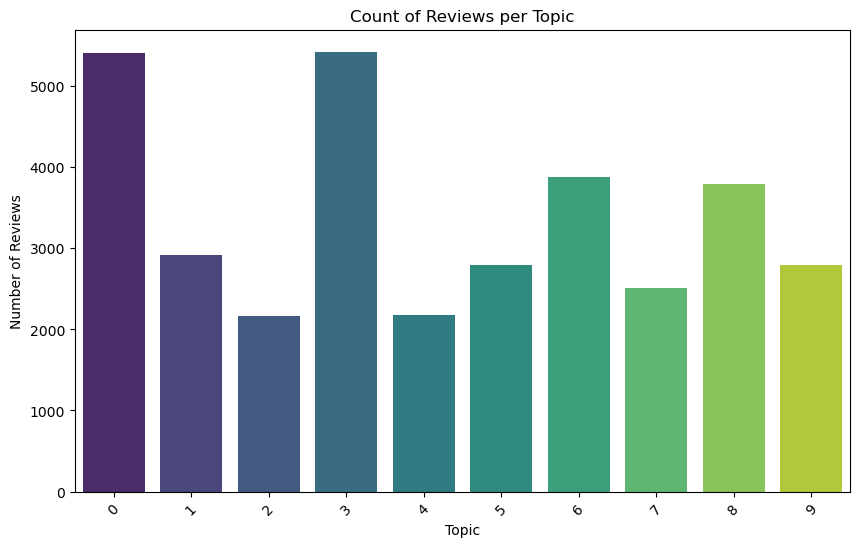

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of reviews for each topic



topic_df = pd.DataFrame(topic_data)  # Convert topic_data into a DataFrame

# Count of reviews for each topic name
topic_counts = topic_df['topic'].value_counts()

# Plotting the count of reviews for each topic name
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Count of Reviews per Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

In [24]:
import pandas as pd

# Sample DataFrame with topic names
data = {
    'topic_name': [
        'account | bank | td | money | day',
        'account | would | money | like | fund',
        'bank | one | earnings | u | like',
        'bonus | app | password | point | delivery',
        'card | credit | bmo | bank | new',
        'company | revenue | growth | demand | term',
        'http | com | www | market | price',
        'rate | interest | mortgage | payment | month',
        'stock | etf | share | year | fund',
        'u | inc | 1 | buy | ltd'
    ]
}
df=pd.read_csv('topics_1.csv')
# Create a DataFrame

# Define a mapping for categories
category_mapping = {
    'account | bank | td | money | day': 'Banking Services',
    'account | would | money | like | fund': 'Banking Services',
    'bank | one | earnings | u | like': 'Banking / Finance',
    'bonus | app | password | point | delivery': 'Promotions / Rewards',
    'card | credit | bmo | bank | new': 'Credit Cards',
    'company | revenue | growth | demand | term': 'Corporate Finance / Business',
    'http | com | www | market | price': 'Online Market / E-commerce',
    'rate | interest | mortgage | payment | month': 'Loans / Mortgage Rates',
    'stock | etf | share | year | fund': 'Investment / Stock Market',
    'u | inc | 1 | buy | ltd': 'Corporate / Stock Information'
}

# Map categories to DataFrame
df['category'] = df['topic_name'].map(category_mapping)
df.to_csv('topics_categorize.csv', index=False)
# Display the categorized DataFrame

